Thanks for:
* https://www.kaggle.com/sishihara/moa-lgbm-benchmark#Preprocessing

* https://www.kaggle.com/ttahara/osic-baseline-lgbm-with-custom-metric

* https://zenn.dev/fkubota/articles/2b8d46b11c178ac2fa2d

* https://qiita.com/ryouta0506/items/619d9ac0d80f8c0aed92



In [1]:
# Version = "v1" # starter model
# Version = "v2" # Compare treat Vs. ctrl and minor modifications, StratifiedKFold
# Version = "v3" # Add debug mode and minor modifications
# Version = "v4" # Clipping a control with an outlier(25-75)
# Version = "v5" # Clipping a control with an outlier(20-80)
Version = "v6" # under sampling 500 → oversamplling 500, lipping a control with an outlier(10-90)

In [2]:
DEBUG = True

# Library

In [3]:
import lightgbm as lgb
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
from imblearn.over_sampling import SMOTE

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

from tqdm.notebook import tqdm
import torch

import warnings
warnings.filterwarnings("ignore")

# Utils

In [4]:
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.{Version}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Config

In [5]:
if DEBUG:
    N_FOLD = 2
    Num_boost_round=1000
    Early_stopping_rounds=10
    Learning_rate = 0.03
else:
    N_FOLD = 5
    Num_boost_round=10000
    Early_stopping_rounds=20
    Learning_rate = 0.01

SEED = 42
seed_everything(seed=SEED)

# Data Loading

In [6]:
train = pd.read_csv("../input/lish-moa/train_features.csv")
test = pd.read_csv("../input/lish-moa/test_features.csv")
train_targets_scored = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
sub = pd.read_csv("../input/lish-moa/sample_submission.csv")

In [7]:
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, encode_cols):
    n_train = len(train)
    train = pd.concat([train, test], sort=False).reset_index(drop=True)
    for f in encode_cols:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    return train, test

# Training Utils

In [8]:
#===========================================================
# model
#===========================================================
def run_lgbm(target_col: str, ctl):
    
    target = train_targets_scored[target_col]
    trt = train[target==1].copy().reset_index(drop=True)
    trt["target"] = 1
    trt = trt.drop("sig_id", axis=1)
    logger.info(f"{target_col} , len(trt) : {len(trt)}")
    
    ctl = under_sampling_func(ctl.iloc[:, 1:], n_target=500)
    
    X_train = pd.concat([trt, ctl], axis=0).reset_index(drop=True)
    y_train = X_train["target"]
    
    X_train = X_train.drop(["target", "cp_type"], axis=1)
    
    K_neighbors = min(len(trt), 5)
    if K_neighbors >= 2:
        sm = SMOTE(k_neighbors=K_neighbors, random_state=42)
        X_train, y_train = sm.fit_sample(X_train, y_train)
    
    X_test = test.drop(["sig_id", "cp_type"], axis=1)
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(X_train),))
    score = 0
    
    for fold_, (train_index, valid_index) in enumerate(cv.split(X_train, y_train)):
        logger.info(f'len(train_index) : {len(train_index)}')
        logger.info(f'len(valid_index) : {len(valid_index)}')
        
        X_tr = X_train.loc[train_index, :]
        X_val = X_train.loc[valid_index, :]
        y_tr = y_train[train_index]
        y_val = y_train[valid_index]

        lgb_train = lgb.Dataset(X_tr,
                                y_tr,
                                categorical_feature=categorical_cols)

        lgb_eval = lgb.Dataset(X_val,
                               y_val,
                               reference=lgb_train,
                               categorical_feature=categorical_cols)
        
        logger.info(f"================================= {fold_+1}fold lightgbm =================================")

        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=20,
                          num_boost_round=Num_boost_round,
                          early_stopping_rounds=Early_stopping_rounds)
        
        oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)


        y_pred = model.predict(X_test, num_iteration=model.best_iteration)

        y_preds.append(y_pred)
        models.append(model)
    
    score = log_loss(y_train, oof_train)
    
    logger.info(f"{target_col} logloss: {score}")
    logger.info(f"=========================================================================================")

    return sum(y_preds) / len(y_preds), score, models, 

In [9]:
def show_feature_importance(feature_importance_df):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:100].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    plt.figure(figsize=(8, 30))
    sns.barplot(x="importance", 
                y="Feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Features importance (averaged)')
    plt.tight_layout()
    plt.savefig(f"./feature_importance_{Version}.png")
    plt.show()

In [10]:
# https://qiita.com/ryouta0506/items/619d9ac0d80f8c0aed92
# Under Samplingの関数（X:多数派のデータ n_target:少数派のターゲット件数 N_clusters=クラスター数）

def under_sampling_func(X, n_target, label=0, N_clusters=8) :

    # KMeansによるクラスタリング
    from sklearn.cluster import KMeans
    km = KMeans(n_clusters= N_clusters, random_state=42)
    km.fit(X)
    X['Cluster'] = km.predict(X)

    # 群別の構成比を少数派の件数に乗じて群別の抽出件数を計算
    count_sum = X.groupby(by='Cluster').count().iloc[0:, 0]
    ratio = count_sum / count_sum.sum()
    samp_num = np.round(ratio * n_target, 0).astype(np.int32)

    # 群別にサンプリング処理を実施
    df = X.sample(samp_num[0],replace=True)
    for i in np.arange(1, N_clusters):
        tmp = X.sample(samp_num[i],replace=True)
        df = pd.concat([df,tmp])
            
    df = df.drop('Cluster', axis=1)
    return df

# Preprocessing

We have to convert some categorical features into numbers in train and test. We can identify categorical features by `pd.DataFrame.select_dtypes`.

In [11]:
train.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [12]:
train.select_dtypes(include=['object']).columns

Index(['sig_id', 'cp_type', 'cp_dose'], dtype='object')

In [13]:
train, test = label_encoding(train, test, ['cp_type', 'cp_dose'])

In [14]:
train.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,1,24,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,1,72,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,1,48,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,1,48,0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,1,72,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [15]:
# Select control data
ctl = train[(train.cp_type==0)]
ctl

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
25,id_0054388ec,0,48,0,-0.6696,-0.2718,-1.2230,-0.6226,-0.7220,0.1588,...,0.6171,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050
38,id_0079af0fb,0,24,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-0.3880,-0.6828,-0.6594,-0.2043,0.3571,-0.1319,0.2187,0.0737,0.6498,-1.4820
40,id_007bfbb91,0,24,1,-1.3200,-1.7340,-0.0741,1.5440,-1.8290,-0.0951,...,0.7412,1.0340,0.7393,1.1020,0.3786,0.2636,-0.5751,0.3362,0.8543,0.9180
47,id_008a986b7,0,48,1,0.4860,0.1430,0.5281,-0.0022,-0.2334,-0.6607,...,-0.3085,-0.1866,0.7629,0.3288,-0.9915,-0.3694,-0.4979,0.5281,-0.9245,-0.9367
63,id_009d8340f,0,24,1,0.4471,-0.0839,-0.3864,0.3196,0.2584,-0.3156,...,0.4795,0.3939,0.7665,0.7932,-0.6804,-0.0435,0.0949,0.2000,-0.4326,0.9364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23729,id_ff1f9e5fc,0,24,0,0.0465,0.6430,-0.2453,0.3521,0.6195,-0.6659,...,0.6085,0.1621,-0.2065,0.8314,-0.1891,-0.0074,0.2131,-0.1419,-0.2422,0.0457
23747,id_ff469c482,0,72,0,-0.6204,-1.3800,-1.1880,-0.6573,-0.8408,-0.2447,...,0.8209,0.7366,0.5468,1.1450,0.5254,0.6224,-0.9630,0.8872,-0.0742,-0.6777
23768,id_ff89331ca,0,72,1,-0.1051,0.4335,0.3648,-0.0525,-0.3632,-0.3228,...,-0.1219,0.4885,0.4963,0.9434,-0.4779,0.6951,0.9517,-0.8110,-0.1748,-0.3626
23793,id_ffd26f361,0,48,1,0.6008,0.2781,-0.3319,-0.8782,0.9281,0.7535,...,1.2470,0.9569,-0.2065,-0.4918,0.7863,0.0504,0.8813,0.7757,-0.5272,0.7082


In [16]:
# clipping

def outlaier_clip(df):
    df = df.copy()
    clipping = df.columns[4:6]
    for col in clipping:
        lower, upper= np.percentile(df[col], [10, 90])
        df[col] = np.clip(df[col], lower, upper)
    
    return df

ctl_df = pd.DataFrame(columns=train.columns)
for i in ctl.cp_time.unique():
    for j in ctl.cp_dose.unique():
        print(len(ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]))
        tmp_ctl = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]
        tmp_ctl = outlaier_clip(tmp_ctl)
        ctl_df = pd.concat([ctl_df, tmp_ctl], axis=0).reset_index(drop=True)
ctl_df

343
305
301
305
307
305


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_0054388ec,0,48,0,-0.6696,-0.27180,-1.2230,-0.6226,-0.7220,0.1588,...,0.6171,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050
1,id_01b05de6c,0,48,0,-0.3176,0.48512,-0.3773,0.5555,-0.4877,0.3413,...,0.2189,-0.6163,0.8001,0.3389,0.7437,0.7533,0.2406,0.5057,0.8017,1.0280
2,id_020ba48d9,0,48,0,0.8094,-0.33390,1.1130,-0.4192,0.4545,-0.4771,...,-0.5948,-0.4414,-0.2442,0.0557,-0.6597,-0.3713,-0.6929,-0.3258,0.3602,-0.0595
3,id_02c93b4a5,0,48,0,-0.0884,-1.54100,0.5562,0.4661,-0.1683,0.9515,...,-0.4568,0.4766,0.9697,0.4613,0.8957,0.8227,1.2300,1.7180,0.6542,0.0580
4,id_03bc6d412,0,48,0,0.8431,0.09310,-0.0958,-0.4337,1.0690,-0.6440,...,-0.2844,-1.1510,-0.5010,-0.2736,0.1270,0.3511,0.1233,-0.8520,0.1767,0.1153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1861,id_fbb620181,0,72,1,-0.3490,0.72970,-4.1480,-1.0030,2.4070,-0.9784,...,-0.7149,-1.4260,-0.8613,-0.0243,-0.6109,0.6377,-1.2590,-0.7238,-0.7734,-0.1274
1862,id_fbba92030,0,72,1,-0.8921,1.13520,0.4227,1.3270,-0.9839,-0.8469,...,1.1120,1.1340,0.7007,1.3320,0.6622,0.6167,0.9459,-0.0344,-0.0186,0.5173
1863,id_fbc0849ad,0,72,1,-0.2948,0.21960,-0.3252,-0.2084,-0.6518,0.3542,...,0.6504,0.5014,0.6009,0.4560,-0.3360,-0.5091,0.6569,0.6203,0.6764,0.4504
1864,id_fd93fa37d,0,72,1,-0.2984,-0.47880,-2.3560,-0.6848,1.8700,1.0240,...,0.0308,-0.4422,-0.6665,-0.8033,-1.0520,0.4103,0.4462,-1.1580,-1.3060,0.1925


In [17]:
ctl_df["target"] = 0

In [18]:
ctl_df.cp_type = ctl_df.cp_type.astype('int64')
ctl_df.cp_time = ctl_df.cp_time.astype('int64')
ctl_df.cp_dose = ctl_df.cp_dose.astype('int64')
ctl_df.dtypes

sig_id      object
cp_type      int64
cp_time      int64
cp_dose      int64
g-0        float64
            ...   
c-96       float64
c-97       float64
c-98       float64
c-99       float64
target       int64
Length: 877, dtype: object

# Modeling

In [19]:
cv = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

params = {
    'num_leaves': 24,
    'max_depth': 5,
    'objective': 'binary',
    'learning_rate': Learning_rate
}

categorical_cols = ['cp_time', 'cp_dose']
feature_importance_df = pd.DataFrame()
models = []
scores = []

In [20]:
for target_col in tqdm(train_targets_scored.columns[1:]):
    _preds, _score, models,  = run_lgbm(target_col, ctl_df)

    sub[target_col] = _preds
    scores.append(_score)
        
    for model in models:
        _importance_df = pd.DataFrame()
        _importance_df["Feature"] = train.columns[2:]
        _importance_df["importance"] = model.feature_importance(importance_type='gain')
        feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)

5-alpha_reductase_inhibitor , len(trt) : 17
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.347054	valid_1's binary_logloss: 0.363374
[40]	training's binary_logloss: 0.186566	valid_1's binary_logloss: 0.205076
[60]	training's binary_logloss: 0.103347	valid_1's binary_logloss: 0.120782
[80]	training's binary_logloss: 0.0589592	valid_1's binary_logloss: 0.0753042
[100]	training's binary_logloss: 0.0339535	valid_1's binary_logloss: 0.0481161
[120]	training's binary_logloss: 0.0196285	valid_1's binary_logloss: 0.0317358
[140]	training's binary_logloss: 0.0112833	valid_1's binary_logloss: 0.0221608
[160]	training's binary_logloss: 0.00657249	valid_1's binary_logloss: 0.0159967
[180]	training's binary_logloss: 0.00384457	valid_1's binary_logloss: 0.0125745
[200]	training's binary_logloss: 0.00225826	valid_1's binary_logloss: 0.0100674
[220]	training's binary_logloss: 0.00132846	valid_1's binary_logloss: 0.00833474
[240]	training's binary_logloss: 0.000781952	valid_1's binary_logloss: 0.00

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[348]	training's binary_logloss: 4.40604e-05	valid_1's binary_logloss: 0.00421641
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.345981	valid_1's binary_logloss: 0.347849
[40]	training's binary_logloss: 0.186475	valid_1's binary_logloss: 0.193362
[60]	training's binary_logloss: 0.104372	valid_1's binary_logloss: 0.112967
[80]	training's binary_logloss: 0.0594306	valid_1's binary_logloss: 0.0680325
[100]	training's binary_logloss: 0.0341307	valid_1's binary_logloss: 0.0425655
[120]	training's binary_logloss: 0.0196746	valid_1's binary_logloss: 0.0274718
[140]	training's binary_logloss: 0.0114483	valid_1's binary_logloss: 0.0184317
[160]	training's binary_logloss: 0.00668391	valid_1's binary_logloss: 0.0127428
[180]	training's binary_logloss: 0.00390212	valid_1's binary_logloss: 0.00926659
[200]	training's binary_logloss: 0.00229374	valid_1's binary_logloss: 0.00690978
[220]	training's binary_logloss: 0.00

5-alpha_reductase_inhibitor logloss: 0.0023652705214705872
11-beta-hsd1_inhibitor , len(trt) : 18
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.34244	valid_1's binary_logloss: 0.362225
[40]	training's binary_logloss: 0.181473	valid_1's binary_logloss: 0.200113
[60]	training's binary_logloss: 0.0997027	valid_1's binary_logloss: 0.118829
[80]	training's binary_logloss: 0.0565555	valid_1's binary_logloss: 0.0731458
[100]	training's binary_logloss: 0.0324482	valid_1's binary_logloss: 0.0469338
[120]	training's binary_logloss: 0.0186521	valid_1's binary_logloss: 0.0304369
[140]	training's binary_logloss: 0.0107315	valid_1's binary_logloss: 0.0205336
[160]	training's binary_logloss: 0.00620972	valid_1's binary_logloss: 0.0144084
[180]	training's binary_logloss: 0.0036071	valid_1's binary_logloss: 0.0105867
[200]	training's binary_logloss: 0.00208983	valid_1's binary_logloss: 0.00810766
[220]	training's binary_logloss: 0.00121458	valid_1's binary_logloss: 0.00637373
[240]	training's binary_logloss: 0.000704645	valid_1's binary_logloss: 0.00

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.33884	valid_1's binary_logloss: 0.353348
[40]	training's binary_logloss: 0.181478	valid_1's binary_logloss: 0.204143
[60]	training's binary_logloss: 0.1019	valid_1's binary_logloss: 0.12666
[80]	training's binary_logloss: 0.0588637	valid_1's binary_logloss: 0.0817833
[100]	training's binary_logloss: 0.0341931	valid_1's binary_logloss: 0.0538938
[120]	training's binary_logloss: 0.0200085	valid_1's binary_logloss: 0.0371196
[140]	training's binary_logloss: 0.0115915	valid_1's binary_logloss: 0.0255307
[160]	training's binary_logloss: 0.00680306	valid_1's binary_logloss: 0.0180405
[180]	training's binary_logloss: 0.00398019	valid_1's binary_logloss: 0.0131989
[200]	training's binary_logloss: 0.00234606	valid_1's binary_logloss: 0.00961387
[220]	training's binary_logloss: 0.00137196	valid_1's binary_logloss: 0.00711865
[240]	training's binary_logloss: 0.000805371	valid_1's binary_logloss: 0.00546

11-beta-hsd1_inhibitor logloss: 0.0008271119847557461
acat_inhibitor , len(trt) : 24
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.375255	valid_1's binary_logloss: 0.4154
[40]	training's binary_logloss: 0.218918	valid_1's binary_logloss: 0.271902
[60]	training's binary_logloss: 0.13349	valid_1's binary_logloss: 0.185848
[80]	training's binary_logloss: 0.0816816	valid_1's binary_logloss: 0.13032
[100]	training's binary_logloss: 0.0513246	valid_1's binary_logloss: 0.0961232
[120]	training's binary_logloss: 0.0325694	valid_1's binary_logloss: 0.0727858
[140]	training's binary_logloss: 0.0205995	valid_1's binary_logloss: 0.0561345
[160]	training's binary_logloss: 0.0129971	valid_1's binary_logloss: 0.0448445
[180]	training's binary_logloss: 0.0082124	valid_1's binary_logloss: 0.0371619
[200]	training's binary_logloss: 0.00524383	valid_1's binary_logloss: 0.0315143
[220]	training's binary_logloss: 0.00335031	valid_1's binary_logloss: 0.0272521
[240]	training's binary_logloss: 0.00213579	valid_1's binary_logloss: 0.0238291
[26

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[505]	training's binary_logloss: 1.00275e-05	valid_1's binary_logloss: 0.0108346
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.370085	valid_1's binary_logloss: 0.426578
[40]	training's binary_logloss: 0.217458	valid_1's binary_logloss: 0.285395
[60]	training's binary_logloss: 0.132934	valid_1's binary_logloss: 0.203859
[80]	training's binary_logloss: 0.0827986	valid_1's binary_logloss: 0.15162
[100]	training's binary_logloss: 0.0515994	valid_1's binary_logloss: 0.116666
[120]	training's binary_logloss: 0.0323105	valid_1's binary_logloss: 0.0885931
[140]	training's binary_logloss: 0.0207895	valid_1's binary_logloss: 0.0715529
[160]	training's binary_logloss: 0.0133172	valid_1's binary_logloss: 0.0574142
[180]	training's binary_logloss: 0.00865278	valid_1's binary_logloss: 0.0482114
[200]	training's binary_logloss: 0.00559497	valid_1's binary_logloss: 0.0408565
[220]	training's binary_logloss: 0.00361629	

acat_inhibitor logloss: 0.012459512847977791
acetylcholine_receptor_agonist , len(trt) : 190
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.422655	valid_1's binary_logloss: 0.506441
[40]	training's binary_logloss: 0.280854	valid_1's binary_logloss: 0.413856
[60]	training's binary_logloss: 0.192928	valid_1's binary_logloss: 0.354195
[80]	training's binary_logloss: 0.135297	valid_1's binary_logloss: 0.318062
[100]	training's binary_logloss: 0.0949124	valid_1's binary_logloss: 0.293688
[120]	training's binary_logloss: 0.0674136	valid_1's binary_logloss: 0.27546
[140]	training's binary_logloss: 0.0474118	valid_1's binary_logloss: 0.262817
[160]	training's binary_logloss: 0.033962	valid_1's binary_logloss: 0.254984
[180]	training's binary_logloss: 0.0246134	valid_1's binary_logloss: 0.249416
[200]	training's binary_logloss: 0.0178823	valid_1's binary_logloss: 0.244509
[220]	training's binary_logloss: 0.0129315	valid_1's binary_logloss: 0.242991


len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[225]	training's binary_logloss: 0.0119673	valid_1's binary_logloss: 0.241899
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.427682	valid_1's binary_logloss: 0.525657
[40]	training's binary_logloss: 0.285447	valid_1's binary_logloss: 0.434994
[60]	training's binary_logloss: 0.194596	valid_1's binary_logloss: 0.377128
[80]	training's binary_logloss: 0.135468	valid_1's binary_logloss: 0.33845
[100]	training's binary_logloss: 0.0956032	valid_1's binary_logloss: 0.315109
[120]	training's binary_logloss: 0.0685546	valid_1's binary_logloss: 0.295921
[140]	training's binary_logloss: 0.0489595	valid_1's binary_logloss: 0.284729
[160]	training's binary_logloss: 0.0345344	valid_1's binary_logloss: 0.278369
[180]	training's binary_logloss: 0.0245556	valid_1's binary_logloss: 0.273594
[200]	training's binary_logloss: 0.0180782	valid_1's binary_logloss: 0.272249
[220]	training's binary_logloss: 0.0132096	valid_1's bi

acetylcholine_receptor_agonist logloss: 0.2557759855693691
acetylcholine_receptor_antagonist , len(trt) : 301


Early stopping, best iteration is:
[227]	training's binary_logloss: 0.0117966	valid_1's binary_logloss: 0.269653


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.414465	valid_1's binary_logloss: 0.489593
[40]	training's binary_logloss: 0.270937	valid_1's binary_logloss: 0.392013
[60]	training's binary_logloss: 0.18326	valid_1's binary_logloss: 0.338497
[80]	training's binary_logloss: 0.125365	valid_1's binary_logloss: 0.305066
[100]	training's binary_logloss: 0.086358	valid_1's binary_logloss: 0.280136
[120]	training's binary_logloss: 0.0599337	valid_1's binary_logloss: 0.262961
[140]	training's binary_logloss: 0.0424593	valid_1's binary_logloss: 0.252938
[160]	training's binary_logloss: 0.0300806	valid_1's binary_logloss: 0.245349
[180]	training's binary_logloss: 0.0215613	valid_1's binary_logloss: 0.240507


len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


[200]	training's binary_logloss: 0.0155221	valid_1's binary_logloss: 0.239137
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.0179967	valid_1's binary_logloss: 0.238437
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.419154	valid_1's binary_logloss: 0.507544
[40]	training's binary_logloss: 0.272585	valid_1's binary_logloss: 0.414216
[60]	training's binary_logloss: 0.183266	valid_1's binary_logloss: 0.358378
[80]	training's binary_logloss: 0.126033	valid_1's binary_logloss: 0.319891
[100]	training's binary_logloss: 0.0868306	valid_1's binary_logloss: 0.291863
[120]	training's binary_logloss: 0.0612746	valid_1's binary_logloss: 0.271661
[140]	training's binary_logloss: 0.0431865	valid_1's binary_logloss: 0.260787
[160]	training's binary_logloss: 0.0306328	valid_1's binary_logloss: 0.254506
[180]	training's binary_logloss: 0.0219257	valid_1's binary_logloss: 0.248453


acetylcholine_receptor_antagonist logloss: 0.24317703003310828
acetylcholinesterase_inhibitor , len(trt) : 73


Early stopping, best iteration is:
[185]	training's binary_logloss: 0.0201912	valid_1's binary_logloss: 0.247917


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.387267	valid_1's binary_logloss: 0.450747
[40]	training's binary_logloss: 0.234887	valid_1's binary_logloss: 0.327519
[60]	training's binary_logloss: 0.148491	valid_1's binary_logloss: 0.259663
[80]	training's binary_logloss: 0.0962954	valid_1's binary_logloss: 0.21114
[100]	training's binary_logloss: 0.0629022	valid_1's binary_logloss: 0.180093
[120]	training's binary_logloss: 0.0411373	valid_1's binary_logloss: 0.158955
[140]	training's binary_logloss: 0.0271066	valid_1's binary_logloss: 0.143978
[160]	training's binary_logloss: 0.0179747	valid_1's binary_logloss: 0.132611
[180]	training's binary_logloss: 0.0121126	valid_1's binary_logloss: 0.126329
[200]	training's binary_logloss: 0.00810916	valid_1's binary_logloss: 0.119841
[220]	training's binary_logloss: 0.00541684	valid_1's binary_logloss: 0.116972


len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


[240]	training's binary_logloss: 0.00361876	valid_1's binary_logloss: 0.114723
Early stopping, best iteration is:
[233]	training's binary_logloss: 0.00415433	valid_1's binary_logloss: 0.113718
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.383577	valid_1's binary_logloss: 0.440405
[40]	training's binary_logloss: 0.227811	valid_1's binary_logloss: 0.314475
[60]	training's binary_logloss: 0.142567	valid_1's binary_logloss: 0.241927
[80]	training's binary_logloss: 0.09078	valid_1's binary_logloss: 0.190213
[100]	training's binary_logloss: 0.0583158	valid_1's binary_logloss: 0.156472
[120]	training's binary_logloss: 0.038315	valid_1's binary_logloss: 0.132739
[140]	training's binary_logloss: 0.0253448	valid_1's binary_logloss: 0.117438
[160]	training's binary_logloss: 0.0167359	valid_1's binary_logloss: 0.107475
[180]	training's binary_logloss: 0.0110679	valid_1's binary_logloss: 0.0989444
[200]	training's binary_logloss: 0.00738086	valid_1's

acetylcholinesterase_inhibitor logloss: 0.09509055976183542
adenosine_receptor_agonist , len(trt) : 54


Early stopping, best iteration is:
[340]	training's binary_logloss: 0.000449207	valid_1's binary_logloss: 0.0764635


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.387982	valid_1's binary_logloss: 0.4452
[40]	training's binary_logloss: 0.235723	valid_1's binary_logloss: 0.316302
[60]	training's binary_logloss: 0.149502	valid_1's binary_logloss: 0.242318
[80]	training's binary_logloss: 0.0954683	valid_1's binary_logloss: 0.196103
[100]	training's binary_logloss: 0.0618658	valid_1's binary_logloss: 0.16458
[120]	training's binary_logloss: 0.0405522	valid_1's binary_logloss: 0.142819
[140]	training's binary_logloss: 0.026524	valid_1's binary_logloss: 0.128933
[160]	training's binary_logloss: 0.0172457	valid_1's binary_logloss: 0.118476
[180]	training's binary_logloss: 0.011323	valid_1's binary_logloss: 0.110909
[200]	training's binary_logloss: 0.00744729	valid_1's binary_logloss: 0.106078
[220]	training's binary_logloss: 0.00492519	valid_1's binary_logloss: 0.10455


len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[228]	training's binary_logloss: 0.00416246	valid_1's binary_logloss: 0.103212
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.387959	valid_1's binary_logloss: 0.443194
[40]	training's binary_logloss: 0.237706	valid_1's binary_logloss: 0.317137
[60]	training's binary_logloss: 0.14996	valid_1's binary_logloss: 0.236327
[80]	training's binary_logloss: 0.097034	valid_1's binary_logloss: 0.184155
[100]	training's binary_logloss: 0.0636687	valid_1's binary_logloss: 0.149679
[120]	training's binary_logloss: 0.0416893	valid_1's binary_logloss: 0.124228
[140]	training's binary_logloss: 0.0279412	valid_1's binary_logloss: 0.10642
[160]	training's binary_logloss: 0.0189062	valid_1's binary_logloss: 0.0930143
[180]	training's binary_logloss: 0.0127406	valid_1's binary_logloss: 0.0819997
[200]	training's binary_logloss: 0.0086577	valid_1's binary_logloss: 0.0742734
[220]	training's binary_logloss: 0.00586042	valid_1'

adenosine_receptor_agonist logloss: 0.07370215567021601
adenosine_receptor_antagonist , len(trt) : 96
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.388311	valid_1's binary_logloss: 0.449721
[40]	training's binary_logloss: 0.237593	valid_1's binary_logloss: 0.32876
[60]	training's binary_logloss: 0.149505	valid_1's binary_logloss: 0.257688
[80]	training's binary_logloss: 0.0960126	valid_1's binary_logloss: 0.215046
[100]	training's binary_logloss: 0.0626375	valid_1's binary_logloss: 0.185118
[120]	training's binary_logloss: 0.0413727	valid_1's binary_logloss: 0.165891
[140]	training's binary_logloss: 0.0276026	valid_1's binary_logloss: 0.154927
[160]	training's binary_logloss: 0.0185892	valid_1's binary_logloss: 0.146473
[180]	training's binary_logloss: 0.0126442	valid_1's binary_logloss: 0.143734
[200]	training's binary_logloss: 0.00850701	valid_1's binary_logloss: 0.141303
[220]	training's binary_logloss: 0.00579225	valid_1's binary_logloss: 0.140736


len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


[240]	training's binary_logloss: 0.00394532	valid_1's binary_logloss: 0.140566
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.00477215	valid_1's binary_logloss: 0.139764
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.392299	valid_1's binary_logloss: 0.449633
[40]	training's binary_logloss: 0.242281	valid_1's binary_logloss: 0.323367
[60]	training's binary_logloss: 0.155132	valid_1's binary_logloss: 0.247763
[80]	training's binary_logloss: 0.100557	valid_1's binary_logloss: 0.197494
[100]	training's binary_logloss: 0.0661857	valid_1's binary_logloss: 0.164858
[120]	training's binary_logloss: 0.043892	valid_1's binary_logloss: 0.142886
[140]	training's binary_logloss: 0.0295128	valid_1's binary_logloss: 0.127278
[160]	training's binary_logloss: 0.0195515	valid_1's binary_logloss: 0.116073
[180]	training's binary_logloss: 0.0129828	valid_1's binary_logloss: 0.107558
[200]	training's binary_logloss: 0.00872744	valid_1's

adenosine_receptor_antagonist logloss: 0.1153070483243993
adenylyl_cyclase_activator , len(trt) : 12
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.334947	valid_1's binary_logloss: 0.346241
[40]	training's binary_logloss: 0.17767	valid_1's binary_logloss: 0.191778
[60]	training's binary_logloss: 0.0983027	valid_1's binary_logloss: 0.112972
[80]	training's binary_logloss: 0.0557517	valid_1's binary_logloss: 0.0690875
[100]	training's binary_logloss: 0.0319393	valid_1's binary_logloss: 0.0431591
[120]	training's binary_logloss: 0.01838	valid_1's binary_logloss: 0.0274829
[140]	training's binary_logloss: 0.0106019	valid_1's binary_logloss: 0.0178706
[160]	training's binary_logloss: 0.00610701	valid_1's binary_logloss: 0.0118015
[180]	training's binary_logloss: 0.00352064	valid_1's binary_logloss: 0.00796451
[200]	training's binary_logloss: 0.00203832	valid_1's binary_logloss: 0.00563735
[220]	training's binary_logloss: 0.00118457	valid_1's binary_logloss: 0.00410095
[240]	training's binary_logloss: 0.000686478	valid_1's binary_logloss: 0.00

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.339152	valid_1's binary_logloss: 0.345099
[40]	training's binary_logloss: 0.181857	valid_1's binary_logloss: 0.190376
[60]	training's binary_logloss: 0.100058	valid_1's binary_logloss: 0.108016
[80]	training's binary_logloss: 0.0558251	valid_1's binary_logloss: 0.0621824
[100]	training's binary_logloss: 0.0317086	valid_1's binary_logloss: 0.0370126
[120]	training's binary_logloss: 0.0181442	valid_1's binary_logloss: 0.0223921
[140]	training's binary_logloss: 0.0103725	valid_1's binary_logloss: 0.013703
[160]	training's binary_logloss: 0.00594836	valid_1's binary_logloss: 0.00851227
[180]	training's binary_logloss: 0.00340504	valid_1's binary_logloss: 0.00531325
[200]	training's binary_logloss: 0.00194323	valid_1's binary_logloss: 0.00335141
[220]	training's binary_logloss: 0.00110791	valid_1's binary_logloss: 0.0020466
[240]	training's binary_logloss: 0.000632743	valid_1's binary_logloss: 0.0

adenylyl_cyclase_activator logloss: 0.00015762143083375183
adrenergic_receptor_agonist , len(trt) : 270
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.407853	valid_1's binary_logloss: 0.499925
[40]	training's binary_logloss: 0.263577	valid_1's binary_logloss: 0.403436
[60]	training's binary_logloss: 0.176434	valid_1's binary_logloss: 0.339478
[80]	training's binary_logloss: 0.120973	valid_1's binary_logloss: 0.294082
[100]	training's binary_logloss: 0.0839161	valid_1's binary_logloss: 0.260136
[120]	training's binary_logloss: 0.0583941	valid_1's binary_logloss: 0.233132
[140]	training's binary_logloss: 0.0405649	valid_1's binary_logloss: 0.211992
[160]	training's binary_logloss: 0.0287278	valid_1's binary_logloss: 0.197142
[180]	training's binary_logloss: 0.0201959	valid_1's binary_logloss: 0.185569
[200]	training's binary_logloss: 0.0143713	valid_1's binary_logloss: 0.176068
[220]	training's binary_logloss: 0.0101176	valid_1's binary_logloss: 0.170787
[240]	training's binary_logloss: 0.00717059	valid_1's binary_logloss: 0.165929
[260]	trai

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


[280]	training's binary_logloss: 0.00360432	valid_1's binary_logloss: 0.164152
Early stopping, best iteration is:
[271]	training's binary_logloss: 0.00421568	valid_1's binary_logloss: 0.163374
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.421729	valid_1's binary_logloss: 0.492483
[40]	training's binary_logloss: 0.270598	valid_1's binary_logloss: 0.382885
[60]	training's binary_logloss: 0.18246	valid_1's binary_logloss: 0.31731
[80]	training's binary_logloss: 0.124966	valid_1's binary_logloss: 0.274449
[100]	training's binary_logloss: 0.0868002	valid_1's binary_logloss: 0.245063
[120]	training's binary_logloss: 0.0611029	valid_1's binary_logloss: 0.226058
[140]	training's binary_logloss: 0.0430995	valid_1's binary_logloss: 0.212927
[160]	training's binary_logloss: 0.0306945	valid_1's binary_logloss: 0.203004
[180]	training's binary_logloss: 0.0221048	valid_1's binary_logloss: 0.195367
[200]	training's binary_logloss: 0.0157918	valid_1's b

adrenergic_receptor_agonist logloss: 0.17325977616208108
adrenergic_receptor_antagonist , len(trt) : 360
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.427433	valid_1's binary_logloss: 0.536213
[40]	training's binary_logloss: 0.290881	valid_1's binary_logloss: 0.452973
[60]	training's binary_logloss: 0.204954	valid_1's binary_logloss: 0.398054
[80]	training's binary_logloss: 0.144749	valid_1's binary_logloss: 0.360065
[100]	training's binary_logloss: 0.103047	valid_1's binary_logloss: 0.335527
[120]	training's binary_logloss: 0.0745411	valid_1's binary_logloss: 0.319275
[140]	training's binary_logloss: 0.0538554	valid_1's binary_logloss: 0.306513
[160]	training's binary_logloss: 0.0397698	valid_1's binary_logloss: 0.299594
[180]	training's binary_logloss: 0.0292516	valid_1's binary_logloss: 0.292777
[200]	training's binary_logloss: 0.0217119	valid_1's binary_logloss: 0.292033
[220]	training's binary_logloss: 0.0161548	valid_1's binary_logloss: 0.290333
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.017295	valid_1's bin

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.426364	valid_1's binary_logloss: 0.546922
[40]	training's binary_logloss: 0.279833	valid_1's binary_logloss: 0.465121
[60]	training's binary_logloss: 0.189571	valid_1's binary_logloss: 0.419236
[80]	training's binary_logloss: 0.132241	valid_1's binary_logloss: 0.393174
[100]	training's binary_logloss: 0.0927277	valid_1's binary_logloss: 0.380754
[120]	training's binary_logloss: 0.0655041	valid_1's binary_logloss: 0.368256
[140]	training's binary_logloss: 0.046711	valid_1's binary_logloss: 0.362966


adrenergic_receptor_antagonist logloss: 0.3249281747416569
akt_inhibitor , len(trt) : 66


Early stopping, best iteration is:
[149]	training's binary_logloss: 0.0399404	valid_1's binary_logloss: 0.36009


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.37094	valid_1's binary_logloss: 0.394194
[40]	training's binary_logloss: 0.214971	valid_1's binary_logloss: 0.250935
[60]	training's binary_logloss: 0.128204	valid_1's binary_logloss: 0.167822
[80]	training's binary_logloss: 0.0783652	valid_1's binary_logloss: 0.11661
[100]	training's binary_logloss: 0.04841	valid_1's binary_logloss: 0.0831362
[120]	training's binary_logloss: 0.0302064	valid_1's binary_logloss: 0.0613001
[140]	training's binary_logloss: 0.0191252	valid_1's binary_logloss: 0.0471266
[160]	training's binary_logloss: 0.0121182	valid_1's binary_logloss: 0.037872
[180]	training's binary_logloss: 0.00774683	valid_1's binary_logloss: 0.0312316
[200]	training's binary_logloss: 0.00492771	valid_1's binary_logloss: 0.0263496
[220]	training's binary_logloss: 0.00314494	valid_1's binary_logloss: 0.0230194
[240]	training's binary_logloss: 0.0020088	valid_1's binary_logloss: 0.0203316
[260

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[423]	training's binary_logloss: 3.31634e-05	valid_1's binary_logloss: 0.0106432
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.365209	valid_1's binary_logloss: 0.408581
[40]	training's binary_logloss: 0.208017	valid_1's binary_logloss: 0.26247
[60]	training's binary_logloss: 0.123336	valid_1's binary_logloss: 0.182868
[80]	training's binary_logloss: 0.0747253	valid_1's binary_logloss: 0.130755
[100]	training's binary_logloss: 0.0460624	valid_1's binary_logloss: 0.0972486
[120]	training's binary_logloss: 0.0285225	valid_1's binary_logloss: 0.0760727
[140]	training's binary_logloss: 0.0178608	valid_1's binary_logloss: 0.0618558
[160]	training's binary_logloss: 0.0112038	valid_1's binary_logloss: 0.0527212
[180]	training's binary_logloss: 0.00704289	valid_1's binary_logloss: 0.0465047
[200]	training's binary_logloss: 0.0044354	valid_1's binary_logloss: 0.0423429
[220]	training's binary_logloss: 0.0028004	v

akt_inhibitor logloss: 0.024772277359888305


[260]	training's binary_logloss: 0.0011008	valid_1's binary_logloss: 0.0390962
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00129607	valid_1's binary_logloss: 0.0389014


aldehyde_dehydrogenase_inhibitor , len(trt) : 7
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.321569	valid_1's binary_logloss: 0.325365
[40]	training's binary_logloss: 0.165852	valid_1's binary_logloss: 0.17147
[60]	training's binary_logloss: 0.0895641	valid_1's binary_logloss: 0.0961407
[80]	training's binary_logloss: 0.0496494	valid_1's binary_logloss: 0.057091
[100]	training's binary_logloss: 0.0277583	valid_1's binary_logloss: 0.0348027
[120]	training's binary_logloss: 0.0154426	valid_1's binary_logloss: 0.0212189
[140]	training's binary_logloss: 0.0086496	valid_1's binary_logloss: 0.0134107
[160]	training's binary_logloss: 0.00487589	valid_1's binary_logloss: 0.00890531
[180]	training's binary_logloss: 0.00275564	valid_1's binary_logloss: 0.00615139
[200]	training's binary_logloss: 0.00156274	valid_1's binary_logloss: 0.00443959
[220]	training's binary_logloss: 0.000886194	valid_1's binary_logloss: 0.00339932
[240]	training's binary_logloss: 0.000486077	valid_1's binary_logloss: 

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.325282	valid_1's binary_logloss: 0.330248
[40]	training's binary_logloss: 0.169666	valid_1's binary_logloss: 0.175882
[60]	training's binary_logloss: 0.0925043	valid_1's binary_logloss: 0.0989595
[80]	training's binary_logloss: 0.0517115	valid_1's binary_logloss: 0.0588222
[100]	training's binary_logloss: 0.0285317	valid_1's binary_logloss: 0.035196
[120]	training's binary_logloss: 0.0158546	valid_1's binary_logloss: 0.0221533
[140]	training's binary_logloss: 0.00886848	valid_1's binary_logloss: 0.0153123
[160]	training's binary_logloss: 0.00497973	valid_1's binary_logloss: 0.0116263
[180]	training's binary_logloss: 0.00280117	valid_1's binary_logloss: 0.00959267
[200]	training's binary_logloss: 0.00158001	valid_1's binary_logloss: 0.00853077
[220]	training's binary_logloss: 0.000895008	valid_1's binary_logloss: 0.00805987
[240]	training's binary_logloss: 0.000507436	valid_1's binary_logloss:

aldehyde_dehydrogenase_inhibitor logloss: 0.003876948073401276
alk_inhibitor , len(trt) : 42


Early stopping, best iteration is:
[263]	training's binary_logloss: 0.000264576	valid_1's binary_logloss: 0.00755277


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.372346	valid_1's binary_logloss: 0.404735
[40]	training's binary_logloss: 0.21494	valid_1's binary_logloss: 0.259181
[60]	training's binary_logloss: 0.128937	valid_1's binary_logloss: 0.17634
[80]	training's binary_logloss: 0.0781748	valid_1's binary_logloss: 0.122957
[100]	training's binary_logloss: 0.0481438	valid_1's binary_logloss: 0.0887873
[120]	training's binary_logloss: 0.0302139	valid_1's binary_logloss: 0.0661827
[140]	training's binary_logloss: 0.0186487	valid_1's binary_logloss: 0.0499457
[160]	training's binary_logloss: 0.0115504	valid_1's binary_logloss: 0.0390767
[180]	training's binary_logloss: 0.0072238	valid_1's binary_logloss: 0.0313203
[200]	training's binary_logloss: 0.00452557	valid_1's binary_logloss: 0.0258323
[220]	training's binary_logloss: 0.00283031	valid_1's binary_logloss: 0.0211529
[240]	training's binary_logloss: 0.00177928	valid_1's binary_logloss: 0.0182393
[

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.366806	valid_1's binary_logloss: 0.397279
[40]	training's binary_logloss: 0.208039	valid_1's binary_logloss: 0.248225
[60]	training's binary_logloss: 0.122838	valid_1's binary_logloss: 0.162895
[80]	training's binary_logloss: 0.0734481	valid_1's binary_logloss: 0.109861
[100]	training's binary_logloss: 0.0449276	valid_1's binary_logloss: 0.0761057
[120]	training's binary_logloss: 0.027759	valid_1's binary_logloss: 0.0550955
[140]	training's binary_logloss: 0.0172009	valid_1's binary_logloss: 0.041037
[160]	training's binary_logloss: 0.0106716	valid_1's binary_logloss: 0.0313507
[180]	training's binary_logloss: 0.0066473	valid_1's binary_logloss: 0.024846
[200]	training's binary_logloss: 0.00409594	valid_1's binary_logloss: 0.0198361
[220]	training's binary_logloss: 0.002564	valid_1's binary_logloss: 0.0163065
[240]	training's binary_logloss: 0.00159141	valid_1's binary_logloss: 0.0134202
[260

alk_inhibitor logloss: 0.007236078323938033
ampk_activator , len(trt) : 12
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.355188	valid_1's binary_logloss: 0.388165
[40]	training's binary_logloss: 0.199136	valid_1's binary_logloss: 0.241277
[60]	training's binary_logloss: 0.113465	valid_1's binary_logloss: 0.152253
[80]	training's binary_logloss: 0.0660573	valid_1's binary_logloss: 0.10007
[100]	training's binary_logloss: 0.0387529	valid_1's binary_logloss: 0.0666472
[120]	training's binary_logloss: 0.0231449	valid_1's binary_logloss: 0.0458877
[140]	training's binary_logloss: 0.0138442	valid_1's binary_logloss: 0.0321877
[160]	training's binary_logloss: 0.00822287	valid_1's binary_logloss: 0.0229446
[180]	training's binary_logloss: 0.00487816	valid_1's binary_logloss: 0.0164052
[200]	training's binary_logloss: 0.00291973	valid_1's binary_logloss: 0.0128422
[220]	training's binary_logloss: 0.00173945	valid_1's binary_logloss: 0.0101072
[240]	training's binary_logloss: 0.00103984	valid_1's binary_logloss: 0.007971

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.347233	valid_1's binary_logloss: 0.375302
[40]	training's binary_logloss: 0.190608	valid_1's binary_logloss: 0.226845
[60]	training's binary_logloss: 0.108274	valid_1's binary_logloss: 0.141038
[80]	training's binary_logloss: 0.063003	valid_1's binary_logloss: 0.090112
[100]	training's binary_logloss: 0.0370383	valid_1's binary_logloss: 0.05952
[120]	training's binary_logloss: 0.0218609	valid_1's binary_logloss: 0.0407176
[140]	training's binary_logloss: 0.0130091	valid_1's binary_logloss: 0.029047
[160]	training's binary_logloss: 0.00777491	valid_1's binary_logloss: 0.0210356
[180]	training's binary_logloss: 0.0046633	valid_1's binary_logloss: 0.0153625
[200]	training's binary_logloss: 0.00281465	valid_1's binary_logloss: 0.0119021
[220]	training's binary_logloss: 0.00169621	valid_1's binary_logloss: 0.00942818
[240]	training's binary_logloss: 0.00102136	valid_1's binary_logloss: 0.00739029


ampk_activator logloss: 0.00110616409080287
analgesic , len(trt) : 12
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.338762	valid_1's binary_logloss: 0.350913
[40]	training's binary_logloss: 0.182439	valid_1's binary_logloss: 0.200914
[60]	training's binary_logloss: 0.102608	valid_1's binary_logloss: 0.123497
[80]	training's binary_logloss: 0.0589252	valid_1's binary_logloss: 0.0788409
[100]	training's binary_logloss: 0.034148	valid_1's binary_logloss: 0.0518511
[120]	training's binary_logloss: 0.0200482	valid_1's binary_logloss: 0.0352847
[140]	training's binary_logloss: 0.0117953	valid_1's binary_logloss: 0.0254225
[160]	training's binary_logloss: 0.0068617	valid_1's binary_logloss: 0.0184814
[180]	training's binary_logloss: 0.00399414	valid_1's binary_logloss: 0.0138136
[200]	training's binary_logloss: 0.00230554	valid_1's binary_logloss: 0.010354
[220]	training's binary_logloss: 0.00133447	valid_1's binary_logloss: 0.00853849
[240]	training's binary_logloss: 0.000775874	valid_1's binary_logloss: 0.00669

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.339545	valid_1's binary_logloss: 0.362902
[40]	training's binary_logloss: 0.182692	valid_1's binary_logloss: 0.209033
[60]	training's binary_logloss: 0.101802	valid_1's binary_logloss: 0.126702
[80]	training's binary_logloss: 0.0579708	valid_1's binary_logloss: 0.0814094
[100]	training's binary_logloss: 0.0332977	valid_1's binary_logloss: 0.0547183
[120]	training's binary_logloss: 0.0189735	valid_1's binary_logloss: 0.0385275
[140]	training's binary_logloss: 0.0108959	valid_1's binary_logloss: 0.0294801
[160]	training's binary_logloss: 0.00630817	valid_1's binary_logloss: 0.023476
[180]	training's binary_logloss: 0.00366068	valid_1's binary_logloss: 0.0196668
[200]	training's binary_logloss: 0.00211821	valid_1's binary_logloss: 0.0168251
[220]	training's binary_logloss: 0.00122449	valid_1's binary_logloss: 0.014893
[240]	training's binary_logloss: 0.00070962	valid_1's binary_logloss: 0.013596

analgesic logloss: 0.006505379805346624
androgen_receptor_agonist , len(trt) : 48


Early stopping, best iteration is:
[268]	training's binary_logloss: 0.000332199	valid_1's binary_logloss: 0.0123481


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.366272	valid_1's binary_logloss: 0.417639
[40]	training's binary_logloss: 0.210354	valid_1's binary_logloss: 0.277377
[60]	training's binary_logloss: 0.1251	valid_1's binary_logloss: 0.197088
[80]	training's binary_logloss: 0.076071	valid_1's binary_logloss: 0.146907
[100]	training's binary_logloss: 0.0473209	valid_1's binary_logloss: 0.115123
[120]	training's binary_logloss: 0.0296904	valid_1's binary_logloss: 0.0947062
[140]	training's binary_logloss: 0.0187416	valid_1's binary_logloss: 0.0813629
[160]	training's binary_logloss: 0.0118179	valid_1's binary_logloss: 0.0728371
[180]	training's binary_logloss: 0.00748773	valid_1's binary_logloss: 0.0669038
[200]	training's binary_logloss: 0.00475299	valid_1's binary_logloss: 0.0627027
[220]	training's binary_logloss: 0.00299442	valid_1's binary_logloss: 0.0585968
[240]	training's binary_logloss: 0.00191287	valid_1's binary_logloss: 0.0550645
[2

len(train_index) : 500
len(valid_index) : 500


[300]	training's binary_logloss: 0.000491408	valid_1's binary_logloss: 0.0498381
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.000575628	valid_1's binary_logloss: 0.0498265


================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.380561	valid_1's binary_logloss: 0.419031
[40]	training's binary_logloss: 0.225135	valid_1's binary_logloss: 0.281936
[60]	training's binary_logloss: 0.137937	valid_1's binary_logloss: 0.196103
[80]	training's binary_logloss: 0.0859419	valid_1's binary_logloss: 0.14009
[100]	training's binary_logloss: 0.0537719	valid_1's binary_logloss: 0.102361
[120]	training's binary_logloss: 0.0334334	valid_1's binary_logloss: 0.0764627
[140]	training's binary_logloss: 0.0210677	valid_1's binary_logloss: 0.0601298
[160]	training's binary_logloss: 0.0133435	valid_1's binary_logloss: 0.0475359
[180]	training's binary_logloss: 0.00842201	valid_1's binary_logloss: 0.0378548
[200]	training's binary_logloss: 0.00537516	valid_1's binary_logloss: 0.0306009
[220]	training's binary_logloss: 0.00341286	valid_1's binary_logloss: 0.0249935
[240]	training's binary_logloss: 0.00217558	valid_1's binary_logloss: 0.0207755


androgen_receptor_agonist logloss: 0.027095693310350877


Early stopping, best iteration is:
[564]	training's binary_logloss: 6.65673e-06	valid_1's binary_logloss: 0.00436487


androgen_receptor_antagonist , len(trt) : 89
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.396423	valid_1's binary_logloss: 0.441376
[40]	training's binary_logloss: 0.246765	valid_1's binary_logloss: 0.309656
[60]	training's binary_logloss: 0.160601	valid_1's binary_logloss: 0.232264
[80]	training's binary_logloss: 0.107288	valid_1's binary_logloss: 0.182577
[100]	training's binary_logloss: 0.0726039	valid_1's binary_logloss: 0.148794
[120]	training's binary_logloss: 0.0488742	valid_1's binary_logloss: 0.122269
[140]	training's binary_logloss: 0.0331075	valid_1's binary_logloss: 0.102505
[160]	training's binary_logloss: 0.0223661	valid_1's binary_logloss: 0.0875889
[180]	training's binary_logloss: 0.0151984	valid_1's binary_logloss: 0.0751987
[200]	training's binary_logloss: 0.0104261	valid_1's binary_logloss: 0.0674262
[220]	training's binary_logloss: 0.00710275	valid_1's binary_logloss: 0.0619001
[240]	training's binary_logloss: 0.00485941	valid_1's binary_logloss: 0.0578347
[260

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


[300]	training's binary_logloss: 0.00155157	valid_1's binary_logloss: 0.0505044
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.00180632	valid_1's binary_logloss: 0.0504453
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.386893	valid_1's binary_logloss: 0.453001
[40]	training's binary_logloss: 0.236485	valid_1's binary_logloss: 0.331103
[60]	training's binary_logloss: 0.149435	valid_1's binary_logloss: 0.262764
[80]	training's binary_logloss: 0.0959416	valid_1's binary_logloss: 0.212932
[100]	training's binary_logloss: 0.0622007	valid_1's binary_logloss: 0.17889
[120]	training's binary_logloss: 0.0403434	valid_1's binary_logloss: 0.152987
[140]	training's binary_logloss: 0.0266097	valid_1's binary_logloss: 0.134009
[160]	training's binary_logloss: 0.017527	valid_1's binary_logloss: 0.123754
[180]	training's binary_logloss: 0.0115652	valid_1's binary_logloss: 0.116218
[200]	training's binary_logloss: 0.00770414	valid_1

androgen_receptor_antagonist logloss: 0.07895329105074889
anesthetic_-_local , len(trt) : 80


Early stopping, best iteration is:
[219]	training's binary_logloss: 0.00520915	valid_1's binary_logloss: 0.107461


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.383149	valid_1's binary_logloss: 0.421852
[40]	training's binary_logloss: 0.231984	valid_1's binary_logloss: 0.289298
[60]	training's binary_logloss: 0.144902	valid_1's binary_logloss: 0.212469
[80]	training's binary_logloss: 0.091899	valid_1's binary_logloss: 0.166001
[100]	training's binary_logloss: 0.0585234	valid_1's binary_logloss: 0.133753
[120]	training's binary_logloss: 0.0376616	valid_1's binary_logloss: 0.110143
[140]	training's binary_logloss: 0.0245425	valid_1's binary_logloss: 0.09645
[160]	training's binary_logloss: 0.015935	valid_1's binary_logloss: 0.0851379
[180]	training's binary_logloss: 0.0103596	valid_1's binary_logloss: 0.0769995
[200]	training's binary_logloss: 0.00672261	valid_1's binary_logloss: 0.0727639
[220]	training's binary_logloss: 0.00437302	valid_1's binary_logloss: 0.0671049
[240]	training's binary_logloss: 0.00285271	valid_1's binary_logloss: 0.0643783
[260]

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.388085	valid_1's binary_logloss: 0.443434
[40]	training's binary_logloss: 0.232131	valid_1's binary_logloss: 0.307194
[60]	training's binary_logloss: 0.142675	valid_1's binary_logloss: 0.229442
[80]	training's binary_logloss: 0.0880749	valid_1's binary_logloss: 0.183661
[100]	training's binary_logloss: 0.0548743	valid_1's binary_logloss: 0.155495
[120]	training's binary_logloss: 0.0346814	valid_1's binary_logloss: 0.136053
[140]	training's binary_logloss: 0.0220166	valid_1's binary_logloss: 0.125187
[160]	training's binary_logloss: 0.0140537	valid_1's binary_logloss: 0.116991
[180]	training's binary_logloss: 0.00899841	valid_1's binary_logloss: 0.109128
[200]	training's binary_logloss: 0.00579123	valid_1's binary_logloss: 0.103768
[220]	training's binary_logloss: 0.00373488	valid_1's binary_logloss: 0.100343
[240]	training's binary_logloss: 0.00240483	valid_1's binary_logloss: 0.0973548


anesthetic_-_local logloss: 0.07485203124849961
angiogenesis_inhibitor , len(trt) : 36


Early stopping, best iteration is:
[249]	training's binary_logloss: 0.00197617	valid_1's binary_logloss: 0.0965645


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.382755	valid_1's binary_logloss: 0.416864
[40]	training's binary_logloss: 0.222966	valid_1's binary_logloss: 0.264838
[60]	training's binary_logloss: 0.134089	valid_1's binary_logloss: 0.179749
[80]	training's binary_logloss: 0.0829115	valid_1's binary_logloss: 0.125923
[100]	training's binary_logloss: 0.0519388	valid_1's binary_logloss: 0.0904363
[120]	training's binary_logloss: 0.0327111	valid_1's binary_logloss: 0.0666109
[140]	training's binary_logloss: 0.0205941	valid_1's binary_logloss: 0.050013
[160]	training's binary_logloss: 0.0130368	valid_1's binary_logloss: 0.0382004
[180]	training's binary_logloss: 0.00820807	valid_1's binary_logloss: 0.0307995
[200]	training's binary_logloss: 0.00522027	valid_1's binary_logloss: 0.0261754
[220]	training's binary_logloss: 0.00333691	valid_1's binary_logloss: 0.0220063
[240]	training's binary_logloss: 0.00214055	valid_1's binary_logloss: 0.0191332

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.37887	valid_1's binary_logloss: 0.438886
[40]	training's binary_logloss: 0.220826	valid_1's binary_logloss: 0.304362
[60]	training's binary_logloss: 0.132225	valid_1's binary_logloss: 0.214089
[80]	training's binary_logloss: 0.0812784	valid_1's binary_logloss: 0.158494
[100]	training's binary_logloss: 0.0509889	valid_1's binary_logloss: 0.124265
[120]	training's binary_logloss: 0.0321922	valid_1's binary_logloss: 0.096375
[140]	training's binary_logloss: 0.0205777	valid_1's binary_logloss: 0.0791588
[160]	training's binary_logloss: 0.013171	valid_1's binary_logloss: 0.0669647
[180]	training's binary_logloss: 0.00845103	valid_1's binary_logloss: 0.0558559
[200]	training's binary_logloss: 0.00546239	valid_1's binary_logloss: 0.048921
[220]	training's binary_logloss: 0.00350973	valid_1's binary_logloss: 0.0443968
[240]	training's binary_logloss: 0.00224899	valid_1's binary_logloss: 0.0406743
[26

angiogenesis_inhibitor logloss: 0.018177406825074106
angiotensin_receptor_antagonist , len(trt) : 37


Early stopping, best iteration is:
[407]	training's binary_logloss: 5.5503e-05	valid_1's binary_logloss: 0.0218702


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.372174	valid_1's binary_logloss: 0.411683
[40]	training's binary_logloss: 0.216209	valid_1's binary_logloss: 0.269975
[60]	training's binary_logloss: 0.129305	valid_1's binary_logloss: 0.188382
[80]	training's binary_logloss: 0.0793318	valid_1's binary_logloss: 0.140455
[100]	training's binary_logloss: 0.0491127	valid_1's binary_logloss: 0.10722
[120]	training's binary_logloss: 0.0305557	valid_1's binary_logloss: 0.0865481
[140]	training's binary_logloss: 0.0191408	valid_1's binary_logloss: 0.0735659
[160]	training's binary_logloss: 0.0120175	valid_1's binary_logloss: 0.0657681
[180]	training's binary_logloss: 0.0075507	valid_1's binary_logloss: 0.059872
[200]	training's binary_logloss: 0.004734	valid_1's binary_logloss: 0.0572545
[220]	training's binary_logloss: 0.00299667	valid_1's binary_logloss: 0.0554202
[240]	training's binary_logloss: 0.00189691	valid_1's binary_logloss: 0.0537239
[260

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.371721	valid_1's binary_logloss: 0.417712
[40]	training's binary_logloss: 0.212899	valid_1's binary_logloss: 0.284429
[60]	training's binary_logloss: 0.126259	valid_1's binary_logloss: 0.2146
[80]	training's binary_logloss: 0.0762167	valid_1's binary_logloss: 0.174507
[100]	training's binary_logloss: 0.0470688	valid_1's binary_logloss: 0.150235
[120]	training's binary_logloss: 0.0294026	valid_1's binary_logloss: 0.13652
[140]	training's binary_logloss: 0.0184654	valid_1's binary_logloss: 0.127558
[160]	training's binary_logloss: 0.0116456	valid_1's binary_logloss: 0.121519


angiotensin_receptor_antagonist logloss: 0.0835457027378669
anti-inflammatory , len(trt) : 73


[180]	training's binary_logloss: 0.00731764	valid_1's binary_logloss: 0.120954
Early stopping, best iteration is:
[170]	training's binary_logloss: 0.00923479	valid_1's binary_logloss: 0.119992


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.387289	valid_1's binary_logloss: 0.436629
[40]	training's binary_logloss: 0.23126	valid_1's binary_logloss: 0.308408
[60]	training's binary_logloss: 0.146713	valid_1's binary_logloss: 0.232705
[80]	training's binary_logloss: 0.0949848	valid_1's binary_logloss: 0.180983
[100]	training's binary_logloss: 0.0620915	valid_1's binary_logloss: 0.147572
[120]	training's binary_logloss: 0.0409517	valid_1's binary_logloss: 0.125034
[140]	training's binary_logloss: 0.0272564	valid_1's binary_logloss: 0.108707
[160]	training's binary_logloss: 0.0179156	valid_1's binary_logloss: 0.0962744
[180]	training's binary_logloss: 0.0119449	valid_1's binary_logloss: 0.0885619
[200]	training's binary_logloss: 0.00805327	valid_1's binary_logloss: 0.0851748
[220]	training's binary_logloss: 0.00532299	valid_1's binary_logloss: 0.0822306


len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[228]	training's binary_logloss: 0.00452752	valid_1's binary_logloss: 0.0814344
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.386204	valid_1's binary_logloss: 0.441023
[40]	training's binary_logloss: 0.237216	valid_1's binary_logloss: 0.312161
[60]	training's binary_logloss: 0.151355	valid_1's binary_logloss: 0.235054
[80]	training's binary_logloss: 0.0964323	valid_1's binary_logloss: 0.18379
[100]	training's binary_logloss: 0.0621466	valid_1's binary_logloss: 0.152053
[120]	training's binary_logloss: 0.0405568	valid_1's binary_logloss: 0.130754
[140]	training's binary_logloss: 0.0268129	valid_1's binary_logloss: 0.117438
[160]	training's binary_logloss: 0.017761	valid_1's binary_logloss: 0.106403
[180]	training's binary_logloss: 0.0117806	valid_1's binary_logloss: 0.0996286
[200]	training's binary_logloss: 0.00788931	valid_1's binary_logloss: 0.0944686
[220]	training's binary_logloss: 0.00527208	valid_

anti-inflammatory logloss: 0.08188948591675231
antiarrhythmic , len(trt) : 6


[280]	training's binary_logloss: 0.00156612	valid_1's binary_logloss: 0.0827804
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00192142	valid_1's binary_logloss: 0.0823446


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.33005	valid_1's binary_logloss: 0.334663
[40]	training's binary_logloss: 0.172687	valid_1's binary_logloss: 0.179378
[60]	training's binary_logloss: 0.0937467	valid_1's binary_logloss: 0.0999513
[80]	training's binary_logloss: 0.0518814	valid_1's binary_logloss: 0.0569617
[100]	training's binary_logloss: 0.029039	valid_1's binary_logloss: 0.0327783
[120]	training's binary_logloss: 0.016351	valid_1's binary_logloss: 0.0191458
[140]	training's binary_logloss: 0.00924783	valid_1's binary_logloss: 0.0112635
[160]	training's binary_logloss: 0.00524689	valid_1's binary_logloss: 0.00666985
[180]	training's binary_logloss: 0.00298556	valid_1's binary_logloss: 0.00400716
[200]	training's binary_logloss: 0.00170149	valid_1's binary_logloss: 0.00247104
[220]	training's binary_logloss: 0.000967984	valid_1's binary_logloss: 0.00152482
[240]	training's binary_logloss: 0.000551317	valid_1's binary_logloss: 

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


[440]	training's binary_logloss: 4.20201e-06	valid_1's binary_logloss: 3.39928e-05
Early stopping, best iteration is:
[440]	training's binary_logloss: 4.20201e-06	valid_1's binary_logloss: 3.39928e-05
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.327566	valid_1's binary_logloss: 0.344503
[40]	training's binary_logloss: 0.17112	valid_1's binary_logloss: 0.189269
[60]	training's binary_logloss: 0.092799	valid_1's binary_logloss: 0.108479
[80]	training's binary_logloss: 0.0512981	valid_1's binary_logloss: 0.0633653
[100]	training's binary_logloss: 0.0287021	valid_1's binary_logloss: 0.0381089
[120]	training's binary_logloss: 0.0161949	valid_1's binary_logloss: 0.0235449
[140]	training's binary_logloss: 0.00917121	valid_1's binary_logloss: 0.0149492
[160]	training's binary_logloss: 0.00519815	valid_1's binary_logloss: 0.00952315
[180]	training's binary_logloss: 0.00295697	valid_1's binary_logloss: 0.00625352
[200]	training's binary_logloss: 

antiarrhythmic logloss: 0.000417488482103219
antibiotic , len(trt) : 43


Early stopping, best iteration is:
[366]	training's binary_logloss: 1.59966e-05	valid_1's binary_logloss: 0.000800984


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.392437	valid_1's binary_logloss: 0.446771
[40]	training's binary_logloss: 0.233663	valid_1's binary_logloss: 0.311968
[60]	training's binary_logloss: 0.14338	valid_1's binary_logloss: 0.233223
[80]	training's binary_logloss: 0.09076	valid_1's binary_logloss: 0.178694
[100]	training's binary_logloss: 0.0576862	valid_1's binary_logloss: 0.139897
[120]	training's binary_logloss: 0.0370642	valid_1's binary_logloss: 0.113111
[140]	training's binary_logloss: 0.0240375	valid_1's binary_logloss: 0.0931015
[160]	training's binary_logloss: 0.0154378	valid_1's binary_logloss: 0.07937
[180]	training's binary_logloss: 0.0100252	valid_1's binary_logloss: 0.0666562
[200]	training's binary_logloss: 0.00655171	valid_1's binary_logloss: 0.0580173
[220]	training's binary_logloss: 0.00428449	valid_1's binary_logloss: 0.0508441
[240]	training's binary_logloss: 0.00280438	valid_1's binary_logloss: 0.0452303
[260]	

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.390986	valid_1's binary_logloss: 0.451509
[40]	training's binary_logloss: 0.23655	valid_1's binary_logloss: 0.316902
[60]	training's binary_logloss: 0.147916	valid_1's binary_logloss: 0.232948
[80]	training's binary_logloss: 0.0942942	valid_1's binary_logloss: 0.176688
[100]	training's binary_logloss: 0.0609616	valid_1's binary_logloss: 0.137762
[120]	training's binary_logloss: 0.0396067	valid_1's binary_logloss: 0.110794
[140]	training's binary_logloss: 0.0257401	valid_1's binary_logloss: 0.0902529
[160]	training's binary_logloss: 0.0170292	valid_1's binary_logloss: 0.0760667
[180]	training's binary_logloss: 0.0113021	valid_1's binary_logloss: 0.0656707
[200]	training's binary_logloss: 0.00749172	valid_1's binary_logloss: 0.0576773
[220]	training's binary_logloss: 0.00498394	valid_1's binary_logloss: 0.0520363
[240]	training's binary_logloss: 0.00330835	valid_1's binary_logloss: 0.0460718
[2

antibiotic logloss: 0.02178289854902026
anticonvulsant , len(trt) : 12


Early stopping, best iteration is:
[407]	training's binary_logloss: 0.000108605	valid_1's binary_logloss: 0.0267721


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.334043	valid_1's binary_logloss: 0.354096
[40]	training's binary_logloss: 0.178631	valid_1's binary_logloss: 0.201315
[60]	training's binary_logloss: 0.0988519	valid_1's binary_logloss: 0.120236
[80]	training's binary_logloss: 0.0548714	valid_1's binary_logloss: 0.0747442
[100]	training's binary_logloss: 0.0310403	valid_1's binary_logloss: 0.0488944
[120]	training's binary_logloss: 0.0177199	valid_1's binary_logloss: 0.0333179
[140]	training's binary_logloss: 0.0102724	valid_1's binary_logloss: 0.0239088
[160]	training's binary_logloss: 0.00594249	valid_1's binary_logloss: 0.0170517
[180]	training's binary_logloss: 0.00344253	valid_1's binary_logloss: 0.0130066
[200]	training's binary_logloss: 0.00198821	valid_1's binary_logloss: 0.010048
[220]	training's binary_logloss: 0.0011447	valid_1's binary_logloss: 0.00839386
[240]	training's binary_logloss: 0.000658589	valid_1's binary_logloss: 0.006

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


[280]	training's binary_logloss: 0.000217773	valid_1's binary_logloss: 0.00587523
Early stopping, best iteration is:
[271]	training's binary_logloss: 0.000280179	valid_1's binary_logloss: 0.00576954
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.338178	valid_1's binary_logloss: 0.343802
[40]	training's binary_logloss: 0.180827	valid_1's binary_logloss: 0.189413
[60]	training's binary_logloss: 0.101289	valid_1's binary_logloss: 0.111164
[80]	training's binary_logloss: 0.058114	valid_1's binary_logloss: 0.0676168
[100]	training's binary_logloss: 0.0336198	valid_1's binary_logloss: 0.0418793
[120]	training's binary_logloss: 0.0194802	valid_1's binary_logloss: 0.026773
[140]	training's binary_logloss: 0.0113524	valid_1's binary_logloss: 0.0178559
[160]	training's binary_logloss: 0.00664509	valid_1's binary_logloss: 0.0125376
[180]	training's binary_logloss: 0.00390645	valid_1's binary_logloss: 0.00930658
[200]	training's binary_logloss: 0.002

anticonvulsant logloss: 0.004997973465079148
antifungal , len(trt) : 13


[320]	training's binary_logloss: 9.6588e-05	valid_1's binary_logloss: 0.00439204
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.000125143	valid_1's binary_logloss: 0.0042264


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.330871	valid_1's binary_logloss: 0.337359
[40]	training's binary_logloss: 0.174144	valid_1's binary_logloss: 0.188189
[60]	training's binary_logloss: 0.0958257	valid_1's binary_logloss: 0.112803
[80]	training's binary_logloss: 0.0538098	valid_1's binary_logloss: 0.0714536
[100]	training's binary_logloss: 0.0305096	valid_1's binary_logloss: 0.047245
[120]	training's binary_logloss: 0.0168366	valid_1's binary_logloss: 0.0361609
[140]	training's binary_logloss: 0.00919591	valid_1's binary_logloss: 0.0336058
Early stopping, best iteration is:
[140]	training's binary_logloss: 0.00919591	valid_1's binary_logloss: 0.0336058


len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.33195	valid_1's binary_logloss: 0.344694
[40]	training's binary_logloss: 0.174695	valid_1's binary_logloss: 0.193965
[60]	training's binary_logloss: 0.0960843	valid_1's binary_logloss: 0.117088
[80]	training's binary_logloss: 0.0541317	valid_1's binary_logloss: 0.0745704
[100]	training's binary_logloss: 0.030275	valid_1's binary_logloss: 0.0478838
[120]	training's binary_logloss: 0.016941	valid_1's binary_logloss: 0.0327294
[140]	training's binary_logloss: 0.009525	valid_1's binary_logloss: 0.023561
[160]	training's binary_logloss: 0.00540904	valid_1's binary_logloss: 0.0174687
[180]	training's binary_logloss: 0.00309121	valid_1's binary_logloss: 0.0133415
[200]	training's binary_logloss: 0.00176911	valid_1's binary_logloss: 0.0108134
[220]	training's binary_logloss: 0.00101372	valid_1's binary_logloss: 0.00859043
[240]	training's binary_logloss: 0.000581596	valid_1's binary_logloss: 0.007060

antifungal logloss: 0.017555752974190326
antihistamine , len(trt) : 12
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.338543	valid_1's binary_logloss: 0.358036
[40]	training's binary_logloss: 0.182881	valid_1's binary_logloss: 0.208681
[60]	training's binary_logloss: 0.101455	valid_1's binary_logloss: 0.129632
[80]	training's binary_logloss: 0.0574482	valid_1's binary_logloss: 0.0848933
[100]	training's binary_logloss: 0.0329778	valid_1's binary_logloss: 0.059383
[120]	training's binary_logloss: 0.0192226	valid_1's binary_logloss: 0.0445094
[140]	training's binary_logloss: 0.011064	valid_1's binary_logloss: 0.0370852
[160]	training's binary_logloss: 0.00642268	valid_1's binary_logloss: 0.0332687
[180]	training's binary_logloss: 0.00375846	valid_1's binary_logloss: 0.0301408
[200]	training's binary_logloss: 0.00220544	valid_1's binary_logloss: 0.0287908
[220]	training's binary_logloss: 0.00130369	valid_1's binary_logloss: 0.0283261
[240]	training's binary_logloss: 0.000765607	valid_1's binary_logloss: 0.02699

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[263]	training's binary_logloss: 0.000416879	valid_1's binary_logloss: 0.0254674
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.341381	valid_1's binary_logloss: 0.354212
[40]	training's binary_logloss: 0.18538	valid_1's binary_logloss: 0.202449
[60]	training's binary_logloss: 0.103194	valid_1's binary_logloss: 0.121151
[80]	training's binary_logloss: 0.0588331	valid_1's binary_logloss: 0.074786
[100]	training's binary_logloss: 0.0339456	valid_1's binary_logloss: 0.0478384
[120]	training's binary_logloss: 0.0197144	valid_1's binary_logloss: 0.0317922
[140]	training's binary_logloss: 0.0115317	valid_1's binary_logloss: 0.021945
[160]	training's binary_logloss: 0.0067731	valid_1's binary_logloss: 0.0160737
[180]	training's binary_logloss: 0.00398168	valid_1's binary_logloss: 0.012149
[200]	training's binary_logloss: 0.00234774	valid_1's binary_logloss: 0.00971857
[220]	training's binary_logloss: 0.00138447	

antihistamine logloss: 0.015046533919750634
antimalarial , len(trt) : 18


Early stopping, best iteration is:
[305]	training's binary_logloss: 0.000146912	valid_1's binary_logloss: 0.00462572


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.345579	valid_1's binary_logloss: 0.368728
[40]	training's binary_logloss: 0.190256	valid_1's binary_logloss: 0.223149
[60]	training's binary_logloss: 0.10946	valid_1's binary_logloss: 0.145154
[80]	training's binary_logloss: 0.0628243	valid_1's binary_logloss: 0.0990349
[100]	training's binary_logloss: 0.0371442	valid_1's binary_logloss: 0.0714912
[120]	training's binary_logloss: 0.0219826	valid_1's binary_logloss: 0.0552722
[140]	training's binary_logloss: 0.0130389	valid_1's binary_logloss: 0.0434473
[160]	training's binary_logloss: 0.00767411	valid_1's binary_logloss: 0.0364335
[180]	training's binary_logloss: 0.00457921	valid_1's binary_logloss: 0.0312657
[200]	training's binary_logloss: 0.00270564	valid_1's binary_logloss: 0.0275657
[220]	training's binary_logloss: 0.00162057	valid_1's binary_logloss: 0.0243419
[240]	training's binary_logloss: 0.000974553	valid_1's binary_logloss: 0.0213

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.345682	valid_1's binary_logloss: 0.358581
[40]	training's binary_logloss: 0.188438	valid_1's binary_logloss: 0.209751
[60]	training's binary_logloss: 0.107555	valid_1's binary_logloss: 0.133116
[80]	training's binary_logloss: 0.0632622	valid_1's binary_logloss: 0.0885107
[100]	training's binary_logloss: 0.0374509	valid_1's binary_logloss: 0.0618031
[120]	training's binary_logloss: 0.0224811	valid_1's binary_logloss: 0.0448422
[140]	training's binary_logloss: 0.0135198	valid_1's binary_logloss: 0.0337913
[160]	training's binary_logloss: 0.00817984	valid_1's binary_logloss: 0.0268351
[180]	training's binary_logloss: 0.00492895	valid_1's binary_logloss: 0.0215645
[200]	training's binary_logloss: 0.00297997	valid_1's binary_logloss: 0.0184328
[220]	training's binary_logloss: 0.00180176	valid_1's binary_logloss: 0.0161558
[240]	training's binary_logloss: 0.00108568	valid_1's binary_logloss: 0.0146

antimalarial logloss: 0.009464748842530884
antioxidant , len(trt) : 73


Early stopping, best iteration is:
[344]	training's binary_logloss: 7.53536e-05	valid_1's binary_logloss: 0.0104633


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.39007	valid_1's binary_logloss: 0.447377
[40]	training's binary_logloss: 0.234155	valid_1's binary_logloss: 0.314844
[60]	training's binary_logloss: 0.145759	valid_1's binary_logloss: 0.234893
[80]	training's binary_logloss: 0.0916903	valid_1's binary_logloss: 0.178532
[100]	training's binary_logloss: 0.0589807	valid_1's binary_logloss: 0.142957
[120]	training's binary_logloss: 0.0382421	valid_1's binary_logloss: 0.119236
[140]	training's binary_logloss: 0.0249021	valid_1's binary_logloss: 0.103842
[160]	training's binary_logloss: 0.0163555	valid_1's binary_logloss: 0.0940789
[180]	training's binary_logloss: 0.0108391	valid_1's binary_logloss: 0.0862895
[200]	training's binary_logloss: 0.00718991	valid_1's binary_logloss: 0.0817473
[220]	training's binary_logloss: 0.00483024	valid_1's binary_logloss: 0.0782035
[240]	training's binary_logloss: 0.00323253	valid_1's binary_logloss: 0.0757806
[26

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[267]	training's binary_logloss: 0.00189325	valid_1's binary_logloss: 0.0733941
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.385181	valid_1's binary_logloss: 0.444596
[40]	training's binary_logloss: 0.231745	valid_1's binary_logloss: 0.311421
[60]	training's binary_logloss: 0.144044	valid_1's binary_logloss: 0.236601
[80]	training's binary_logloss: 0.0918493	valid_1's binary_logloss: 0.190523
[100]	training's binary_logloss: 0.0593824	valid_1's binary_logloss: 0.159212
[120]	training's binary_logloss: 0.0386702	valid_1's binary_logloss: 0.135727
[140]	training's binary_logloss: 0.0255149	valid_1's binary_logloss: 0.119183
[160]	training's binary_logloss: 0.0168479	valid_1's binary_logloss: 0.107658
[180]	training's binary_logloss: 0.0109896	valid_1's binary_logloss: 0.0988089
[200]	training's binary_logloss: 0.00726192	valid_1's binary_logloss: 0.0930797
[220]	training's binary_logloss: 0.00477517	vali

antioxidant logloss: 0.07743021237875457
antiprotozoal , len(trt) : 36


Early stopping, best iteration is:
[286]	training's binary_logloss: 0.00123101	valid_1's binary_logloss: 0.0814663


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.375767	valid_1's binary_logloss: 0.40835
[40]	training's binary_logloss: 0.222194	valid_1's binary_logloss: 0.264832
[60]	training's binary_logloss: 0.135527	valid_1's binary_logloss: 0.181529
[80]	training's binary_logloss: 0.0840721	valid_1's binary_logloss: 0.129588
[100]	training's binary_logloss: 0.0523824	valid_1's binary_logloss: 0.0945717
[120]	training's binary_logloss: 0.0330771	valid_1's binary_logloss: 0.0715253
[140]	training's binary_logloss: 0.0208639	valid_1's binary_logloss: 0.0555706
[160]	training's binary_logloss: 0.0132003	valid_1's binary_logloss: 0.0435401
[180]	training's binary_logloss: 0.00831019	valid_1's binary_logloss: 0.0351803
[200]	training's binary_logloss: 0.00524144	valid_1's binary_logloss: 0.0284563
[220]	training's binary_logloss: 0.00330775	valid_1's binary_logloss: 0.0246963
[240]	training's binary_logloss: 0.00209769	valid_1's binary_logloss: 0.0204954

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[380]	training's binary_logloss: 8.81342e-05	valid_1's binary_logloss: 0.0105873
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.368361	valid_1's binary_logloss: 0.414301
[40]	training's binary_logloss: 0.213213	valid_1's binary_logloss: 0.270322
[60]	training's binary_logloss: 0.127408	valid_1's binary_logloss: 0.184991
[80]	training's binary_logloss: 0.0776447	valid_1's binary_logloss: 0.130136
[100]	training's binary_logloss: 0.0479892	valid_1's binary_logloss: 0.0975822
[120]	training's binary_logloss: 0.0297407	valid_1's binary_logloss: 0.0752292
[140]	training's binary_logloss: 0.0185756	valid_1's binary_logloss: 0.0599352
[160]	training's binary_logloss: 0.0116718	valid_1's binary_logloss: 0.0494283
[180]	training's binary_logloss: 0.00733535	valid_1's binary_logloss: 0.042675
[200]	training's binary_logloss: 0.00467117	valid_1's binary_logloss: 0.0382748
[220]	training's binary_logloss: 0.00294283

antiprotozoal logloss: 0.016691327611576837
antiviral , len(trt) : 23


[380]	training's binary_logloss: 7.55902e-05	valid_1's binary_logloss: 0.0230924
Early stopping, best iteration is:
[370]	training's binary_logloss: 9.52237e-05	valid_1's binary_logloss: 0.0227953


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.356834	valid_1's binary_logloss: 0.388598
[40]	training's binary_logloss: 0.19757	valid_1's binary_logloss: 0.241628
[60]	training's binary_logloss: 0.114131	valid_1's binary_logloss: 0.161778
[80]	training's binary_logloss: 0.0668746	valid_1's binary_logloss: 0.111108
[100]	training's binary_logloss: 0.0394525	valid_1's binary_logloss: 0.0806084
[120]	training's binary_logloss: 0.0237232	valid_1's binary_logloss: 0.0607022
[140]	training's binary_logloss: 0.014254	valid_1's binary_logloss: 0.0477635
[160]	training's binary_logloss: 0.00865336	valid_1's binary_logloss: 0.0377971
[180]	training's binary_logloss: 0.00521732	valid_1's binary_logloss: 0.0313893
[200]	training's binary_logloss: 0.00314784	valid_1's binary_logloss: 0.0268588
[220]	training's binary_logloss: 0.00191084	valid_1's binary_logloss: 0.0232886
[240]	training's binary_logloss: 0.00115533	valid_1's binary_logloss: 0.0206035

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.351707	valid_1's binary_logloss: 0.379432
[40]	training's binary_logloss: 0.195764	valid_1's binary_logloss: 0.233841
[60]	training's binary_logloss: 0.112191	valid_1's binary_logloss: 0.15218
[80]	training's binary_logloss: 0.0651908	valid_1's binary_logloss: 0.10226
[100]	training's binary_logloss: 0.0382807	valid_1's binary_logloss: 0.0710213
[120]	training's binary_logloss: 0.022716	valid_1's binary_logloss: 0.051121
[140]	training's binary_logloss: 0.0134906	valid_1's binary_logloss: 0.0388234
[160]	training's binary_logloss: 0.00807862	valid_1's binary_logloss: 0.03018
[180]	training's binary_logloss: 0.00482796	valid_1's binary_logloss: 0.0247204
[200]	training's binary_logloss: 0.00288583	valid_1's binary_logloss: 0.0202375
[220]	training's binary_logloss: 0.00172834	valid_1's binary_logloss: 0.017692
[240]	training's binary_logloss: 0.00103743	valid_1's binary_logloss: 0.0154481
[260

antiviral logloss: 0.009711759709750164
apoptosis_stimulant , len(trt) : 49


Early stopping, best iteration is:
[322]	training's binary_logloss: 0.000127321	valid_1's binary_logloss: 0.0116456


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.385577	valid_1's binary_logloss: 0.413767
[40]	training's binary_logloss: 0.228948	valid_1's binary_logloss: 0.272666
[60]	training's binary_logloss: 0.14327	valid_1's binary_logloss: 0.189415
[80]	training's binary_logloss: 0.0901585	valid_1's binary_logloss: 0.136718
[100]	training's binary_logloss: 0.0572717	valid_1's binary_logloss: 0.100923
[120]	training's binary_logloss: 0.0369581	valid_1's binary_logloss: 0.0753058
[140]	training's binary_logloss: 0.0236596	valid_1's binary_logloss: 0.0570259
[160]	training's binary_logloss: 0.0152046	valid_1's binary_logloss: 0.0439193
[180]	training's binary_logloss: 0.00975089	valid_1's binary_logloss: 0.0343091
[200]	training's binary_logloss: 0.00630358	valid_1's binary_logloss: 0.0272173
[220]	training's binary_logloss: 0.00417056	valid_1's binary_logloss: 0.0220263
[240]	training's binary_logloss: 0.00271948	valid_1's binary_logloss: 0.0178827


len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.384837	valid_1's binary_logloss: 0.419859
[40]	training's binary_logloss: 0.228149	valid_1's binary_logloss: 0.285601
[60]	training's binary_logloss: 0.138757	valid_1's binary_logloss: 0.206365
[80]	training's binary_logloss: 0.0873516	valid_1's binary_logloss: 0.15845
[100]	training's binary_logloss: 0.0555376	valid_1's binary_logloss: 0.127036
[120]	training's binary_logloss: 0.0354303	valid_1's binary_logloss: 0.104441
[140]	training's binary_logloss: 0.0227863	valid_1's binary_logloss: 0.0912517
[160]	training's binary_logloss: 0.0146457	valid_1's binary_logloss: 0.0808943
[180]	training's binary_logloss: 0.00946897	valid_1's binary_logloss: 0.0729905
[200]	training's binary_logloss: 0.00606635	valid_1's binary_logloss: 0.0681231
[220]	training's binary_logloss: 0.00391516	valid_1's binary_logloss: 0.0633362
[240]	training's binary_logloss: 0.00252905	valid_1's binary_logloss: 0.0597276


apoptosis_stimulant logloss: 0.03134945850864634


[260]	training's binary_logloss: 0.0016372	valid_1's binary_logloss: 0.0586695
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.00195421	valid_1's binary_logloss: 0.0580396


aromatase_inhibitor , len(trt) : 47
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.381964	valid_1's binary_logloss: 0.428902
[40]	training's binary_logloss: 0.233457	valid_1's binary_logloss: 0.298712
[60]	training's binary_logloss: 0.147875	valid_1's binary_logloss: 0.218906
[80]	training's binary_logloss: 0.0945988	valid_1's binary_logloss: 0.16268
[100]	training's binary_logloss: 0.0613401	valid_1's binary_logloss: 0.125464
[120]	training's binary_logloss: 0.0400901	valid_1's binary_logloss: 0.100835
[140]	training's binary_logloss: 0.0263883	valid_1's binary_logloss: 0.0838488
[160]	training's binary_logloss: 0.0175173	valid_1's binary_logloss: 0.0710595
[180]	training's binary_logloss: 0.0116462	valid_1's binary_logloss: 0.0614947
[200]	training's binary_logloss: 0.00774442	valid_1's binary_logloss: 0.0542184
[220]	training's binary_logloss: 0.00520568	valid_1's binary_logloss: 0.0487367
[240]	training's binary_logloss: 0.00348831	valid_1's binary_logloss: 0.0437155
[2

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.381871	valid_1's binary_logloss: 0.423365
[40]	training's binary_logloss: 0.230948	valid_1's binary_logloss: 0.291136
[60]	training's binary_logloss: 0.144113	valid_1's binary_logloss: 0.211975
[80]	training's binary_logloss: 0.09145	valid_1's binary_logloss: 0.163134
[100]	training's binary_logloss: 0.0592922	valid_1's binary_logloss: 0.130403
[120]	training's binary_logloss: 0.0388575	valid_1's binary_logloss: 0.107646
[140]	training's binary_logloss: 0.0256091	valid_1's binary_logloss: 0.0923954
[160]	training's binary_logloss: 0.0168771	valid_1's binary_logloss: 0.0803495
[180]	training's binary_logloss: 0.0112741	valid_1's binary_logloss: 0.0724094
[200]	training's binary_logloss: 0.0073933	valid_1's binary_logloss: 0.0670407
[220]	training's binary_logloss: 0.00488968	valid_1's binary_logloss: 0.0626706
[240]	training's binary_logloss: 0.00322879	valid_1's binary_logloss: 0.0596411
[260

aromatase_inhibitor logloss: 0.034659861036870486
atm_kinase_inhibitor , len(trt) : 6


Early stopping, best iteration is:
[328]	training's binary_logloss: 0.0005519	valid_1's binary_logloss: 0.0495241


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.32493	valid_1's binary_logloss: 0.329789
[40]	training's binary_logloss: 0.167947	valid_1's binary_logloss: 0.175436
[60]	training's binary_logloss: 0.0902295	valid_1's binary_logloss: 0.0973371
[80]	training's binary_logloss: 0.0495064	valid_1's binary_logloss: 0.0558542
[100]	training's binary_logloss: 0.0273256	valid_1's binary_logloss: 0.0320878
[120]	training's binary_logloss: 0.0151957	valid_1's binary_logloss: 0.0189719
[140]	training's binary_logloss: 0.00841658	valid_1's binary_logloss: 0.0109005
[160]	training's binary_logloss: 0.00460904	valid_1's binary_logloss: 0.00602493
[180]	training's binary_logloss: 0.00252647	valid_1's binary_logloss: 0.0033211
[200]	training's binary_logloss: 0.00138565	valid_1's binary_logloss: 0.00182736
[220]	training's binary_logloss: 0.000760185	valid_1's binary_logloss: 0.00100436
[240]	training's binary_logloss: 0.000417116	valid_1's binary_logloss:

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


[400]	training's binary_logloss: 5.07078e-06	valid_1's binary_logloss: 8.93804e-06
[420]	training's binary_logloss: 3.9461e-06	valid_1's binary_logloss: 6.92188e-06
Early stopping, best iteration is:
[413]	training's binary_logloss: 3.9461e-06	valid_1's binary_logloss: 6.92188e-06
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.32366	valid_1's binary_logloss: 0.325805
[40]	training's binary_logloss: 0.164066	valid_1's binary_logloss: 0.171541
[60]	training's binary_logloss: 0.0865563	valid_1's binary_logloss: 0.0985326
[80]	training's binary_logloss: 0.0465334	valid_1's binary_logloss: 0.0625831
[100]	training's binary_logloss: 0.0252578	valid_1's binary_logloss: 0.0451627
[120]	training's binary_logloss: 0.0137792	valid_1's binary_logloss: 0.0374221
[140]	training's binary_logloss: 0.00753763	valid_1's binary_logloss: 0.0348561


atm_kinase_inhibitor logloss: 0.0173541292696727
atp-sensitive_potassium_channel_antagonist , len(trt) : 1


Early stopping, best iteration is:
[147]	training's binary_logloss: 0.00610532	valid_1's binary_logloss: 0.0347013


len(train_index) : 250
len(valid_index) : 251
================================= 1fold lightgbm =================================
len(train_index) : 251
len(valid_index) : 250
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0	valid_1's binary_logloss: 0.137605
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00927776	valid_1's binary_logloss: 0.00363904
[40]	training's binary_logloss: 0.00484364	valid_1's binary_logloss: 0.00243206
[60]	training's binary_logloss: 0.00277322	valid_1's binary_logloss: 0.00154698
[80]	training's binary_logloss: 0.00163631	valid_1's binary_logloss: 0.000965541
[100]	training's binary_logloss: 0.000979293	valid_1's binary_logloss: 0.000607067
[120]	training's binary_logloss: 0.000590521	valid_1's binary_logloss: 0.000382144
[140]	training's binary_logloss: 0.000357538	valid_1's binary_logloss: 0.000242266
[160]	training's binary_logloss: 0.000217152	valid_1's binary_logloss: 0.000151185
[180]	training's binary_logloss: 0.000132132	valid_1's binary_logloss: 9.59077e-05
[200]	training's binary_logloss: 8.0526

atp-sensitive_potassium_channel_antagonist logloss: 0.06894347087929165
atp_synthase_inhibitor , len(trt) : 12


[300]	training's binary_logloss: 8.56183e-06	valid_1's binary_logloss: 7.61008e-06
Early stopping, best iteration is:
[291]	training's binary_logloss: 8.56183e-06	valid_1's binary_logloss: 7.61008e-06


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.318623	valid_1's binary_logloss: 0.320583
[40]	training's binary_logloss: 0.1618	valid_1's binary_logloss: 0.165279
[60]	training's binary_logloss: 0.0854401	valid_1's binary_logloss: 0.090274
[80]	training's binary_logloss: 0.0459565	valid_1's binary_logloss: 0.0520705
[100]	training's binary_logloss: 0.0249516	valid_1's binary_logloss: 0.0323082
[120]	training's binary_logloss: 0.0136142	valid_1's binary_logloss: 0.0221939
[140]	training's binary_logloss: 0.007448	valid_1's binary_logloss: 0.0172402
[160]	training's binary_logloss: 0.00408047	valid_1's binary_logloss: 0.0150795
[180]	training's binary_logloss: 0.00223729	valid_1's binary_logloss: 0.01444


len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[184]	training's binary_logloss: 0.00198404	valid_1's binary_logloss: 0.0144273
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.320716	valid_1's binary_logloss: 0.320735
[40]	training's binary_logloss: 0.164169	valid_1's binary_logloss: 0.164426
[60]	training's binary_logloss: 0.0875372	valid_1's binary_logloss: 0.0885418
[80]	training's binary_logloss: 0.0476449	valid_1's binary_logloss: 0.0490991
[100]	training's binary_logloss: 0.0262315	valid_1's binary_logloss: 0.0278252
[120]	training's binary_logloss: 0.0145467	valid_1's binary_logloss: 0.0163377
[140]	training's binary_logloss: 0.00810616	valid_1's binary_logloss: 0.0101102
[160]	training's binary_logloss: 0.00453164	valid_1's binary_logloss: 0.00661233
[180]	training's binary_logloss: 0.00253947	valid_1's binary_logloss: 0.00457759
[200]	training's binary_logloss: 0.00142573	valid_1's binary_logloss: 0.00343899
[220]	training's binary_logloss: 0.

atp_synthase_inhibitor logloss: 0.007820719344338527
atpase_inhibitor , len(trt) : 97
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.386875	valid_1's binary_logloss: 0.428276
[40]	training's binary_logloss: 0.232134	valid_1's binary_logloss: 0.292253
[60]	training's binary_logloss: 0.143747	valid_1's binary_logloss: 0.212989
[80]	training's binary_logloss: 0.0906958	valid_1's binary_logloss: 0.164691
[100]	training's binary_logloss: 0.0573144	valid_1's binary_logloss: 0.133268
[120]	training's binary_logloss: 0.0368391	valid_1's binary_logloss: 0.113003
[140]	training's binary_logloss: 0.0238316	valid_1's binary_logloss: 0.100997
[160]	training's binary_logloss: 0.0154922	valid_1's binary_logloss: 0.0936719
[180]	training's binary_logloss: 0.010127	valid_1's binary_logloss: 0.0898802
[200]	training's binary_logloss: 0.00659316	valid_1's binary_logloss: 0.0864014
[220]	training's binary_logloss: 0.00430371	valid_1's binary_logloss: 0.0853395


len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[224]	training's binary_logloss: 0.00396474	valid_1's binary_logloss: 0.0850006
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.38828	valid_1's binary_logloss: 0.44148
[40]	training's binary_logloss: 0.230481	valid_1's binary_logloss: 0.30768
[60]	training's binary_logloss: 0.140167	valid_1's binary_logloss: 0.232587
[80]	training's binary_logloss: 0.0870467	valid_1's binary_logloss: 0.184352
[100]	training's binary_logloss: 0.0552485	valid_1's binary_logloss: 0.154745
[120]	training's binary_logloss: 0.0349963	valid_1's binary_logloss: 0.135939
[140]	training's binary_logloss: 0.0224711	valid_1's binary_logloss: 0.125725
[160]	training's binary_logloss: 0.0143879	valid_1's binary_logloss: 0.11969


atpase_inhibitor logloss: 0.10210378407264256
atr_kinase_inhibitor , len(trt) : 19


Early stopping, best iteration is:
[167]	training's binary_logloss: 0.0124049	valid_1's binary_logloss: 0.119207


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.335859	valid_1's binary_logloss: 0.345697
[40]	training's binary_logloss: 0.175819	valid_1's binary_logloss: 0.19462
[60]	training's binary_logloss: 0.0971105	valid_1's binary_logloss: 0.117429
[80]	training's binary_logloss: 0.0542479	valid_1's binary_logloss: 0.071764
[100]	training's binary_logloss: 0.0306859	valid_1's binary_logloss: 0.0461048
[120]	training's binary_logloss: 0.0173538	valid_1's binary_logloss: 0.0311834
[140]	training's binary_logloss: 0.00994894	valid_1's binary_logloss: 0.0230105
[160]	training's binary_logloss: 0.00569796	valid_1's binary_logloss: 0.0183252
[180]	training's binary_logloss: 0.0032474	valid_1's binary_logloss: 0.0158461
[200]	training's binary_logloss: 0.00185754	valid_1's binary_logloss: 0.0147524
[220]	training's binary_logloss: 0.00106046	valid_1's binary_logloss: 0.0143703
Early stopping, best iteration is:
[218]	training's binary_logloss: 0.0011225

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.344271	valid_1's binary_logloss: 0.352443
[40]	training's binary_logloss: 0.182874	valid_1's binary_logloss: 0.192111
[60]	training's binary_logloss: 0.0995944	valid_1's binary_logloss: 0.108467
[80]	training's binary_logloss: 0.0555405	valid_1's binary_logloss: 0.063805
[100]	training's binary_logloss: 0.0313754	valid_1's binary_logloss: 0.0386171
[120]	training's binary_logloss: 0.0177738	valid_1's binary_logloss: 0.023488
[140]	training's binary_logloss: 0.0101828	valid_1's binary_logloss: 0.0148471
[160]	training's binary_logloss: 0.00584611	valid_1's binary_logloss: 0.00970288
[180]	training's binary_logloss: 0.00339307	valid_1's binary_logloss: 0.00658108
[200]	training's binary_logloss: 0.00197262	valid_1's binary_logloss: 0.00469519
[220]	training's binary_logloss: 0.00115497	valid_1's binary_logloss: 0.00345958
[240]	training's binary_logloss: 0.000677049	valid_1's binary_logloss: 0.

atr_kinase_inhibitor logloss: 0.00724740715145681
aurora_kinase_inhibitor , len(trt) : 96
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.356285	valid_1's binary_logloss: 0.385905
[40]	training's binary_logloss: 0.202607	valid_1's binary_logloss: 0.244836
[60]	training's binary_logloss: 0.120033	valid_1's binary_logloss: 0.16628
[80]	training's binary_logloss: 0.0730815	valid_1's binary_logloss: 0.118675
[100]	training's binary_logloss: 0.0448155	valid_1's binary_logloss: 0.087398
[120]	training's binary_logloss: 0.0275941	valid_1's binary_logloss: 0.0683372
[140]	training's binary_logloss: 0.0172197	valid_1's binary_logloss: 0.0561966
[160]	training's binary_logloss: 0.0106969	valid_1's binary_logloss: 0.049493
[180]	training's binary_logloss: 0.00662623	valid_1's binary_logloss: 0.0444966
[200]	training's binary_logloss: 0.00413239	valid_1's binary_logloss: 0.0423258
[220]	training's binary_logloss: 0.00259035	valid_1's binary_logloss: 0.0392163


len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


[240]	training's binary_logloss: 0.00160796	valid_1's binary_logloss: 0.0381018
Early stopping, best iteration is:
[232]	training's binary_logloss: 0.00195286	valid_1's binary_logloss: 0.0380564
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.355618	valid_1's binary_logloss: 0.373415
[40]	training's binary_logloss: 0.200727	valid_1's binary_logloss: 0.232207
[60]	training's binary_logloss: 0.120154	valid_1's binary_logloss: 0.158647
[80]	training's binary_logloss: 0.0735905	valid_1's binary_logloss: 0.112479
[100]	training's binary_logloss: 0.0445906	valid_1's binary_logloss: 0.0794403
[120]	training's binary_logloss: 0.0273667	valid_1's binary_logloss: 0.0585961
[140]	training's binary_logloss: 0.0168771	valid_1's binary_logloss: 0.0440231
[160]	training's binary_logloss: 0.0105578	valid_1's binary_logloss: 0.0339786
[180]	training's binary_logloss: 0.00664727	valid_1's binary_logloss: 0.0273855
[200]	training's binary_logloss: 0.00419214

aurora_kinase_inhibitor logloss: 0.025346338061434614
autotaxin_inhibitor , len(trt) : 6


Early stopping, best iteration is:
[348]	training's binary_logloss: 0.000132456	valid_1's binary_logloss: 0.0126363


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.334657	valid_1's binary_logloss: 0.337768
[40]	training's binary_logloss: 0.175485	valid_1's binary_logloss: 0.180227
[60]	training's binary_logloss: 0.0953593	valid_1's binary_logloss: 0.100234
[80]	training's binary_logloss: 0.0528312	valid_1's binary_logloss: 0.05796
[100]	training's binary_logloss: 0.0296293	valid_1's binary_logloss: 0.0341844
[120]	training's binary_logloss: 0.016725	valid_1's binary_logloss: 0.0206002
[140]	training's binary_logloss: 0.00949327	valid_1's binary_logloss: 0.0127869
[160]	training's binary_logloss: 0.0054027	valid_1's binary_logloss: 0.0080632
[180]	training's binary_logloss: 0.00308433	valid_1's binary_logloss: 0.0052194
[200]	training's binary_logloss: 0.00176183	valid_1's binary_logloss: 0.00335444
[220]	training's binary_logloss: 0.00100843	valid_1's binary_logloss: 0.00224396
[240]	training's binary_logloss: 0.000578205	valid_1's binary_logloss: 0.001

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.324798	valid_1's binary_logloss: 0.345717
[40]	training's binary_logloss: 0.168345	valid_1's binary_logloss: 0.198542
[60]	training's binary_logloss: 0.090964	valid_1's binary_logloss: 0.129221
[80]	training's binary_logloss: 0.0502349	valid_1's binary_logloss: 0.0953553
[100]	training's binary_logloss: 0.028203	valid_1's binary_logloss: 0.0749274
[120]	training's binary_logloss: 0.015869	valid_1's binary_logloss: 0.0615342
[140]	training's binary_logloss: 0.00895433	valid_1's binary_logloss: 0.0544853
[160]	training's binary_logloss: 0.00505923	valid_1's binary_logloss: 0.0495175
[180]	training's binary_logloss: 0.00285953	valid_1's binary_logloss: 0.0467337


autotaxin_inhibitor logloss: 0.023025390022500567
bacterial_30s_ribosomal_subunit_inhibitor , len(trt) : 60


Early stopping, best iteration is:
[188]	training's binary_logloss: 0.00227721	valid_1's binary_logloss: 0.0460185


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.384851	valid_1's binary_logloss: 0.430154
[40]	training's binary_logloss: 0.2306	valid_1's binary_logloss: 0.292119
[60]	training's binary_logloss: 0.14387	valid_1's binary_logloss: 0.21015
[80]	training's binary_logloss: 0.0909745	valid_1's binary_logloss: 0.158111
[100]	training's binary_logloss: 0.0584147	valid_1's binary_logloss: 0.122697
[120]	training's binary_logloss: 0.0378499	valid_1's binary_logloss: 0.0988894
[140]	training's binary_logloss: 0.0246506	valid_1's binary_logloss: 0.0829163
[160]	training's binary_logloss: 0.0161471	valid_1's binary_logloss: 0.0723912
[180]	training's binary_logloss: 0.0105273	valid_1's binary_logloss: 0.0634038
[200]	training's binary_logloss: 0.0067948	valid_1's binary_logloss: 0.0572179
[220]	training's binary_logloss: 0.00446716	valid_1's binary_logloss: 0.0527606


len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


[240]	training's binary_logloss: 0.00293239	valid_1's binary_logloss: 0.0516916
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.00361852	valid_1's binary_logloss: 0.0510603
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.384769	valid_1's binary_logloss: 0.428869
[40]	training's binary_logloss: 0.230209	valid_1's binary_logloss: 0.297719
[60]	training's binary_logloss: 0.144521	valid_1's binary_logloss: 0.221163
[80]	training's binary_logloss: 0.091768	valid_1's binary_logloss: 0.169993
[100]	training's binary_logloss: 0.0588076	valid_1's binary_logloss: 0.136244
[120]	training's binary_logloss: 0.0377885	valid_1's binary_logloss: 0.111761
[140]	training's binary_logloss: 0.0245606	valid_1's binary_logloss: 0.0950218
[160]	training's binary_logloss: 0.0161126	valid_1's binary_logloss: 0.0832775
[180]	training's binary_logloss: 0.010641	valid_1's binary_logloss: 0.0752108
[200]	training's binary_logloss: 0.00690986	vali

bacterial_30s_ribosomal_subunit_inhibitor logloss: 0.05202627377696639
bacterial_50s_ribosomal_subunit_inhibitor , len(trt) : 80
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.389031	valid_1's binary_logloss: 0.442638
[40]	training's binary_logloss: 0.238494	valid_1's binary_logloss: 0.314031
[60]	training's binary_logloss: 0.151985	valid_1's binary_logloss: 0.236685
[80]	training's binary_logloss: 0.0991879	valid_1's binary_logloss: 0.188296
[100]	training's binary_logloss: 0.0644789	valid_1's binary_logloss: 0.154569
[120]	training's binary_logloss: 0.0425216	valid_1's binary_logloss: 0.132207
[140]	training's binary_logloss: 0.028177	valid_1's binary_logloss: 0.116316
[160]	training's binary_logloss: 0.0188097	valid_1's binary_logloss: 0.104382
[180]	training's binary_logloss: 0.0124621	valid_1's binary_logloss: 0.0946258
[200]	training's binary_logloss: 0.00839407	valid_1's binary_logloss: 0.088309
[220]	training's binary_logloss: 0.00565521	valid_1's binary_logloss: 0.0829522
[240]	training's binary_logloss: 0.00379154	valid_1's binary_logloss: 0.0765763
[260]

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.396714	valid_1's binary_logloss: 0.450302
[40]	training's binary_logloss: 0.243951	valid_1's binary_logloss: 0.324047
[60]	training's binary_logloss: 0.156924	valid_1's binary_logloss: 0.251436
[80]	training's binary_logloss: 0.102862	valid_1's binary_logloss: 0.200224
[100]	training's binary_logloss: 0.0672875	valid_1's binary_logloss: 0.161752
[120]	training's binary_logloss: 0.0441813	valid_1's binary_logloss: 0.137193
[140]	training's binary_logloss: 0.0294882	valid_1's binary_logloss: 0.119795
[160]	training's binary_logloss: 0.0197538	valid_1's binary_logloss: 0.106473
[180]	training's binary_logloss: 0.0134036	valid_1's binary_logloss: 0.0971369
[200]	training's binary_logloss: 0.00917063	valid_1's binary_logloss: 0.092347
[220]	training's binary_logloss: 0.00616142	valid_1's binary_logloss: 0.0877481
[240]	training's binary_logloss: 0.00423564	valid_1's binary_logloss: 0.0848408


bacterial_50s_ribosomal_subunit_inhibitor logloss: 0.07681304394358136
bacterial_antifolate , len(trt) : 36


[260]	training's binary_logloss: 0.00285405	valid_1's binary_logloss: 0.0848162
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00346483	valid_1's binary_logloss: 0.0841008


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.349062	valid_1's binary_logloss: 0.365858
[40]	training's binary_logloss: 0.19526	valid_1's binary_logloss: 0.230873
[60]	training's binary_logloss: 0.111832	valid_1's binary_logloss: 0.151248
[80]	training's binary_logloss: 0.0661125	valid_1's binary_logloss: 0.106042
[100]	training's binary_logloss: 0.040098	valid_1's binary_logloss: 0.0773015
[120]	training's binary_logloss: 0.0244123	valid_1's binary_logloss: 0.0578504
[140]	training's binary_logloss: 0.014903	valid_1's binary_logloss: 0.0455157
[160]	training's binary_logloss: 0.00905105	valid_1's binary_logloss: 0.0367799
[180]	training's binary_logloss: 0.00547889	valid_1's binary_logloss: 0.0290119
[200]	training's binary_logloss: 0.00337832	valid_1's binary_logloss: 0.0244356
[220]	training's binary_logloss: 0.00208313	valid_1's binary_logloss: 0.0213034
[240]	training's binary_logloss: 0.00128223	valid_1's binary_logloss: 0.0193522


len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.355304	valid_1's binary_logloss: 0.376095
[40]	training's binary_logloss: 0.19914	valid_1's binary_logloss: 0.230175
[60]	training's binary_logloss: 0.117458	valid_1's binary_logloss: 0.155816
[80]	training's binary_logloss: 0.0687554	valid_1's binary_logloss: 0.106266
[100]	training's binary_logloss: 0.0408726	valid_1's binary_logloss: 0.0756018
[120]	training's binary_logloss: 0.0245278	valid_1's binary_logloss: 0.0560007
[140]	training's binary_logloss: 0.0148886	valid_1's binary_logloss: 0.0437323
[160]	training's binary_logloss: 0.00910772	valid_1's binary_logloss: 0.0348639
[180]	training's binary_logloss: 0.00560053	valid_1's binary_logloss: 0.0281266
[200]	training's binary_logloss: 0.00345044	valid_1's binary_logloss: 0.0238501
[220]	training's binary_logloss: 0.00211743	valid_1's binary_logloss: 0.0210437
[240]	training's binary_logloss: 0.00131709	valid_1's binary_logloss: 0.018924

bacterial_antifolate logloss: 0.014998057273595046
bacterial_cell_wall_synthesis_inhibitor , len(trt) : 192
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.408075	valid_1's binary_logloss: 0.496489
[40]	training's binary_logloss: 0.261622	valid_1's binary_logloss: 0.388259
[60]	training's binary_logloss: 0.173026	valid_1's binary_logloss: 0.317907
[80]	training's binary_logloss: 0.116164	valid_1's binary_logloss: 0.272462
[100]	training's binary_logloss: 0.0800103	valid_1's binary_logloss: 0.239885
[120]	training's binary_logloss: 0.0549904	valid_1's binary_logloss: 0.21757
[140]	training's binary_logloss: 0.0382615	valid_1's binary_logloss: 0.202973
[160]	training's binary_logloss: 0.0266796	valid_1's binary_logloss: 0.192692
[180]	training's binary_logloss: 0.0189042	valid_1's binary_logloss: 0.183152
[200]	training's binary_logloss: 0.0134595	valid_1's binary_logloss: 0.179153
[220]	training's binary_logloss: 0.00947636	valid_1's binary_logloss: 0.173696
[240]	training's binary_logloss: 0.0067594	valid_1's binary_logloss: 0.171241


len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


[260]	training's binary_logloss: 0.00476053	valid_1's binary_logloss: 0.170845
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.00547951	valid_1's binary_logloss: 0.169916
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.422485	valid_1's binary_logloss: 0.49351
[40]	training's binary_logloss: 0.269748	valid_1's binary_logloss: 0.378536
[60]	training's binary_logloss: 0.177024	valid_1's binary_logloss: 0.310032
[80]	training's binary_logloss: 0.11956	valid_1's binary_logloss: 0.264973
[100]	training's binary_logloss: 0.0825339	valid_1's binary_logloss: 0.234621
[120]	training's binary_logloss: 0.0569243	valid_1's binary_logloss: 0.213373
[140]	training's binary_logloss: 0.0398133	valid_1's binary_logloss: 0.199289
[160]	training's binary_logloss: 0.0277474	valid_1's binary_logloss: 0.188613
[180]	training's binary_logloss: 0.0195626	valid_1's binary_logloss: 0.181859
[200]	training's binary_logloss: 0.0136996	valid_1's b

bacterial_cell_wall_synthesis_inhibitor logloss: 0.17174705720411726
bacterial_dna_gyrase_inhibitor , len(trt) : 89


Early stopping, best iteration is:
[222]	training's binary_logloss: 0.00931107	valid_1's binary_logloss: 0.173578


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.397288	valid_1's binary_logloss: 0.433524
[40]	training's binary_logloss: 0.246294	valid_1's binary_logloss: 0.304403
[60]	training's binary_logloss: 0.15695	valid_1's binary_logloss: 0.226248
[80]	training's binary_logloss: 0.101793	valid_1's binary_logloss: 0.177118
[100]	training's binary_logloss: 0.0672536	valid_1's binary_logloss: 0.145432
[120]	training's binary_logloss: 0.0449939	valid_1's binary_logloss: 0.123799
[140]	training's binary_logloss: 0.0301853	valid_1's binary_logloss: 0.107441
[160]	training's binary_logloss: 0.0204751	valid_1's binary_logloss: 0.0962979
[180]	training's binary_logloss: 0.0138619	valid_1's binary_logloss: 0.0872433
[200]	training's binary_logloss: 0.00942339	valid_1's binary_logloss: 0.0796776
[220]	training's binary_logloss: 0.00636621	valid_1's binary_logloss: 0.0743473
[240]	training's binary_logloss: 0.00431461	valid_1's binary_logloss: 0.0698376
[260

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[322]	training's binary_logloss: 0.000877192	valid_1's binary_logloss: 0.0625428
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.396307	valid_1's binary_logloss: 0.437719
[40]	training's binary_logloss: 0.249933	valid_1's binary_logloss: 0.315084
[60]	training's binary_logloss: 0.160649	valid_1's binary_logloss: 0.233068
[80]	training's binary_logloss: 0.106138	valid_1's binary_logloss: 0.181946
[100]	training's binary_logloss: 0.0693668	valid_1's binary_logloss: 0.144621
[120]	training's binary_logloss: 0.046273	valid_1's binary_logloss: 0.121478
[140]	training's binary_logloss: 0.0312343	valid_1's binary_logloss: 0.103142
[160]	training's binary_logloss: 0.0212066	valid_1's binary_logloss: 0.090013
[180]	training's binary_logloss: 0.0143791	valid_1's binary_logloss: 0.0796418
[200]	training's binary_logloss: 0.00973144	valid_1's binary_logloss: 0.0725412
[220]	training's binary_logloss: 0.00658235	valid

bacterial_dna_gyrase_inhibitor logloss: 0.052702002422433655
bacterial_dna_inhibitor , len(trt) : 115
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.397707	valid_1's binary_logloss: 0.455591
[40]	training's binary_logloss: 0.245189	valid_1's binary_logloss: 0.330407
[60]	training's binary_logloss: 0.154344	valid_1's binary_logloss: 0.253673
[80]	training's binary_logloss: 0.0992096	valid_1's binary_logloss: 0.198631
[100]	training's binary_logloss: 0.0651194	valid_1's binary_logloss: 0.162894
[120]	training's binary_logloss: 0.0427206	valid_1's binary_logloss: 0.137443
[140]	training's binary_logloss: 0.0283529	valid_1's binary_logloss: 0.120202
[160]	training's binary_logloss: 0.0189737	valid_1's binary_logloss: 0.104407
[180]	training's binary_logloss: 0.0125888	valid_1's binary_logloss: 0.0932092
[200]	training's binary_logloss: 0.00841627	valid_1's binary_logloss: 0.083652
[220]	training's binary_logloss: 0.00565728	valid_1's binary_logloss: 0.0767639
[240]	training's binary_logloss: 0.00381225	valid_1's binary_logloss: 0.0710495
[260

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[369]	training's binary_logloss: 0.000295386	valid_1's binary_logloss: 0.0563388
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.388416	valid_1's binary_logloss: 0.451451
[40]	training's binary_logloss: 0.23807	valid_1's binary_logloss: 0.329005
[60]	training's binary_logloss: 0.153032	valid_1's binary_logloss: 0.249992
[80]	training's binary_logloss: 0.100665	valid_1's binary_logloss: 0.19775
[100]	training's binary_logloss: 0.0671679	valid_1's binary_logloss: 0.161083
[120]	training's binary_logloss: 0.0447604	valid_1's binary_logloss: 0.133074
[140]	training's binary_logloss: 0.0297415	valid_1's binary_logloss: 0.11261
[160]	training's binary_logloss: 0.0200088	valid_1's binary_logloss: 0.0975619
[180]	training's binary_logloss: 0.0133789	valid_1's binary_logloss: 0.0858148
[200]	training's binary_logloss: 0.00892261	valid_1's binary_logloss: 0.0782039
[220]	training's binary_logloss: 0.00593257	valid_

bacterial_dna_inhibitor logloss: 0.05632337064263095
bacterial_membrane_integrity_inhibitor , len(trt) : 7


Early stopping, best iteration is:
[364]	training's binary_logloss: 0.000342601	valid_1's binary_logloss: 0.0563079


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.318623	valid_1's binary_logloss: 0.318623
[40]	training's binary_logloss: 0.1618	valid_1's binary_logloss: 0.1618
[60]	training's binary_logloss: 0.0854401	valid_1's binary_logloss: 0.0854401
[80]	training's binary_logloss: 0.0459565	valid_1's binary_logloss: 0.0459565
[100]	training's binary_logloss: 0.0249516	valid_1's binary_logloss: 0.0249516
[120]	training's binary_logloss: 0.0136142	valid_1's binary_logloss: 0.0136142
[140]	training's binary_logloss: 0.007448	valid_1's binary_logloss: 0.007448
[160]	training's binary_logloss: 0.00408047	valid_1's binary_logloss: 0.00408047
[180]	training's binary_logloss: 0.00223729	valid_1's binary_logloss: 0.00223729
[200]	training's binary_logloss: 0.00122721	valid_1's binary_logloss: 0.00122721
[220]	training's binary_logloss: 0.000673315	valid_1's binary_logloss: 0.000673315
[240]	training's binary_logloss: 0.000369465	valid_1's binary_logloss: 0.0

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


[380]	training's binary_logloss: 5.53931e-06	valid_1's binary_logloss: 5.53931e-06
[400]	training's binary_logloss: 3.98234e-06	valid_1's binary_logloss: 3.98234e-06
Early stopping, best iteration is:
[391]	training's binary_logloss: 3.98234e-06	valid_1's binary_logloss: 3.98234e-06
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.318623	valid_1's binary_logloss: 0.318623
[40]	training's binary_logloss: 0.1618	valid_1's binary_logloss: 0.1618
[60]	training's binary_logloss: 0.0854401	valid_1's binary_logloss: 0.0854401
[80]	training's binary_logloss: 0.0459565	valid_1's binary_logloss: 0.0459565
[100]	training's binary_logloss: 0.0249516	valid_1's binary_logloss: 0.0249516
[120]	training's binary_logloss: 0.0136142	valid_1's binary_logloss: 0.0136142
[140]	training's binary_logloss: 0.007448	valid_1's binary_logloss: 0.007448
[160]	training's binary_logloss: 0.00408047	valid_1's binary_logloss: 0.00408047
[180]	training's binary_logloss: 0.

bacterial_membrane_integrity_inhibitor logloss: 3.982336993394164e-06
bcl_inhibitor , len(trt) : 31


[380]	training's binary_logloss: 5.53931e-06	valid_1's binary_logloss: 5.53931e-06
[400]	training's binary_logloss: 3.98234e-06	valid_1's binary_logloss: 3.98234e-06
Early stopping, best iteration is:
[391]	training's binary_logloss: 3.98234e-06	valid_1's binary_logloss: 3.98234e-06


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.357766	valid_1's binary_logloss: 0.377653
[40]	training's binary_logloss: 0.199321	valid_1's binary_logloss: 0.222596
[60]	training's binary_logloss: 0.116207	valid_1's binary_logloss: 0.138809
[80]	training's binary_logloss: 0.0695263	valid_1's binary_logloss: 0.0911793
[100]	training's binary_logloss: 0.042297	valid_1's binary_logloss: 0.06278
[120]	training's binary_logloss: 0.0261556	valid_1's binary_logloss: 0.0447608
[140]	training's binary_logloss: 0.0161541	valid_1's binary_logloss: 0.0325017
[160]	training's binary_logloss: 0.0099795	valid_1's binary_logloss: 0.0236978
[180]	training's binary_logloss: 0.00615625	valid_1's binary_logloss: 0.018125
[200]	training's binary_logloss: 0.00379021	valid_1's binary_logloss: 0.0142934
[220]	training's binary_logloss: 0.00231752	valid_1's binary_logloss: 0.0114604
[240]	training's binary_logloss: 0.00142876	valid_1's binary_logloss: 0.00944421


len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.353389	valid_1's binary_logloss: 0.38299
[40]	training's binary_logloss: 0.200853	valid_1's binary_logloss: 0.23853
[60]	training's binary_logloss: 0.117428	valid_1's binary_logloss: 0.158434
[80]	training's binary_logloss: 0.0701931	valid_1's binary_logloss: 0.108713
[100]	training's binary_logloss: 0.0421962	valid_1's binary_logloss: 0.0767546
[120]	training's binary_logloss: 0.0256605	valid_1's binary_logloss: 0.0568471
[140]	training's binary_logloss: 0.0156399	valid_1's binary_logloss: 0.0426327
[160]	training's binary_logloss: 0.00959185	valid_1's binary_logloss: 0.0337636
[180]	training's binary_logloss: 0.00588732	valid_1's binary_logloss: 0.0278949
[200]	training's binary_logloss: 0.00362412	valid_1's binary_logloss: 0.0244135
[220]	training's binary_logloss: 0.00222459	valid_1's binary_logloss: 0.0226183
[240]	training's binary_logloss: 0.0013517	valid_1's binary_logloss: 0.0201214


bcl_inhibitor logloss: 0.008214935540790025
bcr-abl_inhibitor , len(trt) : 38


Early stopping, best iteration is:
[360]	training's binary_logloss: 7.15707e-05	valid_1's binary_logloss: 0.0135198


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.355069	valid_1's binary_logloss: 0.374392
[40]	training's binary_logloss: 0.198213	valid_1's binary_logloss: 0.221979
[60]	training's binary_logloss: 0.115108	valid_1's binary_logloss: 0.14043
[80]	training's binary_logloss: 0.066966	valid_1's binary_logloss: 0.0907906
[100]	training's binary_logloss: 0.0395506	valid_1's binary_logloss: 0.0592857
[120]	training's binary_logloss: 0.0238491	valid_1's binary_logloss: 0.0397983
[140]	training's binary_logloss: 0.0144411	valid_1's binary_logloss: 0.0271475
[160]	training's binary_logloss: 0.00862579	valid_1's binary_logloss: 0.0190107
[180]	training's binary_logloss: 0.00520759	valid_1's binary_logloss: 0.0133326
[200]	training's binary_logloss: 0.00314595	valid_1's binary_logloss: 0.00969038
[220]	training's binary_logloss: 0.00191197	valid_1's binary_logloss: 0.0071437
[240]	training's binary_logloss: 0.00116175	valid_1's binary_logloss: 0.00527

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.349044	valid_1's binary_logloss: 0.379882
[40]	training's binary_logloss: 0.195328	valid_1's binary_logloss: 0.241468
[60]	training's binary_logloss: 0.111867	valid_1's binary_logloss: 0.16022
[80]	training's binary_logloss: 0.0653665	valid_1's binary_logloss: 0.113773
[100]	training's binary_logloss: 0.0387378	valid_1's binary_logloss: 0.0862914
[120]	training's binary_logloss: 0.0230369	valid_1's binary_logloss: 0.0685073
[140]	training's binary_logloss: 0.0137342	valid_1's binary_logloss: 0.0573106
[160]	training's binary_logloss: 0.00824184	valid_1's binary_logloss: 0.0504782
[180]	training's binary_logloss: 0.00495716	valid_1's binary_logloss: 0.0466611
[200]	training's binary_logloss: 0.00298865	valid_1's binary_logloss: 0.0447761
Early stopping, best iteration is:
[198]	training's binary_logloss: 0.00314031	valid_1's binary_logloss: 0.0446257


bcr-abl_inhibitor logloss: 0.022440929472118988
benzodiazepine_receptor_agonist , len(trt) : 67
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.38428	valid_1's binary_logloss: 0.444539
[40]	training's binary_logloss: 0.229982	valid_1's binary_logloss: 0.316595
[60]	training's binary_logloss: 0.141831	valid_1's binary_logloss: 0.233735
[80]	training's binary_logloss: 0.0887952	valid_1's binary_logloss: 0.180438
[100]	training's binary_logloss: 0.0559195	valid_1's binary_logloss: 0.144065
[120]	training's binary_logloss: 0.0361038	valid_1's binary_logloss: 0.119663
[140]	training's binary_logloss: 0.0233226	valid_1's binary_logloss: 0.102347
[160]	training's binary_logloss: 0.0152253	valid_1's binary_logloss: 0.0884467
[180]	training's binary_logloss: 0.00988299	valid_1's binary_logloss: 0.0795514
[200]	training's binary_logloss: 0.00642276	valid_1's binary_logloss: 0.0715871
[220]	training's binary_logloss: 0.00415636	valid_1's binary_logloss: 0.0659646
[240]	training's binary_logloss: 0.00268953	valid_1's binary_logloss: 0.0607182
[2

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.374476	valid_1's binary_logloss: 0.439398
[40]	training's binary_logloss: 0.221558	valid_1's binary_logloss: 0.318319
[60]	training's binary_logloss: 0.135679	valid_1's binary_logloss: 0.240887
[80]	training's binary_logloss: 0.0856939	valid_1's binary_logloss: 0.194649
[100]	training's binary_logloss: 0.0547519	valid_1's binary_logloss: 0.163971
[120]	training's binary_logloss: 0.0353464	valid_1's binary_logloss: 0.141362
[140]	training's binary_logloss: 0.0229831	valid_1's binary_logloss: 0.12799
[160]	training's binary_logloss: 0.0148522	valid_1's binary_logloss: 0.117061
[180]	training's binary_logloss: 0.00964961	valid_1's binary_logloss: 0.108609
[200]	training's binary_logloss: 0.00628396	valid_1's binary_logloss: 0.102832
[220]	training's binary_logloss: 0.00408872	valid_1's binary_logloss: 0.0983773
[240]	training's binary_logloss: 0.00265908	valid_1's binary_logloss: 0.0963111


benzodiazepine_receptor_agonist logloss: 0.07413366732823533
beta_amyloid_inhibitor , len(trt) : 24


Early stopping, best iteration is:
[244]	training's binary_logloss: 0.00243628	valid_1's binary_logloss: 0.096238


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.367544	valid_1's binary_logloss: 0.401821
[40]	training's binary_logloss: 0.210077	valid_1's binary_logloss: 0.258847
[60]	training's binary_logloss: 0.124788	valid_1's binary_logloss: 0.178942
[80]	training's binary_logloss: 0.076467	valid_1's binary_logloss: 0.130959
[100]	training's binary_logloss: 0.0470994	valid_1's binary_logloss: 0.0988086
[120]	training's binary_logloss: 0.0290157	valid_1's binary_logloss: 0.0778532
[140]	training's binary_logloss: 0.0182215	valid_1's binary_logloss: 0.063446
[160]	training's binary_logloss: 0.0114164	valid_1's binary_logloss: 0.054228
[180]	training's binary_logloss: 0.00717401	valid_1's binary_logloss: 0.0478724
[200]	training's binary_logloss: 0.00452386	valid_1's binary_logloss: 0.0424618
[220]	training's binary_logloss: 0.00287826	valid_1's binary_logloss: 0.0413756
[240]	training's binary_logloss: 0.00180788	valid_1's binary_logloss: 0.0381878
[

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[281]	training's binary_logloss: 0.000702421	valid_1's binary_logloss: 0.034686
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.368366	valid_1's binary_logloss: 0.405872
[40]	training's binary_logloss: 0.212276	valid_1's binary_logloss: 0.264675
[60]	training's binary_logloss: 0.124913	valid_1's binary_logloss: 0.179716
[80]	training's binary_logloss: 0.0742227	valid_1's binary_logloss: 0.126478
[100]	training's binary_logloss: 0.0449197	valid_1's binary_logloss: 0.0936982
[120]	training's binary_logloss: 0.0272838	valid_1's binary_logloss: 0.0729648
[140]	training's binary_logloss: 0.0168089	valid_1's binary_logloss: 0.0584654
[160]	training's binary_logloss: 0.0104349	valid_1's binary_logloss: 0.0484109
[180]	training's binary_logloss: 0.00649573	valid_1's binary_logloss: 0.0414079
[200]	training's binary_logloss: 0.00401538	valid_1's binary_logloss: 0.0362209
[220]	training's binary_logloss: 0.00248812

beta_amyloid_inhibitor logloss: 0.03128728363730647
bromodomain_inhibitor , len(trt) : 68


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.000602641	valid_1's binary_logloss: 0.0278886


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.368159	valid_1's binary_logloss: 0.422484
[40]	training's binary_logloss: 0.218069	valid_1's binary_logloss: 0.284533
[60]	training's binary_logloss: 0.13151	valid_1's binary_logloss: 0.20784
[80]	training's binary_logloss: 0.0815891	valid_1's binary_logloss: 0.157783
[100]	training's binary_logloss: 0.0513445	valid_1's binary_logloss: 0.123777
[120]	training's binary_logloss: 0.0321078	valid_1's binary_logloss: 0.0983871
[140]	training's binary_logloss: 0.0203402	valid_1's binary_logloss: 0.0803963
[160]	training's binary_logloss: 0.0129902	valid_1's binary_logloss: 0.0673327
[180]	training's binary_logloss: 0.00831418	valid_1's binary_logloss: 0.0584626
[200]	training's binary_logloss: 0.005379	valid_1's binary_logloss: 0.0522024
[220]	training's binary_logloss: 0.0034668	valid_1's binary_logloss: 0.0475987
[240]	training's binary_logloss: 0.00226247	valid_1's binary_logloss: 0.0442521
[260

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.373555	valid_1's binary_logloss: 0.415184
[40]	training's binary_logloss: 0.218598	valid_1's binary_logloss: 0.270846
[60]	training's binary_logloss: 0.133152	valid_1's binary_logloss: 0.186807
[80]	training's binary_logloss: 0.0815307	valid_1's binary_logloss: 0.131377
[100]	training's binary_logloss: 0.0514643	valid_1's binary_logloss: 0.0953072
[120]	training's binary_logloss: 0.0326966	valid_1's binary_logloss: 0.0704769
[140]	training's binary_logloss: 0.0210747	valid_1's binary_logloss: 0.0539099
[160]	training's binary_logloss: 0.0136609	valid_1's binary_logloss: 0.0412033
[180]	training's binary_logloss: 0.00880896	valid_1's binary_logloss: 0.031445
[200]	training's binary_logloss: 0.00568248	valid_1's binary_logloss: 0.0243988
[220]	training's binary_logloss: 0.00368585	valid_1's binary_logloss: 0.019411
[240]	training's binary_logloss: 0.0023741	valid_1's binary_logloss: 0.0153743
[

bromodomain_inhibitor logloss: 0.017533865361909335
btk_inhibitor , len(trt) : 29
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.375812	valid_1's binary_logloss: 0.402402
[40]	training's binary_logloss: 0.215489	valid_1's binary_logloss: 0.25051
[60]	training's binary_logloss: 0.129617	valid_1's binary_logloss: 0.168684
[80]	training's binary_logloss: 0.0782039	valid_1's binary_logloss: 0.114611
[100]	training's binary_logloss: 0.0478322	valid_1's binary_logloss: 0.0793682
[120]	training's binary_logloss: 0.0296754	valid_1's binary_logloss: 0.0565389
[140]	training's binary_logloss: 0.018345	valid_1's binary_logloss: 0.040711
[160]	training's binary_logloss: 0.0114412	valid_1's binary_logloss: 0.0305485
[180]	training's binary_logloss: 0.00714359	valid_1's binary_logloss: 0.0232639
[200]	training's binary_logloss: 0.00448205	valid_1's binary_logloss: 0.0179128
[220]	training's binary_logloss: 0.00279757	valid_1's binary_logloss: 0.0142585
[240]	training's binary_logloss: 0.00174569	valid_1's binary_logloss: 0.0112032
[

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.370239	valid_1's binary_logloss: 0.406539
[40]	training's binary_logloss: 0.210707	valid_1's binary_logloss: 0.254066
[60]	training's binary_logloss: 0.125149	valid_1's binary_logloss: 0.169538
[80]	training's binary_logloss: 0.0751383	valid_1's binary_logloss: 0.115557
[100]	training's binary_logloss: 0.045629	valid_1's binary_logloss: 0.0817974
[120]	training's binary_logloss: 0.0283387	valid_1's binary_logloss: 0.0587657
[140]	training's binary_logloss: 0.017604	valid_1's binary_logloss: 0.0432917
[160]	training's binary_logloss: 0.0108442	valid_1's binary_logloss: 0.0318622
[180]	training's binary_logloss: 0.00670502	valid_1's binary_logloss: 0.0240321
[200]	training's binary_logloss: 0.00417509	valid_1's binary_logloss: 0.0186113
[220]	training's binary_logloss: 0.00259536	valid_1's binary_logloss: 0.014766
[240]	training's binary_logloss: 0.00162415	valid_1's binary_logloss: 0.0120823
[

btk_inhibitor logloss: 0.0017023853631483352
calcineurin_inhibitor , len(trt) : 6
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.330313	valid_1's binary_logloss: 0.339351
[40]	training's binary_logloss: 0.173902	valid_1's binary_logloss: 0.186121
[60]	training's binary_logloss: 0.0956829	valid_1's binary_logloss: 0.109938
[80]	training's binary_logloss: 0.0535513	valid_1's binary_logloss: 0.0664601
[100]	training's binary_logloss: 0.0301944	valid_1's binary_logloss: 0.0401903
[120]	training's binary_logloss: 0.0169466	valid_1's binary_logloss: 0.0255873
[140]	training's binary_logloss: 0.00925461	valid_1's binary_logloss: 0.0193828
[160]	training's binary_logloss: 0.00506532	valid_1's binary_logloss: 0.0178685


len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[159]	training's binary_logloss: 0.00522011	valid_1's binary_logloss: 0.0178633
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.333651	valid_1's binary_logloss: 0.337832
[40]	training's binary_logloss: 0.177349	valid_1's binary_logloss: 0.18334
[60]	training's binary_logloss: 0.0985346	valid_1's binary_logloss: 0.104748
[80]	training's binary_logloss: 0.0548596	valid_1's binary_logloss: 0.0602951
[100]	training's binary_logloss: 0.0309883	valid_1's binary_logloss: 0.0354811
[120]	training's binary_logloss: 0.0175585	valid_1's binary_logloss: 0.0208431
[140]	training's binary_logloss: 0.00995147	valid_1's binary_logloss: 0.0122024
[160]	training's binary_logloss: 0.00567354	valid_1's binary_logloss: 0.00730072
[180]	training's binary_logloss: 0.00323892	valid_1's binary_logloss: 0.00441427
[200]	training's binary_logloss: 0.00184401	valid_1's binary_logloss: 0.00266168
[220]	training's binary_logloss: 0.00

calcineurin_inhibitor logloss: 0.008944508840521325
calcium_channel_blocker , len(trt) : 281
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.427003	valid_1's binary_logloss: 0.510604
[40]	training's binary_logloss: 0.279878	valid_1's binary_logloss: 0.404414
[60]	training's binary_logloss: 0.190697	valid_1's binary_logloss: 0.340823
[80]	training's binary_logloss: 0.133764	valid_1's binary_logloss: 0.299803
[100]	training's binary_logloss: 0.0944928	valid_1's binary_logloss: 0.270086
[120]	training's binary_logloss: 0.0673036	valid_1's binary_logloss: 0.248381
[140]	training's binary_logloss: 0.0481273	valid_1's binary_logloss: 0.232637
[160]	training's binary_logloss: 0.0347022	valid_1's binary_logloss: 0.220919
[180]	training's binary_logloss: 0.0252228	valid_1's binary_logloss: 0.212897
[200]	training's binary_logloss: 0.0183225	valid_1's binary_logloss: 0.206844
[220]	training's binary_logloss: 0.0133848	valid_1's binary_logloss: 0.201887
[240]	training's binary_logloss: 0.00974705	valid_1's binary_logloss: 0.196769
[260]	trai

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.419053	valid_1's binary_logloss: 0.520615
[40]	training's binary_logloss: 0.272887	valid_1's binary_logloss: 0.425795
[60]	training's binary_logloss: 0.183992	valid_1's binary_logloss: 0.37075
[80]	training's binary_logloss: 0.125691	valid_1's binary_logloss: 0.33102
[100]	training's binary_logloss: 0.0871562	valid_1's binary_logloss: 0.308662
[120]	training's binary_logloss: 0.0605729	valid_1's binary_logloss: 0.290834
[140]	training's binary_logloss: 0.0428289	valid_1's binary_logloss: 0.283452
[160]	training's binary_logloss: 0.0302554	valid_1's binary_logloss: 0.27495
[180]	training's binary_logloss: 0.0212449	valid_1's binary_logloss: 0.270915
[200]	training's binary_logloss: 0.0150456	valid_1's binary_logloss: 0.268358
Early stopping, best iteration is:
[196]	training's binary_logloss: 0.0160868	valid_1's binary_logloss: 0.26817


calcium_channel_blocker logloss: 0.23187992139419594
cannabinoid_receptor_agonist , len(trt) : 42
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.367201	valid_1's binary_logloss: 0.405204
[40]	training's binary_logloss: 0.210511	valid_1's binary_logloss: 0.258916
[60]	training's binary_logloss: 0.123078	valid_1's binary_logloss: 0.174322
[80]	training's binary_logloss: 0.073843	valid_1's binary_logloss: 0.120422
[100]	training's binary_logloss: 0.0443245	valid_1's binary_logloss: 0.0862495
[120]	training's binary_logloss: 0.0270284	valid_1's binary_logloss: 0.0636932
[140]	training's binary_logloss: 0.0166727	valid_1's binary_logloss: 0.0485853
[160]	training's binary_logloss: 0.0104005	valid_1's binary_logloss: 0.0379546
[180]	training's binary_logloss: 0.00643482	valid_1's binary_logloss: 0.0300298
[200]	training's binary_logloss: 0.00398336	valid_1's binary_logloss: 0.0252833
[220]	training's binary_logloss: 0.00249956	valid_1's binary_logloss: 0.021772
[240]	training's binary_logloss: 0.00156784	valid_1's binary_logloss: 0.0188175


len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[404]	training's binary_logloss: 3.53617e-05	valid_1's binary_logloss: 0.00842438
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.364967	valid_1's binary_logloss: 0.40256
[40]	training's binary_logloss: 0.207424	valid_1's binary_logloss: 0.255887
[60]	training's binary_logloss: 0.121446	valid_1's binary_logloss: 0.169851
[80]	training's binary_logloss: 0.0733572	valid_1's binary_logloss: 0.12008
[100]	training's binary_logloss: 0.0448847	valid_1's binary_logloss: 0.0870189
[120]	training's binary_logloss: 0.0276765	valid_1's binary_logloss: 0.0643891
[140]	training's binary_logloss: 0.0171035	valid_1's binary_logloss: 0.0492316
[160]	training's binary_logloss: 0.010551	valid_1's binary_logloss: 0.0388882
[180]	training's binary_logloss: 0.00650091	valid_1's binary_logloss: 0.0315608
[200]	training's binary_logloss: 0.0040281	valid_1's binary_logloss: 0.026097
[220]	training's binary_logloss: 0.00251056	va

cannabinoid_receptor_agonist logloss: 0.011670040319366613
cannabinoid_receptor_antagonist , len(trt) : 55
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.381447	valid_1's binary_logloss: 0.424205
[40]	training's binary_logloss: 0.223597	valid_1's binary_logloss: 0.282895
[60]	training's binary_logloss: 0.136065	valid_1's binary_logloss: 0.203252
[80]	training's binary_logloss: 0.0844588	valid_1's binary_logloss: 0.151736
[100]	training's binary_logloss: 0.0538321	valid_1's binary_logloss: 0.118605
[120]	training's binary_logloss: 0.0345336	valid_1's binary_logloss: 0.0974154
[140]	training's binary_logloss: 0.0222463	valid_1's binary_logloss: 0.082364
[160]	training's binary_logloss: 0.0143462	valid_1's binary_logloss: 0.0717642
[180]	training's binary_logloss: 0.00927949	valid_1's binary_logloss: 0.0636909
[200]	training's binary_logloss: 0.00603364	valid_1's binary_logloss: 0.0571832
[220]	training's binary_logloss: 0.00392661	valid_1's binary_logloss: 0.053563
[240]	training's binary_logloss: 0.00256301	valid_1's binary_logloss: 0.0492317
[

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[346]	training's binary_logloss: 0.000264504	valid_1's binary_logloss: 0.039068
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.380851	valid_1's binary_logloss: 0.425211
[40]	training's binary_logloss: 0.22588	valid_1's binary_logloss: 0.288901
[60]	training's binary_logloss: 0.138508	valid_1's binary_logloss: 0.212271
[80]	training's binary_logloss: 0.0865364	valid_1's binary_logloss: 0.160114
[100]	training's binary_logloss: 0.0543985	valid_1's binary_logloss: 0.125344
[120]	training's binary_logloss: 0.0343132	valid_1's binary_logloss: 0.100596
[140]	training's binary_logloss: 0.0217529	valid_1's binary_logloss: 0.0860711
[160]	training's binary_logloss: 0.0137371	valid_1's binary_logloss: 0.0764524
[180]	training's binary_logloss: 0.00868756	valid_1's binary_logloss: 0.0697435
[200]	training's binary_logloss: 0.00551408	valid_1's binary_logloss: 0.0646061
[220]	training's binary_logloss: 0.00355128	va

cannabinoid_receptor_antagonist logloss: 0.04788605582839057
carbonic_anhydrase_inhibitor , len(trt) : 36


[280]	training's binary_logloss: 0.000918965	valid_1's binary_logloss: 0.0572068
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.00110264	valid_1's binary_logloss: 0.0567041


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.372488	valid_1's binary_logloss: 0.418973
[40]	training's binary_logloss: 0.208629	valid_1's binary_logloss: 0.264921
[60]	training's binary_logloss: 0.122749	valid_1's binary_logloss: 0.180267
[80]	training's binary_logloss: 0.0753089	valid_1's binary_logloss: 0.131249
[100]	training's binary_logloss: 0.0462553	valid_1's binary_logloss: 0.0998827
[120]	training's binary_logloss: 0.0286635	valid_1's binary_logloss: 0.0778976
[140]	training's binary_logloss: 0.017876	valid_1's binary_logloss: 0.0639766
[160]	training's binary_logloss: 0.0111235	valid_1's binary_logloss: 0.0552539
[180]	training's binary_logloss: 0.0069071	valid_1's binary_logloss: 0.048026
[200]	training's binary_logloss: 0.00427014	valid_1's binary_logloss: 0.0423926
[220]	training's binary_logloss: 0.00265849	valid_1's binary_logloss: 0.0376777
[240]	training's binary_logloss: 0.00164161	valid_1's binary_logloss: 0.033987
[2

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


[300]	training's binary_logloss: 0.000395918	valid_1's binary_logloss: 0.0301775
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.000489146	valid_1's binary_logloss: 0.0299135
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.366004	valid_1's binary_logloss: 0.409516
[40]	training's binary_logloss: 0.214594	valid_1's binary_logloss: 0.263369
[60]	training's binary_logloss: 0.128182	valid_1's binary_logloss: 0.176745
[80]	training's binary_logloss: 0.0784022	valid_1's binary_logloss: 0.125596
[100]	training's binary_logloss: 0.0480691	valid_1's binary_logloss: 0.0933612
[120]	training's binary_logloss: 0.0298181	valid_1's binary_logloss: 0.0710109
[140]	training's binary_logloss: 0.0182359	valid_1's binary_logloss: 0.0559783
[160]	training's binary_logloss: 0.0112418	valid_1's binary_logloss: 0.0460853
[180]	training's binary_logloss: 0.00699071	valid_1's binary_logloss: 0.0389835
[200]	training's binary_logloss: 0.004346

carbonic_anhydrase_inhibitor logloss: 0.02851998305810209
casein_kinase_inhibitor , len(trt) : 36
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.374575	valid_1's binary_logloss: 0.401298
[40]	training's binary_logloss: 0.220253	valid_1's binary_logloss: 0.262975
[60]	training's binary_logloss: 0.133465	valid_1's binary_logloss: 0.183349
[80]	training's binary_logloss: 0.0823441	valid_1's binary_logloss: 0.130984
[100]	training's binary_logloss: 0.0507572	valid_1's binary_logloss: 0.0968665
[120]	training's binary_logloss: 0.0316458	valid_1's binary_logloss: 0.0743382
[140]	training's binary_logloss: 0.0199801	valid_1's binary_logloss: 0.0604003
[160]	training's binary_logloss: 0.0126829	valid_1's binary_logloss: 0.0502616
[180]	training's binary_logloss: 0.0080948	valid_1's binary_logloss: 0.0427276
[200]	training's binary_logloss: 0.00516622	valid_1's binary_logloss: 0.0367736
[220]	training's binary_logloss: 0.00327158	valid_1's binary_logloss: 0.0327614
[240]	training's binary_logloss: 0.00208232	valid_1's binary_logloss: 0.0298144

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[361]	training's binary_logloss: 0.000133645	valid_1's binary_logloss: 0.0226284
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.375093	valid_1's binary_logloss: 0.410348
[40]	training's binary_logloss: 0.221785	valid_1's binary_logloss: 0.283717
[60]	training's binary_logloss: 0.134214	valid_1's binary_logloss: 0.206237
[80]	training's binary_logloss: 0.0830663	valid_1's binary_logloss: 0.155344
[100]	training's binary_logloss: 0.051888	valid_1's binary_logloss: 0.119839
[120]	training's binary_logloss: 0.0324685	valid_1's binary_logloss: 0.0927053
[140]	training's binary_logloss: 0.0203216	valid_1's binary_logloss: 0.0741649
[160]	training's binary_logloss: 0.0129075	valid_1's binary_logloss: 0.0613924
[180]	training's binary_logloss: 0.00818893	valid_1's binary_logloss: 0.0508756
[200]	training's binary_logloss: 0.00521998	valid_1's binary_logloss: 0.0433277
[220]	training's binary_logloss: 0.00332249	

casein_kinase_inhibitor logloss: 0.022259250980007656
caspase_activator , len(trt) : 18
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.358439	valid_1's binary_logloss: 0.376263
[40]	training's binary_logloss: 0.196343	valid_1's binary_logloss: 0.22215
[60]	training's binary_logloss: 0.111038	valid_1's binary_logloss: 0.137163
[80]	training's binary_logloss: 0.0645349	valid_1's binary_logloss: 0.0892135
[100]	training's binary_logloss: 0.0379606	valid_1's binary_logloss: 0.0602208
[120]	training's binary_logloss: 0.0222869	valid_1's binary_logloss: 0.0413314
[140]	training's binary_logloss: 0.0131677	valid_1's binary_logloss: 0.0297752
[160]	training's binary_logloss: 0.00782505	valid_1's binary_logloss: 0.0224075
[180]	training's binary_logloss: 0.00463839	valid_1's binary_logloss: 0.0173405
[200]	training's binary_logloss: 0.00275124	valid_1's binary_logloss: 0.0137415
[220]	training's binary_logloss: 0.00164027	valid_1's binary_logloss: 0.0116676
[240]	training's binary_logloss: 0.000983833	valid_1's binary_logloss: 0.0100

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[278]	training's binary_logloss: 0.000371081	valid_1's binary_logloss: 0.00887542
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.35381	valid_1's binary_logloss: 0.378397
[40]	training's binary_logloss: 0.19592	valid_1's binary_logloss: 0.232143
[60]	training's binary_logloss: 0.112758	valid_1's binary_logloss: 0.150497
[80]	training's binary_logloss: 0.0660856	valid_1's binary_logloss: 0.101357
[100]	training's binary_logloss: 0.0394154	valid_1's binary_logloss: 0.0706989
[120]	training's binary_logloss: 0.0236177	valid_1's binary_logloss: 0.0532748
[140]	training's binary_logloss: 0.0140197	valid_1's binary_logloss: 0.0431962
[160]	training's binary_logloss: 0.00837985	valid_1's binary_logloss: 0.0376303
[180]	training's binary_logloss: 0.00499723	valid_1's binary_logloss: 0.0338622
[200]	training's binary_logloss: 0.00298581	valid_1's binary_logloss: 0.0323534
[220]	training's binary_logloss: 0.0017817

caspase_activator logloss: 0.019527261600783247
catechol_o_methyltransferase_inhibitor , len(trt) : 12


Early stopping, best iteration is:
[226]	training's binary_logloss: 0.00152588	valid_1's binary_logloss: 0.0301791


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.3429	valid_1's binary_logloss: 0.369454
[40]	training's binary_logloss: 0.181752	valid_1's binary_logloss: 0.211538
[60]	training's binary_logloss: 0.100586	valid_1's binary_logloss: 0.128175
[80]	training's binary_logloss: 0.0571382	valid_1's binary_logloss: 0.0813117
[100]	training's binary_logloss: 0.0328169	valid_1's binary_logloss: 0.0523763
[120]	training's binary_logloss: 0.0189	valid_1's binary_logloss: 0.0347061
[140]	training's binary_logloss: 0.0109252	valid_1's binary_logloss: 0.0236498
[160]	training's binary_logloss: 0.00636506	valid_1's binary_logloss: 0.0158737
[180]	training's binary_logloss: 0.00370408	valid_1's binary_logloss: 0.0114521
[200]	training's binary_logloss: 0.00216644	valid_1's binary_logloss: 0.00793892
[220]	training's binary_logloss: 0.00126789	valid_1's binary_logloss: 0.00563331
[240]	training's binary_logloss: 0.000741431	valid_1's binary_logloss: 0.004349

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


[520]	training's binary_logloss: 3.98179e-06	valid_1's binary_logloss: 0.000172372
Early stopping, best iteration is:
[518]	training's binary_logloss: 3.98179e-06	valid_1's binary_logloss: 0.000172372
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.353054	valid_1's binary_logloss: 0.390746
[40]	training's binary_logloss: 0.193873	valid_1's binary_logloss: 0.235744
[60]	training's binary_logloss: 0.108942	valid_1's binary_logloss: 0.144711
[80]	training's binary_logloss: 0.0620696	valid_1's binary_logloss: 0.0899641
[100]	training's binary_logloss: 0.0357532	valid_1's binary_logloss: 0.0563461
[120]	training's binary_logloss: 0.0207833	valid_1's binary_logloss: 0.0359086
[140]	training's binary_logloss: 0.0122791	valid_1's binary_logloss: 0.0242543
[160]	training's binary_logloss: 0.00717555	valid_1's binary_logloss: 0.0159612
[180]	training's binary_logloss: 0.00422194	valid_1's binary_logloss: 0.0108658
[200]	training's binary_logloss: 0.

catechol_o_methyltransferase_inhibitor logloss: 0.00015405390557999077
cc_chemokine_receptor_antagonist , len(trt) : 102


[500]	training's binary_logloss: 4.76493e-06	valid_1's binary_logloss: 0.000137666
Early stopping, best iteration is:
[494]	training's binary_logloss: 4.93621e-06	valid_1's binary_logloss: 0.000135736


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.419544	valid_1's binary_logloss: 0.482625
[40]	training's binary_logloss: 0.267195	valid_1's binary_logloss: 0.366014
[60]	training's binary_logloss: 0.177634	valid_1's binary_logloss: 0.292543
[80]	training's binary_logloss: 0.119673	valid_1's binary_logloss: 0.242463
[100]	training's binary_logloss: 0.0820039	valid_1's binary_logloss: 0.207269
[120]	training's binary_logloss: 0.0558017	valid_1's binary_logloss: 0.182327
[140]	training's binary_logloss: 0.0384859	valid_1's binary_logloss: 0.166798
[160]	training's binary_logloss: 0.0264641	valid_1's binary_logloss: 0.153637
[180]	training's binary_logloss: 0.0182987	valid_1's binary_logloss: 0.145407
[200]	training's binary_logloss: 0.0127487	valid_1's binary_logloss: 0.13821
[220]	training's binary_logloss: 0.00884414	valid_1's binary_logloss: 0.132484
[240]	training's binary_logloss: 0.00616903	valid_1's binary_logloss: 0.129842
[260]	trai

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.409363	valid_1's binary_logloss: 0.493054
[40]	training's binary_logloss: 0.260852	valid_1's binary_logloss: 0.382398
[60]	training's binary_logloss: 0.171351	valid_1's binary_logloss: 0.305557
[80]	training's binary_logloss: 0.116299	valid_1's binary_logloss: 0.25838
[100]	training's binary_logloss: 0.0785986	valid_1's binary_logloss: 0.222787
[120]	training's binary_logloss: 0.0542612	valid_1's binary_logloss: 0.19709
[140]	training's binary_logloss: 0.0376897	valid_1's binary_logloss: 0.180377
[160]	training's binary_logloss: 0.0261924	valid_1's binary_logloss: 0.167699
[180]	training's binary_logloss: 0.018361	valid_1's binary_logloss: 0.159563
[200]	training's binary_logloss: 0.0129821	valid_1's binary_logloss: 0.152527
[220]	training's binary_logloss: 0.00904809	valid_1's binary_logloss: 0.145733
[240]	training's binary_logloss: 0.00644681	valid_1's binary_logloss: 0.142865
[260]	traini

cc_chemokine_receptor_antagonist logloss: 0.1328572973515656
cck_receptor_antagonist , len(trt) : 18


Early stopping, best iteration is:
[259]	training's binary_logloss: 0.00463199	valid_1's binary_logloss: 0.140644


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.342675	valid_1's binary_logloss: 0.370707
[40]	training's binary_logloss: 0.186169	valid_1's binary_logloss: 0.224616
[60]	training's binary_logloss: 0.105336	valid_1's binary_logloss: 0.142996
[80]	training's binary_logloss: 0.060635	valid_1's binary_logloss: 0.095615
[100]	training's binary_logloss: 0.0353867	valid_1's binary_logloss: 0.0666398
[120]	training's binary_logloss: 0.0208318	valid_1's binary_logloss: 0.0482525
[140]	training's binary_logloss: 0.0122992	valid_1's binary_logloss: 0.036459
[160]	training's binary_logloss: 0.00729895	valid_1's binary_logloss: 0.028784
[180]	training's binary_logloss: 0.0042939	valid_1's binary_logloss: 0.0225304
[200]	training's binary_logloss: 0.00253018	valid_1's binary_logloss: 0.0179451
[220]	training's binary_logloss: 0.00148897	valid_1's binary_logloss: 0.0138406
[240]	training's binary_logloss: 0.000876541	valid_1's binary_logloss: 0.0112639


len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


[500]	training's binary_logloss: 4.51908e-06	valid_1's binary_logloss: 0.00136769
Early stopping, best iteration is:
[493]	training's binary_logloss: 4.73646e-06	valid_1's binary_logloss: 0.00134966
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.350756	valid_1's binary_logloss: 0.374389
[40]	training's binary_logloss: 0.1886	valid_1's binary_logloss: 0.223707
[60]	training's binary_logloss: 0.105037	valid_1's binary_logloss: 0.147659
[80]	training's binary_logloss: 0.0599182	valid_1's binary_logloss: 0.104655
[100]	training's binary_logloss: 0.0342518	valid_1's binary_logloss: 0.0782144
[120]	training's binary_logloss: 0.0196673	valid_1's binary_logloss: 0.0627646
[140]	training's binary_logloss: 0.0113718	valid_1's binary_logloss: 0.0538492
[160]	training's binary_logloss: 0.00657963	valid_1's binary_logloss: 0.0476828
[180]	training's binary_logloss: 0.00381243	valid_1's binary_logloss: 0.0412911
[200]	training's binary_logloss: 0.00221

cck_receptor_antagonist logloss: 0.016651233759416573
cdk_inhibitor , len(trt) : 340


Early stopping, best iteration is:
[303]	training's binary_logloss: 0.000140573	valid_1's binary_logloss: 0.0319528


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.363681	valid_1's binary_logloss: 0.395247
[40]	training's binary_logloss: 0.206973	valid_1's binary_logloss: 0.260035
[60]	training's binary_logloss: 0.121619	valid_1's binary_logloss: 0.187782
[80]	training's binary_logloss: 0.0740038	valid_1's binary_logloss: 0.151498
[100]	training's binary_logloss: 0.0461897	valid_1's binary_logloss: 0.134378
[120]	training's binary_logloss: 0.0286954	valid_1's binary_logloss: 0.124864
[140]	training's binary_logloss: 0.0179931	valid_1's binary_logloss: 0.119857
[160]	training's binary_logloss: 0.0113273	valid_1's binary_logloss: 0.116933
[180]	training's binary_logloss: 0.00706648	valid_1's binary_logloss: 0.115358
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.00796052	valid_1's binary_logloss: 0.115265


len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.364703	valid_1's binary_logloss: 0.396254
[40]	training's binary_logloss: 0.21265	valid_1's binary_logloss: 0.262349
[60]	training's binary_logloss: 0.128766	valid_1's binary_logloss: 0.191745
[80]	training's binary_logloss: 0.0796365	valid_1's binary_logloss: 0.151244
[100]	training's binary_logloss: 0.0498255	valid_1's binary_logloss: 0.124732
[120]	training's binary_logloss: 0.0315809	valid_1's binary_logloss: 0.109259
[140]	training's binary_logloss: 0.019995	valid_1's binary_logloss: 0.0967811
[160]	training's binary_logloss: 0.0126319	valid_1's binary_logloss: 0.0902686
[180]	training's binary_logloss: 0.00802004	valid_1's binary_logloss: 0.0850255
[200]	training's binary_logloss: 0.00511934	valid_1's binary_logloss: 0.0830823
[220]	training's binary_logloss: 0.00328279	valid_1's binary_logloss: 0.0816802
[240]	training's binary_logloss: 0.00209488	valid_1's binary_logloss: 0.0805738
Ea

cdk_inhibitor logloss: 0.09771862867843242
chelating_agent , len(trt) : 54
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.388268	valid_1's binary_logloss: 0.431552
[40]	training's binary_logloss: 0.237692	valid_1's binary_logloss: 0.306609
[60]	training's binary_logloss: 0.149939	valid_1's binary_logloss: 0.231648
[80]	training's binary_logloss: 0.0959834	valid_1's binary_logloss: 0.185633
[100]	training's binary_logloss: 0.0622261	valid_1's binary_logloss: 0.153572
[120]	training's binary_logloss: 0.0405038	valid_1's binary_logloss: 0.129671
[140]	training's binary_logloss: 0.0265724	valid_1's binary_logloss: 0.114508
[160]	training's binary_logloss: 0.0176003	valid_1's binary_logloss: 0.102001
[180]	training's binary_logloss: 0.0118056	valid_1's binary_logloss: 0.093994
[200]	training's binary_logloss: 0.00793985	valid_1's binary_logloss: 0.0888328
[220]	training's binary_logloss: 0.00529499	valid_1's binary_logloss: 0.0845675
[240]	training's binary_logloss: 0.00353905	valid_1's binary_logloss: 0.0817391
[260

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[306]	training's binary_logloss: 0.000929058	valid_1's binary_logloss: 0.0757245
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.39898	valid_1's binary_logloss: 0.437285
[40]	training's binary_logloss: 0.247924	valid_1's binary_logloss: 0.30762
[60]	training's binary_logloss: 0.158191	valid_1's binary_logloss: 0.224969
[80]	training's binary_logloss: 0.102085	valid_1's binary_logloss: 0.170709
[100]	training's binary_logloss: 0.0662594	valid_1's binary_logloss: 0.132472
[120]	training's binary_logloss: 0.0438186	valid_1's binary_logloss: 0.106596
[140]	training's binary_logloss: 0.0291661	valid_1's binary_logloss: 0.0872232
[160]	training's binary_logloss: 0.019394	valid_1's binary_logloss: 0.073134
[180]	training's binary_logloss: 0.0129847	valid_1's binary_logloss: 0.0627254
[200]	training's binary_logloss: 0.00867356	valid_1's binary_logloss: 0.0541242
[220]	training's binary_logloss: 0.00581612	valid_

chelating_agent logloss: 0.0567439895031013
chk_inhibitor , len(trt) : 24


Early stopping, best iteration is:
[286]	training's binary_logloss: 0.00156997	valid_1's binary_logloss: 0.0377635


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.339018	valid_1's binary_logloss: 0.350919
[40]	training's binary_logloss: 0.179744	valid_1's binary_logloss: 0.194696
[60]	training's binary_logloss: 0.0984183	valid_1's binary_logloss: 0.110517
[80]	training's binary_logloss: 0.0552301	valid_1's binary_logloss: 0.0653943
[100]	training's binary_logloss: 0.0315034	valid_1's binary_logloss: 0.0396447
[120]	training's binary_logloss: 0.0180686	valid_1's binary_logloss: 0.0243031
[140]	training's binary_logloss: 0.0104031	valid_1's binary_logloss: 0.0152095
[160]	training's binary_logloss: 0.00598879	valid_1's binary_logloss: 0.00985823
[180]	training's binary_logloss: 0.0034591	valid_1's binary_logloss: 0.00662744
[200]	training's binary_logloss: 0.00197767	valid_1's binary_logloss: 0.00428518
[220]	training's binary_logloss: 0.00114135	valid_1's binary_logloss: 0.00292853
[240]	training's binary_logloss: 0.000655998	valid_1's binary_logloss: 0

len(train_index) : 500
len(valid_index) : 500


[420]	training's binary_logloss: 6.58217e-06	valid_1's binary_logloss: 0.000248281
Early stopping, best iteration is:
[426]	training's binary_logloss: 6.01484e-06	valid_1's binary_logloss: 0.00024262


================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.33893	valid_1's binary_logloss: 0.352597
[40]	training's binary_logloss: 0.183127	valid_1's binary_logloss: 0.201697
[60]	training's binary_logloss: 0.101454	valid_1's binary_logloss: 0.11846
[80]	training's binary_logloss: 0.0565501	valid_1's binary_logloss: 0.071122
[100]	training's binary_logloss: 0.0323237	valid_1's binary_logloss: 0.0453151
[120]	training's binary_logloss: 0.0184366	valid_1's binary_logloss: 0.0300258
[140]	training's binary_logloss: 0.0106391	valid_1's binary_logloss: 0.0213562
[160]	training's binary_logloss: 0.00611797	valid_1's binary_logloss: 0.0153315
[180]	training's binary_logloss: 0.00355222	valid_1's binary_logloss: 0.0121177
[200]	training's binary_logloss: 0.00207118	valid_1's binary_logloss: 0.0101705
[220]	training's binary_logloss: 0.00121011	valid_1's binary_logloss: 0.00941017
[240]	training's binary_logloss: 0.000711295	valid_1's binary_logloss: 0.00885

chk_inhibitor logloss: 0.004199078321559645
chloride_channel_blocker , len(trt) : 42


Early stopping, best iteration is:
[268]	training's binary_logloss: 0.00033547	valid_1's binary_logloss: 0.00815554


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.373057	valid_1's binary_logloss: 0.433158
[40]	training's binary_logloss: 0.218079	valid_1's binary_logloss: 0.291743
[60]	training's binary_logloss: 0.133238	valid_1's binary_logloss: 0.211875
[80]	training's binary_logloss: 0.0826018	valid_1's binary_logloss: 0.159623
[100]	training's binary_logloss: 0.0513075	valid_1's binary_logloss: 0.123745
[120]	training's binary_logloss: 0.0321504	valid_1's binary_logloss: 0.0999357
[140]	training's binary_logloss: 0.0204624	valid_1's binary_logloss: 0.0839635
[160]	training's binary_logloss: 0.0130626	valid_1's binary_logloss: 0.0720788
[180]	training's binary_logloss: 0.00834484	valid_1's binary_logloss: 0.0628735
[200]	training's binary_logloss: 0.00528533	valid_1's binary_logloss: 0.0564129
[220]	training's binary_logloss: 0.00340085	valid_1's binary_logloss: 0.0521117
[240]	training's binary_logloss: 0.00218429	valid_1's binary_logloss: 0.0477655

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.387439	valid_1's binary_logloss: 0.437955
[40]	training's binary_logloss: 0.230888	valid_1's binary_logloss: 0.298155
[60]	training's binary_logloss: 0.142367	valid_1's binary_logloss: 0.214914
[80]	training's binary_logloss: 0.0879466	valid_1's binary_logloss: 0.157272
[100]	training's binary_logloss: 0.0548961	valid_1's binary_logloss: 0.120447
[120]	training's binary_logloss: 0.0347644	valid_1's binary_logloss: 0.094755
[140]	training's binary_logloss: 0.0222799	valid_1's binary_logloss: 0.0780981
[160]	training's binary_logloss: 0.0143085	valid_1's binary_logloss: 0.0646379
[180]	training's binary_logloss: 0.00923794	valid_1's binary_logloss: 0.0549969
[200]	training's binary_logloss: 0.00595287	valid_1's binary_logloss: 0.0482425
[220]	training's binary_logloss: 0.00381653	valid_1's binary_logloss: 0.0426774
[240]	training's binary_logloss: 0.00245076	valid_1's binary_logloss: 0.037913
[

chloride_channel_blocker logloss: 0.028409509620938092
cholesterol_inhibitor , len(trt) : 48


Early stopping, best iteration is:
[389]	training's binary_logloss: 9.62555e-05	valid_1's binary_logloss: 0.0230235


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.387209	valid_1's binary_logloss: 0.43354
[40]	training's binary_logloss: 0.237839	valid_1's binary_logloss: 0.297986
[60]	training's binary_logloss: 0.148401	valid_1's binary_logloss: 0.213951
[80]	training's binary_logloss: 0.0939146	valid_1's binary_logloss: 0.158974
[100]	training's binary_logloss: 0.0605263	valid_1's binary_logloss: 0.12194
[120]	training's binary_logloss: 0.0391255	valid_1's binary_logloss: 0.0962368
[140]	training's binary_logloss: 0.0254155	valid_1's binary_logloss: 0.0783028
[160]	training's binary_logloss: 0.0166311	valid_1's binary_logloss: 0.0650346
[180]	training's binary_logloss: 0.0108035	valid_1's binary_logloss: 0.0546291
[200]	training's binary_logloss: 0.00704445	valid_1's binary_logloss: 0.0475661
[220]	training's binary_logloss: 0.00462937	valid_1's binary_logloss: 0.0432205
[240]	training's binary_logloss: 0.00306353	valid_1's binary_logloss: 0.0404095
[2

len(train_index) : 500
len(valid_index) : 500


Early stopping, best iteration is:
[422]	training's binary_logloss: 6.86442e-05	valid_1's binary_logloss: 0.0280947


================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.381285	valid_1's binary_logloss: 0.418035
[40]	training's binary_logloss: 0.227894	valid_1's binary_logloss: 0.279203
[60]	training's binary_logloss: 0.142996	valid_1's binary_logloss: 0.203503
[80]	training's binary_logloss: 0.0906813	valid_1's binary_logloss: 0.155492
[100]	training's binary_logloss: 0.058046	valid_1's binary_logloss: 0.120362
[120]	training's binary_logloss: 0.0372819	valid_1's binary_logloss: 0.0965991
[140]	training's binary_logloss: 0.0241233	valid_1's binary_logloss: 0.0799891
[160]	training's binary_logloss: 0.0156979	valid_1's binary_logloss: 0.0688002
[180]	training's binary_logloss: 0.0103595	valid_1's binary_logloss: 0.0613218
[200]	training's binary_logloss: 0.00681121	valid_1's binary_logloss: 0.0544579
[220]	training's binary_logloss: 0.00445254	valid_1's binary_logloss: 0.0509479
[240]	training's binary_logloss: 0.00292934	valid_1's binary_logloss: 0.0478356
[

cholesterol_inhibitor logloss: 0.03375384612655236
cholinergic_receptor_antagonist , len(trt) : 54
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.405597	valid_1's binary_logloss: 0.467113
[40]	training's binary_logloss: 0.251269	valid_1's binary_logloss: 0.344151
[60]	training's binary_logloss: 0.161714	valid_1's binary_logloss: 0.269236
[80]	training's binary_logloss: 0.105774	valid_1's binary_logloss: 0.217375
[100]	training's binary_logloss: 0.0706573	valid_1's binary_logloss: 0.178549
[120]	training's binary_logloss: 0.0479509	valid_1's binary_logloss: 0.148926
[140]	training's binary_logloss: 0.0325722	valid_1's binary_logloss: 0.130032
[160]	training's binary_logloss: 0.022201	valid_1's binary_logloss: 0.112624
[180]	training's binary_logloss: 0.0153432	valid_1's binary_logloss: 0.0998122
[200]	training's binary_logloss: 0.0104386	valid_1's binary_logloss: 0.0881887
[220]	training's binary_logloss: 0.00712495	valid_1's binary_logloss: 0.0810355
[240]	training's binary_logloss: 0.00491902	valid_1's binary_logloss: 0.0745235
[260]	

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.405723	valid_1's binary_logloss: 0.460518
[40]	training's binary_logloss: 0.256022	valid_1's binary_logloss: 0.333333
[60]	training's binary_logloss: 0.16506	valid_1's binary_logloss: 0.255128
[80]	training's binary_logloss: 0.109171	valid_1's binary_logloss: 0.205169
[100]	training's binary_logloss: 0.0736393	valid_1's binary_logloss: 0.171413
[120]	training's binary_logloss: 0.0499054	valid_1's binary_logloss: 0.146199
[140]	training's binary_logloss: 0.0343652	valid_1's binary_logloss: 0.128939
[160]	training's binary_logloss: 0.0235234	valid_1's binary_logloss: 0.114954
[180]	training's binary_logloss: 0.0162682	valid_1's binary_logloss: 0.105285
[200]	training's binary_logloss: 0.0113766	valid_1's binary_logloss: 0.0993141
[220]	training's binary_logloss: 0.00784848	valid_1's binary_logloss: 0.0945783
[240]	training's binary_logloss: 0.00551767	valid_1's binary_logloss: 0.0897307
[260]	t

cholinergic_receptor_antagonist logloss: 0.06223356481474083
coagulation_factor_inhibitor , len(trt) : 6
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.323506	valid_1's binary_logloss: 0.327082
[40]	training's binary_logloss: 0.167295	valid_1's binary_logloss: 0.170634
[60]	training's binary_logloss: 0.0898049	valid_1's binary_logloss: 0.0933232
[80]	training's binary_logloss: 0.0492948	valid_1's binary_logloss: 0.0524038
[100]	training's binary_logloss: 0.0273762	valid_1's binary_logloss: 0.0299812
[120]	training's binary_logloss: 0.0152926	valid_1's binary_logloss: 0.0173839
[140]	training's binary_logloss: 0.00855063	valid_1's binary_logloss: 0.0100082
[160]	training's binary_logloss: 0.00479823	valid_1's binary_logloss: 0.00588168
[180]	training's binary_logloss: 0.00270003	valid_1's binary_logloss: 0.00349523
[200]	training's binary_logloss: 0.00151862	valid_1's binary_logloss: 0.00210399
[220]	training's binary_logloss: 0.000854393	valid_1's binary_logloss: 0.00127503
[240]	training's binary_logloss: 0.000481308	valid_1's binary_loglos

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.324502	valid_1's binary_logloss: 0.346445
[40]	training's binary_logloss: 0.167592	valid_1's binary_logloss: 0.188088
[60]	training's binary_logloss: 0.0902736	valid_1's binary_logloss: 0.107841
[80]	training's binary_logloss: 0.0496651	valid_1's binary_logloss: 0.0634848
[100]	training's binary_logloss: 0.0276066	valid_1's binary_logloss: 0.0371103
[120]	training's binary_logloss: 0.0154551	valid_1's binary_logloss: 0.022026
[140]	training's binary_logloss: 0.00868956	valid_1's binary_logloss: 0.0132106
[160]	training's binary_logloss: 0.00489506	valid_1's binary_logloss: 0.00812941
[180]	training's binary_logloss: 0.00276124	valid_1's binary_logloss: 0.00506696
[200]	training's binary_logloss: 0.00155987	valid_1's binary_logloss: 0.00319546
[220]	training's binary_logloss: 0.000882518	valid_1's binary_logloss: 0.00200899
[240]	training's binary_logloss: 0.000499469	valid_1's binary_logloss:

coagulation_factor_inhibitor logloss: 4.9826521181732835e-05
corticosteroid_agonist , len(trt) : 36
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.346385	valid_1's binary_logloss: 0.366032
[40]	training's binary_logloss: 0.187649	valid_1's binary_logloss: 0.208832
[60]	training's binary_logloss: 0.106062	valid_1's binary_logloss: 0.127767
[80]	training's binary_logloss: 0.0609642	valid_1's binary_logloss: 0.0796206
[100]	training's binary_logloss: 0.0352377	valid_1's binary_logloss: 0.050648
[120]	training's binary_logloss: 0.0206099	valid_1's binary_logloss: 0.0332452
[140]	training's binary_logloss: 0.0121695	valid_1's binary_logloss: 0.0224052
[160]	training's binary_logloss: 0.00721474	valid_1's binary_logloss: 0.0157597
[180]	training's binary_logloss: 0.00428703	valid_1's binary_logloss: 0.0112887
[200]	training's binary_logloss: 0.00256676	valid_1's binary_logloss: 0.00840524
[220]	training's binary_logloss: 0.00153647	valid_1's binary_logloss: 0.00640532
[240]	training's binary_logloss: 0.000922899	valid_1's binary_logloss: 0.00

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.344799	valid_1's binary_logloss: 0.36029
[40]	training's binary_logloss: 0.185234	valid_1's binary_logloss: 0.213381
[60]	training's binary_logloss: 0.103592	valid_1's binary_logloss: 0.136707
[80]	training's binary_logloss: 0.0596593	valid_1's binary_logloss: 0.0929933
[100]	training's binary_logloss: 0.0350841	valid_1's binary_logloss: 0.0676
[120]	training's binary_logloss: 0.0207864	valid_1's binary_logloss: 0.0510493
[140]	training's binary_logloss: 0.0122921	valid_1's binary_logloss: 0.0397127
[160]	training's binary_logloss: 0.00729149	valid_1's binary_logloss: 0.0314118
[180]	training's binary_logloss: 0.00435857	valid_1's binary_logloss: 0.0253637
[200]	training's binary_logloss: 0.00262808	valid_1's binary_logloss: 0.020206
[220]	training's binary_logloss: 0.00158469	valid_1's binary_logloss: 0.0171614
[240]	training's binary_logloss: 0.000951421	valid_1's binary_logloss: 0.0147419


corticosteroid_agonist logloss: 0.0019565572848019197
cyclooxygenase_inhibitor , len(trt) : 435
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.436122	valid_1's binary_logloss: 0.541175
[40]	training's binary_logloss: 0.292751	valid_1's binary_logloss: 0.459923
[60]	training's binary_logloss: 0.202567	valid_1's binary_logloss: 0.413088
[80]	training's binary_logloss: 0.142949	valid_1's binary_logloss: 0.377494
[100]	training's binary_logloss: 0.102321	valid_1's binary_logloss: 0.351445
[120]	training's binary_logloss: 0.0741288	valid_1's binary_logloss: 0.330798
[140]	training's binary_logloss: 0.0541234	valid_1's binary_logloss: 0.317635
[160]	training's binary_logloss: 0.0400168	valid_1's binary_logloss: 0.307161
[180]	training's binary_logloss: 0.0294858	valid_1's binary_logloss: 0.302095
[200]	training's binary_logloss: 0.0217779	valid_1's binary_logloss: 0.299565
[220]	training's binary_logloss: 0.0160232	valid_1's binary_logloss: 0.298037
[240]	training's binary_logloss: 0.0118813	valid_1's binary_logloss: 0.295728


len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[242]	training's binary_logloss: 0.0115232	valid_1's binary_logloss: 0.295503
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.436099	valid_1's binary_logloss: 0.540593
[40]	training's binary_logloss: 0.291919	valid_1's binary_logloss: 0.46204
[60]	training's binary_logloss: 0.200541	valid_1's binary_logloss: 0.414089
[80]	training's binary_logloss: 0.140305	valid_1's binary_logloss: 0.382551
[100]	training's binary_logloss: 0.0991822	valid_1's binary_logloss: 0.361953
[120]	training's binary_logloss: 0.0701123	valid_1's binary_logloss: 0.34885
[140]	training's binary_logloss: 0.0508085	valid_1's binary_logloss: 0.341661
[160]	training's binary_logloss: 0.0368662	valid_1's binary_logloss: 0.337457
[180]	training's binary_logloss: 0.0268878	valid_1's binary_logloss: 0.334849
Early stopping, best iteration is:
[178]	training's binary_logloss: 0.0276697	valid_1's binary_logloss: 0.334316


cyclooxygenase_inhibitor logloss: 0.31490931323558585
cytochrome_p450_inhibitor , len(trt) : 104
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.397048	valid_1's binary_logloss: 0.451807
[40]	training's binary_logloss: 0.245819	valid_1's binary_logloss: 0.32928
[60]	training's binary_logloss: 0.155832	valid_1's binary_logloss: 0.256111
[80]	training's binary_logloss: 0.100624	valid_1's binary_logloss: 0.208966
[100]	training's binary_logloss: 0.0661442	valid_1's binary_logloss: 0.176987
[120]	training's binary_logloss: 0.043651	valid_1's binary_logloss: 0.154421
[140]	training's binary_logloss: 0.0292034	valid_1's binary_logloss: 0.136889
[160]	training's binary_logloss: 0.0194199	valid_1's binary_logloss: 0.125524
[180]	training's binary_logloss: 0.0130854	valid_1's binary_logloss: 0.117704
[200]	training's binary_logloss: 0.00883413	valid_1's binary_logloss: 0.111866
[220]	training's binary_logloss: 0.00594407	valid_1's binary_logloss: 0.107572
[240]	training's binary_logloss: 0.0039979	valid_1's binary_logloss: 0.104685
[260]	train

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


[280]	training's binary_logloss: 0.00185276	valid_1's binary_logloss: 0.103154
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00224311	valid_1's binary_logloss: 0.102786
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.399969	valid_1's binary_logloss: 0.466636
[40]	training's binary_logloss: 0.247567	valid_1's binary_logloss: 0.331644
[60]	training's binary_logloss: 0.157648	valid_1's binary_logloss: 0.250967
[80]	training's binary_logloss: 0.103957	valid_1's binary_logloss: 0.198934
[100]	training's binary_logloss: 0.0685424	valid_1's binary_logloss: 0.164604
[120]	training's binary_logloss: 0.0459005	valid_1's binary_logloss: 0.142177
[140]	training's binary_logloss: 0.0308768	valid_1's binary_logloss: 0.125983
[160]	training's binary_logloss: 0.0209516	valid_1's binary_logloss: 0.115513
[180]	training's binary_logloss: 0.014226	valid_1's binary_logloss: 0.105853
[200]	training's binary_logloss: 0.00972795	valid_1's

cytochrome_p450_inhibitor logloss: 0.09431440782614928
dihydrofolate_reductase_inhibitor , len(trt) : 36
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.368095	valid_1's binary_logloss: 0.388662
[40]	training's binary_logloss: 0.214141	valid_1's binary_logloss: 0.24334
[60]	training's binary_logloss: 0.127901	valid_1's binary_logloss: 0.160039
[80]	training's binary_logloss: 0.0772111	valid_1's binary_logloss: 0.109739
[100]	training's binary_logloss: 0.046659	valid_1's binary_logloss: 0.0774715
[120]	training's binary_logloss: 0.0282318	valid_1's binary_logloss: 0.0556094
[140]	training's binary_logloss: 0.0171337	valid_1's binary_logloss: 0.0409297
[160]	training's binary_logloss: 0.0104637	valid_1's binary_logloss: 0.030171
[180]	training's binary_logloss: 0.00642493	valid_1's binary_logloss: 0.0233669
[200]	training's binary_logloss: 0.003897	valid_1's binary_logloss: 0.0188607
[220]	training's binary_logloss: 0.00238283	valid_1's binary_logloss: 0.0155953
[240]	training's binary_logloss: 0.00147277	valid_1's binary_logloss: 0.013666
[260

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.355725	valid_1's binary_logloss: 0.400032
[40]	training's binary_logloss: 0.198833	valid_1's binary_logloss: 0.262216
[60]	training's binary_logloss: 0.115761	valid_1's binary_logloss: 0.189871
[80]	training's binary_logloss: 0.0688747	valid_1's binary_logloss: 0.147877
[100]	training's binary_logloss: 0.0413213	valid_1's binary_logloss: 0.126412
[120]	training's binary_logloss: 0.0251322	valid_1's binary_logloss: 0.117596
[140]	training's binary_logloss: 0.0152708	valid_1's binary_logloss: 0.112387
[160]	training's binary_logloss: 0.00931235	valid_1's binary_logloss: 0.107862
Early stopping, best iteration is:
[157]	training's binary_logloss: 0.0100353	valid_1's binary_logloss: 0.107106


dihydrofolate_reductase_inhibitor logloss: 0.0560418153094223
dipeptidyl_peptidase_inhibitor , len(trt) : 25
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.351499	valid_1's binary_logloss: 0.375144
[40]	training's binary_logloss: 0.196345	valid_1's binary_logloss: 0.232408
[60]	training's binary_logloss: 0.11333	valid_1's binary_logloss: 0.152588
[80]	training's binary_logloss: 0.0668104	valid_1's binary_logloss: 0.10353
[100]	training's binary_logloss: 0.0402099	valid_1's binary_logloss: 0.0743347
[120]	training's binary_logloss: 0.0242509	valid_1's binary_logloss: 0.0552173
[140]	training's binary_logloss: 0.0147169	valid_1's binary_logloss: 0.0430026
[160]	training's binary_logloss: 0.00889892	valid_1's binary_logloss: 0.0333711
[180]	training's binary_logloss: 0.00541658	valid_1's binary_logloss: 0.0277544
[200]	training's binary_logloss: 0.00328157	valid_1's binary_logloss: 0.0233405
[220]	training's binary_logloss: 0.00198489	valid_1's binary_logloss: 0.0197072
[240]	training's binary_logloss: 0.0012028	valid_1's binary_logloss: 0.0164041


len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[345]	training's binary_logloss: 8.96919e-05	valid_1's binary_logloss: 0.00957261
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.352447	valid_1's binary_logloss: 0.369959
[40]	training's binary_logloss: 0.197667	valid_1's binary_logloss: 0.22467
[60]	training's binary_logloss: 0.113982	valid_1's binary_logloss: 0.141161
[80]	training's binary_logloss: 0.0676078	valid_1's binary_logloss: 0.0938524
[100]	training's binary_logloss: 0.0405912	valid_1's binary_logloss: 0.0635492
[120]	training's binary_logloss: 0.0243976	valid_1's binary_logloss: 0.0440424
[140]	training's binary_logloss: 0.0148001	valid_1's binary_logloss: 0.031236
[160]	training's binary_logloss: 0.00896248	valid_1's binary_logloss: 0.0220153
[180]	training's binary_logloss: 0.00539696	valid_1's binary_logloss: 0.0161161
[200]	training's binary_logloss: 0.00327243	valid_1's binary_logloss: 0.0120379
[220]	training's binary_logloss: 0.001972

dipeptidyl_peptidase_inhibitor logloss: 0.005445404870423724


[460]	training's binary_logloss: 8.44976e-06	valid_1's binary_logloss: 0.0013452
Early stopping, best iteration is:
[458]	training's binary_logloss: 8.6595e-06	valid_1's binary_logloss: 0.0013182


diuretic , len(trt) : 6
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.321461	valid_1's binary_logloss: 0.327446
[40]	training's binary_logloss: 0.165365	valid_1's binary_logloss: 0.175635
[60]	training's binary_logloss: 0.0889315	valid_1's binary_logloss: 0.102015
[80]	training's binary_logloss: 0.0488948	valid_1's binary_logloss: 0.0635628
[100]	training's binary_logloss: 0.0271388	valid_1's binary_logloss: 0.0429083
[120]	training's binary_logloss: 0.015161	valid_1's binary_logloss: 0.032099
[140]	training's binary_logloss: 0.00849844	valid_1's binary_logloss: 0.024997
[160]	training's binary_logloss: 0.00477777	valid_1's binary_logloss: 0.0215535
[180]	training's binary_logloss: 0.00269367	valid_1's binary_logloss: 0.0192629
[200]	training's binary_logloss: 0.00152035	valid_1's binary_logloss: 0.0182109


len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


[220]	training's binary_logloss: 0.000859597	valid_1's binary_logloss: 0.0176939
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.00111069	valid_1's binary_logloss: 0.0175799
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.328289	valid_1's binary_logloss: 0.334659
[40]	training's binary_logloss: 0.171329	valid_1's binary_logloss: 0.178774
[60]	training's binary_logloss: 0.0924965	valid_1's binary_logloss: 0.0973304
[80]	training's binary_logloss: 0.0510158	valid_1's binary_logloss: 0.0546452
[100]	training's binary_logloss: 0.0284197	valid_1's binary_logloss: 0.0309718
[120]	training's binary_logloss: 0.0159157	valid_1's binary_logloss: 0.0177788
[140]	training's binary_logloss: 0.00897007	valid_1's binary_logloss: 0.0103726
[160]	training's binary_logloss: 0.00505437	valid_1's binary_logloss: 0.00608319
[180]	training's binary_logloss: 0.0028539	valid_1's binary_logloss: 0.0035726
[200]	training's binary_logloss: 0.00

diuretic logloss: 0.00880100552645123
dna_alkylating_agent , len(trt) : 48


[440]	training's binary_logloss: 3.99078e-06	valid_1's binary_logloss: 2.21101e-05
Early stopping, best iteration is:
[439]	training's binary_logloss: 3.99078e-06	valid_1's binary_logloss: 2.21101e-05


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.389385	valid_1's binary_logloss: 0.441209
[40]	training's binary_logloss: 0.234706	valid_1's binary_logloss: 0.311893
[60]	training's binary_logloss: 0.146849	valid_1's binary_logloss: 0.226394
[80]	training's binary_logloss: 0.0940606	valid_1's binary_logloss: 0.168529
[100]	training's binary_logloss: 0.060372	valid_1's binary_logloss: 0.128181
[120]	training's binary_logloss: 0.039134	valid_1's binary_logloss: 0.100261
[140]	training's binary_logloss: 0.025688	valid_1's binary_logloss: 0.0821435
[160]	training's binary_logloss: 0.0166926	valid_1's binary_logloss: 0.0684204
[180]	training's binary_logloss: 0.0109245	valid_1's binary_logloss: 0.0588067
[200]	training's binary_logloss: 0.00716351	valid_1's binary_logloss: 0.0507426
[220]	training's binary_logloss: 0.00473107	valid_1's binary_logloss: 0.0448922
[240]	training's binary_logloss: 0.00308656	valid_1's binary_logloss: 0.0409037
[260

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


[420]	training's binary_logloss: 7.34404e-05	valid_1's binary_logloss: 0.0276572
Early stopping, best iteration is:
[410]	training's binary_logloss: 9.00171e-05	valid_1's binary_logloss: 0.0276273
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.391758	valid_1's binary_logloss: 0.44034
[40]	training's binary_logloss: 0.239391	valid_1's binary_logloss: 0.313606
[60]	training's binary_logloss: 0.15066	valid_1's binary_logloss: 0.238519
[80]	training's binary_logloss: 0.0980861	valid_1's binary_logloss: 0.189527
[100]	training's binary_logloss: 0.064807	valid_1's binary_logloss: 0.158009
[120]	training's binary_logloss: 0.0426552	valid_1's binary_logloss: 0.131013
[140]	training's binary_logloss: 0.0282937	valid_1's binary_logloss: 0.111901
[160]	training's binary_logloss: 0.0188815	valid_1's binary_logloss: 0.0981391
[180]	training's binary_logloss: 0.0125778	valid_1's binary_logloss: 0.089045
[200]	training's binary_logloss: 0.00842199	valid

dna_alkylating_agent logloss: 0.04687276759028725
dna_inhibitor , len(trt) : 402
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.421287	valid_1's binary_logloss: 0.515643
[40]	training's binary_logloss: 0.276386	valid_1's binary_logloss: 0.423876
[60]	training's binary_logloss: 0.186163	valid_1's binary_logloss: 0.36543
[80]	training's binary_logloss: 0.127831	valid_1's binary_logloss: 0.324862
[100]	training's binary_logloss: 0.0892801	valid_1's binary_logloss: 0.293491
[120]	training's binary_logloss: 0.0625723	valid_1's binary_logloss: 0.274008
[140]	training's binary_logloss: 0.0438097	valid_1's binary_logloss: 0.261467
[160]	training's binary_logloss: 0.0309213	valid_1's binary_logloss: 0.25179
[180]	training's binary_logloss: 0.0217996	valid_1's binary_logloss: 0.246584
[200]	training's binary_logloss: 0.015347	valid_1's binary_logloss: 0.242143
[220]	training's binary_logloss: 0.0108661	valid_1's binary_logloss: 0.239279


len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[227]	training's binary_logloss: 0.00968134	valid_1's binary_logloss: 0.237537
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.429061	valid_1's binary_logloss: 0.518696
[40]	training's binary_logloss: 0.287655	valid_1's binary_logloss: 0.422908
[60]	training's binary_logloss: 0.195438	valid_1's binary_logloss: 0.362454
[80]	training's binary_logloss: 0.136053	valid_1's binary_logloss: 0.321958
[100]	training's binary_logloss: 0.0953506	valid_1's binary_logloss: 0.292309
[120]	training's binary_logloss: 0.0678356	valid_1's binary_logloss: 0.268338
[140]	training's binary_logloss: 0.0480793	valid_1's binary_logloss: 0.250003
[160]	training's binary_logloss: 0.0346662	valid_1's binary_logloss: 0.237627
[180]	training's binary_logloss: 0.0252275	valid_1's binary_logloss: 0.227326
[200]	training's binary_logloss: 0.0183605	valid_1's binary_logloss: 0.219868
[220]	training's binary_logloss: 0.013377	valid_1's b

dna_inhibitor logloss: 0.22371341392903812
dopamine_receptor_agonist , len(trt) : 121
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.388671	valid_1's binary_logloss: 0.453849
[40]	training's binary_logloss: 0.241003	valid_1's binary_logloss: 0.338454
[60]	training's binary_logloss: 0.151742	valid_1's binary_logloss: 0.26395
[80]	training's binary_logloss: 0.0973966	valid_1's binary_logloss: 0.215859
[100]	training's binary_logloss: 0.0636215	valid_1's binary_logloss: 0.180399
[120]	training's binary_logloss: 0.0422378	valid_1's binary_logloss: 0.156482
[140]	training's binary_logloss: 0.0282823	valid_1's binary_logloss: 0.14011
[160]	training's binary_logloss: 0.0191019	valid_1's binary_logloss: 0.128004
[180]	training's binary_logloss: 0.0129695	valid_1's binary_logloss: 0.118591
[200]	training's binary_logloss: 0.00874603	valid_1's binary_logloss: 0.109966
[220]	training's binary_logloss: 0.00588217	valid_1's binary_logloss: 0.102812
[240]	training's binary_logloss: 0.00399589	valid_1's binary_logloss: 0.0989295
[260]	tr

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[387]	training's binary_logloss: 0.000217262	valid_1's binary_logloss: 0.0764722
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.398458	valid_1's binary_logloss: 0.455079
[40]	training's binary_logloss: 0.243496	valid_1's binary_logloss: 0.33048
[60]	training's binary_logloss: 0.155884	valid_1's binary_logloss: 0.25348
[80]	training's binary_logloss: 0.102179	valid_1's binary_logloss: 0.202682
[100]	training's binary_logloss: 0.0671482	valid_1's binary_logloss: 0.170258
[120]	training's binary_logloss: 0.0441788	valid_1's binary_logloss: 0.14725
[140]	training's binary_logloss: 0.0292831	valid_1's binary_logloss: 0.131481
[160]	training's binary_logloss: 0.0194103	valid_1's binary_logloss: 0.120831
[180]	training's binary_logloss: 0.0130125	valid_1's binary_logloss: 0.110599
[200]	training's binary_logloss: 0.00871187	valid_1's binary_logloss: 0.105165
[220]	training's binary_logloss: 0.00587953	valid_1's

dopamine_receptor_agonist logloss: 0.0861645389525692
dopamine_receptor_antagonist , len(trt) : 424


Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00244534	valid_1's binary_logloss: 0.0958568


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.420476	valid_1's binary_logloss: 0.505296
[40]	training's binary_logloss: 0.276169	valid_1's binary_logloss: 0.416005
[60]	training's binary_logloss: 0.186444	valid_1's binary_logloss: 0.358961
[80]	training's binary_logloss: 0.128246	valid_1's binary_logloss: 0.320016
[100]	training's binary_logloss: 0.0890422	valid_1's binary_logloss: 0.295965
[120]	training's binary_logloss: 0.0625057	valid_1's binary_logloss: 0.279998
[140]	training's binary_logloss: 0.043749	valid_1's binary_logloss: 0.267507
[160]	training's binary_logloss: 0.0310753	valid_1's binary_logloss: 0.259662
[180]	training's binary_logloss: 0.0220263	valid_1's binary_logloss: 0.252934
[200]	training's binary_logloss: 0.0157366	valid_1's binary_logloss: 0.249564


len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[202]	training's binary_logloss: 0.0152083	valid_1's binary_logloss: 0.249142
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.428217	valid_1's binary_logloss: 0.500353
[40]	training's binary_logloss: 0.281386	valid_1's binary_logloss: 0.393905
[60]	training's binary_logloss: 0.190881	valid_1's binary_logloss: 0.329213
[80]	training's binary_logloss: 0.133324	valid_1's binary_logloss: 0.29084
[100]	training's binary_logloss: 0.0931126	valid_1's binary_logloss: 0.265315
[120]	training's binary_logloss: 0.066997	valid_1's binary_logloss: 0.249095
[140]	training's binary_logloss: 0.0480325	valid_1's binary_logloss: 0.239784
[160]	training's binary_logloss: 0.0348637	valid_1's binary_logloss: 0.234782


dopamine_receptor_antagonist logloss: 0.24053411474976275
egfr_inhibitor , len(trt) : 336


Early stopping, best iteration is:
[169]	training's binary_logloss: 0.0300667	valid_1's binary_logloss: 0.231927


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.391335	valid_1's binary_logloss: 0.41679
[40]	training's binary_logloss: 0.239436	valid_1's binary_logloss: 0.289842
[60]	training's binary_logloss: 0.151705	valid_1's binary_logloss: 0.218027
[80]	training's binary_logloss: 0.0975358	valid_1's binary_logloss: 0.173997
[100]	training's binary_logloss: 0.0629919	valid_1's binary_logloss: 0.141217
[120]	training's binary_logloss: 0.0415474	valid_1's binary_logloss: 0.121985
[140]	training's binary_logloss: 0.0275495	valid_1's binary_logloss: 0.108758
[160]	training's binary_logloss: 0.018158	valid_1's binary_logloss: 0.10084
[180]	training's binary_logloss: 0.0120742	valid_1's binary_logloss: 0.0954894
[200]	training's binary_logloss: 0.00807522	valid_1's binary_logloss: 0.0921056
[220]	training's binary_logloss: 0.00541122	valid_1's binary_logloss: 0.0907145
[240]	training's binary_logloss: 0.00362711	valid_1's binary_logloss: 0.0879138
[260]	

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


[280]	training's binary_logloss: 0.0016437	valid_1's binary_logloss: 0.0860522
Early stopping, best iteration is:
[271]	training's binary_logloss: 0.00198221	valid_1's binary_logloss: 0.0852665
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.38516	valid_1's binary_logloss: 0.431487
[40]	training's binary_logloss: 0.228841	valid_1's binary_logloss: 0.308213
[60]	training's binary_logloss: 0.142987	valid_1's binary_logloss: 0.239304
[80]	training's binary_logloss: 0.0910063	valid_1's binary_logloss: 0.198286
[100]	training's binary_logloss: 0.0590131	valid_1's binary_logloss: 0.172458
[120]	training's binary_logloss: 0.0381678	valid_1's binary_logloss: 0.155492
[140]	training's binary_logloss: 0.0247652	valid_1's binary_logloss: 0.143847
[160]	training's binary_logloss: 0.0164135	valid_1's binary_logloss: 0.13532
[180]	training's binary_logloss: 0.0107981	valid_1's binary_logloss: 0.130059
[200]	training's binary_logloss: 0.0070926	valid_1's

egfr_inhibitor logloss: 0.10504507535730528
elastase_inhibitor , len(trt) : 6


Early stopping, best iteration is:
[228]	training's binary_logloss: 0.00396666	valid_1's binary_logloss: 0.124824


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.328084	valid_1's binary_logloss: 0.343191
[40]	training's binary_logloss: 0.171765	valid_1's binary_logloss: 0.188658
[60]	training's binary_logloss: 0.0934114	valid_1's binary_logloss: 0.111266
[80]	training's binary_logloss: 0.0518554	valid_1's binary_logloss: 0.0684191
[100]	training's binary_logloss: 0.0290639	valid_1's binary_logloss: 0.0448126
[120]	training's binary_logloss: 0.0163863	valid_1's binary_logloss: 0.0322016
[140]	training's binary_logloss: 0.0092934	valid_1's binary_logloss: 0.0240625
[160]	training's binary_logloss: 0.00525975	valid_1's binary_logloss: 0.0198693
[180]	training's binary_logloss: 0.00299319	valid_1's binary_logloss: 0.0177232
[200]	training's binary_logloss: 0.00170586	valid_1's binary_logloss: 0.0166434
[220]	training's binary_logloss: 0.000954995	valid_1's binary_logloss: 0.0144351
[240]	training's binary_logloss: 0.000523949	valid_1's binary_logloss: 0.0

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[287]	training's binary_logloss: 0.000127882	valid_1's binary_logloss: 0.00977028
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.329772	valid_1's binary_logloss: 0.331971
[40]	training's binary_logloss: 0.173067	valid_1's binary_logloss: 0.176072
[60]	training's binary_logloss: 0.0943981	valid_1's binary_logloss: 0.0975831
[80]	training's binary_logloss: 0.0524695	valid_1's binary_logloss: 0.0556584
[100]	training's binary_logloss: 0.0295429	valid_1's binary_logloss: 0.0327824
[120]	training's binary_logloss: 0.0167783	valid_1's binary_logloss: 0.0197266
[140]	training's binary_logloss: 0.00953935	valid_1's binary_logloss: 0.0121077
[160]	training's binary_logloss: 0.00544253	valid_1's binary_logloss: 0.00756162
[180]	training's binary_logloss: 0.00310604	valid_1's binary_logloss: 0.00493634
[200]	training's binary_logloss: 0.00177948	valid_1's binary_logloss: 0.00335177
[220]	training's binary_logloss: 

elastase_inhibitor logloss: 0.004950593150541966
erbb2_inhibitor , len(trt) : 1
len(train_index) : 250
len(valid_index) : 251
================================= 1fold lightgbm =================================
len(train_index) : 251
len(valid_index) : 250
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0	valid_1's binary_logloss: 0.137605
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00929512	valid_1's binary_logloss: 0.00353021
[40]	training's binary_logloss: 0.00485006	valid_1's binary_logloss: 0.00237367
[60]	training's binary_logloss: 0.00277546	valid_1's binary_logloss: 0.00153024
[80]	training's binary_logloss: 0.00163787	valid_1's binary_logloss: 0.000971092
[100]	training's binary_logloss: 0.000979726	valid_1's binary_logloss: 0.000626572
[120]	training's binary_logloss: 0.000590657	valid_1's binary_logloss: 0.000404383
[140]	training's binary_logloss: 0.000357601	valid_1's binary_logloss: 0.00025561
[160]	training's binary_logloss: 0.000217117	valid_1's binary_logloss: 0.000163968
[180]	training's binary_logloss: 0.000132084	valid_1's binary_logloss: 0.000106406
[200]	training's binary_logloss: 8.04556

erbb2_inhibitor logloss: 0.0689451407109087
estrogen_receptor_agonist , len(trt) : 158


[300]	training's binary_logloss: 8.53366e-06	valid_1's binary_logloss: 1.09564e-05
Early stopping, best iteration is:
[291]	training's binary_logloss: 8.53366e-06	valid_1's binary_logloss: 1.09564e-05


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.415191	valid_1's binary_logloss: 0.491597
[40]	training's binary_logloss: 0.268682	valid_1's binary_logloss: 0.380415
[60]	training's binary_logloss: 0.180073	valid_1's binary_logloss: 0.310022
[80]	training's binary_logloss: 0.123209	valid_1's binary_logloss: 0.263826
[100]	training's binary_logloss: 0.0851116	valid_1's binary_logloss: 0.231344
[120]	training's binary_logloss: 0.0595767	valid_1's binary_logloss: 0.208427
[140]	training's binary_logloss: 0.0423811	valid_1's binary_logloss: 0.190587
[160]	training's binary_logloss: 0.0301802	valid_1's binary_logloss: 0.178598
[180]	training's binary_logloss: 0.02141	valid_1's binary_logloss: 0.169152
[200]	training's binary_logloss: 0.0153447	valid_1's binary_logloss: 0.161517
[220]	training's binary_logloss: 0.0109077	valid_1's binary_logloss: 0.155275
[240]	training's binary_logloss: 0.00777857	valid_1's binary_logloss: 0.153012
[260]	traini

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.415155	valid_1's binary_logloss: 0.499131
[40]	training's binary_logloss: 0.267099	valid_1's binary_logloss: 0.393393
[60]	training's binary_logloss: 0.177107	valid_1's binary_logloss: 0.325694
[80]	training's binary_logloss: 0.118425	valid_1's binary_logloss: 0.282152
[100]	training's binary_logloss: 0.0805577	valid_1's binary_logloss: 0.256023
[120]	training's binary_logloss: 0.0563035	valid_1's binary_logloss: 0.240417
[140]	training's binary_logloss: 0.0398291	valid_1's binary_logloss: 0.229993
[160]	training's binary_logloss: 0.0277389	valid_1's binary_logloss: 0.224762
[180]	training's binary_logloss: 0.0195975	valid_1's binary_logloss: 0.222078
[200]	training's binary_logloss: 0.0138223	valid_1's binary_logloss: 0.21941


estrogen_receptor_agonist logloss: 0.18494472018082633
estrogen_receptor_antagonist , len(trt) : 48


Early stopping, best iteration is:
[204]	training's binary_logloss: 0.0128805	valid_1's binary_logloss: 0.219168


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.378686	valid_1's binary_logloss: 0.422195
[40]	training's binary_logloss: 0.222477	valid_1's binary_logloss: 0.285955
[60]	training's binary_logloss: 0.135605	valid_1's binary_logloss: 0.199456
[80]	training's binary_logloss: 0.083873	valid_1's binary_logloss: 0.143676
[100]	training's binary_logloss: 0.0522546	valid_1's binary_logloss: 0.110134
[120]	training's binary_logloss: 0.0329904	valid_1's binary_logloss: 0.0885663
[140]	training's binary_logloss: 0.0207136	valid_1's binary_logloss: 0.0725346
[160]	training's binary_logloss: 0.0130823	valid_1's binary_logloss: 0.0611882
[180]	training's binary_logloss: 0.0083408	valid_1's binary_logloss: 0.053689
[200]	training's binary_logloss: 0.00531282	valid_1's binary_logloss: 0.0500253
[220]	training's binary_logloss: 0.00337765	valid_1's binary_logloss: 0.0464921
[240]	training's binary_logloss: 0.00214023	valid_1's binary_logloss: 0.043381
[26

len(train_index) : 500
len(valid_index) : 500


[280]	training's binary_logloss: 0.000858511	valid_1's binary_logloss: 0.0409981
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.00100745	valid_1's binary_logloss: 0.0404798


================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.37239	valid_1's binary_logloss: 0.427085
[40]	training's binary_logloss: 0.218467	valid_1's binary_logloss: 0.294478
[60]	training's binary_logloss: 0.129957	valid_1's binary_logloss: 0.207806
[80]	training's binary_logloss: 0.0793997	valid_1's binary_logloss: 0.154687
[100]	training's binary_logloss: 0.0491231	valid_1's binary_logloss: 0.120471
[120]	training's binary_logloss: 0.0308024	valid_1's binary_logloss: 0.0959063
[140]	training's binary_logloss: 0.0193938	valid_1's binary_logloss: 0.0778172
[160]	training's binary_logloss: 0.012138	valid_1's binary_logloss: 0.0643349
[180]	training's binary_logloss: 0.00763736	valid_1's binary_logloss: 0.0553647
[200]	training's binary_logloss: 0.00483115	valid_1's binary_logloss: 0.0490859
[220]	training's binary_logloss: 0.00306776	valid_1's binary_logloss: 0.0446294
[240]	training's binary_logloss: 0.00195906	valid_1's binary_logloss: 0.0397592
[

estrogen_receptor_antagonist logloss: 0.03536095381609851
faah_inhibitor , len(trt) : 36
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.383287	valid_1's binary_logloss: 0.43278
[40]	training's binary_logloss: 0.231843	valid_1's binary_logloss: 0.298054
[60]	training's binary_logloss: 0.145586	valid_1's binary_logloss: 0.222688
[80]	training's binary_logloss: 0.0930755	valid_1's binary_logloss: 0.169084
[100]	training's binary_logloss: 0.0600503	valid_1's binary_logloss: 0.133223
[120]	training's binary_logloss: 0.0386117	valid_1's binary_logloss: 0.106853
[140]	training's binary_logloss: 0.0249062	valid_1's binary_logloss: 0.0887739
[160]	training's binary_logloss: 0.0160904	valid_1's binary_logloss: 0.0752061
[180]	training's binary_logloss: 0.0104638	valid_1's binary_logloss: 0.0664062
[200]	training's binary_logloss: 0.00678773	valid_1's binary_logloss: 0.059105
[220]	training's binary_logloss: 0.00441061	valid_1's binary_logloss: 0.0524606
[240]	training's binary_logloss: 0.00290286	valid_1's binary_logloss: 0.0488672
[26

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[344]	training's binary_logloss: 0.00032203	valid_1's binary_logloss: 0.0380968
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.38843	valid_1's binary_logloss: 0.445059
[40]	training's binary_logloss: 0.235975	valid_1's binary_logloss: 0.311749
[60]	training's binary_logloss: 0.147866	valid_1's binary_logloss: 0.230541
[80]	training's binary_logloss: 0.0932077	valid_1's binary_logloss: 0.172191
[100]	training's binary_logloss: 0.0596824	valid_1's binary_logloss: 0.129883
[120]	training's binary_logloss: 0.0382183	valid_1's binary_logloss: 0.0994487
[140]	training's binary_logloss: 0.02452	valid_1's binary_logloss: 0.0780063
[160]	training's binary_logloss: 0.0160354	valid_1's binary_logloss: 0.0633912
[180]	training's binary_logloss: 0.0104702	valid_1's binary_logloss: 0.0507625
[200]	training's binary_logloss: 0.006872	valid_1's binary_logloss: 0.0425506
[220]	training's binary_logloss: 0.00452135	valid_

faah_inhibitor logloss: 0.026497098937169623
farnesyltransferase_inhibitor , len(trt) : 18
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.329665	valid_1's binary_logloss: 0.339867
[40]	training's binary_logloss: 0.172783	valid_1's binary_logloss: 0.185133
[60]	training's binary_logloss: 0.0955343	valid_1's binary_logloss: 0.107469
[80]	training's binary_logloss: 0.054343	valid_1's binary_logloss: 0.0655184
[100]	training's binary_logloss: 0.0313181	valid_1's binary_logloss: 0.0413252
[120]	training's binary_logloss: 0.018211	valid_1's binary_logloss: 0.0267161
[140]	training's binary_logloss: 0.0105625	valid_1's binary_logloss: 0.0174876
[160]	training's binary_logloss: 0.00604023	valid_1's binary_logloss: 0.011576
[180]	training's binary_logloss: 0.00348541	valid_1's binary_logloss: 0.00818603
[200]	training's binary_logloss: 0.00200919	valid_1's binary_logloss: 0.00593635
[220]	training's binary_logloss: 0.00116771	valid_1's binary_logloss: 0.00451668
[240]	training's binary_logloss: 0.000679269	valid_1's binary_logloss: 0.00

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[308]	training's binary_logloss: 0.000106423	valid_1's binary_logloss: 0.00186163
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.334125	valid_1's binary_logloss: 0.338545
[40]	training's binary_logloss: 0.178071	valid_1's binary_logloss: 0.182986
[60]	training's binary_logloss: 0.100277	valid_1's binary_logloss: 0.105018
[80]	training's binary_logloss: 0.0573348	valid_1's binary_logloss: 0.0612533
[100]	training's binary_logloss: 0.0321601	valid_1's binary_logloss: 0.0356654
[120]	training's binary_logloss: 0.0182686	valid_1's binary_logloss: 0.0214646
[140]	training's binary_logloss: 0.010454	valid_1's binary_logloss: 0.0134839
[160]	training's binary_logloss: 0.00603737	valid_1's binary_logloss: 0.00908554
[180]	training's binary_logloss: 0.00346726	valid_1's binary_logloss: 0.00641586
[200]	training's binary_logloss: 0.0019988	valid_1's binary_logloss: 0.00478555
[220]	training's binary_logloss: 0.001

farnesyltransferase_inhibitor logloss: 0.002037207845026576
fatty_acid_receptor_agonist , len(trt) : 25
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.357821	valid_1's binary_logloss: 0.380899
[40]	training's binary_logloss: 0.203919	valid_1's binary_logloss: 0.233276
[60]	training's binary_logloss: 0.119722	valid_1's binary_logloss: 0.148013
[80]	training's binary_logloss: 0.0709877	valid_1's binary_logloss: 0.0962426
[100]	training's binary_logloss: 0.0424864	valid_1's binary_logloss: 0.064446
[120]	training's binary_logloss: 0.0256648	valid_1's binary_logloss: 0.0448735
[140]	training's binary_logloss: 0.0156574	valid_1's binary_logloss: 0.0323071
[160]	training's binary_logloss: 0.00946416	valid_1's binary_logloss: 0.0233275
[180]	training's binary_logloss: 0.00573398	valid_1's binary_logloss: 0.0172501
[200]	training's binary_logloss: 0.00348914	valid_1's binary_logloss: 0.0134328
[220]	training's binary_logloss: 0.00213021	valid_1's binary_logloss: 0.010321
[240]	training's binary_logloss: 0.00130211	valid_1's binary_logloss: 0.007979

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.35481	valid_1's binary_logloss: 0.383805
[40]	training's binary_logloss: 0.197307	valid_1's binary_logloss: 0.236665
[60]	training's binary_logloss: 0.112712	valid_1's binary_logloss: 0.153798
[80]	training's binary_logloss: 0.0658607	valid_1's binary_logloss: 0.106513
[100]	training's binary_logloss: 0.0392358	valid_1's binary_logloss: 0.0783655
[120]	training's binary_logloss: 0.0231666	valid_1's binary_logloss: 0.0570495
[140]	training's binary_logloss: 0.0138744	valid_1's binary_logloss: 0.0446995
[160]	training's binary_logloss: 0.00824323	valid_1's binary_logloss: 0.0350548
[180]	training's binary_logloss: 0.00497996	valid_1's binary_logloss: 0.0291334
[200]	training's binary_logloss: 0.00298996	valid_1's binary_logloss: 0.0245662
[220]	training's binary_logloss: 0.00180575	valid_1's binary_logloss: 0.0213866
[240]	training's binary_logloss: 0.00109673	valid_1's binary_logloss: 0.019094

fatty_acid_receptor_agonist logloss: 0.008092584405162409
fgfr_inhibitor , len(trt) : 50


Early stopping, best iteration is:
[301]	training's binary_logloss: 0.000237012	valid_1's binary_logloss: 0.0145072


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.360852	valid_1's binary_logloss: 0.389287
[40]	training's binary_logloss: 0.206611	valid_1's binary_logloss: 0.240919
[60]	training's binary_logloss: 0.12256	valid_1's binary_logloss: 0.160977
[80]	training's binary_logloss: 0.0732017	valid_1's binary_logloss: 0.111582
[100]	training's binary_logloss: 0.0436371	valid_1's binary_logloss: 0.0804619
[120]	training's binary_logloss: 0.0262448	valid_1's binary_logloss: 0.0608944
[140]	training's binary_logloss: 0.0159722	valid_1's binary_logloss: 0.0475794
[160]	training's binary_logloss: 0.00979124	valid_1's binary_logloss: 0.0384288
[180]	training's binary_logloss: 0.00607476	valid_1's binary_logloss: 0.0327991
[200]	training's binary_logloss: 0.00379019	valid_1's binary_logloss: 0.0281946
[220]	training's binary_logloss: 0.00236151	valid_1's binary_logloss: 0.0250335
[240]	training's binary_logloss: 0.00147481	valid_1's binary_logloss: 0.022315

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.360799	valid_1's binary_logloss: 0.394092
[40]	training's binary_logloss: 0.206082	valid_1's binary_logloss: 0.25252
[60]	training's binary_logloss: 0.120862	valid_1's binary_logloss: 0.165744
[80]	training's binary_logloss: 0.0703967	valid_1's binary_logloss: 0.110083
[100]	training's binary_logloss: 0.041698	valid_1's binary_logloss: 0.0769579
[120]	training's binary_logloss: 0.0249394	valid_1's binary_logloss: 0.0562536
[140]	training's binary_logloss: 0.0151871	valid_1's binary_logloss: 0.0438041
[160]	training's binary_logloss: 0.00927361	valid_1's binary_logloss: 0.0353904
[180]	training's binary_logloss: 0.00570703	valid_1's binary_logloss: 0.0296227
[200]	training's binary_logloss: 0.00349809	valid_1's binary_logloss: 0.0255838
[220]	training's binary_logloss: 0.00212616	valid_1's binary_logloss: 0.0221504
[240]	training's binary_logloss: 0.00130473	valid_1's binary_logloss: 0.0196878

fgfr_inhibitor logloss: 0.011868481232674283
flt3_inhibitor , len(trt) : 279


Early stopping, best iteration is:
[366]	training's binary_logloss: 5.98734e-05	valid_1's binary_logloss: 0.01287


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.386019	valid_1's binary_logloss: 0.403689
[40]	training's binary_logloss: 0.233123	valid_1's binary_logloss: 0.272113
[60]	training's binary_logloss: 0.145445	valid_1's binary_logloss: 0.202611
[80]	training's binary_logloss: 0.0927781	valid_1's binary_logloss: 0.164851
[100]	training's binary_logloss: 0.0600187	valid_1's binary_logloss: 0.143325
[120]	training's binary_logloss: 0.0395059	valid_1's binary_logloss: 0.130992
[140]	training's binary_logloss: 0.0259702	valid_1's binary_logloss: 0.124195
[160]	training's binary_logloss: 0.0170974	valid_1's binary_logloss: 0.122236
Early stopping, best iteration is:
[158]	training's binary_logloss: 0.0178242	valid_1's binary_logloss: 0.121902


len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.37321	valid_1's binary_logloss: 0.409845
[40]	training's binary_logloss: 0.222964	valid_1's binary_logloss: 0.283481
[60]	training's binary_logloss: 0.140741	valid_1's binary_logloss: 0.216218
[80]	training's binary_logloss: 0.0913882	valid_1's binary_logloss: 0.180384
[100]	training's binary_logloss: 0.0584387	valid_1's binary_logloss: 0.159958
[120]	training's binary_logloss: 0.0376137	valid_1's binary_logloss: 0.14792
[140]	training's binary_logloss: 0.0242779	valid_1's binary_logloss: 0.141236
[160]	training's binary_logloss: 0.0156874	valid_1's binary_logloss: 0.133616
[180]	training's binary_logloss: 0.0101275	valid_1's binary_logloss: 0.128918
[200]	training's binary_logloss: 0.00650909	valid_1's binary_logloss: 0.126581
[220]	training's binary_logloss: 0.0041359	valid_1's binary_logloss: 0.12383
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.00451284	valid_1's b

flt3_inhibitor logloss: 0.1224350449483551
focal_adhesion_kinase_inhibitor , len(trt) : 18
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.335721	valid_1's binary_logloss: 0.342095
[40]	training's binary_logloss: 0.177717	valid_1's binary_logloss: 0.187381
[60]	training's binary_logloss: 0.0978166	valid_1's binary_logloss: 0.108615
[80]	training's binary_logloss: 0.0550521	valid_1's binary_logloss: 0.0654252
[100]	training's binary_logloss: 0.0314028	valid_1's binary_logloss: 0.0407098
[120]	training's binary_logloss: 0.0181457	valid_1's binary_logloss: 0.026247
[140]	training's binary_logloss: 0.0105494	valid_1's binary_logloss: 0.0176983
[160]	training's binary_logloss: 0.00615805	valid_1's binary_logloss: 0.0123862
[180]	training's binary_logloss: 0.00361688	valid_1's binary_logloss: 0.00896671
[200]	training's binary_logloss: 0.00212413	valid_1's binary_logloss: 0.00664232
[220]	training's binary_logloss: 0.00125616	valid_1's binary_logloss: 0.00489332
[240]	training's binary_logloss: 0.000740863	valid_1's binary_logloss: 0.

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.34271	valid_1's binary_logloss: 0.35118
[40]	training's binary_logloss: 0.186215	valid_1's binary_logloss: 0.198153
[60]	training's binary_logloss: 0.104208	valid_1's binary_logloss: 0.113608
[80]	training's binary_logloss: 0.0594535	valid_1's binary_logloss: 0.0671408
[100]	training's binary_logloss: 0.0345243	valid_1's binary_logloss: 0.0411198
[120]	training's binary_logloss: 0.0203186	valid_1's binary_logloss: 0.026271
[140]	training's binary_logloss: 0.0119155	valid_1's binary_logloss: 0.0172042
[160]	training's binary_logloss: 0.00690838	valid_1's binary_logloss: 0.0112325
[180]	training's binary_logloss: 0.00401796	valid_1's binary_logloss: 0.00753009
[200]	training's binary_logloss: 0.00235255	valid_1's binary_logloss: 0.00540086
[220]	training's binary_logloss: 0.00137684	valid_1's binary_logloss: 0.00400774
[240]	training's binary_logloss: 0.000811133	valid_1's binary_logloss: 0.003

focal_adhesion_kinase_inhibitor logloss: 0.0011071461263163513
free_radical_scavenger , len(trt) : 18
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.343357	valid_1's binary_logloss: 0.361443
[40]	training's binary_logloss: 0.185406	valid_1's binary_logloss: 0.201683
[60]	training's binary_logloss: 0.103488	valid_1's binary_logloss: 0.117271
[80]	training's binary_logloss: 0.0586335	valid_1's binary_logloss: 0.0697518
[100]	training's binary_logloss: 0.0335885	valid_1's binary_logloss: 0.0428538
[120]	training's binary_logloss: 0.019472	valid_1's binary_logloss: 0.0275998
[140]	training's binary_logloss: 0.011367	valid_1's binary_logloss: 0.0184534
[160]	training's binary_logloss: 0.00664903	valid_1's binary_logloss: 0.0119427
[180]	training's binary_logloss: 0.00387347	valid_1's binary_logloss: 0.00781547
[200]	training's binary_logloss: 0.0022859	valid_1's binary_logloss: 0.00533403
[220]	training's binary_logloss: 0.00132751	valid_1's binary_logloss: 0.00386759
[240]	training's binary_logloss: 0.000766795	valid_1's binary_logloss: 0.002

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.336787	valid_1's binary_logloss: 0.349336
[40]	training's binary_logloss: 0.179846	valid_1's binary_logloss: 0.196834
[60]	training's binary_logloss: 0.100825	valid_1's binary_logloss: 0.118324
[80]	training's binary_logloss: 0.0581967	valid_1's binary_logloss: 0.0742484
[100]	training's binary_logloss: 0.0340139	valid_1's binary_logloss: 0.0489097
[120]	training's binary_logloss: 0.0201387	valid_1's binary_logloss: 0.0334018
[140]	training's binary_logloss: 0.0118757	valid_1's binary_logloss: 0.0237186
[160]	training's binary_logloss: 0.00701364	valid_1's binary_logloss: 0.0173234
[180]	training's binary_logloss: 0.00414064	valid_1's binary_logloss: 0.0130071
[200]	training's binary_logloss: 0.00243682	valid_1's binary_logloss: 0.0101238
[220]	training's binary_logloss: 0.00144491	valid_1's binary_logloss: 0.00772777
[240]	training's binary_logloss: 0.000853669	valid_1's binary_logloss: 0.00

free_radical_scavenger logloss: 0.0012968181054730209
fungal_squalene_epoxidase_inhibitor , len(trt) : 23
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.349135	valid_1's binary_logloss: 0.382074
[40]	training's binary_logloss: 0.19296	valid_1's binary_logloss: 0.232571
[60]	training's binary_logloss: 0.111214	valid_1's binary_logloss: 0.150898
[80]	training's binary_logloss: 0.0650034	valid_1's binary_logloss: 0.100658
[100]	training's binary_logloss: 0.038647	valid_1's binary_logloss: 0.0691066
[120]	training's binary_logloss: 0.0230305	valid_1's binary_logloss: 0.0492275
[140]	training's binary_logloss: 0.0136884	valid_1's binary_logloss: 0.0359999
[160]	training's binary_logloss: 0.00817851	valid_1's binary_logloss: 0.0276496
[180]	training's binary_logloss: 0.00490836	valid_1's binary_logloss: 0.0218029
[200]	training's binary_logloss: 0.00296373	valid_1's binary_logloss: 0.0180129
[220]	training's binary_logloss: 0.00180446	valid_1's binary_logloss: 0.015059
[240]	training's binary_logloss: 0.00109754	valid_1's binary_logloss: 0.0128542


len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.353817	valid_1's binary_logloss: 0.377498
[40]	training's binary_logloss: 0.196367	valid_1's binary_logloss: 0.227851
[60]	training's binary_logloss: 0.113729	valid_1's binary_logloss: 0.1446
[80]	training's binary_logloss: 0.0669616	valid_1's binary_logloss: 0.0942528
[100]	training's binary_logloss: 0.0398193	valid_1's binary_logloss: 0.0636247
[120]	training's binary_logloss: 0.0239564	valid_1's binary_logloss: 0.0441653
[140]	training's binary_logloss: 0.0144079	valid_1's binary_logloss: 0.0316442
[160]	training's binary_logloss: 0.00863193	valid_1's binary_logloss: 0.0230726
[180]	training's binary_logloss: 0.00522524	valid_1's binary_logloss: 0.0176251
[200]	training's binary_logloss: 0.00315858	valid_1's binary_logloss: 0.0140821
[220]	training's binary_logloss: 0.00191179	valid_1's binary_logloss: 0.0117558
[240]	training's binary_logloss: 0.00116163	valid_1's binary_logloss: 0.010108

fungal_squalene_epoxidase_inhibitor logloss: 0.006408816413969601


Early stopping, best iteration is:
[325]	training's binary_logloss: 0.0001397	valid_1's binary_logloss: 0.00746711


gaba_receptor_agonist , len(trt) : 106
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.4014	valid_1's binary_logloss: 0.47422
[40]	training's binary_logloss: 0.254223	valid_1's binary_logloss: 0.359115
[60]	training's binary_logloss: 0.165764	valid_1's binary_logloss: 0.283268
[80]	training's binary_logloss: 0.109886	valid_1's binary_logloss: 0.231841
[100]	training's binary_logloss: 0.0727304	valid_1's binary_logloss: 0.191269
[120]	training's binary_logloss: 0.0486773	valid_1's binary_logloss: 0.161824
[140]	training's binary_logloss: 0.0329438	valid_1's binary_logloss: 0.139951
[160]	training's binary_logloss: 0.0224741	valid_1's binary_logloss: 0.124959
[180]	training's binary_logloss: 0.0151964	valid_1's binary_logloss: 0.11162
[200]	training's binary_logloss: 0.0102037	valid_1's binary_logloss: 0.100983
[220]	training's binary_logloss: 0.00695607	valid_1's binary_logloss: 0.0924579
[240]	training's binary_logloss: 0.00469967	valid_1's binary_logloss: 0.0866744
[260]	train

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.412476	valid_1's binary_logloss: 0.466015
[40]	training's binary_logloss: 0.260912	valid_1's binary_logloss: 0.347082
[60]	training's binary_logloss: 0.168477	valid_1's binary_logloss: 0.271564
[80]	training's binary_logloss: 0.110744	valid_1's binary_logloss: 0.218578
[100]	training's binary_logloss: 0.0735285	valid_1's binary_logloss: 0.184059
[120]	training's binary_logloss: 0.0496339	valid_1's binary_logloss: 0.156416
[140]	training's binary_logloss: 0.0335838	valid_1's binary_logloss: 0.138466
[160]	training's binary_logloss: 0.022676	valid_1's binary_logloss: 0.122797
[180]	training's binary_logloss: 0.0154723	valid_1's binary_logloss: 0.113996
[200]	training's binary_logloss: 0.0106532	valid_1's binary_logloss: 0.105597
[220]	training's binary_logloss: 0.00721894	valid_1's binary_logloss: 0.0992631
[240]	training's binary_logloss: 0.00494708	valid_1's binary_logloss: 0.0949499
[260]	tr

gaba_receptor_agonist logloss: 0.07951772295494872
gaba_receptor_antagonist , len(trt) : 165


Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00304453	valid_1's binary_logloss: 0.0891435


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.407133	valid_1's binary_logloss: 0.465689
[40]	training's binary_logloss: 0.25729	valid_1's binary_logloss: 0.347992
[60]	training's binary_logloss: 0.167532	valid_1's binary_logloss: 0.276196
[80]	training's binary_logloss: 0.111289	valid_1's binary_logloss: 0.227737
[100]	training's binary_logloss: 0.0756677	valid_1's binary_logloss: 0.194694
[120]	training's binary_logloss: 0.0515837	valid_1's binary_logloss: 0.172502
[140]	training's binary_logloss: 0.0354407	valid_1's binary_logloss: 0.154777
[160]	training's binary_logloss: 0.0247223	valid_1's binary_logloss: 0.140882
[180]	training's binary_logloss: 0.0171443	valid_1's binary_logloss: 0.13164
[200]	training's binary_logloss: 0.0119162	valid_1's binary_logloss: 0.125313
[220]	training's binary_logloss: 0.00825214	valid_1's binary_logloss: 0.121572
[240]	training's binary_logloss: 0.00572031	valid_1's binary_logloss: 0.118741
[260]	train

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.40039	valid_1's binary_logloss: 0.465374
[40]	training's binary_logloss: 0.252225	valid_1's binary_logloss: 0.34918
[60]	training's binary_logloss: 0.165009	valid_1's binary_logloss: 0.284702
[80]	training's binary_logloss: 0.109619	valid_1's binary_logloss: 0.242321
[100]	training's binary_logloss: 0.0738249	valid_1's binary_logloss: 0.212877
[120]	training's binary_logloss: 0.0502262	valid_1's binary_logloss: 0.188183
[140]	training's binary_logloss: 0.0341447	valid_1's binary_logloss: 0.175096
[160]	training's binary_logloss: 0.0235705	valid_1's binary_logloss: 0.163508
[180]	training's binary_logloss: 0.0162314	valid_1's binary_logloss: 0.153544
[200]	training's binary_logloss: 0.0111126	valid_1's binary_logloss: 0.146256
[220]	training's binary_logloss: 0.00772887	valid_1's binary_logloss: 0.141818
[240]	training's binary_logloss: 0.00531527	valid_1's binary_logloss: 0.138358
[260]	train

gaba_receptor_antagonist logloss: 0.12257014780620142
gamma_secretase_inhibitor , len(trt) : 56


Early stopping, best iteration is:
[261]	training's binary_logloss: 0.00362651	valid_1's binary_logloss: 0.134582


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.374853	valid_1's binary_logloss: 0.406112
[40]	training's binary_logloss: 0.222117	valid_1's binary_logloss: 0.269193
[60]	training's binary_logloss: 0.132967	valid_1's binary_logloss: 0.187715
[80]	training's binary_logloss: 0.0814152	valid_1's binary_logloss: 0.134652
[100]	training's binary_logloss: 0.0508074	valid_1's binary_logloss: 0.099608
[120]	training's binary_logloss: 0.0320469	valid_1's binary_logloss: 0.0763111
[140]	training's binary_logloss: 0.0201921	valid_1's binary_logloss: 0.0601039
[160]	training's binary_logloss: 0.0128192	valid_1's binary_logloss: 0.0485741
[180]	training's binary_logloss: 0.00804112	valid_1's binary_logloss: 0.0398313
[200]	training's binary_logloss: 0.00506458	valid_1's binary_logloss: 0.0335993
[220]	training's binary_logloss: 0.00318303	valid_1's binary_logloss: 0.0292182
[240]	training's binary_logloss: 0.0020129	valid_1's binary_logloss: 0.0252661


len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.368296	valid_1's binary_logloss: 0.385937
[40]	training's binary_logloss: 0.217503	valid_1's binary_logloss: 0.246748
[60]	training's binary_logloss: 0.131059	valid_1's binary_logloss: 0.170532
[80]	training's binary_logloss: 0.0798432	valid_1's binary_logloss: 0.122501
[100]	training's binary_logloss: 0.0496228	valid_1's binary_logloss: 0.0912044
[120]	training's binary_logloss: 0.0313751	valid_1's binary_logloss: 0.0697681
[140]	training's binary_logloss: 0.0199636	valid_1's binary_logloss: 0.0557493
[160]	training's binary_logloss: 0.0128054	valid_1's binary_logloss: 0.0464075
[180]	training's binary_logloss: 0.00813267	valid_1's binary_logloss: 0.039819
[200]	training's binary_logloss: 0.00521548	valid_1's binary_logloss: 0.0362699
[220]	training's binary_logloss: 0.0033442	valid_1's binary_logloss: 0.0330449
[240]	training's binary_logloss: 0.00215161	valid_1's binary_logloss: 0.0316485


gamma_secretase_inhibitor logloss: 0.021030020913069804
glucocorticoid_receptor_agonist , len(trt) : 266
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.345694	valid_1's binary_logloss: 0.350443
[40]	training's binary_logloss: 0.195629	valid_1's binary_logloss: 0.205784
[60]	training's binary_logloss: 0.116668	valid_1's binary_logloss: 0.136393
[80]	training's binary_logloss: 0.0704825	valid_1's binary_logloss: 0.0973821
[100]	training's binary_logloss: 0.043139	valid_1's binary_logloss: 0.0777011
[120]	training's binary_logloss: 0.026436	valid_1's binary_logloss: 0.0663459
[140]	training's binary_logloss: 0.0162983	valid_1's binary_logloss: 0.0600649
[160]	training's binary_logloss: 0.0100643	valid_1's binary_logloss: 0.0570061
[180]	training's binary_logloss: 0.00621889	valid_1's binary_logloss: 0.0556001
[200]	training's binary_logloss: 0.00387663	valid_1's binary_logloss: 0.0550816


len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[197]	training's binary_logloss: 0.00417969	valid_1's binary_logloss: 0.0549868
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.343735	valid_1's binary_logloss: 0.353573
[40]	training's binary_logloss: 0.193346	valid_1's binary_logloss: 0.213697
[60]	training's binary_logloss: 0.116608	valid_1's binary_logloss: 0.147073
[80]	training's binary_logloss: 0.0712693	valid_1's binary_logloss: 0.113617
[100]	training's binary_logloss: 0.0434129	valid_1's binary_logloss: 0.0957629
[120]	training's binary_logloss: 0.0266518	valid_1's binary_logloss: 0.0878721
[140]	training's binary_logloss: 0.0163622	valid_1's binary_logloss: 0.0850073
[160]	training's binary_logloss: 0.0101255	valid_1's binary_logloss: 0.0849118
Early stopping, best iteration is:
[157]	training's binary_logloss: 0.0108939	valid_1's binary_logloss: 0.0844606


glucocorticoid_receptor_agonist logloss: 0.06972370341754533
glutamate_inhibitor , len(trt) : 13
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.350392	valid_1's binary_logloss: 0.363813
[40]	training's binary_logloss: 0.188139	valid_1's binary_logloss: 0.201564
[60]	training's binary_logloss: 0.105551	valid_1's binary_logloss: 0.117251
[80]	training's binary_logloss: 0.0605166	valid_1's binary_logloss: 0.0706096
[100]	training's binary_logloss: 0.0351067	valid_1's binary_logloss: 0.0435449
[120]	training's binary_logloss: 0.0202978	valid_1's binary_logloss: 0.027149
[140]	training's binary_logloss: 0.0118407	valid_1's binary_logloss: 0.0174179
[160]	training's binary_logloss: 0.00693294	valid_1's binary_logloss: 0.0113332
[180]	training's binary_logloss: 0.00406419	valid_1's binary_logloss: 0.00757963
[200]	training's binary_logloss: 0.00238054	valid_1's binary_logloss: 0.00528418
[220]	training's binary_logloss: 0.00139619	valid_1's binary_logloss: 0.00366174
[240]	training's binary_logloss: 0.000821091	valid_1's binary_logloss: 0.0

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[489]	training's binary_logloss: 5.01621e-06	valid_1's binary_logloss: 0.000311158
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.347566	valid_1's binary_logloss: 0.366108
[40]	training's binary_logloss: 0.18849	valid_1's binary_logloss: 0.213469
[60]	training's binary_logloss: 0.104168	valid_1's binary_logloss: 0.129543
[80]	training's binary_logloss: 0.058648	valid_1's binary_logloss: 0.0809883
[100]	training's binary_logloss: 0.0337831	valid_1's binary_logloss: 0.0529356
[120]	training's binary_logloss: 0.0196674	valid_1's binary_logloss: 0.0362474
[140]	training's binary_logloss: 0.0114743	valid_1's binary_logloss: 0.0256555
[160]	training's binary_logloss: 0.00670391	valid_1's binary_logloss: 0.0186897
[180]	training's binary_logloss: 0.00391913	valid_1's binary_logloss: 0.0139341
[200]	training's binary_logloss: 0.00230608	valid_1's binary_logloss: 0.0105336
[220]	training's binary_logloss: 0.00136

glutamate_inhibitor logloss: 0.0005563342113713133
glutamate_receptor_agonist , len(trt) : 74
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.387785	valid_1's binary_logloss: 0.433757
[40]	training's binary_logloss: 0.235778	valid_1's binary_logloss: 0.301436
[60]	training's binary_logloss: 0.149921	valid_1's binary_logloss: 0.220499
[80]	training's binary_logloss: 0.096484	valid_1's binary_logloss: 0.170333
[100]	training's binary_logloss: 0.0627267	valid_1's binary_logloss: 0.136109
[120]	training's binary_logloss: 0.0412401	valid_1's binary_logloss: 0.112008
[140]	training's binary_logloss: 0.0272263	valid_1's binary_logloss: 0.0955702
[160]	training's binary_logloss: 0.0178936	valid_1's binary_logloss: 0.0834566
[180]	training's binary_logloss: 0.0119208	valid_1's binary_logloss: 0.074943
[200]	training's binary_logloss: 0.00792584	valid_1's binary_logloss: 0.0681078
[220]	training's binary_logloss: 0.00526217	valid_1's binary_logloss: 0.0636654
[240]	training's binary_logloss: 0.00352599	valid_1's binary_logloss: 0.0595119
[26

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[297]	training's binary_logloss: 0.00109512	valid_1's binary_logloss: 0.0533828
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.377449	valid_1's binary_logloss: 0.430277
[40]	training's binary_logloss: 0.222934	valid_1's binary_logloss: 0.305442
[60]	training's binary_logloss: 0.136627	valid_1's binary_logloss: 0.233554
[80]	training's binary_logloss: 0.0862783	valid_1's binary_logloss: 0.187218
[100]	training's binary_logloss: 0.0555781	valid_1's binary_logloss: 0.160733
[120]	training's binary_logloss: 0.035883	valid_1's binary_logloss: 0.144684
[140]	training's binary_logloss: 0.0233748	valid_1's binary_logloss: 0.133987
[160]	training's binary_logloss: 0.0151873	valid_1's binary_logloss: 0.127401
[180]	training's binary_logloss: 0.00989768	valid_1's binary_logloss: 0.125261


glutamate_receptor_agonist logloss: 0.089017649898817
glutamate_receptor_antagonist , len(trt) : 367


Early stopping, best iteration is:
[188]	training's binary_logloss: 0.00835244	valid_1's binary_logloss: 0.124652


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.425302	valid_1's binary_logloss: 0.514978
[40]	training's binary_logloss: 0.277802	valid_1's binary_logloss: 0.426952
[60]	training's binary_logloss: 0.187634	valid_1's binary_logloss: 0.369489
[80]	training's binary_logloss: 0.129493	valid_1's binary_logloss: 0.331325
[100]	training's binary_logloss: 0.0903065	valid_1's binary_logloss: 0.304735
[120]	training's binary_logloss: 0.0635377	valid_1's binary_logloss: 0.288392
[140]	training's binary_logloss: 0.0446217	valid_1's binary_logloss: 0.276288
[160]	training's binary_logloss: 0.0316549	valid_1's binary_logloss: 0.268966
[180]	training's binary_logloss: 0.0225754	valid_1's binary_logloss: 0.264015
[200]	training's binary_logloss: 0.0160998	valid_1's binary_logloss: 0.259085
[220]	training's binary_logloss: 0.0114862	valid_1's binary_logloss: 0.256445
Early stopping, best iteration is:
[217]	training's binary_logloss: 0.0120529	valid_1's b

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.424001	valid_1's binary_logloss: 0.517131
[40]	training's binary_logloss: 0.279909	valid_1's binary_logloss: 0.426776
[60]	training's binary_logloss: 0.192439	valid_1's binary_logloss: 0.372003
[80]	training's binary_logloss: 0.13317	valid_1's binary_logloss: 0.329643
[100]	training's binary_logloss: 0.0942598	valid_1's binary_logloss: 0.300001
[120]	training's binary_logloss: 0.0676418	valid_1's binary_logloss: 0.284255
[140]	training's binary_logloss: 0.0487886	valid_1's binary_logloss: 0.274537
[160]	training's binary_logloss: 0.0350209	valid_1's binary_logloss: 0.267438
[180]	training's binary_logloss: 0.0253302	valid_1's binary_logloss: 0.264192
[200]	training's binary_logloss: 0.0183561	valid_1's binary_logloss: 0.262929


glutamate_receptor_antagonist logloss: 0.2591363495258498
gonadotropin_receptor_agonist , len(trt) : 18


Early stopping, best iteration is:
[199]	training's binary_logloss: 0.0186556	valid_1's binary_logloss: 0.262656


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.358484	valid_1's binary_logloss: 0.386113
[40]	training's binary_logloss: 0.201949	valid_1's binary_logloss: 0.234874
[60]	training's binary_logloss: 0.117633	valid_1's binary_logloss: 0.151115
[80]	training's binary_logloss: 0.0695378	valid_1's binary_logloss: 0.10086
[100]	training's binary_logloss: 0.0414675	valid_1's binary_logloss: 0.0689597
[120]	training's binary_logloss: 0.0248002	valid_1's binary_logloss: 0.0474736
[140]	training's binary_logloss: 0.0149944	valid_1's binary_logloss: 0.0339973
[160]	training's binary_logloss: 0.00912351	valid_1's binary_logloss: 0.0243192
[180]	training's binary_logloss: 0.0055582	valid_1's binary_logloss: 0.0186275
[200]	training's binary_logloss: 0.00338557	valid_1's binary_logloss: 0.0143373
[220]	training's binary_logloss: 0.00205985	valid_1's binary_logloss: 0.0113466
[240]	training's binary_logloss: 0.00125068	valid_1's binary_logloss: 0.0092595

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


[420]	training's binary_logloss: 1.62751e-05	valid_1's binary_logloss: 0.0026494
Early stopping, best iteration is:
[410]	training's binary_logloss: 1.97681e-05	valid_1's binary_logloss: 0.00248851
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.349022	valid_1's binary_logloss: 0.390001
[40]	training's binary_logloss: 0.196575	valid_1's binary_logloss: 0.251592
[60]	training's binary_logloss: 0.11315	valid_1's binary_logloss: 0.169704
[80]	training's binary_logloss: 0.0663384	valid_1's binary_logloss: 0.12162
[100]	training's binary_logloss: 0.0394618	valid_1's binary_logloss: 0.0921038
[120]	training's binary_logloss: 0.0237911	valid_1's binary_logloss: 0.071697
[140]	training's binary_logloss: 0.0143675	valid_1's binary_logloss: 0.0583841
[160]	training's binary_logloss: 0.00872965	valid_1's binary_logloss: 0.0490624
[180]	training's binary_logloss: 0.00530196	valid_1's binary_logloss: 0.0409877
[200]	training's binary_logloss: 0.0032265

gonadotropin_receptor_agonist logloss: 0.009021584575451618
gsk_inhibitor , len(trt) : 60
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.383945	valid_1's binary_logloss: 0.430867
[40]	training's binary_logloss: 0.229217	valid_1's binary_logloss: 0.288187
[60]	training's binary_logloss: 0.139992	valid_1's binary_logloss: 0.203871
[80]	training's binary_logloss: 0.0882775	valid_1's binary_logloss: 0.152068
[100]	training's binary_logloss: 0.0557549	valid_1's binary_logloss: 0.117719
[120]	training's binary_logloss: 0.0355179	valid_1's binary_logloss: 0.0932967
[140]	training's binary_logloss: 0.0228456	valid_1's binary_logloss: 0.0740581
[160]	training's binary_logloss: 0.0147118	valid_1's binary_logloss: 0.0596428
[180]	training's binary_logloss: 0.00952425	valid_1's binary_logloss: 0.0496237
[200]	training's binary_logloss: 0.00618071	valid_1's binary_logloss: 0.0412219
[220]	training's binary_logloss: 0.00405591	valid_1's binary_logloss: 0.0350108
[240]	training's binary_logloss: 0.00263677	valid_1's binary_logloss: 0.0303374

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.377111	valid_1's binary_logloss: 0.421568
[40]	training's binary_logloss: 0.222438	valid_1's binary_logloss: 0.282394
[60]	training's binary_logloss: 0.137456	valid_1's binary_logloss: 0.200104
[80]	training's binary_logloss: 0.0863962	valid_1's binary_logloss: 0.145493
[100]	training's binary_logloss: 0.0547211	valid_1's binary_logloss: 0.108341
[120]	training's binary_logloss: 0.0349518	valid_1's binary_logloss: 0.0808464
[140]	training's binary_logloss: 0.0224137	valid_1's binary_logloss: 0.0622391
[160]	training's binary_logloss: 0.0143435	valid_1's binary_logloss: 0.0475851
[180]	training's binary_logloss: 0.00924263	valid_1's binary_logloss: 0.0373862
[200]	training's binary_logloss: 0.00599479	valid_1's binary_logloss: 0.0299566
[220]	training's binary_logloss: 0.003875	valid_1's binary_logloss: 0.0250524
[240]	training's binary_logloss: 0.00252643	valid_1's binary_logloss: 0.0215683
[

gsk_inhibitor logloss: 0.008107272668091482
hcv_inhibitor , len(trt) : 72


Early stopping, best iteration is:
[440]	training's binary_logloss: 3.41607e-05	valid_1's binary_logloss: 0.0104491


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.394202	valid_1's binary_logloss: 0.449682
[40]	training's binary_logloss: 0.238354	valid_1's binary_logloss: 0.314729
[60]	training's binary_logloss: 0.150788	valid_1's binary_logloss: 0.234601
[80]	training's binary_logloss: 0.0978948	valid_1's binary_logloss: 0.183883
[100]	training's binary_logloss: 0.0643343	valid_1's binary_logloss: 0.15113
[120]	training's binary_logloss: 0.0423591	valid_1's binary_logloss: 0.129013
[140]	training's binary_logloss: 0.0283697	valid_1's binary_logloss: 0.112912
[160]	training's binary_logloss: 0.0191945	valid_1's binary_logloss: 0.102722
[180]	training's binary_logloss: 0.012903	valid_1's binary_logloss: 0.0956184
[200]	training's binary_logloss: 0.00856571	valid_1's binary_logloss: 0.091292
[220]	training's binary_logloss: 0.00577125	valid_1's binary_logloss: 0.0882953
[240]	training's binary_logloss: 0.00387217	valid_1's binary_logloss: 0.0854747
[260]	

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.388288	valid_1's binary_logloss: 0.443776
[40]	training's binary_logloss: 0.23483	valid_1's binary_logloss: 0.312984
[60]	training's binary_logloss: 0.147851	valid_1's binary_logloss: 0.234095
[80]	training's binary_logloss: 0.0951607	valid_1's binary_logloss: 0.184946
[100]	training's binary_logloss: 0.0614897	valid_1's binary_logloss: 0.151203
[120]	training's binary_logloss: 0.0402813	valid_1's binary_logloss: 0.128293
[140]	training's binary_logloss: 0.0264233	valid_1's binary_logloss: 0.111458
[160]	training's binary_logloss: 0.0171893	valid_1's binary_logloss: 0.100828
[180]	training's binary_logloss: 0.0114104	valid_1's binary_logloss: 0.0953232
[200]	training's binary_logloss: 0.00752977	valid_1's binary_logloss: 0.0922922
[220]	training's binary_logloss: 0.00501204	valid_1's binary_logloss: 0.0888604
[240]	training's binary_logloss: 0.00334822	valid_1's binary_logloss: 0.0860833
[260

hcv_inhibitor logloss: 0.08147493257427067
hdac_inhibitor , len(trt) : 106


Early stopping, best iteration is:
[326]	training's binary_logloss: 0.000605342	valid_1's binary_logloss: 0.0804158


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.375986	valid_1's binary_logloss: 0.414828
[40]	training's binary_logloss: 0.222452	valid_1's binary_logloss: 0.281944
[60]	training's binary_logloss: 0.135426	valid_1's binary_logloss: 0.203589
[80]	training's binary_logloss: 0.0844261	valid_1's binary_logloss: 0.154393
[100]	training's binary_logloss: 0.0533002	valid_1's binary_logloss: 0.123779
[120]	training's binary_logloss: 0.0338144	valid_1's binary_logloss: 0.101546
[140]	training's binary_logloss: 0.0216075	valid_1's binary_logloss: 0.0863592
[160]	training's binary_logloss: 0.013879	valid_1's binary_logloss: 0.0751104
[180]	training's binary_logloss: 0.00890992	valid_1's binary_logloss: 0.069483
[200]	training's binary_logloss: 0.00580969	valid_1's binary_logloss: 0.06506
[220]	training's binary_logloss: 0.00375743	valid_1's binary_logloss: 0.0611224
[240]	training's binary_logloss: 0.00240873	valid_1's binary_logloss: 0.0586419
[260

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[267]	training's binary_logloss: 0.00133248	valid_1's binary_logloss: 0.0550096
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.373397	valid_1's binary_logloss: 0.43395
[40]	training's binary_logloss: 0.216838	valid_1's binary_logloss: 0.295042
[60]	training's binary_logloss: 0.131207	valid_1's binary_logloss: 0.218367
[80]	training's binary_logloss: 0.0808827	valid_1's binary_logloss: 0.168039
[100]	training's binary_logloss: 0.050484	valid_1's binary_logloss: 0.134995
[120]	training's binary_logloss: 0.0319992	valid_1's binary_logloss: 0.111229
[140]	training's binary_logloss: 0.0204947	valid_1's binary_logloss: 0.0933512
[160]	training's binary_logloss: 0.0131827	valid_1's binary_logloss: 0.0831159
[180]	training's binary_logloss: 0.00849909	valid_1's binary_logloss: 0.0745814
[200]	training's binary_logloss: 0.00550824	valid_1's binary_logloss: 0.0684108
[220]	training's binary_logloss: 0.00357396	val

hdac_inhibitor logloss: 0.05881582317982979
histamine_receptor_agonist , len(trt) : 59


Early stopping, best iteration is:
[244]	training's binary_logloss: 0.00210109	valid_1's binary_logloss: 0.062622


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.386306	valid_1's binary_logloss: 0.432682
[40]	training's binary_logloss: 0.230639	valid_1's binary_logloss: 0.297899
[60]	training's binary_logloss: 0.142433	valid_1's binary_logloss: 0.219814
[80]	training's binary_logloss: 0.090587	valid_1's binary_logloss: 0.169956
[100]	training's binary_logloss: 0.058208	valid_1's binary_logloss: 0.136287
[120]	training's binary_logloss: 0.0376427	valid_1's binary_logloss: 0.112857
[140]	training's binary_logloss: 0.0243214	valid_1's binary_logloss: 0.0959222
[160]	training's binary_logloss: 0.0158701	valid_1's binary_logloss: 0.084887
[180]	training's binary_logloss: 0.0104141	valid_1's binary_logloss: 0.0752015
[200]	training's binary_logloss: 0.00675139	valid_1's binary_logloss: 0.0685471
[220]	training's binary_logloss: 0.00440973	valid_1's binary_logloss: 0.0632593
[240]	training's binary_logloss: 0.0028694	valid_1's binary_logloss: 0.060565
[260]	

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.38055	valid_1's binary_logloss: 0.418974
[40]	training's binary_logloss: 0.227055	valid_1's binary_logloss: 0.289468
[60]	training's binary_logloss: 0.14015	valid_1's binary_logloss: 0.209786
[80]	training's binary_logloss: 0.0884442	valid_1's binary_logloss: 0.161064
[100]	training's binary_logloss: 0.0563883	valid_1's binary_logloss: 0.127917
[120]	training's binary_logloss: 0.036465	valid_1's binary_logloss: 0.106387
[140]	training's binary_logloss: 0.0238372	valid_1's binary_logloss: 0.0929079
[160]	training's binary_logloss: 0.0154943	valid_1's binary_logloss: 0.0811232
[180]	training's binary_logloss: 0.0100983	valid_1's binary_logloss: 0.074623
[200]	training's binary_logloss: 0.00662023	valid_1's binary_logloss: 0.0693003
[220]	training's binary_logloss: 0.00432697	valid_1's binary_logloss: 0.0645292
[240]	training's binary_logloss: 0.00280993	valid_1's binary_logloss: 0.0618795
[260]

histamine_receptor_agonist logloss: 0.0555043518679498
histamine_receptor_antagonist , len(trt) : 241


Early stopping, best iteration is:
[307]	training's binary_logloss: 0.000686797	valid_1's binary_logloss: 0.0551006


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.408694	valid_1's binary_logloss: 0.510378
[40]	training's binary_logloss: 0.258586	valid_1's binary_logloss: 0.40975
[60]	training's binary_logloss: 0.171294	valid_1's binary_logloss: 0.350874
[80]	training's binary_logloss: 0.116451	valid_1's binary_logloss: 0.316237
[100]	training's binary_logloss: 0.0803138	valid_1's binary_logloss: 0.295204
[120]	training's binary_logloss: 0.056364	valid_1's binary_logloss: 0.283467
[140]	training's binary_logloss: 0.0391458	valid_1's binary_logloss: 0.273296
[160]	training's binary_logloss: 0.0277784	valid_1's binary_logloss: 0.270579
[180]	training's binary_logloss: 0.019592	valid_1's binary_logloss: 0.269489
Early stopping, best iteration is:
[176]	training's binary_logloss: 0.0210205	valid_1's binary_logloss: 0.268661


len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.421269	valid_1's binary_logloss: 0.487324
[40]	training's binary_logloss: 0.273333	valid_1's binary_logloss: 0.375644
[60]	training's binary_logloss: 0.184913	valid_1's binary_logloss: 0.306442
[80]	training's binary_logloss: 0.128085	valid_1's binary_logloss: 0.263334
[100]	training's binary_logloss: 0.0889088	valid_1's binary_logloss: 0.235481
[120]	training's binary_logloss: 0.06169	valid_1's binary_logloss: 0.218537
[140]	training's binary_logloss: 0.0432005	valid_1's binary_logloss: 0.20481
[160]	training's binary_logloss: 0.0310218	valid_1's binary_logloss: 0.198544
[180]	training's binary_logloss: 0.0221799	valid_1's binary_logloss: 0.195591
[200]	training's binary_logloss: 0.0159366	valid_1's binary_logloss: 0.193358


histamine_receptor_antagonist logloss: 0.2309358886181114
histone_lysine_demethylase_inhibitor , len(trt) : 24


Early stopping, best iteration is:
[206]	training's binary_logloss: 0.0144521	valid_1's binary_logloss: 0.193211


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.353665	valid_1's binary_logloss: 0.381829
[40]	training's binary_logloss: 0.193907	valid_1's binary_logloss: 0.230462
[60]	training's binary_logloss: 0.110277	valid_1's binary_logloss: 0.145801
[80]	training's binary_logloss: 0.0633393	valid_1's binary_logloss: 0.0949237
[100]	training's binary_logloss: 0.0366325	valid_1's binary_logloss: 0.0632305
[120]	training's binary_logloss: 0.0214542	valid_1's binary_logloss: 0.0436374
[140]	training's binary_logloss: 0.012616	valid_1's binary_logloss: 0.0306413
[160]	training's binary_logloss: 0.00750436	valid_1's binary_logloss: 0.0212621
[180]	training's binary_logloss: 0.0044453	valid_1's binary_logloss: 0.0153383
[200]	training's binary_logloss: 0.00264571	valid_1's binary_logloss: 0.0115302
[220]	training's binary_logloss: 0.00157305	valid_1's binary_logloss: 0.00858897
[240]	training's binary_logloss: 0.000943835	valid_1's binary_logloss: 0.0064

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.352708	valid_1's binary_logloss: 0.374478
[40]	training's binary_logloss: 0.194596	valid_1's binary_logloss: 0.224049
[60]	training's binary_logloss: 0.11143	valid_1's binary_logloss: 0.14072
[80]	training's binary_logloss: 0.0645838	valid_1's binary_logloss: 0.0909991
[100]	training's binary_logloss: 0.0380053	valid_1's binary_logloss: 0.0598723
[120]	training's binary_logloss: 0.0225556	valid_1's binary_logloss: 0.0399502
[140]	training's binary_logloss: 0.0133191	valid_1's binary_logloss: 0.0266933
[160]	training's binary_logloss: 0.00791111	valid_1's binary_logloss: 0.0180398
[180]	training's binary_logloss: 0.00469833	valid_1's binary_logloss: 0.0124731
[200]	training's binary_logloss: 0.00279239	valid_1's binary_logloss: 0.00884377
[220]	training's binary_logloss: 0.00166953	valid_1's binary_logloss: 0.00633535
[240]	training's binary_logloss: 0.00099993	valid_1's binary_logloss: 0.0046

histone_lysine_demethylase_inhibitor logloss: 0.0008188951647918456
histone_lysine_methyltransferase_inhibitor , len(trt) : 32
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.350297	valid_1's binary_logloss: 0.381454
[40]	training's binary_logloss: 0.195113	valid_1's binary_logloss: 0.234048
[60]	training's binary_logloss: 0.111977	valid_1's binary_logloss: 0.153568
[80]	training's binary_logloss: 0.0662672	valid_1's binary_logloss: 0.105752
[100]	training's binary_logloss: 0.0400532	valid_1's binary_logloss: 0.0757173
[120]	training's binary_logloss: 0.0243666	valid_1's binary_logloss: 0.0554858
[140]	training's binary_logloss: 0.0148512	valid_1's binary_logloss: 0.0418839
[160]	training's binary_logloss: 0.00907104	valid_1's binary_logloss: 0.0322629
[180]	training's binary_logloss: 0.00555612	valid_1's binary_logloss: 0.0252231
[200]	training's binary_logloss: 0.00342346	valid_1's binary_logloss: 0.0203751
[220]	training's binary_logloss: 0.00209375	valid_1's binary_logloss: 0.0157768
[240]	training's binary_logloss: 0.00128384	valid_1's binary_logloss: 0.01266

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[463]	training's binary_logloss: 9.03565e-06	valid_1's binary_logloss: 0.00250185
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.357873	valid_1's binary_logloss: 0.376375
[40]	training's binary_logloss: 0.205094	valid_1's binary_logloss: 0.231994
[60]	training's binary_logloss: 0.120552	valid_1's binary_logloss: 0.147392
[80]	training's binary_logloss: 0.0726403	valid_1's binary_logloss: 0.0977163
[100]	training's binary_logloss: 0.0443786	valid_1's binary_logloss: 0.0656437
[120]	training's binary_logloss: 0.0276178	valid_1's binary_logloss: 0.0458753
[140]	training's binary_logloss: 0.0171888	valid_1's binary_logloss: 0.032521
[160]	training's binary_logloss: 0.010672	valid_1's binary_logloss: 0.0229576
[180]	training's binary_logloss: 0.0066042	valid_1's binary_logloss: 0.0164603
[200]	training's binary_logloss: 0.00412276	valid_1's binary_logloss: 0.0121637
[220]	training's binary_logloss: 0.0025578	

histone_lysine_methyltransferase_inhibitor logloss: 0.0015354175422428939
hiv_inhibitor , len(trt) : 72
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.387274	valid_1's binary_logloss: 0.423357
[40]	training's binary_logloss: 0.232614	valid_1's binary_logloss: 0.286638
[60]	training's binary_logloss: 0.142284	valid_1's binary_logloss: 0.207036
[80]	training's binary_logloss: 0.089259	valid_1's binary_logloss: 0.157693
[100]	training's binary_logloss: 0.0567767	valid_1's binary_logloss: 0.12102
[120]	training's binary_logloss: 0.0365467	valid_1's binary_logloss: 0.097962
[140]	training's binary_logloss: 0.0237932	valid_1's binary_logloss: 0.0808349
[160]	training's binary_logloss: 0.0154636	valid_1's binary_logloss: 0.0672635
[180]	training's binary_logloss: 0.0100703	valid_1's binary_logloss: 0.0583358
[200]	training's binary_logloss: 0.00665252	valid_1's binary_logloss: 0.0531664
[220]	training's binary_logloss: 0.00433081	valid_1's binary_logloss: 0.0476618
[240]	training's binary_logloss: 0.00281347	valid_1's binary_logloss: 0.0435066
[26

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.379331	valid_1's binary_logloss: 0.428895
[40]	training's binary_logloss: 0.221526	valid_1's binary_logloss: 0.293473
[60]	training's binary_logloss: 0.135762	valid_1's binary_logloss: 0.216873
[80]	training's binary_logloss: 0.0860502	valid_1's binary_logloss: 0.170279
[100]	training's binary_logloss: 0.0548359	valid_1's binary_logloss: 0.142395
[120]	training's binary_logloss: 0.0354014	valid_1's binary_logloss: 0.124592
[140]	training's binary_logloss: 0.0227842	valid_1's binary_logloss: 0.110666
[160]	training's binary_logloss: 0.0148605	valid_1's binary_logloss: 0.101945
[180]	training's binary_logloss: 0.00970309	valid_1's binary_logloss: 0.0944466
[200]	training's binary_logloss: 0.00631115	valid_1's binary_logloss: 0.0902271
[220]	training's binary_logloss: 0.0041135	valid_1's binary_logloss: 0.0883942
[240]	training's binary_logloss: 0.00270948	valid_1's binary_logloss: 0.087262


hiv_inhibitor logloss: 0.06056647128960817


[260]	training's binary_logloss: 0.00177245	valid_1's binary_logloss: 0.0867618
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00205871	valid_1's binary_logloss: 0.0866994


hmgcr_inhibitor , len(trt) : 283
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.353773	valid_1's binary_logloss: 0.378387
[40]	training's binary_logloss: 0.204466	valid_1's binary_logloss: 0.250008
[60]	training's binary_logloss: 0.119228	valid_1's binary_logloss: 0.174429
[80]	training's binary_logloss: 0.0694968	valid_1's binary_logloss: 0.129192
[100]	training's binary_logloss: 0.0420544	valid_1's binary_logloss: 0.10594
[120]	training's binary_logloss: 0.0258005	valid_1's binary_logloss: 0.0933433
[140]	training's binary_logloss: 0.0162048	valid_1's binary_logloss: 0.0875081
[160]	training's binary_logloss: 0.0102636	valid_1's binary_logloss: 0.0856262


len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[167]	training's binary_logloss: 0.00874159	valid_1's binary_logloss: 0.0853292
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.365285	valid_1's binary_logloss: 0.375128
[40]	training's binary_logloss: 0.211851	valid_1's binary_logloss: 0.229117
[60]	training's binary_logloss: 0.125837	valid_1's binary_logloss: 0.150594
[80]	training's binary_logloss: 0.0776858	valid_1's binary_logloss: 0.109254
[100]	training's binary_logloss: 0.0475603	valid_1's binary_logloss: 0.0851854
[120]	training's binary_logloss: 0.0296274	valid_1's binary_logloss: 0.0710909
[140]	training's binary_logloss: 0.0188685	valid_1's binary_logloss: 0.0633017
[160]	training's binary_logloss: 0.0121624	valid_1's binary_logloss: 0.0583823
[180]	training's binary_logloss: 0.00782134	valid_1's binary_logloss: 0.0560331


hmgcr_inhibitor logloss: 0.07035821571822497
hsp_inhibitor , len(trt) : 93


[200]	training's binary_logloss: 0.00503234	valid_1's binary_logloss: 0.0561324
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.00627367	valid_1's binary_logloss: 0.0553872


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.347861	valid_1's binary_logloss: 0.358053
[40]	training's binary_logloss: 0.190304	valid_1's binary_logloss: 0.207632
[60]	training's binary_logloss: 0.108062	valid_1's binary_logloss: 0.128836
[80]	training's binary_logloss: 0.062616	valid_1's binary_logloss: 0.0823776
[100]	training's binary_logloss: 0.0372676	valid_1's binary_logloss: 0.0550652
[120]	training's binary_logloss: 0.0224025	valid_1's binary_logloss: 0.0383908
[140]	training's binary_logloss: 0.0136216	valid_1's binary_logloss: 0.0281171
[160]	training's binary_logloss: 0.00838624	valid_1's binary_logloss: 0.0211191
[180]	training's binary_logloss: 0.00512263	valid_1's binary_logloss: 0.0159877
[200]	training's binary_logloss: 0.0031319	valid_1's binary_logloss: 0.0121796
[220]	training's binary_logloss: 0.00192939	valid_1's binary_logloss: 0.00979203
[240]	training's binary_logloss: 0.00118249	valid_1's binary_logloss: 0.00794

len(train_index) : 500
len(valid_index) : 500


[480]	training's binary_logloss: 6.68444e-06	valid_1's binary_logloss: 0.00240568
Early stopping, best iteration is:
[476]	training's binary_logloss: 7.03005e-06	valid_1's binary_logloss: 0.00237099


================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.341639	valid_1's binary_logloss: 0.355515
[40]	training's binary_logloss: 0.186083	valid_1's binary_logloss: 0.206516
[60]	training's binary_logloss: 0.105481	valid_1's binary_logloss: 0.127802
[80]	training's binary_logloss: 0.0602937	valid_1's binary_logloss: 0.0809572
[100]	training's binary_logloss: 0.0348832	valid_1's binary_logloss: 0.0538951
[120]	training's binary_logloss: 0.0205699	valid_1's binary_logloss: 0.0375094
[140]	training's binary_logloss: 0.0121874	valid_1's binary_logloss: 0.027025
[160]	training's binary_logloss: 0.00726287	valid_1's binary_logloss: 0.0199937
[180]	training's binary_logloss: 0.00431713	valid_1's binary_logloss: 0.015331
[200]	training's binary_logloss: 0.00259325	valid_1's binary_logloss: 0.0121564
[220]	training's binary_logloss: 0.00156906	valid_1's binary_logloss: 0.00974525
[240]	training's binary_logloss: 0.000940197	valid_1's binary_logloss: 0.0083

hsp_inhibitor logloss: 0.0019988868391618555
igf-1_inhibitor , len(trt) : 37
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.361392	valid_1's binary_logloss: 0.387427
[40]	training's binary_logloss: 0.204266	valid_1's binary_logloss: 0.237304
[60]	training's binary_logloss: 0.116938	valid_1's binary_logloss: 0.150184
[80]	training's binary_logloss: 0.0683587	valid_1's binary_logloss: 0.100058
[100]	training's binary_logloss: 0.0405432	valid_1's binary_logloss: 0.0687211
[120]	training's binary_logloss: 0.0242731	valid_1's binary_logloss: 0.047769
[140]	training's binary_logloss: 0.0145247	valid_1's binary_logloss: 0.0338087
[160]	training's binary_logloss: 0.0088602	valid_1's binary_logloss: 0.0248885
[180]	training's binary_logloss: 0.0054284	valid_1's binary_logloss: 0.0189226
[200]	training's binary_logloss: 0.00332344	valid_1's binary_logloss: 0.0147569
[220]	training's binary_logloss: 0.00202573	valid_1's binary_logloss: 0.0115764
[240]	training's binary_logloss: 0.00123737	valid_1's binary_logloss: 0.00945794

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.353836	valid_1's binary_logloss: 0.372699
[40]	training's binary_logloss: 0.19752	valid_1's binary_logloss: 0.225771
[60]	training's binary_logloss: 0.114526	valid_1's binary_logloss: 0.147077
[80]	training's binary_logloss: 0.0675568	valid_1's binary_logloss: 0.0988183
[100]	training's binary_logloss: 0.0396114	valid_1's binary_logloss: 0.0686026
[120]	training's binary_logloss: 0.0234523	valid_1's binary_logloss: 0.0496258
[140]	training's binary_logloss: 0.0140134	valid_1's binary_logloss: 0.0372758
[160]	training's binary_logloss: 0.008423	valid_1's binary_logloss: 0.0294143
[180]	training's binary_logloss: 0.00509649	valid_1's binary_logloss: 0.024624
[200]	training's binary_logloss: 0.00310436	valid_1's binary_logloss: 0.0216081
[220]	training's binary_logloss: 0.0018953	valid_1's binary_logloss: 0.0196957
[240]	training's binary_logloss: 0.00116067	valid_1's binary_logloss: 0.0184545
[

igf-1_inhibitor logloss: 0.010692446973430157
ikk_inhibitor , len(trt) : 30


Early stopping, best iteration is:
[268]	training's binary_logloss: 0.000582636	valid_1's binary_logloss: 0.017047


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.353194	valid_1's binary_logloss: 0.360908
[40]	training's binary_logloss: 0.192642	valid_1's binary_logloss: 0.20959
[60]	training's binary_logloss: 0.109367	valid_1's binary_logloss: 0.128713
[80]	training's binary_logloss: 0.0629517	valid_1's binary_logloss: 0.0817011
[100]	training's binary_logloss: 0.0365999	valid_1's binary_logloss: 0.0537226
[120]	training's binary_logloss: 0.0215295	valid_1's binary_logloss: 0.0359577
[140]	training's binary_logloss: 0.0127478	valid_1's binary_logloss: 0.0251937
[160]	training's binary_logloss: 0.00753048	valid_1's binary_logloss: 0.0179653
[180]	training's binary_logloss: 0.00447552	valid_1's binary_logloss: 0.0135725
[200]	training's binary_logloss: 0.00265729	valid_1's binary_logloss: 0.010619
[220]	training's binary_logloss: 0.00159056	valid_1's binary_logloss: 0.00838172
[240]	training's binary_logloss: 0.000952949	valid_1's binary_logloss: 0.0067

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.355042	valid_1's binary_logloss: 0.385322
[40]	training's binary_logloss: 0.199534	valid_1's binary_logloss: 0.246174
[60]	training's binary_logloss: 0.113466	valid_1's binary_logloss: 0.158333
[80]	training's binary_logloss: 0.0655413	valid_1's binary_logloss: 0.103947
[100]	training's binary_logloss: 0.0386736	valid_1's binary_logloss: 0.0714226
[120]	training's binary_logloss: 0.0231986	valid_1's binary_logloss: 0.050601
[140]	training's binary_logloss: 0.0139416	valid_1's binary_logloss: 0.036554
[160]	training's binary_logloss: 0.00836886	valid_1's binary_logloss: 0.0272821
[180]	training's binary_logloss: 0.00504408	valid_1's binary_logloss: 0.0212161
[200]	training's binary_logloss: 0.00297471	valid_1's binary_logloss: 0.0166137
[220]	training's binary_logloss: 0.00179237	valid_1's binary_logloss: 0.0137429
[240]	training's binary_logloss: 0.00106778	valid_1's binary_logloss: 0.0111772

ikk_inhibitor logloss: 0.00487911439545226
imidazoline_receptor_agonist , len(trt) : 31


Early stopping, best iteration is:
[324]	training's binary_logloss: 0.000120568	valid_1's binary_logloss: 0.00728501


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.369855	valid_1's binary_logloss: 0.408677
[40]	training's binary_logloss: 0.215747	valid_1's binary_logloss: 0.271077
[60]	training's binary_logloss: 0.12832	valid_1's binary_logloss: 0.190167
[80]	training's binary_logloss: 0.0783084	valid_1's binary_logloss: 0.141667
[100]	training's binary_logloss: 0.048374	valid_1's binary_logloss: 0.110293
[120]	training's binary_logloss: 0.0301302	valid_1's binary_logloss: 0.0890255
[140]	training's binary_logloss: 0.0190693	valid_1's binary_logloss: 0.0755647
[160]	training's binary_logloss: 0.0120461	valid_1's binary_logloss: 0.0649996
[180]	training's binary_logloss: 0.00763935	valid_1's binary_logloss: 0.0576638
[200]	training's binary_logloss: 0.00483471	valid_1's binary_logloss: 0.0534249
[220]	training's binary_logloss: 0.00308142	valid_1's binary_logloss: 0.0502565
[240]	training's binary_logloss: 0.00197352	valid_1's binary_logloss: 0.0473405
[

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[309]	training's binary_logloss: 0.000420313	valid_1's binary_logloss: 0.0412759
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.374496	valid_1's binary_logloss: 0.406949
[40]	training's binary_logloss: 0.221393	valid_1's binary_logloss: 0.266908
[60]	training's binary_logloss: 0.134493	valid_1's binary_logloss: 0.18569
[80]	training's binary_logloss: 0.0837035	valid_1's binary_logloss: 0.135949
[100]	training's binary_logloss: 0.0521449	valid_1's binary_logloss: 0.103862
[120]	training's binary_logloss: 0.0328258	valid_1's binary_logloss: 0.0820126
[140]	training's binary_logloss: 0.0208518	valid_1's binary_logloss: 0.0671489
[160]	training's binary_logloss: 0.0133542	valid_1's binary_logloss: 0.0581549
[180]	training's binary_logloss: 0.00856969	valid_1's binary_logloss: 0.0502165
[200]	training's binary_logloss: 0.00548161	valid_1's binary_logloss: 0.0458825
[220]	training's binary_logloss: 0.00349088	

imidazoline_receptor_agonist logloss: 0.035541507292285966
immunosuppressant , len(trt) : 73


Early stopping, best iteration is:
[362]	training's binary_logloss: 0.000152028	valid_1's binary_logloss: 0.0298071


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.386852	valid_1's binary_logloss: 0.441464
[40]	training's binary_logloss: 0.231073	valid_1's binary_logloss: 0.308404
[60]	training's binary_logloss: 0.142976	valid_1's binary_logloss: 0.224671
[80]	training's binary_logloss: 0.0912277	valid_1's binary_logloss: 0.16892
[100]	training's binary_logloss: 0.058976	valid_1's binary_logloss: 0.132441
[120]	training's binary_logloss: 0.0387593	valid_1's binary_logloss: 0.108122
[140]	training's binary_logloss: 0.0257316	valid_1's binary_logloss: 0.0910554
[160]	training's binary_logloss: 0.0170198	valid_1's binary_logloss: 0.0781663
[180]	training's binary_logloss: 0.0113321	valid_1's binary_logloss: 0.0675112
[200]	training's binary_logloss: 0.00754459	valid_1's binary_logloss: 0.0589953
[220]	training's binary_logloss: 0.00503281	valid_1's binary_logloss: 0.0527488
[240]	training's binary_logloss: 0.00335093	valid_1's binary_logloss: 0.0479845
[26

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[323]	training's binary_logloss: 0.000609927	valid_1's binary_logloss: 0.0373107
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.393427	valid_1's binary_logloss: 0.452579
[40]	training's binary_logloss: 0.240742	valid_1's binary_logloss: 0.322304
[60]	training's binary_logloss: 0.150876	valid_1's binary_logloss: 0.243782
[80]	training's binary_logloss: 0.0957878	valid_1's binary_logloss: 0.189035
[100]	training's binary_logloss: 0.0617991	valid_1's binary_logloss: 0.150556
[120]	training's binary_logloss: 0.0403869	valid_1's binary_logloss: 0.125582
[140]	training's binary_logloss: 0.0261976	valid_1's binary_logloss: 0.103148
[160]	training's binary_logloss: 0.017162	valid_1's binary_logloss: 0.0869142
[180]	training's binary_logloss: 0.0112215	valid_1's binary_logloss: 0.0763016
[200]	training's binary_logloss: 0.00743672	valid_1's binary_logloss: 0.0660238
[220]	training's binary_logloss: 0.00491938	val

immunosuppressant logloss: 0.036144166184279444
insulin_secretagogue , len(trt) : 30


Early stopping, best iteration is:
[388]	training's binary_logloss: 0.000156504	valid_1's binary_logloss: 0.0349777


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.378967	valid_1's binary_logloss: 0.42137
[40]	training's binary_logloss: 0.226483	valid_1's binary_logloss: 0.288079
[60]	training's binary_logloss: 0.1379	valid_1's binary_logloss: 0.201392
[80]	training's binary_logloss: 0.0856724	valid_1's binary_logloss: 0.144091
[100]	training's binary_logloss: 0.0539866	valid_1's binary_logloss: 0.107127
[120]	training's binary_logloss: 0.0342297	valid_1's binary_logloss: 0.0828086
[140]	training's binary_logloss: 0.0218737	valid_1's binary_logloss: 0.0669587
[160]	training's binary_logloss: 0.0138266	valid_1's binary_logloss: 0.0544343
[180]	training's binary_logloss: 0.00883852	valid_1's binary_logloss: 0.0467507
[200]	training's binary_logloss: 0.00559539	valid_1's binary_logloss: 0.0396093
[220]	training's binary_logloss: 0.0036188	valid_1's binary_logloss: 0.0345521
[240]	training's binary_logloss: 0.00233829	valid_1's binary_logloss: 0.0317134
[26

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[428]	training's binary_logloss: 3.92159e-05	valid_1's binary_logloss: 0.0164141
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.372993	valid_1's binary_logloss: 0.41246
[40]	training's binary_logloss: 0.221659	valid_1's binary_logloss: 0.278497
[60]	training's binary_logloss: 0.135368	valid_1's binary_logloss: 0.199302
[80]	training's binary_logloss: 0.0834752	valid_1's binary_logloss: 0.14857
[100]	training's binary_logloss: 0.0524387	valid_1's binary_logloss: 0.114336
[120]	training's binary_logloss: 0.0330155	valid_1's binary_logloss: 0.0907653
[140]	training's binary_logloss: 0.0209931	valid_1's binary_logloss: 0.0735033
[160]	training's binary_logloss: 0.0134233	valid_1's binary_logloss: 0.0609747
[180]	training's binary_logloss: 0.00857743	valid_1's binary_logloss: 0.0527762
[200]	training's binary_logloss: 0.00548807	valid_1's binary_logloss: 0.0461825
[220]	training's binary_logloss: 0.00350234	v

insulin_secretagogue logloss: 0.018651771836559347
insulin_sensitizer , len(trt) : 51


Early stopping, best iteration is:
[425]	training's binary_logloss: 3.42921e-05	valid_1's binary_logloss: 0.0208894


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.385011	valid_1's binary_logloss: 0.44072
[40]	training's binary_logloss: 0.233578	valid_1's binary_logloss: 0.311566
[60]	training's binary_logloss: 0.147055	valid_1's binary_logloss: 0.22598
[80]	training's binary_logloss: 0.0945115	valid_1's binary_logloss: 0.169578
[100]	training's binary_logloss: 0.0618895	valid_1's binary_logloss: 0.130979
[120]	training's binary_logloss: 0.0411605	valid_1's binary_logloss: 0.105097
[140]	training's binary_logloss: 0.0273118	valid_1's binary_logloss: 0.0857239
[160]	training's binary_logloss: 0.0181233	valid_1's binary_logloss: 0.0693878
[180]	training's binary_logloss: 0.0120535	valid_1's binary_logloss: 0.0576756
[200]	training's binary_logloss: 0.00802541	valid_1's binary_logloss: 0.0487235
[220]	training's binary_logloss: 0.00539171	valid_1's binary_logloss: 0.0426988
[240]	training's binary_logloss: 0.00361902	valid_1's binary_logloss: 0.0377297
[26

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.394681	valid_1's binary_logloss: 0.44375
[40]	training's binary_logloss: 0.239379	valid_1's binary_logloss: 0.311565
[60]	training's binary_logloss: 0.149455	valid_1's binary_logloss: 0.225693
[80]	training's binary_logloss: 0.0959178	valid_1's binary_logloss: 0.171216
[100]	training's binary_logloss: 0.0610235	valid_1's binary_logloss: 0.130856
[120]	training's binary_logloss: 0.0394967	valid_1's binary_logloss: 0.104474
[140]	training's binary_logloss: 0.0254615	valid_1's binary_logloss: 0.0832864
[160]	training's binary_logloss: 0.016736	valid_1's binary_logloss: 0.0696697
[180]	training's binary_logloss: 0.0110904	valid_1's binary_logloss: 0.0586031
[200]	training's binary_logloss: 0.00728734	valid_1's binary_logloss: 0.0501709
[220]	training's binary_logloss: 0.00487078	valid_1's binary_logloss: 0.0434827
[240]	training's binary_logloss: 0.00322012	valid_1's binary_logloss: 0.0383817
[26

insulin_sensitizer logloss: 0.017237701949941574


[520]	training's binary_logloss: 1.33219e-05	valid_1's binary_logloss: 0.0186653
Early stopping, best iteration is:
[510]	training's binary_logloss: 1.49695e-05	valid_1's binary_logloss: 0.0184813


integrin_inhibitor , len(trt) : 42
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.380518	valid_1's binary_logloss: 0.426763
[40]	training's binary_logloss: 0.224386	valid_1's binary_logloss: 0.279954
[60]	training's binary_logloss: 0.137492	valid_1's binary_logloss: 0.192718
[80]	training's binary_logloss: 0.0862243	valid_1's binary_logloss: 0.139046
[100]	training's binary_logloss: 0.0548267	valid_1's binary_logloss: 0.105487
[120]	training's binary_logloss: 0.0351775	valid_1's binary_logloss: 0.0825921
[140]	training's binary_logloss: 0.0227218	valid_1's binary_logloss: 0.0671492
[160]	training's binary_logloss: 0.0146901	valid_1's binary_logloss: 0.0554476
[180]	training's binary_logloss: 0.00953106	valid_1's binary_logloss: 0.0483117
[200]	training's binary_logloss: 0.00625099	valid_1's binary_logloss: 0.042867
[220]	training's binary_logloss: 0.004103	valid_1's binary_logloss: 0.0399789
[240]	training's binary_logloss: 0.00267251	valid_1's binary_logloss: 0.0379532
[2

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[288]	training's binary_logloss: 0.000969271	valid_1's binary_logloss: 0.0346082
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.38709	valid_1's binary_logloss: 0.426679
[40]	training's binary_logloss: 0.231516	valid_1's binary_logloss: 0.292355
[60]	training's binary_logloss: 0.143622	valid_1's binary_logloss: 0.209928
[80]	training's binary_logloss: 0.0898677	valid_1's binary_logloss: 0.155571
[100]	training's binary_logloss: 0.0560897	valid_1's binary_logloss: 0.116559
[120]	training's binary_logloss: 0.0356988	valid_1's binary_logloss: 0.0917123
[140]	training's binary_logloss: 0.022928	valid_1's binary_logloss: 0.0743638
[160]	training's binary_logloss: 0.0147384	valid_1's binary_logloss: 0.0622338
[180]	training's binary_logloss: 0.0095196	valid_1's binary_logloss: 0.0533978
[200]	training's binary_logloss: 0.00611733	valid_1's binary_logloss: 0.0466533
[220]	training's binary_logloss: 0.0039318	val

integrin_inhibitor logloss: 0.030867880478384624


[380]	training's binary_logloss: 0.000126454	valid_1's binary_logloss: 0.0273718
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.000149986	valid_1's binary_logloss: 0.0271275


jak_inhibitor , len(trt) : 92
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.369064	valid_1's binary_logloss: 0.405808
[40]	training's binary_logloss: 0.218737	valid_1's binary_logloss: 0.273649
[60]	training's binary_logloss: 0.131685	valid_1's binary_logloss: 0.195446
[80]	training's binary_logloss: 0.0786376	valid_1's binary_logloss: 0.141834
[100]	training's binary_logloss: 0.0482274	valid_1's binary_logloss: 0.108972
[120]	training's binary_logloss: 0.0299423	valid_1's binary_logloss: 0.0844914
[140]	training's binary_logloss: 0.0186184	valid_1's binary_logloss: 0.0681889
[160]	training's binary_logloss: 0.0116932	valid_1's binary_logloss: 0.0571588
[180]	training's binary_logloss: 0.00741502	valid_1's binary_logloss: 0.047906
[200]	training's binary_logloss: 0.00471549	valid_1's binary_logloss: 0.0426772
[220]	training's binary_logloss: 0.00299977	valid_1's binary_logloss: 0.0385425
[240]	training's binary_logloss: 0.00190702	valid_1's binary_logloss: 0.0358692


len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.367903	valid_1's binary_logloss: 0.390433
[40]	training's binary_logloss: 0.214566	valid_1's binary_logloss: 0.246656
[60]	training's binary_logloss: 0.131867	valid_1's binary_logloss: 0.169029
[80]	training's binary_logloss: 0.0813399	valid_1's binary_logloss: 0.120447
[100]	training's binary_logloss: 0.0509988	valid_1's binary_logloss: 0.088586
[120]	training's binary_logloss: 0.0321718	valid_1's binary_logloss: 0.0663547
[140]	training's binary_logloss: 0.0203104	valid_1's binary_logloss: 0.0513375
[160]	training's binary_logloss: 0.0126975	valid_1's binary_logloss: 0.0395353
[180]	training's binary_logloss: 0.00797547	valid_1's binary_logloss: 0.0321224
[200]	training's binary_logloss: 0.0050387	valid_1's binary_logloss: 0.0270099
[220]	training's binary_logloss: 0.0031876	valid_1's binary_logloss: 0.0230023
[240]	training's binary_logloss: 0.0020071	valid_1's binary_logloss: 0.0195796
[2

jak_inhibitor logloss: 0.015549883305995152
kit_inhibitor , len(trt) : 273
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.365329	valid_1's binary_logloss: 0.391883
[40]	training's binary_logloss: 0.2105	valid_1's binary_logloss: 0.261219
[60]	training's binary_logloss: 0.126624	valid_1's binary_logloss: 0.195987
[80]	training's binary_logloss: 0.0775261	valid_1's binary_logloss: 0.162042
[100]	training's binary_logloss: 0.0482843	valid_1's binary_logloss: 0.145412
[120]	training's binary_logloss: 0.0303999	valid_1's binary_logloss: 0.136745
[140]	training's binary_logloss: 0.019342	valid_1's binary_logloss: 0.135246
Early stopping, best iteration is:
[138]	training's binary_logloss: 0.0202398	valid_1's binary_logloss: 0.134988


len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.366709	valid_1's binary_logloss: 0.388127
[40]	training's binary_logloss: 0.215886	valid_1's binary_logloss: 0.251465
[60]	training's binary_logloss: 0.135715	valid_1's binary_logloss: 0.186046
[80]	training's binary_logloss: 0.085086	valid_1's binary_logloss: 0.151995
[100]	training's binary_logloss: 0.0551983	valid_1's binary_logloss: 0.130042
[120]	training's binary_logloss: 0.0355172	valid_1's binary_logloss: 0.119637
[140]	training's binary_logloss: 0.0230037	valid_1's binary_logloss: 0.115196


kit_inhibitor logloss: 0.12490759801503952
laxative , len(trt) : 6


Early stopping, best iteration is:
[144]	training's binary_logloss: 0.0210523	valid_1's binary_logloss: 0.114828


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.322759	valid_1's binary_logloss: 0.33969
[40]	training's binary_logloss: 0.163658	valid_1's binary_logloss: 0.190612
[60]	training's binary_logloss: 0.086348	valid_1's binary_logloss: 0.123034
[80]	training's binary_logloss: 0.0464221	valid_1's binary_logloss: 0.0927581
[100]	training's binary_logloss: 0.0251974	valid_1's binary_logloss: 0.0811558


len(train_index) : 500
len(valid_index) : 500


[120]	training's binary_logloss: 0.0137462	valid_1's binary_logloss: 0.0793158
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.0159896	valid_1's binary_logloss: 0.079157


================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.328061	valid_1's binary_logloss: 0.330579
[40]	training's binary_logloss: 0.171099	valid_1's binary_logloss: 0.174531
[60]	training's binary_logloss: 0.092677	valid_1's binary_logloss: 0.095306
[80]	training's binary_logloss: 0.0512775	valid_1's binary_logloss: 0.053185
[100]	training's binary_logloss: 0.0286713	valid_1's binary_logloss: 0.0301369
[120]	training's binary_logloss: 0.0161549	valid_1's binary_logloss: 0.0174297
[140]	training's binary_logloss: 0.00914108	valid_1's binary_logloss: 0.010075
[160]	training's binary_logloss: 0.00519565	valid_1's binary_logloss: 0.0059074
[180]	training's binary_logloss: 0.00296347	valid_1's binary_logloss: 0.00349125
[200]	training's binary_logloss: 0.00168364	valid_1's binary_logloss: 0.00205498
[220]	training's binary_logloss: 0.00095571	valid_1's binary_logloss: 0.00122758
[240]	training's binary_logloss: 0.000543581	valid_1's binary_logloss: 0.0

laxative logloss: 0.03958452074975467
leukotriene_inhibitor , len(trt) : 6
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.329826	valid_1's binary_logloss: 0.334466
[40]	training's binary_logloss: 0.172701	valid_1's binary_logloss: 0.179623
[60]	training's binary_logloss: 0.0941264	valid_1's binary_logloss: 0.101024
[80]	training's binary_logloss: 0.0523525	valid_1's binary_logloss: 0.0583344
[100]	training's binary_logloss: 0.0294287	valid_1's binary_logloss: 0.0344848
[120]	training's binary_logloss: 0.01661	valid_1's binary_logloss: 0.0204363
[140]	training's binary_logloss: 0.0094233	valid_1's binary_logloss: 0.0123639
[160]	training's binary_logloss: 0.00536025	valid_1's binary_logloss: 0.00761107
[180]	training's binary_logloss: 0.00305687	valid_1's binary_logloss: 0.00478347
[200]	training's binary_logloss: 0.00174627	valid_1's binary_logloss: 0.0030471
[220]	training's binary_logloss: 0.00100021	valid_1's binary_logloss: 0.00199499
[240]	training's binary_logloss: 0.000572088	valid_1's binary_logloss: 0.0

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.329302	valid_1's binary_logloss: 0.33897
[40]	training's binary_logloss: 0.172462	valid_1's binary_logloss: 0.185425
[60]	training's binary_logloss: 0.0939468	valid_1's binary_logloss: 0.106679
[80]	training's binary_logloss: 0.05219	valid_1's binary_logloss: 0.0629922
[100]	training's binary_logloss: 0.0292932	valid_1's binary_logloss: 0.0374845
[120]	training's binary_logloss: 0.01653	valid_1's binary_logloss: 0.0224777
[140]	training's binary_logloss: 0.00936073	valid_1's binary_logloss: 0.0136428
[160]	training's binary_logloss: 0.0053061	valid_1's binary_logloss: 0.00830633
[180]	training's binary_logloss: 0.0030079	valid_1's binary_logloss: 0.00503935
[200]	training's binary_logloss: 0.00170812	valid_1's binary_logloss: 0.00313356
[220]	training's binary_logloss: 0.000973324	valid_1's binary_logloss: 0.00193889
[240]	training's binary_logloss: 0.000554737	valid_1's binary_logloss: 0.001

leukotriene_inhibitor logloss: 3.9464086212179065e-05
leukotriene_receptor_antagonist , len(trt) : 62
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.381057	valid_1's binary_logloss: 0.422385
[40]	training's binary_logloss: 0.225994	valid_1's binary_logloss: 0.289776
[60]	training's binary_logloss: 0.138524	valid_1's binary_logloss: 0.211484
[80]	training's binary_logloss: 0.0867691	valid_1's binary_logloss: 0.163856
[100]	training's binary_logloss: 0.0551885	valid_1's binary_logloss: 0.132801
[120]	training's binary_logloss: 0.0355508	valid_1's binary_logloss: 0.111054
[140]	training's binary_logloss: 0.0229701	valid_1's binary_logloss: 0.0957905
[160]	training's binary_logloss: 0.0148832	valid_1's binary_logloss: 0.0849701
[180]	training's binary_logloss: 0.00955657	valid_1's binary_logloss: 0.0773163
[200]	training's binary_logloss: 0.00614873	valid_1's binary_logloss: 0.0698753
[220]	training's binary_logloss: 0.00397365	valid_1's binary_logloss: 0.0672617
[240]	training's binary_logloss: 0.00255338	valid_1's binary_logloss: 0.0645321


len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.379794	valid_1's binary_logloss: 0.420991
[40]	training's binary_logloss: 0.225466	valid_1's binary_logloss: 0.280572
[60]	training's binary_logloss: 0.140558	valid_1's binary_logloss: 0.199674
[80]	training's binary_logloss: 0.0886729	valid_1's binary_logloss: 0.149177
[100]	training's binary_logloss: 0.0562726	valid_1's binary_logloss: 0.116688
[120]	training's binary_logloss: 0.0358505	valid_1's binary_logloss: 0.0954957
[140]	training's binary_logloss: 0.0228655	valid_1's binary_logloss: 0.081943
[160]	training's binary_logloss: 0.0145809	valid_1's binary_logloss: 0.0706977
[180]	training's binary_logloss: 0.00942033	valid_1's binary_logloss: 0.063746
[200]	training's binary_logloss: 0.00612804	valid_1's binary_logloss: 0.0593365
[220]	training's binary_logloss: 0.00398212	valid_1's binary_logloss: 0.0554964
[240]	training's binary_logloss: 0.00259384	valid_1's binary_logloss: 0.0546857
E

leukotriene_receptor_antagonist logloss: 0.05839877735725023
lipase_inhibitor , len(trt) : 12
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.344208	valid_1's binary_logloss: 0.376785
[40]	training's binary_logloss: 0.187262	valid_1's binary_logloss: 0.227607
[60]	training's binary_logloss: 0.105574	valid_1's binary_logloss: 0.148482
[80]	training's binary_logloss: 0.0610152	valid_1's binary_logloss: 0.100511
[100]	training's binary_logloss: 0.0358223	valid_1's binary_logloss: 0.0706936
[120]	training's binary_logloss: 0.0212133	valid_1's binary_logloss: 0.0527653
[140]	training's binary_logloss: 0.0125985	valid_1's binary_logloss: 0.0413905
[160]	training's binary_logloss: 0.00745371	valid_1's binary_logloss: 0.0318001
[180]	training's binary_logloss: 0.00442166	valid_1's binary_logloss: 0.0253074
[200]	training's binary_logloss: 0.00264429	valid_1's binary_logloss: 0.0204615
[220]	training's binary_logloss: 0.00157801	valid_1's binary_logloss: 0.0169506
[240]	training's binary_logloss: 0.0009412	valid_1's binary_logloss: 0.014381

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.347177	valid_1's binary_logloss: 0.353606
[40]	training's binary_logloss: 0.184533	valid_1's binary_logloss: 0.1989
[60]	training's binary_logloss: 0.103159	valid_1's binary_logloss: 0.121094
[80]	training's binary_logloss: 0.0598199	valid_1's binary_logloss: 0.0773185
[100]	training's binary_logloss: 0.03508	valid_1's binary_logloss: 0.0509157
[120]	training's binary_logloss: 0.0207586	valid_1's binary_logloss: 0.0346114
[140]	training's binary_logloss: 0.0123677	valid_1's binary_logloss: 0.0244867
[160]	training's binary_logloss: 0.00732012	valid_1's binary_logloss: 0.0176683
[180]	training's binary_logloss: 0.00433571	valid_1's binary_logloss: 0.0134291
[200]	training's binary_logloss: 0.00256677	valid_1's binary_logloss: 0.0106805
[220]	training's binary_logloss: 0.00152272	valid_1's binary_logloss: 0.00852255
[240]	training's binary_logloss: 0.000898671	valid_1's binary_logloss: 0.006930

lipase_inhibitor logloss: 0.005657332998276866
lipoxygenase_inhibitor , len(trt) : 61
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.384322	valid_1's binary_logloss: 0.424291
[40]	training's binary_logloss: 0.230089	valid_1's binary_logloss: 0.286762
[60]	training's binary_logloss: 0.142951	valid_1's binary_logloss: 0.205079
[80]	training's binary_logloss: 0.0903217	valid_1's binary_logloss: 0.150796
[100]	training's binary_logloss: 0.0575986	valid_1's binary_logloss: 0.114113
[120]	training's binary_logloss: 0.0368418	valid_1's binary_logloss: 0.0895076
[140]	training's binary_logloss: 0.0240815	valid_1's binary_logloss: 0.0719028
[160]	training's binary_logloss: 0.0157911	valid_1's binary_logloss: 0.0593647
[180]	training's binary_logloss: 0.0102252	valid_1's binary_logloss: 0.0504622
[200]	training's binary_logloss: 0.00664176	valid_1's binary_logloss: 0.0435906
[220]	training's binary_logloss: 0.00432531	valid_1's binary_logloss: 0.0398595
[240]	training's binary_logloss: 0.00282738	valid_1's binary_logloss: 0.0366554


len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.392881	valid_1's binary_logloss: 0.439259
[40]	training's binary_logloss: 0.237961	valid_1's binary_logloss: 0.298173
[60]	training's binary_logloss: 0.147673	valid_1's binary_logloss: 0.212882
[80]	training's binary_logloss: 0.0934969	valid_1's binary_logloss: 0.156574
[100]	training's binary_logloss: 0.0599971	valid_1's binary_logloss: 0.11981
[120]	training's binary_logloss: 0.0387087	valid_1's binary_logloss: 0.0923751
[140]	training's binary_logloss: 0.0248038	valid_1's binary_logloss: 0.0735501
[160]	training's binary_logloss: 0.0160354	valid_1's binary_logloss: 0.0589127
[180]	training's binary_logloss: 0.0104396	valid_1's binary_logloss: 0.0494692
[200]	training's binary_logloss: 0.00681419	valid_1's binary_logloss: 0.0414809
[220]	training's binary_logloss: 0.00443887	valid_1's binary_logloss: 0.0345526
[240]	training's binary_logloss: 0.00291828	valid_1's binary_logloss: 0.0298534
[

lipoxygenase_inhibitor logloss: 0.019261378424868632


Early stopping, best iteration is:
[439]	training's binary_logloss: 4.45552e-05	valid_1's binary_logloss: 0.0137994


lxr_agonist , len(trt) : 6
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.321481	valid_1's binary_logloss: 0.331543
[40]	training's binary_logloss: 0.16549	valid_1's binary_logloss: 0.179864
[60]	training's binary_logloss: 0.0891542	valid_1's binary_logloss: 0.106375
[80]	training's binary_logloss: 0.0493074	valid_1's binary_logloss: 0.0687698
[100]	training's binary_logloss: 0.0277403	valid_1's binary_logloss: 0.048839
[120]	training's binary_logloss: 0.015785	valid_1's binary_logloss: 0.038848
[140]	training's binary_logloss: 0.00888066	valid_1's binary_logloss: 0.0311526
[160]	training's binary_logloss: 0.00484595	valid_1's binary_logloss: 0.0226089
[180]	training's binary_logloss: 0.00265111	valid_1's binary_logloss: 0.016638
[200]	training's binary_logloss: 0.00145244	valid_1's binary_logloss: 0.0122805
[220]	training's binary_logloss: 0.000796355	valid_1's binary_logloss: 0.00896153
[240]	training's binary_logloss: 0.000436821	valid_1's binary_logloss: 0.0063

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[326]	training's binary_logloss: 3.36037e-05	valid_1's binary_logloss: 0.000971512
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.326614	valid_1's binary_logloss: 0.322247
[40]	training's binary_logloss: 0.172318	valid_1's binary_logloss: 0.166419
[60]	training's binary_logloss: 0.0947872	valid_1's binary_logloss: 0.0894522
[80]	training's binary_logloss: 0.0504984	valid_1's binary_logloss: 0.0482398
[100]	training's binary_logloss: 0.0272242	valid_1's binary_logloss: 0.0269523
[120]	training's binary_logloss: 0.0147919	valid_1's binary_logloss: 0.0160104
[140]	training's binary_logloss: 0.00807336	valid_1's binary_logloss: 0.0105961
[160]	training's binary_logloss: 0.00441739	valid_1's binary_logloss: 0.00817722
[180]	training's binary_logloss: 0.00242031	valid_1's binary_logloss: 0.0073937


lxr_agonist logloss: 0.0041639723412228115
mdm_inhibitor , len(trt) : 31


Early stopping, best iteration is:
[186]	training's binary_logloss: 0.00202094	valid_1's binary_logloss: 0.00735643


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.358338	valid_1's binary_logloss: 0.371274
[40]	training's binary_logloss: 0.200821	valid_1's binary_logloss: 0.221739
[60]	training's binary_logloss: 0.116104	valid_1's binary_logloss: 0.137467
[80]	training's binary_logloss: 0.0673873	valid_1's binary_logloss: 0.085431
[100]	training's binary_logloss: 0.0390676	valid_1's binary_logloss: 0.0527953
[120]	training's binary_logloss: 0.0228986	valid_1's binary_logloss: 0.0332923
[140]	training's binary_logloss: 0.0134882	valid_1's binary_logloss: 0.0218067
[160]	training's binary_logloss: 0.00799146	valid_1's binary_logloss: 0.014354
[180]	training's binary_logloss: 0.00475252	valid_1's binary_logloss: 0.00949225
[200]	training's binary_logloss: 0.00283005	valid_1's binary_logloss: 0.00647775
[220]	training's binary_logloss: 0.0016734	valid_1's binary_logloss: 0.00459195
[240]	training's binary_logloss: 0.00100422	valid_1's binary_logloss: 0.0033

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[524]	training's binary_logloss: 3.99236e-06	valid_1's binary_logloss: 0.000261514
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.354738	valid_1's binary_logloss: 0.363365
[40]	training's binary_logloss: 0.200961	valid_1's binary_logloss: 0.217613
[60]	training's binary_logloss: 0.114195	valid_1's binary_logloss: 0.132761
[80]	training's binary_logloss: 0.0655251	valid_1's binary_logloss: 0.0853783
[100]	training's binary_logloss: 0.0379017	valid_1's binary_logloss: 0.0587273
[120]	training's binary_logloss: 0.0220432	valid_1's binary_logloss: 0.0420778
[140]	training's binary_logloss: 0.0128177	valid_1's binary_logloss: 0.0323937
[160]	training's binary_logloss: 0.00749398	valid_1's binary_logloss: 0.0273854
[180]	training's binary_logloss: 0.00436724	valid_1's binary_logloss: 0.0237979
[200]	training's binary_logloss: 0.00255896	valid_1's binary_logloss: 0.0217713
[220]	training's binary_logloss: 0.001

mdm_inhibitor logloss: 0.010400968985421121
mek_inhibitor , len(trt) : 72


Early stopping, best iteration is:
[240]	training's binary_logloss: 0.000905122	valid_1's binary_logloss: 0.0205404


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.360424	valid_1's binary_logloss: 0.383022
[40]	training's binary_logloss: 0.204223	valid_1's binary_logloss: 0.239284
[60]	training's binary_logloss: 0.118996	valid_1's binary_logloss: 0.160159
[80]	training's binary_logloss: 0.0711322	valid_1's binary_logloss: 0.113036
[100]	training's binary_logloss: 0.0441944	valid_1's binary_logloss: 0.0839774
[120]	training's binary_logloss: 0.0271752	valid_1's binary_logloss: 0.0634761
[140]	training's binary_logloss: 0.0165891	valid_1's binary_logloss: 0.0483975
[160]	training's binary_logloss: 0.0101792	valid_1's binary_logloss: 0.0394375
[180]	training's binary_logloss: 0.00627797	valid_1's binary_logloss: 0.0330456
[200]	training's binary_logloss: 0.00387793	valid_1's binary_logloss: 0.0291697
[220]	training's binary_logloss: 0.00243051	valid_1's binary_logloss: 0.0262333
[240]	training's binary_logloss: 0.00151248	valid_1's binary_logloss: 0.023725

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.361437	valid_1's binary_logloss: 0.389174
[40]	training's binary_logloss: 0.205966	valid_1's binary_logloss: 0.248614
[60]	training's binary_logloss: 0.12347	valid_1's binary_logloss: 0.173791
[80]	training's binary_logloss: 0.0747816	valid_1's binary_logloss: 0.121713
[100]	training's binary_logloss: 0.0457358	valid_1's binary_logloss: 0.0896046
[120]	training's binary_logloss: 0.028161	valid_1's binary_logloss: 0.0678369
[140]	training's binary_logloss: 0.0172378	valid_1's binary_logloss: 0.0514575
[160]	training's binary_logloss: 0.0107138	valid_1's binary_logloss: 0.0396841
[180]	training's binary_logloss: 0.00670847	valid_1's binary_logloss: 0.0326328
[200]	training's binary_logloss: 0.00417191	valid_1's binary_logloss: 0.0265733
[220]	training's binary_logloss: 0.00260473	valid_1's binary_logloss: 0.0218894
[240]	training's binary_logloss: 0.00162869	valid_1's binary_logloss: 0.0190171


mek_inhibitor logloss: 0.010072580213334294
membrane_integrity_inhibitor , len(trt) : 74
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.389581	valid_1's binary_logloss: 0.44324
[40]	training's binary_logloss: 0.235521	valid_1's binary_logloss: 0.316184
[60]	training's binary_logloss: 0.149249	valid_1's binary_logloss: 0.238176
[80]	training's binary_logloss: 0.0961593	valid_1's binary_logloss: 0.187174
[100]	training's binary_logloss: 0.0627829	valid_1's binary_logloss: 0.152821
[120]	training's binary_logloss: 0.0416462	valid_1's binary_logloss: 0.131472
[140]	training's binary_logloss: 0.0275099	valid_1's binary_logloss: 0.114876
[160]	training's binary_logloss: 0.0182101	valid_1's binary_logloss: 0.103277
[180]	training's binary_logloss: 0.0121876	valid_1's binary_logloss: 0.0965459
[200]	training's binary_logloss: 0.00806292	valid_1's binary_logloss: 0.0902757
[220]	training's binary_logloss: 0.00541014	valid_1's binary_logloss: 0.0839303
[240]	training's binary_logloss: 0.00364365	valid_1's binary_logloss: 0.0794978
[260

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[340]	training's binary_logloss: 0.000506966	valid_1's binary_logloss: 0.0705423
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.382063	valid_1's binary_logloss: 0.458458
[40]	training's binary_logloss: 0.235723	valid_1's binary_logloss: 0.336961
[60]	training's binary_logloss: 0.148182	valid_1's binary_logloss: 0.257376
[80]	training's binary_logloss: 0.0949554	valid_1's binary_logloss: 0.205263
[100]	training's binary_logloss: 0.0623447	valid_1's binary_logloss: 0.172433
[120]	training's binary_logloss: 0.0415508	valid_1's binary_logloss: 0.150304
[140]	training's binary_logloss: 0.0278846	valid_1's binary_logloss: 0.136229
[160]	training's binary_logloss: 0.018667	valid_1's binary_logloss: 0.125775
[180]	training's binary_logloss: 0.0125699	valid_1's binary_logloss: 0.119318
[200]	training's binary_logloss: 0.00844707	valid_1's binary_logloss: 0.113638
[220]	training's binary_logloss: 0.0056615	valid_1

membrane_integrity_inhibitor logloss: 0.08890624651228893
mineralocorticoid_receptor_antagonist , len(trt) : 25
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.360189	valid_1's binary_logloss: 0.39917
[40]	training's binary_logloss: 0.20688	valid_1's binary_logloss: 0.26213
[60]	training's binary_logloss: 0.123522	valid_1's binary_logloss: 0.18437
[80]	training's binary_logloss: 0.0755695	valid_1's binary_logloss: 0.132462
[100]	training's binary_logloss: 0.0469613	valid_1's binary_logloss: 0.0990769
[120]	training's binary_logloss: 0.0291516	valid_1's binary_logloss: 0.0761624
[140]	training's binary_logloss: 0.0182112	valid_1's binary_logloss: 0.0594402
[160]	training's binary_logloss: 0.0113239	valid_1's binary_logloss: 0.0491844
[180]	training's binary_logloss: 0.00711163	valid_1's binary_logloss: 0.0411269
[200]	training's binary_logloss: 0.00450945	valid_1's binary_logloss: 0.0361651
[220]	training's binary_logloss: 0.00285582	valid_1's binary_logloss: 0.0315965
[240]	training's binary_logloss: 0.00180166	valid_1's binary_logloss: 0.0292869
[2

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.36702	valid_1's binary_logloss: 0.40284
[40]	training's binary_logloss: 0.208358	valid_1's binary_logloss: 0.263285
[60]	training's binary_logloss: 0.123223	valid_1's binary_logloss: 0.181942
[80]	training's binary_logloss: 0.0748573	valid_1's binary_logloss: 0.134326
[100]	training's binary_logloss: 0.0459153	valid_1's binary_logloss: 0.102841
[120]	training's binary_logloss: 0.0282667	valid_1's binary_logloss: 0.0817947
[140]	training's binary_logloss: 0.0175177	valid_1's binary_logloss: 0.0679922
[160]	training's binary_logloss: 0.0109081	valid_1's binary_logloss: 0.0577513
[180]	training's binary_logloss: 0.00682335	valid_1's binary_logloss: 0.0517457
[200]	training's binary_logloss: 0.00423728	valid_1's binary_logloss: 0.04548
[220]	training's binary_logloss: 0.00267565	valid_1's binary_logloss: 0.0421524
[240]	training's binary_logloss: 0.00166885	valid_1's binary_logloss: 0.0394478
[26

mineralocorticoid_receptor_antagonist logloss: 0.028957146044644208
monoacylglycerol_lipase_inhibitor , len(trt) : 12
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.340752	valid_1's binary_logloss: 0.360597
[40]	training's binary_logloss: 0.183205	valid_1's binary_logloss: 0.215046
[60]	training's binary_logloss: 0.101524	valid_1's binary_logloss: 0.140322
[80]	training's binary_logloss: 0.0577806	valid_1's binary_logloss: 0.102009
[100]	training's binary_logloss: 0.0336285	valid_1's binary_logloss: 0.0760261
[120]	training's binary_logloss: 0.0197746	valid_1's binary_logloss: 0.0572844
[140]	training's binary_logloss: 0.01163	valid_1's binary_logloss: 0.0454489
[160]	training's binary_logloss: 0.00689133	valid_1's binary_logloss: 0.0376538
[180]	training's binary_logloss: 0.00407592	valid_1's binary_logloss: 0.0325448
[200]	training's binary_logloss: 0.00241883	valid_1's binary_logloss: 0.0278131
[220]	training's binary_logloss: 0.00141443	valid_1's binary_logloss: 0.0260318
[240]	training's binary_logloss: 0.000824971	valid_1's binary_logloss: 0.024525

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.341451	valid_1's binary_logloss: 0.356987
[40]	training's binary_logloss: 0.185317	valid_1's binary_logloss: 0.207536
[60]	training's binary_logloss: 0.100696	valid_1's binary_logloss: 0.125572
[80]	training's binary_logloss: 0.0559428	valid_1's binary_logloss: 0.0827103
[100]	training's binary_logloss: 0.0320128	valid_1's binary_logloss: 0.0605908
[120]	training's binary_logloss: 0.0185777	valid_1's binary_logloss: 0.0469407
[140]	training's binary_logloss: 0.0108119	valid_1's binary_logloss: 0.0373159
[160]	training's binary_logloss: 0.00628165	valid_1's binary_logloss: 0.0318027
[180]	training's binary_logloss: 0.00364781	valid_1's binary_logloss: 0.0277898
[200]	training's binary_logloss: 0.00212348	valid_1's binary_logloss: 0.025342
[220]	training's binary_logloss: 0.00123857	valid_1's binary_logloss: 0.0231725
[240]	training's binary_logloss: 0.000721826	valid_1's binary_logloss: 0.0214

monoacylglycerol_lipase_inhibitor logloss: 0.011813928403182693
monoamine_oxidase_inhibitor , len(trt) : 85


[340]	training's binary_logloss: 4.98134e-05	valid_1's binary_logloss: 0.0177575
Early stopping, best iteration is:
[331]	training's binary_logloss: 6.32477e-05	valid_1's binary_logloss: 0.0176975


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.388975	valid_1's binary_logloss: 0.447281
[40]	training's binary_logloss: 0.23647	valid_1's binary_logloss: 0.310151
[60]	training's binary_logloss: 0.149822	valid_1's binary_logloss: 0.229931
[80]	training's binary_logloss: 0.0970937	valid_1's binary_logloss: 0.179477
[100]	training's binary_logloss: 0.0640438	valid_1's binary_logloss: 0.143768
[120]	training's binary_logloss: 0.0425595	valid_1's binary_logloss: 0.118403
[140]	training's binary_logloss: 0.0284638	valid_1's binary_logloss: 0.0997839
[160]	training's binary_logloss: 0.0191561	valid_1's binary_logloss: 0.0857486
[180]	training's binary_logloss: 0.0129344	valid_1's binary_logloss: 0.0730965
[200]	training's binary_logloss: 0.00873798	valid_1's binary_logloss: 0.0650213
[220]	training's binary_logloss: 0.00585439	valid_1's binary_logloss: 0.0588746
[240]	training's binary_logloss: 0.00396474	valid_1's binary_logloss: 0.0541516
[2

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[424]	training's binary_logloss: 0.00011109	valid_1's binary_logloss: 0.0340651
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.393247	valid_1's binary_logloss: 0.444754
[40]	training's binary_logloss: 0.240891	valid_1's binary_logloss: 0.315284
[60]	training's binary_logloss: 0.152971	valid_1's binary_logloss: 0.236154
[80]	training's binary_logloss: 0.0988197	valid_1's binary_logloss: 0.184203
[100]	training's binary_logloss: 0.0641908	valid_1's binary_logloss: 0.150042
[120]	training's binary_logloss: 0.0425408	valid_1's binary_logloss: 0.127222
[140]	training's binary_logloss: 0.0283697	valid_1's binary_logloss: 0.111184
[160]	training's binary_logloss: 0.0189802	valid_1's binary_logloss: 0.100524
[180]	training's binary_logloss: 0.012691	valid_1's binary_logloss: 0.0929723
[200]	training's binary_logloss: 0.00844312	valid_1's binary_logloss: 0.0867324
[220]	training's binary_logloss: 0.00570463	valid

monoamine_oxidase_inhibitor logloss: 0.055946012843225736
monopolar_spindle_1_kinase_inhibitor , len(trt) : 18


Early stopping, best iteration is:
[248]	training's binary_logloss: 0.00324994	valid_1's binary_logloss: 0.0778269


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.344893	valid_1's binary_logloss: 0.35868
[40]	training's binary_logloss: 0.186198	valid_1's binary_logloss: 0.205743
[60]	training's binary_logloss: 0.102542	valid_1's binary_logloss: 0.123301
[80]	training's binary_logloss: 0.0568333	valid_1's binary_logloss: 0.0753914
[100]	training's binary_logloss: 0.0321161	valid_1's binary_logloss: 0.0476614
[120]	training's binary_logloss: 0.0183712	valid_1's binary_logloss: 0.0315618
[140]	training's binary_logloss: 0.0105276	valid_1's binary_logloss: 0.0214753
[160]	training's binary_logloss: 0.00607867	valid_1's binary_logloss: 0.0155672
[180]	training's binary_logloss: 0.00349749	valid_1's binary_logloss: 0.0116347
[200]	training's binary_logloss: 0.00202132	valid_1's binary_logloss: 0.0090572
[220]	training's binary_logloss: 0.00114875	valid_1's binary_logloss: 0.007852
[240]	training's binary_logloss: 0.000652995	valid_1's binary_logloss: 0.00727

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


[340]	training's binary_logloss: 4.10797e-05	valid_1's binary_logloss: 0.00493377
Early stopping, best iteration is:
[330]	training's binary_logloss: 5.42133e-05	valid_1's binary_logloss: 0.00475405
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.342556	valid_1's binary_logloss: 0.359056
[40]	training's binary_logloss: 0.18526	valid_1's binary_logloss: 0.204248
[60]	training's binary_logloss: 0.103028	valid_1's binary_logloss: 0.121268
[80]	training's binary_logloss: 0.0590469	valid_1's binary_logloss: 0.0751423
[100]	training's binary_logloss: 0.0339857	valid_1's binary_logloss: 0.0478651
[120]	training's binary_logloss: 0.0193993	valid_1's binary_logloss: 0.0324267
[140]	training's binary_logloss: 0.0111629	valid_1's binary_logloss: 0.0231439
[160]	training's binary_logloss: 0.00645277	valid_1's binary_logloss: 0.0170085
[180]	training's binary_logloss: 0.00374672	valid_1's binary_logloss: 0.0129556
[200]	training's binary_logloss: 0.002

monopolar_spindle_1_kinase_inhibitor logloss: 0.0047181369742153164


[360]	training's binary_logloss: 2.84829e-05	valid_1's binary_logloss: 0.00486756
Early stopping, best iteration is:
[352]	training's binary_logloss: 3.49269e-05	valid_1's binary_logloss: 0.00468223


mtor_inhibitor , len(trt) : 130
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.355445	valid_1's binary_logloss: 0.379524
[40]	training's binary_logloss: 0.199235	valid_1's binary_logloss: 0.234435
[60]	training's binary_logloss: 0.116984	valid_1's binary_logloss: 0.158169
[80]	training's binary_logloss: 0.0692597	valid_1's binary_logloss: 0.115629
[100]	training's binary_logloss: 0.0420836	valid_1's binary_logloss: 0.0915604
[120]	training's binary_logloss: 0.0260662	valid_1's binary_logloss: 0.0738851
[140]	training's binary_logloss: 0.0162209	valid_1's binary_logloss: 0.063104
[160]	training's binary_logloss: 0.0100178	valid_1's binary_logloss: 0.0547901
[180]	training's binary_logloss: 0.0062088	valid_1's binary_logloss: 0.0493539
[200]	training's binary_logloss: 0.00383111	valid_1's binary_logloss: 0.0449444
[220]	training's binary_logloss: 0.00241747	valid_1's binary_logloss: 0.0418244
[240]	training's binary_logloss: 0.0015129	valid_1's binary_logloss: 0.040282
[2

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[283]	training's binary_logloss: 0.000556348	valid_1's binary_logloss: 0.0386841
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.353537	valid_1's binary_logloss: 0.386081
[40]	training's binary_logloss: 0.197013	valid_1's binary_logloss: 0.247299
[60]	training's binary_logloss: 0.113718	valid_1's binary_logloss: 0.170036
[80]	training's binary_logloss: 0.0671545	valid_1's binary_logloss: 0.122879
[100]	training's binary_logloss: 0.0403164	valid_1's binary_logloss: 0.0929676
[120]	training's binary_logloss: 0.0249272	valid_1's binary_logloss: 0.07331
[140]	training's binary_logloss: 0.0153721	valid_1's binary_logloss: 0.0607445
[160]	training's binary_logloss: 0.00950442	valid_1's binary_logloss: 0.0522064
[180]	training's binary_logloss: 0.00583824	valid_1's binary_logloss: 0.0472073
[200]	training's binary_logloss: 0.00363771	valid_1's binary_logloss: 0.0433302
[220]	training's binary_logloss: 0.0022814	

mtor_inhibitor logloss: 0.03888263720390584
mucolytic_agent , len(trt) : 48


Early stopping, best iteration is:
[260]	training's binary_logloss: 0.000894503	valid_1's binary_logloss: 0.0390812


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.375232	valid_1's binary_logloss: 0.416028
[40]	training's binary_logloss: 0.220716	valid_1's binary_logloss: 0.278416
[60]	training's binary_logloss: 0.135508	valid_1's binary_logloss: 0.200241
[80]	training's binary_logloss: 0.0846652	valid_1's binary_logloss: 0.149361
[100]	training's binary_logloss: 0.0532343	valid_1's binary_logloss: 0.11218
[120]	training's binary_logloss: 0.0337066	valid_1's binary_logloss: 0.086849
[140]	training's binary_logloss: 0.0213848	valid_1's binary_logloss: 0.0706276
[160]	training's binary_logloss: 0.0137605	valid_1's binary_logloss: 0.0603834
[180]	training's binary_logloss: 0.00886193	valid_1's binary_logloss: 0.0517379
[200]	training's binary_logloss: 0.00574919	valid_1's binary_logloss: 0.0464624
[220]	training's binary_logloss: 0.00370977	valid_1's binary_logloss: 0.0428467
[240]	training's binary_logloss: 0.00239707	valid_1's binary_logloss: 0.0398204
[

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


[300]	training's binary_logloss: 0.00064504	valid_1's binary_logloss: 0.0330476
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.000782935	valid_1's binary_logloss: 0.0328401
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.374301	valid_1's binary_logloss: 0.414842
[40]	training's binary_logloss: 0.215463	valid_1's binary_logloss: 0.27142
[60]	training's binary_logloss: 0.12912	valid_1's binary_logloss: 0.192336
[80]	training's binary_logloss: 0.0792937	valid_1's binary_logloss: 0.144054
[100]	training's binary_logloss: 0.0494474	valid_1's binary_logloss: 0.114246
[120]	training's binary_logloss: 0.031029	valid_1's binary_logloss: 0.0955718
[140]	training's binary_logloss: 0.0194834	valid_1's binary_logloss: 0.08331
[160]	training's binary_logloss: 0.0121424	valid_1's binary_logloss: 0.0764661
[180]	training's binary_logloss: 0.00768523	valid_1's binary_logloss: 0.0704073
[200]	training's binary_logloss: 0.00485083	vali

mucolytic_agent logloss: 0.047190257749515796
neuropeptide_receptor_antagonist , len(trt) : 37


Early stopping, best iteration is:
[242]	training's binary_logloss: 0.0018578	valid_1's binary_logloss: 0.0615405


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.356481	valid_1's binary_logloss: 0.405361
[40]	training's binary_logloss: 0.200447	valid_1's binary_logloss: 0.267204
[60]	training's binary_logloss: 0.118285	valid_1's binary_logloss: 0.186538
[80]	training's binary_logloss: 0.0714148	valid_1's binary_logloss: 0.135837
[100]	training's binary_logloss: 0.0436678	valid_1's binary_logloss: 0.100602
[120]	training's binary_logloss: 0.0268323	valid_1's binary_logloss: 0.0778974
[140]	training's binary_logloss: 0.0166691	valid_1's binary_logloss: 0.0616656
[160]	training's binary_logloss: 0.0104112	valid_1's binary_logloss: 0.0509621
[180]	training's binary_logloss: 0.00645617	valid_1's binary_logloss: 0.0425949
[200]	training's binary_logloss: 0.00403846	valid_1's binary_logloss: 0.0363797
[220]	training's binary_logloss: 0.00253147	valid_1's binary_logloss: 0.0315752
[240]	training's binary_logloss: 0.00159102	valid_1's binary_logloss: 0.0279987

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.365629	valid_1's binary_logloss: 0.395458
[40]	training's binary_logloss: 0.211327	valid_1's binary_logloss: 0.251701
[60]	training's binary_logloss: 0.12642	valid_1's binary_logloss: 0.170012
[80]	training's binary_logloss: 0.0765207	valid_1's binary_logloss: 0.117851
[100]	training's binary_logloss: 0.0467852	valid_1's binary_logloss: 0.085174
[120]	training's binary_logloss: 0.0288422	valid_1's binary_logloss: 0.063556
[140]	training's binary_logloss: 0.0179456	valid_1's binary_logloss: 0.0487043
[160]	training's binary_logloss: 0.0111768	valid_1's binary_logloss: 0.0382052
[180]	training's binary_logloss: 0.00698152	valid_1's binary_logloss: 0.0307909
[200]	training's binary_logloss: 0.00438048	valid_1's binary_logloss: 0.0261301
[220]	training's binary_logloss: 0.00274848	valid_1's binary_logloss: 0.0226415
[240]	training's binary_logloss: 0.00174371	valid_1's binary_logloss: 0.020701
[2

neuropeptide_receptor_antagonist logloss: 0.01614437519997025
nfkb_inhibitor , len(trt) : 832
len(train_index) : 832
len(valid_index) : 832
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.357604	valid_1's binary_logloss: 0.368074
[40]	training's binary_logloss: 0.207054	valid_1's binary_logloss: 0.226144
[60]	training's binary_logloss: 0.12563	valid_1's binary_logloss: 0.154101
[80]	training's binary_logloss: 0.0780916	valid_1's binary_logloss: 0.116071
[100]	training's binary_logloss: 0.0496758	valid_1's binary_logloss: 0.0924101
[120]	training's binary_logloss: 0.0318528	valid_1's binary_logloss: 0.0792709
[140]	training's binary_logloss: 0.0201945	valid_1's binary_logloss: 0.0715033
[160]	training's binary_logloss: 0.0130641	valid_1's binary_logloss: 0.0680874
[180]	training's binary_logloss: 0.00853984	valid_1's binary_logloss: 0.0665854
[200]	training's binary_logloss: 0.00548455	valid_1's binary_logloss: 0.0662634
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.00655722	valid_1's binary_logloss: 0.066159


len(train_index) : 832
len(valid_index) : 832
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.347661	valid_1's binary_logloss: 0.381125
[40]	training's binary_logloss: 0.193074	valid_1's binary_logloss: 0.248813
[60]	training's binary_logloss: 0.112559	valid_1's binary_logloss: 0.187248
[80]	training's binary_logloss: 0.0674299	valid_1's binary_logloss: 0.15649
[100]	training's binary_logloss: 0.0411922	valid_1's binary_logloss: 0.143099
[120]	training's binary_logloss: 0.0251248	valid_1's binary_logloss: 0.139677


nfkb_inhibitor logloss: 0.10239409190634309
nicotinic_receptor_agonist , len(trt) : 6


Early stopping, best iteration is:
[124]	training's binary_logloss: 0.0227604	valid_1's binary_logloss: 0.138629


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.327786	valid_1's binary_logloss: 0.332776
[40]	training's binary_logloss: 0.171589	valid_1's binary_logloss: 0.177764
[60]	training's binary_logloss: 0.0931819	valid_1's binary_logloss: 0.0995314
[80]	training's binary_logloss: 0.0515128	valid_1's binary_logloss: 0.0574308
[100]	training's binary_logloss: 0.0288439	valid_1's binary_logloss: 0.0342388
[120]	training's binary_logloss: 0.0162897	valid_1's binary_logloss: 0.0210422
[140]	training's binary_logloss: 0.00920389	valid_1's binary_logloss: 0.0132503
[160]	training's binary_logloss: 0.00521565	valid_1's binary_logloss: 0.00847566
[180]	training's binary_logloss: 0.00296199	valid_1's binary_logloss: 0.00545415
[200]	training's binary_logloss: 0.00168619	valid_1's binary_logloss: 0.0036409
[220]	training's binary_logloss: 0.000961355	valid_1's binary_logloss: 0.0025122
[240]	training's binary_logloss: 0.000548921	valid_1's binary_logloss:

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.328682	valid_1's binary_logloss: 0.333948
[40]	training's binary_logloss: 0.171962	valid_1's binary_logloss: 0.182838
[60]	training's binary_logloss: 0.0930052	valid_1's binary_logloss: 0.105189
[80]	training's binary_logloss: 0.0514104	valid_1's binary_logloss: 0.0622192
[100]	training's binary_logloss: 0.0287752	valid_1's binary_logloss: 0.0384798
[120]	training's binary_logloss: 0.0162073	valid_1's binary_logloss: 0.0240136
[140]	training's binary_logloss: 0.00915967	valid_1's binary_logloss: 0.0152117
[160]	training's binary_logloss: 0.00519625	valid_1's binary_logloss: 0.0101356
[180]	training's binary_logloss: 0.00295398	valid_1's binary_logloss: 0.00703214
[200]	training's binary_logloss: 0.0016793	valid_1's binary_logloss: 0.00493517
[220]	training's binary_logloss: 0.000955329	valid_1's binary_logloss: 0.00364174
[240]	training's binary_logloss: 0.000543888	valid_1's binary_logloss: 

nicotinic_receptor_agonist logloss: 0.0007513932012474661
nitric_oxide_donor , len(trt) : 26


Early stopping, best iteration is:
[302]	training's binary_logloss: 9.52217e-05	valid_1's binary_logloss: 0.00130692


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.351729	valid_1's binary_logloss: 0.387921
[40]	training's binary_logloss: 0.19582	valid_1's binary_logloss: 0.241868
[60]	training's binary_logloss: 0.113115	valid_1's binary_logloss: 0.15852
[80]	training's binary_logloss: 0.0667687	valid_1's binary_logloss: 0.108921
[100]	training's binary_logloss: 0.0396673	valid_1's binary_logloss: 0.0780606
[120]	training's binary_logloss: 0.0237732	valid_1's binary_logloss: 0.0573549
[140]	training's binary_logloss: 0.0142532	valid_1's binary_logloss: 0.0432344
[160]	training's binary_logloss: 0.00857959	valid_1's binary_logloss: 0.033594
[180]	training's binary_logloss: 0.00518694	valid_1's binary_logloss: 0.0272315
[200]	training's binary_logloss: 0.00316678	valid_1's binary_logloss: 0.0223697
[220]	training's binary_logloss: 0.00193499	valid_1's binary_logloss: 0.0190377
[240]	training's binary_logloss: 0.00118255	valid_1's binary_logloss: 0.0165877


len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.357975	valid_1's binary_logloss: 0.369737
[40]	training's binary_logloss: 0.202216	valid_1's binary_logloss: 0.21905
[60]	training's binary_logloss: 0.118873	valid_1's binary_logloss: 0.138549
[80]	training's binary_logloss: 0.0711206	valid_1's binary_logloss: 0.0912221
[100]	training's binary_logloss: 0.0430321	valid_1's binary_logloss: 0.0620617
[120]	training's binary_logloss: 0.0263747	valid_1's binary_logloss: 0.0438545
[140]	training's binary_logloss: 0.0162408	valid_1's binary_logloss: 0.0317567
[160]	training's binary_logloss: 0.0099699	valid_1's binary_logloss: 0.0228543
[180]	training's binary_logloss: 0.00612614	valid_1's binary_logloss: 0.0168538
[200]	training's binary_logloss: 0.00378444	valid_1's binary_logloss: 0.0131503
[220]	training's binary_logloss: 0.00231769	valid_1's binary_logloss: 0.0101679
[240]	training's binary_logloss: 0.0014331	valid_1's binary_logloss: 0.0081695

nitric_oxide_donor logloss: 0.0044493242094406915
nitric_oxide_production_inhibitor , len(trt) : 12
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.350372	valid_1's binary_logloss: 0.381778
[40]	training's binary_logloss: 0.191817	valid_1's binary_logloss: 0.225064
[60]	training's binary_logloss: 0.106702	valid_1's binary_logloss: 0.139436
[80]	training's binary_logloss: 0.0604407	valid_1's binary_logloss: 0.0892643
[100]	training's binary_logloss: 0.0344229	valid_1's binary_logloss: 0.0599337
[120]	training's binary_logloss: 0.0195357	valid_1's binary_logloss: 0.0436514
[140]	training's binary_logloss: 0.0112358	valid_1's binary_logloss: 0.0333509
[160]	training's binary_logloss: 0.00652142	valid_1's binary_logloss: 0.0261805
[180]	training's binary_logloss: 0.00376749	valid_1's binary_logloss: 0.0213984
[200]	training's binary_logloss: 0.00220703	valid_1's binary_logloss: 0.0181962
[220]	training's binary_logloss: 0.00129069	valid_1's binary_logloss: 0.0157863
[240]	training's binary_logloss: 0.000752114	valid_1's binary_logloss: 0.013

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.34317	valid_1's binary_logloss: 0.363165
[40]	training's binary_logloss: 0.185381	valid_1's binary_logloss: 0.208808
[60]	training's binary_logloss: 0.10388	valid_1's binary_logloss: 0.125825
[80]	training's binary_logloss: 0.0598268	valid_1's binary_logloss: 0.079753
[100]	training's binary_logloss: 0.0348999	valid_1's binary_logloss: 0.0524694
[120]	training's binary_logloss: 0.0205256	valid_1's binary_logloss: 0.035553
[140]	training's binary_logloss: 0.0121054	valid_1's binary_logloss: 0.0250849
[160]	training's binary_logloss: 0.00712562	valid_1's binary_logloss: 0.0184968
[180]	training's binary_logloss: 0.00420056	valid_1's binary_logloss: 0.0142873
[200]	training's binary_logloss: 0.00247608	valid_1's binary_logloss: 0.0111735
[220]	training's binary_logloss: 0.00146139	valid_1's binary_logloss: 0.00898729
[240]	training's binary_logloss: 0.000860991	valid_1's binary_logloss: 0.007140

nitric_oxide_production_inhibitor logloss: 0.006221077644675214


Early stopping, best iteration is:
[288]	training's binary_logloss: 0.000244842	valid_1's binary_logloss: 0.00557843


nitric_oxide_synthase_inhibitor , len(trt) : 26
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.36189	valid_1's binary_logloss: 0.385118
[40]	training's binary_logloss: 0.201133	valid_1's binary_logloss: 0.230222
[60]	training's binary_logloss: 0.116242	valid_1's binary_logloss: 0.144427
[80]	training's binary_logloss: 0.0685174	valid_1's binary_logloss: 0.0938703
[100]	training's binary_logloss: 0.041215	valid_1's binary_logloss: 0.0631111
[120]	training's binary_logloss: 0.0247311	valid_1's binary_logloss: 0.0431661
[140]	training's binary_logloss: 0.0148526	valid_1's binary_logloss: 0.0306413
[160]	training's binary_logloss: 0.0090069	valid_1's binary_logloss: 0.0226775
[180]	training's binary_logloss: 0.0054761	valid_1's binary_logloss: 0.0178735
[200]	training's binary_logloss: 0.00333261	valid_1's binary_logloss: 0.0143839
[220]	training's binary_logloss: 0.00202777	valid_1's binary_logloss: 0.011806
[240]	training's binary_logloss: 0.00123739	valid_1's binary_logloss: 0.0102402
[

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[360]	training's binary_logloss: 6.44738e-05	valid_1's binary_logloss: 0.00600296
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.352302	valid_1's binary_logloss: 0.376259
[40]	training's binary_logloss: 0.195589	valid_1's binary_logloss: 0.222543
[60]	training's binary_logloss: 0.111946	valid_1's binary_logloss: 0.135606
[80]	training's binary_logloss: 0.0657074	valid_1's binary_logloss: 0.0854686
[100]	training's binary_logloss: 0.0392225	valid_1's binary_logloss: 0.0549312
[120]	training's binary_logloss: 0.0237146	valid_1's binary_logloss: 0.0360974
[140]	training's binary_logloss: 0.0144376	valid_1's binary_logloss: 0.0241637
[160]	training's binary_logloss: 0.00882177	valid_1's binary_logloss: 0.0163997
[180]	training's binary_logloss: 0.00539381	valid_1's binary_logloss: 0.0114278
[200]	training's binary_logloss: 0.00329677	valid_1's binary_logloss: 0.00817877
[220]	training's binary_logloss: 0.002

nitric_oxide_synthase_inhibitor logloss: 0.0032504532360862442
norepinephrine_reuptake_inhibitor , len(trt) : 7
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.329081	valid_1's binary_logloss: 0.338505
[40]	training's binary_logloss: 0.173949	valid_1's binary_logloss: 0.18649
[60]	training's binary_logloss: 0.0951672	valid_1's binary_logloss: 0.1084
[80]	training's binary_logloss: 0.0529034	valid_1's binary_logloss: 0.0654892
[100]	training's binary_logloss: 0.0297831	valid_1's binary_logloss: 0.0413989
[120]	training's binary_logloss: 0.0168632	valid_1's binary_logloss: 0.0273193
[140]	training's binary_logloss: 0.00960509	valid_1's binary_logloss: 0.0185756
[160]	training's binary_logloss: 0.00549908	valid_1's binary_logloss: 0.0131599
[180]	training's binary_logloss: 0.00314423	valid_1's binary_logloss: 0.00963582
[200]	training's binary_logloss: 0.00180061	valid_1's binary_logloss: 0.00703636
[220]	training's binary_logloss: 0.00103283	valid_1's binary_logloss: 0.00557735
[240]	training's binary_logloss: 0.000594326	valid_1's binary_logloss: 0.0

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[348]	training's binary_logloss: 3.0552e-05	valid_1's binary_logloss: 0.00306458
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.332175	valid_1's binary_logloss: 0.337407
[40]	training's binary_logloss: 0.174906	valid_1's binary_logloss: 0.184117
[60]	training's binary_logloss: 0.0963039	valid_1's binary_logloss: 0.109561
[80]	training's binary_logloss: 0.0537964	valid_1's binary_logloss: 0.0692957
[100]	training's binary_logloss: 0.0303621	valid_1's binary_logloss: 0.047681
[120]	training's binary_logloss: 0.0171957	valid_1's binary_logloss: 0.0350064
[140]	training's binary_logloss: 0.00980238	valid_1's binary_logloss: 0.028398
[160]	training's binary_logloss: 0.00559492	valid_1's binary_logloss: 0.0236949
[180]	training's binary_logloss: 0.00318806	valid_1's binary_logloss: 0.0204919
[200]	training's binary_logloss: 0.00182458	valid_1's binary_logloss: 0.0190447
[220]	training's binary_logloss: 0.00104

norepinephrine_reuptake_inhibitor logloss: 0.009242618411470725
nrf2_activator , len(trt) : 18


Early stopping, best iteration is:
[247]	training's binary_logloss: 0.000492565	valid_1's binary_logloss: 0.0154207


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.339249	valid_1's binary_logloss: 0.355012
[40]	training's binary_logloss: 0.18632	valid_1's binary_logloss: 0.209214
[60]	training's binary_logloss: 0.107203	valid_1's binary_logloss: 0.131216
[80]	training's binary_logloss: 0.0616211	valid_1's binary_logloss: 0.0823118
[100]	training's binary_logloss: 0.035713	valid_1's binary_logloss: 0.0529232
[120]	training's binary_logloss: 0.0208175	valid_1's binary_logloss: 0.035144
[140]	training's binary_logloss: 0.012159	valid_1's binary_logloss: 0.0241886
[160]	training's binary_logloss: 0.00718244	valid_1's binary_logloss: 0.0169801
[180]	training's binary_logloss: 0.00418336	valid_1's binary_logloss: 0.0117521
[200]	training's binary_logloss: 0.00244824	valid_1's binary_logloss: 0.00848842
[220]	training's binary_logloss: 0.00142859	valid_1's binary_logloss: 0.00613863
[240]	training's binary_logloss: 0.000830211	valid_1's binary_logloss: 0.00448

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


[440]	training's binary_logloss: 6.39784e-06	valid_1's binary_logloss: 0.000418941
Early stopping, best iteration is:
[430]	training's binary_logloss: 7.24513e-06	valid_1's binary_logloss: 0.000410835
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.336775	valid_1's binary_logloss: 0.350009
[40]	training's binary_logloss: 0.182535	valid_1's binary_logloss: 0.204857
[60]	training's binary_logloss: 0.101216	valid_1's binary_logloss: 0.12614
[80]	training's binary_logloss: 0.056712	valid_1's binary_logloss: 0.0809065
[100]	training's binary_logloss: 0.032445	valid_1's binary_logloss: 0.0562835
[120]	training's binary_logloss: 0.0186963	valid_1's binary_logloss: 0.0415888
[140]	training's binary_logloss: 0.0107254	valid_1's binary_logloss: 0.0316884
[160]	training's binary_logloss: 0.00620223	valid_1's binary_logloss: 0.0251243
[180]	training's binary_logloss: 0.00360224	valid_1's binary_logloss: 0.0216871
[200]	training's binary_logloss: 0.002

nrf2_activator logloss: 0.007679674412587363
opioid_receptor_agonist , len(trt) : 61
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.379103	valid_1's binary_logloss: 0.429917
[40]	training's binary_logloss: 0.225237	valid_1's binary_logloss: 0.296697
[60]	training's binary_logloss: 0.138601	valid_1's binary_logloss: 0.219742
[80]	training's binary_logloss: 0.0877574	valid_1's binary_logloss: 0.166383
[100]	training's binary_logloss: 0.0552431	valid_1's binary_logloss: 0.13067
[120]	training's binary_logloss: 0.0352815	valid_1's binary_logloss: 0.106276
[140]	training's binary_logloss: 0.022824	valid_1's binary_logloss: 0.0901217
[160]	training's binary_logloss: 0.0149757	valid_1's binary_logloss: 0.0790699
[180]	training's binary_logloss: 0.00969028	valid_1's binary_logloss: 0.0722229
[200]	training's binary_logloss: 0.00630808	valid_1's binary_logloss: 0.067512
[220]	training's binary_logloss: 0.00410102	valid_1's binary_logloss: 0.0633853
[240]	training's binary_logloss: 0.00266807	valid_1's binary_logloss: 0.0596225
[26

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.380191	valid_1's binary_logloss: 0.416419
[40]	training's binary_logloss: 0.22632	valid_1's binary_logloss: 0.277758
[60]	training's binary_logloss: 0.140723	valid_1's binary_logloss: 0.198639
[80]	training's binary_logloss: 0.0887103	valid_1's binary_logloss: 0.148687
[100]	training's binary_logloss: 0.0567317	valid_1's binary_logloss: 0.117177
[120]	training's binary_logloss: 0.0363681	valid_1's binary_logloss: 0.0952679
[140]	training's binary_logloss: 0.0235795	valid_1's binary_logloss: 0.0804281
[160]	training's binary_logloss: 0.0153818	valid_1's binary_logloss: 0.0701444
[180]	training's binary_logloss: 0.0100196	valid_1's binary_logloss: 0.0631151
[200]	training's binary_logloss: 0.0065451	valid_1's binary_logloss: 0.057075
[220]	training's binary_logloss: 0.00424316	valid_1's binary_logloss: 0.0530435
[240]	training's binary_logloss: 0.00276931	valid_1's binary_logloss: 0.0503
[260]	

opioid_receptor_agonist logloss: 0.04460331666530788
opioid_receptor_antagonist , len(trt) : 96
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.402159	valid_1's binary_logloss: 0.456666
[40]	training's binary_logloss: 0.253344	valid_1's binary_logloss: 0.326913
[60]	training's binary_logloss: 0.167102	valid_1's binary_logloss: 0.251785
[80]	training's binary_logloss: 0.110976	valid_1's binary_logloss: 0.203219
[100]	training's binary_logloss: 0.0740865	valid_1's binary_logloss: 0.17054
[120]	training's binary_logloss: 0.0495575	valid_1's binary_logloss: 0.147423
[140]	training's binary_logloss: 0.0331293	valid_1's binary_logloss: 0.129122
[160]	training's binary_logloss: 0.0225041	valid_1's binary_logloss: 0.116788
[180]	training's binary_logloss: 0.0150573	valid_1's binary_logloss: 0.10738
[200]	training's binary_logloss: 0.0101807	valid_1's binary_logloss: 0.100923
[220]	training's binary_logloss: 0.00690408	valid_1's binary_logloss: 0.0967374
[240]	training's binary_logloss: 0.00467978	valid_1's binary_logloss: 0.0941539
[260]	tra

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.406518	valid_1's binary_logloss: 0.457107
[40]	training's binary_logloss: 0.255412	valid_1's binary_logloss: 0.328913
[60]	training's binary_logloss: 0.165982	valid_1's binary_logloss: 0.246761
[80]	training's binary_logloss: 0.110257	valid_1's binary_logloss: 0.191952
[100]	training's binary_logloss: 0.0738571	valid_1's binary_logloss: 0.153191
[120]	training's binary_logloss: 0.0499674	valid_1's binary_logloss: 0.129022
[140]	training's binary_logloss: 0.0338058	valid_1's binary_logloss: 0.111041
[160]	training's binary_logloss: 0.0231751	valid_1's binary_logloss: 0.0975786
[180]	training's binary_logloss: 0.0157537	valid_1's binary_logloss: 0.0861252
[200]	training's binary_logloss: 0.0107664	valid_1's binary_logloss: 0.0771637
[220]	training's binary_logloss: 0.00733187	valid_1's binary_logloss: 0.0693059
[240]	training's binary_logloss: 0.00501724	valid_1's binary_logloss: 0.0630631
[260

opioid_receptor_antagonist logloss: 0.06736339486088633
orexin_receptor_antagonist , len(trt) : 37
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.367613	valid_1's binary_logloss: 0.390345
[40]	training's binary_logloss: 0.211418	valid_1's binary_logloss: 0.245457
[60]	training's binary_logloss: 0.123902	valid_1's binary_logloss: 0.156737
[80]	training's binary_logloss: 0.0739655	valid_1's binary_logloss: 0.104615
[100]	training's binary_logloss: 0.0452106	valid_1's binary_logloss: 0.0736084
[120]	training's binary_logloss: 0.0277365	valid_1's binary_logloss: 0.0522798
[140]	training's binary_logloss: 0.017052	valid_1's binary_logloss: 0.0391112
[160]	training's binary_logloss: 0.010466	valid_1's binary_logloss: 0.0301968
[180]	training's binary_logloss: 0.00643265	valid_1's binary_logloss: 0.0239858
[200]	training's binary_logloss: 0.00398182	valid_1's binary_logloss: 0.019435
[220]	training's binary_logloss: 0.00247375	valid_1's binary_logloss: 0.0163674
[240]	training's binary_logloss: 0.00153814	valid_1's binary_logloss: 0.0142302
[

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.368554	valid_1's binary_logloss: 0.399433
[40]	training's binary_logloss: 0.212463	valid_1's binary_logloss: 0.252631
[60]	training's binary_logloss: 0.125112	valid_1's binary_logloss: 0.165003
[80]	training's binary_logloss: 0.075759	valid_1's binary_logloss: 0.115564
[100]	training's binary_logloss: 0.045788	valid_1's binary_logloss: 0.0828098
[120]	training's binary_logloss: 0.0275302	valid_1's binary_logloss: 0.0604976
[140]	training's binary_logloss: 0.0168075	valid_1's binary_logloss: 0.0456481
[160]	training's binary_logloss: 0.0102882	valid_1's binary_logloss: 0.0354442
[180]	training's binary_logloss: 0.00632837	valid_1's binary_logloss: 0.029488
[200]	training's binary_logloss: 0.00393403	valid_1's binary_logloss: 0.0254235
[220]	training's binary_logloss: 0.00242322	valid_1's binary_logloss: 0.0220377
[240]	training's binary_logloss: 0.00150282	valid_1's binary_logloss: 0.0197192
[

orexin_receptor_antagonist logloss: 0.012406779984276226
p38_mapk_inhibitor , len(trt) : 62


Early stopping, best iteration is:
[303]	training's binary_logloss: 0.000339441	valid_1's binary_logloss: 0.0166289


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.363251	valid_1's binary_logloss: 0.401868
[40]	training's binary_logloss: 0.209872	valid_1's binary_logloss: 0.265024
[60]	training's binary_logloss: 0.126919	valid_1's binary_logloss: 0.18721
[80]	training's binary_logloss: 0.0780105	valid_1's binary_logloss: 0.135485
[100]	training's binary_logloss: 0.0483906	valid_1's binary_logloss: 0.100409
[120]	training's binary_logloss: 0.0302294	valid_1's binary_logloss: 0.0772385
[140]	training's binary_logloss: 0.0189179	valid_1's binary_logloss: 0.0615406
[160]	training's binary_logloss: 0.0118869	valid_1's binary_logloss: 0.0512364
[180]	training's binary_logloss: 0.00749145	valid_1's binary_logloss: 0.0434228
[200]	training's binary_logloss: 0.00470687	valid_1's binary_logloss: 0.0383803
[220]	training's binary_logloss: 0.00296019	valid_1's binary_logloss: 0.0354221
[240]	training's binary_logloss: 0.00187625	valid_1's binary_logloss: 0.0334909


len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.36986	valid_1's binary_logloss: 0.392055
[40]	training's binary_logloss: 0.21502	valid_1's binary_logloss: 0.252318
[60]	training's binary_logloss: 0.128027	valid_1's binary_logloss: 0.170739
[80]	training's binary_logloss: 0.0777795	valid_1's binary_logloss: 0.118324
[100]	training's binary_logloss: 0.047938	valid_1's binary_logloss: 0.0842347
[120]	training's binary_logloss: 0.0297511	valid_1's binary_logloss: 0.0624877
[140]	training's binary_logloss: 0.0184972	valid_1's binary_logloss: 0.0470285
[160]	training's binary_logloss: 0.0116151	valid_1's binary_logloss: 0.0368704
[180]	training's binary_logloss: 0.00729488	valid_1's binary_logloss: 0.0285641
[200]	training's binary_logloss: 0.00459155	valid_1's binary_logloss: 0.0224022
[220]	training's binary_logloss: 0.00288242	valid_1's binary_logloss: 0.0180824
[240]	training's binary_logloss: 0.00181826	valid_1's binary_logloss: 0.0150765
[

p38_mapk_inhibitor logloss: 0.015978641364212398
p-glycoprotein_inhibitor , len(trt) : 24
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.35788	valid_1's binary_logloss: 0.377607
[40]	training's binary_logloss: 0.198934	valid_1's binary_logloss: 0.224158
[60]	training's binary_logloss: 0.114506	valid_1's binary_logloss: 0.139215
[80]	training's binary_logloss: 0.0676463	valid_1's binary_logloss: 0.090534
[100]	training's binary_logloss: 0.0401423	valid_1's binary_logloss: 0.0600833
[120]	training's binary_logloss: 0.0240075	valid_1's binary_logloss: 0.0409776
[140]	training's binary_logloss: 0.0143596	valid_1's binary_logloss: 0.0284256
[160]	training's binary_logloss: 0.00861896	valid_1's binary_logloss: 0.0205792
[180]	training's binary_logloss: 0.00515359	valid_1's binary_logloss: 0.0153338
[200]	training's binary_logloss: 0.00308947	valid_1's binary_logloss: 0.0114226
[220]	training's binary_logloss: 0.00185429	valid_1's binary_logloss: 0.00875176
[240]	training's binary_logloss: 0.00110757	valid_1's binary_logloss: 0.00663

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


[460]	training's binary_logloss: 7.52743e-06	valid_1's binary_logloss: 0.00101163
Early stopping, best iteration is:
[453]	training's binary_logloss: 8.18667e-06	valid_1's binary_logloss: 0.00100157
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.349864	valid_1's binary_logloss: 0.373485
[40]	training's binary_logloss: 0.192558	valid_1's binary_logloss: 0.224526
[60]	training's binary_logloss: 0.110319	valid_1's binary_logloss: 0.141402
[80]	training's binary_logloss: 0.0646152	valid_1's binary_logloss: 0.0922587
[100]	training's binary_logloss: 0.0384396	valid_1's binary_logloss: 0.0634586
[120]	training's binary_logloss: 0.0230018	valid_1's binary_logloss: 0.0446857
[140]	training's binary_logloss: 0.0137829	valid_1's binary_logloss: 0.032688
[160]	training's binary_logloss: 0.00834934	valid_1's binary_logloss: 0.0246653
[180]	training's binary_logloss: 0.00509925	valid_1's binary_logloss: 0.0192938
[200]	training's binary_logloss: 0.003

p-glycoprotein_inhibitor logloss: 0.003583936869376566
parp_inhibitor , len(trt) : 61
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.379389	valid_1's binary_logloss: 0.428729
[40]	training's binary_logloss: 0.221482	valid_1's binary_logloss: 0.288765
[60]	training's binary_logloss: 0.135317	valid_1's binary_logloss: 0.208437
[80]	training's binary_logloss: 0.0847635	valid_1's binary_logloss: 0.155532
[100]	training's binary_logloss: 0.0533139	valid_1's binary_logloss: 0.120522
[120]	training's binary_logloss: 0.0338802	valid_1's binary_logloss: 0.0971762
[140]	training's binary_logloss: 0.0216556	valid_1's binary_logloss: 0.080114
[160]	training's binary_logloss: 0.0137185	valid_1's binary_logloss: 0.0677786
[180]	training's binary_logloss: 0.00880681	valid_1's binary_logloss: 0.0592698
[200]	training's binary_logloss: 0.00564132	valid_1's binary_logloss: 0.0518602
[220]	training's binary_logloss: 0.00362419	valid_1's binary_logloss: 0.0463772
[240]	training's binary_logloss: 0.00233013	valid_1's binary_logloss: 0.0424407


len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[399]	training's binary_logloss: 6.84921e-05	valid_1's binary_logloss: 0.0274372
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.374427	valid_1's binary_logloss: 0.417556
[40]	training's binary_logloss: 0.217358	valid_1's binary_logloss: 0.271331
[60]	training's binary_logloss: 0.131943	valid_1's binary_logloss: 0.188026
[80]	training's binary_logloss: 0.0819909	valid_1's binary_logloss: 0.138933
[100]	training's binary_logloss: 0.0514272	valid_1's binary_logloss: 0.105872
[120]	training's binary_logloss: 0.0323998	valid_1's binary_logloss: 0.0832757
[140]	training's binary_logloss: 0.0205373	valid_1's binary_logloss: 0.0669328
[160]	training's binary_logloss: 0.0129544	valid_1's binary_logloss: 0.0549249
[180]	training's binary_logloss: 0.0082257	valid_1's binary_logloss: 0.0459562
[200]	training's binary_logloss: 0.00525669	valid_1's binary_logloss: 0.0388916
[220]	training's binary_logloss: 0.00337398	

parp_inhibitor logloss: 0.02139528276862293


[460]	training's binary_logloss: 1.80045e-05	valid_1's binary_logloss: 0.0157304
Early stopping, best iteration is:
[451]	training's binary_logloss: 2.09074e-05	valid_1's binary_logloss: 0.0153534


pdgfr_inhibitor , len(trt) : 297
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.36555	valid_1's binary_logloss: 0.384087
[40]	training's binary_logloss: 0.219885	valid_1's binary_logloss: 0.253696
[60]	training's binary_logloss: 0.136376	valid_1's binary_logloss: 0.183221
[80]	training's binary_logloss: 0.0863527	valid_1's binary_logloss: 0.142403
[100]	training's binary_logloss: 0.0540874	valid_1's binary_logloss: 0.119573
[120]	training's binary_logloss: 0.034561	valid_1's binary_logloss: 0.10375
[140]	training's binary_logloss: 0.0220607	valid_1's binary_logloss: 0.0916594
[160]	training's binary_logloss: 0.0141568	valid_1's binary_logloss: 0.0844075
[180]	training's binary_logloss: 0.00915575	valid_1's binary_logloss: 0.0787559
[200]	training's binary_logloss: 0.00588274	valid_1's binary_logloss: 0.0757577
[220]	training's binary_logloss: 0.00379693	valid_1's binary_logloss: 0.0723656
[240]	training's binary_logloss: 0.00242259	valid_1's binary_logloss: 0.0716887
[26

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.362282	valid_1's binary_logloss: 0.380888
[40]	training's binary_logloss: 0.217095	valid_1's binary_logloss: 0.254013
[60]	training's binary_logloss: 0.132945	valid_1's binary_logloss: 0.186849
[80]	training's binary_logloss: 0.0839095	valid_1's binary_logloss: 0.152185
[100]	training's binary_logloss: 0.0512088	valid_1's binary_logloss: 0.128604
[120]	training's binary_logloss: 0.031731	valid_1's binary_logloss: 0.112135
[140]	training's binary_logloss: 0.0199809	valid_1's binary_logloss: 0.10368
[160]	training's binary_logloss: 0.0127791	valid_1's binary_logloss: 0.100023
[180]	training's binary_logloss: 0.00820524	valid_1's binary_logloss: 0.0965728


pdgfr_inhibitor logloss: 0.0830864416636789
pdk_inhibitor , len(trt) : 18


Early stopping, best iteration is:
[184]	training's binary_logloss: 0.00754854	valid_1's binary_logloss: 0.0963411


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.332129	valid_1's binary_logloss: 0.34634
[40]	training's binary_logloss: 0.176952	valid_1's binary_logloss: 0.196036
[60]	training's binary_logloss: 0.0981035	valid_1's binary_logloss: 0.119321
[80]	training's binary_logloss: 0.0553924	valid_1's binary_logloss: 0.0767181
[100]	training's binary_logloss: 0.0315799	valid_1's binary_logloss: 0.0520945
[120]	training's binary_logloss: 0.0180968	valid_1's binary_logloss: 0.0375454
[140]	training's binary_logloss: 0.0104142	valid_1's binary_logloss: 0.0290649
[160]	training's binary_logloss: 0.00602759	valid_1's binary_logloss: 0.0236784
[180]	training's binary_logloss: 0.00349445	valid_1's binary_logloss: 0.0203697
[200]	training's binary_logloss: 0.00203415	valid_1's binary_logloss: 0.0180627
[220]	training's binary_logloss: 0.00118323	valid_1's binary_logloss: 0.0167302
[240]	training's binary_logloss: 0.000687946	valid_1's binary_logloss: 0.015

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


[280]	training's binary_logloss: 0.000230036	valid_1's binary_logloss: 0.0144563
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.000278583	valid_1's binary_logloss: 0.0142322
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.34167	valid_1's binary_logloss: 0.349078
[40]	training's binary_logloss: 0.180808	valid_1's binary_logloss: 0.192974
[60]	training's binary_logloss: 0.100083	valid_1's binary_logloss: 0.116035
[80]	training's binary_logloss: 0.0569901	valid_1's binary_logloss: 0.0747674
[100]	training's binary_logloss: 0.0324626	valid_1's binary_logloss: 0.0485325
[120]	training's binary_logloss: 0.018622	valid_1's binary_logloss: 0.0329301
[140]	training's binary_logloss: 0.0107737	valid_1's binary_logloss: 0.0242033
[160]	training's binary_logloss: 0.00626839	valid_1's binary_logloss: 0.0185519
[180]	training's binary_logloss: 0.0036495	valid_1's binary_logloss: 0.0148029
[200]	training's binary_logloss: 0.0021126

pdk_inhibitor logloss: 0.009741186868527103


[320]	training's binary_logloss: 8.35228e-05	valid_1's binary_logloss: 0.00529364
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.000106387	valid_1's binary_logloss: 0.00525018


phosphodiesterase_inhibitor , len(trt) : 264
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.41702	valid_1's binary_logloss: 0.495635
[40]	training's binary_logloss: 0.270862	valid_1's binary_logloss: 0.398557
[60]	training's binary_logloss: 0.18224	valid_1's binary_logloss: 0.344936
[80]	training's binary_logloss: 0.124595	valid_1's binary_logloss: 0.307079
[100]	training's binary_logloss: 0.0862536	valid_1's binary_logloss: 0.279573
[120]	training's binary_logloss: 0.0599292	valid_1's binary_logloss: 0.263736
[140]	training's binary_logloss: 0.0415835	valid_1's binary_logloss: 0.254791
[160]	training's binary_logloss: 0.0291302	valid_1's binary_logloss: 0.247577
[180]	training's binary_logloss: 0.0205372	valid_1's binary_logloss: 0.244155
[200]	training's binary_logloss: 0.0145541	valid_1's binary_logloss: 0.242756
Early stopping, best iteration is:
[198]	training's binary_logloss: 0.0150789	valid_1's binary_logloss: 0.242405


len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.425935	valid_1's binary_logloss: 0.492439
[40]	training's binary_logloss: 0.27827	valid_1's binary_logloss: 0.394921
[60]	training's binary_logloss: 0.188641	valid_1's binary_logloss: 0.338744
[80]	training's binary_logloss: 0.131368	valid_1's binary_logloss: 0.302306
[100]	training's binary_logloss: 0.0922833	valid_1's binary_logloss: 0.277565
[120]	training's binary_logloss: 0.0652087	valid_1's binary_logloss: 0.260722
[140]	training's binary_logloss: 0.0466498	valid_1's binary_logloss: 0.246638
[160]	training's binary_logloss: 0.0331926	valid_1's binary_logloss: 0.237576
[180]	training's binary_logloss: 0.0236549	valid_1's binary_logloss: 0.229699
[200]	training's binary_logloss: 0.0171161	valid_1's binary_logloss: 0.226265
[220]	training's binary_logloss: 0.0123477	valid_1's binary_logloss: 0.224673
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.0131883	valid_1's bi

phosphodiesterase_inhibitor logloss: 0.23309878911540075
phospholipase_inhibitor , len(trt) : 25
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.372585	valid_1's binary_logloss: 0.420711
[40]	training's binary_logloss: 0.217075	valid_1's binary_logloss: 0.282213
[60]	training's binary_logloss: 0.13001	valid_1's binary_logloss: 0.19617
[80]	training's binary_logloss: 0.0786521	valid_1's binary_logloss: 0.137283
[100]	training's binary_logloss: 0.0488238	valid_1's binary_logloss: 0.101757
[120]	training's binary_logloss: 0.0302768	valid_1's binary_logloss: 0.0774098
[140]	training's binary_logloss: 0.0187682	valid_1's binary_logloss: 0.0607835
[160]	training's binary_logloss: 0.0117507	valid_1's binary_logloss: 0.0495899
[180]	training's binary_logloss: 0.00738942	valid_1's binary_logloss: 0.0431239
[200]	training's binary_logloss: 0.00459811	valid_1's binary_logloss: 0.0378867
[220]	training's binary_logloss: 0.00287099	valid_1's binary_logloss: 0.0344533
[240]	training's binary_logloss: 0.00179006	valid_1's binary_logloss: 0.0310691
[

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[281]	training's binary_logloss: 0.000683258	valid_1's binary_logloss: 0.0266121
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.378545	valid_1's binary_logloss: 0.429501
[40]	training's binary_logloss: 0.215936	valid_1's binary_logloss: 0.273667
[60]	training's binary_logloss: 0.126208	valid_1's binary_logloss: 0.182608
[80]	training's binary_logloss: 0.0763781	valid_1's binary_logloss: 0.128813
[100]	training's binary_logloss: 0.0468707	valid_1's binary_logloss: 0.0948767
[120]	training's binary_logloss: 0.0291663	valid_1's binary_logloss: 0.072199
[140]	training's binary_logloss: 0.0180336	valid_1's binary_logloss: 0.0544021
[160]	training's binary_logloss: 0.0112106	valid_1's binary_logloss: 0.042618
[180]	training's binary_logloss: 0.00699582	valid_1's binary_logloss: 0.0338053
[200]	training's binary_logloss: 0.00437777	valid_1's binary_logloss: 0.0276141
[220]	training's binary_logloss: 0.00274232	

phospholipase_inhibitor logloss: 0.016062291485984617
pi3k_inhibitor , len(trt) : 151
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.388161	valid_1's binary_logloss: 0.430288
[40]	training's binary_logloss: 0.235756	valid_1's binary_logloss: 0.300493
[60]	training's binary_logloss: 0.147624	valid_1's binary_logloss: 0.223525
[80]	training's binary_logloss: 0.094482	valid_1's binary_logloss: 0.173217
[100]	training's binary_logloss: 0.0610496	valid_1's binary_logloss: 0.138778
[120]	training's binary_logloss: 0.0400201	valid_1's binary_logloss: 0.114789
[140]	training's binary_logloss: 0.0261838	valid_1's binary_logloss: 0.0980589
[160]	training's binary_logloss: 0.0172808	valid_1's binary_logloss: 0.0863066
[180]	training's binary_logloss: 0.0114782	valid_1's binary_logloss: 0.0781155
[200]	training's binary_logloss: 0.00763392	valid_1's binary_logloss: 0.0708772
[220]	training's binary_logloss: 0.00507626	valid_1's binary_logloss: 0.0672414
[240]	training's binary_logloss: 0.00339466	valid_1's binary_logloss: 0.0631506
[2

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.378214	valid_1's binary_logloss: 0.440226
[40]	training's binary_logloss: 0.226436	valid_1's binary_logloss: 0.312944
[60]	training's binary_logloss: 0.140958	valid_1's binary_logloss: 0.242576
[80]	training's binary_logloss: 0.0899674	valid_1's binary_logloss: 0.198019
[100]	training's binary_logloss: 0.0581006	valid_1's binary_logloss: 0.167981
[120]	training's binary_logloss: 0.0377299	valid_1's binary_logloss: 0.148564
[140]	training's binary_logloss: 0.0246541	valid_1's binary_logloss: 0.134157
[160]	training's binary_logloss: 0.0162051	valid_1's binary_logloss: 0.124442
[180]	training's binary_logloss: 0.0107052	valid_1's binary_logloss: 0.116707
[200]	training's binary_logloss: 0.00708693	valid_1's binary_logloss: 0.109568
[220]	training's binary_logloss: 0.00469786	valid_1's binary_logloss: 0.106249
[240]	training's binary_logloss: 0.00314801	valid_1's binary_logloss: 0.104001
[260]	t

pi3k_inhibitor logloss: 0.077123718205173
pkc_inhibitor , len(trt) : 31


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00140406	valid_1's binary_logloss: 0.0987737


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.368362	valid_1's binary_logloss: 0.403275
[40]	training's binary_logloss: 0.212641	valid_1's binary_logloss: 0.259328
[60]	training's binary_logloss: 0.12642	valid_1's binary_logloss: 0.173467
[80]	training's binary_logloss: 0.0761959	valid_1's binary_logloss: 0.121483
[100]	training's binary_logloss: 0.0469683	valid_1's binary_logloss: 0.0881457
[120]	training's binary_logloss: 0.0288581	valid_1's binary_logloss: 0.0654147
[140]	training's binary_logloss: 0.0176476	valid_1's binary_logloss: 0.0495136
[160]	training's binary_logloss: 0.010898	valid_1's binary_logloss: 0.0392816
[180]	training's binary_logloss: 0.00676172	valid_1's binary_logloss: 0.0309461
[200]	training's binary_logloss: 0.00421526	valid_1's binary_logloss: 0.0250381
[220]	training's binary_logloss: 0.00262751	valid_1's binary_logloss: 0.0208412
[240]	training's binary_logloss: 0.00163562	valid_1's binary_logloss: 0.0179868


len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[445]	training's binary_logloss: 1.55038e-05	valid_1's binary_logloss: 0.00780841
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.366266	valid_1's binary_logloss: 0.387787
[40]	training's binary_logloss: 0.212423	valid_1's binary_logloss: 0.249956
[60]	training's binary_logloss: 0.126399	valid_1's binary_logloss: 0.167165
[80]	training's binary_logloss: 0.0763606	valid_1's binary_logloss: 0.114936
[100]	training's binary_logloss: 0.0468756	valid_1's binary_logloss: 0.0814385
[120]	training's binary_logloss: 0.0286107	valid_1's binary_logloss: 0.057543
[140]	training's binary_logloss: 0.0176041	valid_1's binary_logloss: 0.0423186
[160]	training's binary_logloss: 0.0107928	valid_1's binary_logloss: 0.0322664
[180]	training's binary_logloss: 0.00669317	valid_1's binary_logloss: 0.0249168
[200]	training's binary_logloss: 0.00415654	valid_1's binary_logloss: 0.0204598
[220]	training's binary_logloss: 0.0025887

pkc_inhibitor logloss: 0.00494743646378156
potassium_channel_activator , len(trt) : 55
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.389523	valid_1's binary_logloss: 0.478196
[40]	training's binary_logloss: 0.24095	valid_1's binary_logloss: 0.361018
[60]	training's binary_logloss: 0.152415	valid_1's binary_logloss: 0.287581
[80]	training's binary_logloss: 0.0992936	valid_1's binary_logloss: 0.237532
[100]	training's binary_logloss: 0.0647325	valid_1's binary_logloss: 0.19897
[120]	training's binary_logloss: 0.0428665	valid_1's binary_logloss: 0.174728
[140]	training's binary_logloss: 0.0284488	valid_1's binary_logloss: 0.155877
[160]	training's binary_logloss: 0.0190872	valid_1's binary_logloss: 0.141894
[180]	training's binary_logloss: 0.0127072	valid_1's binary_logloss: 0.133325
[200]	training's binary_logloss: 0.00851072	valid_1's binary_logloss: 0.124464
[220]	training's binary_logloss: 0.00573003	valid_1's binary_logloss: 0.118224
[240]	training's binary_logloss: 0.00382694	valid_1's binary_logloss: 0.113452
[260]	tra

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


[340]	training's binary_logloss: 0.000517804	valid_1's binary_logloss: 0.101479
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00063317	valid_1's binary_logloss: 0.0992474
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.401907	valid_1's binary_logloss: 0.45377
[40]	training's binary_logloss: 0.249408	valid_1's binary_logloss: 0.324617
[60]	training's binary_logloss: 0.16074	valid_1's binary_logloss: 0.246601
[80]	training's binary_logloss: 0.108225	valid_1's binary_logloss: 0.196216
[100]	training's binary_logloss: 0.0724317	valid_1's binary_logloss: 0.160642
[120]	training's binary_logloss: 0.0490767	valid_1's binary_logloss: 0.134567
[140]	training's binary_logloss: 0.0332115	valid_1's binary_logloss: 0.113652
[160]	training's binary_logloss: 0.0223545	valid_1's binary_logloss: 0.0977688
[180]	training's binary_logloss: 0.0152065	valid_1's binary_logloss: 0.0865447
[200]	training's binary_logloss: 0.0102543	valid_1

potassium_channel_activator logloss: 0.07052303606003271


Early stopping, best iteration is:
[427]	training's binary_logloss: 0.000149735	valid_1's binary_logloss: 0.0417986


potassium_channel_antagonist , len(trt) : 98
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.395101	valid_1's binary_logloss: 0.444186
[40]	training's binary_logloss: 0.248841	valid_1's binary_logloss: 0.32209
[60]	training's binary_logloss: 0.160903	valid_1's binary_logloss: 0.2485
[80]	training's binary_logloss: 0.106104	valid_1's binary_logloss: 0.200916
[100]	training's binary_logloss: 0.0702609	valid_1's binary_logloss: 0.167968
[120]	training's binary_logloss: 0.0469621	valid_1's binary_logloss: 0.143719
[140]	training's binary_logloss: 0.0315197	valid_1's binary_logloss: 0.124581
[160]	training's binary_logloss: 0.0214277	valid_1's binary_logloss: 0.112295
[180]	training's binary_logloss: 0.0145736	valid_1's binary_logloss: 0.103133
[200]	training's binary_logloss: 0.0099554	valid_1's binary_logloss: 0.0965473
[220]	training's binary_logloss: 0.00681529	valid_1's binary_logloss: 0.0905333
[240]	training's binary_logloss: 0.00467935	valid_1's binary_logloss: 0.085908
[260]	trai

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.398774	valid_1's binary_logloss: 0.462457
[40]	training's binary_logloss: 0.24526	valid_1's binary_logloss: 0.336949
[60]	training's binary_logloss: 0.157114	valid_1's binary_logloss: 0.259181
[80]	training's binary_logloss: 0.101563	valid_1's binary_logloss: 0.206834
[100]	training's binary_logloss: 0.0665293	valid_1's binary_logloss: 0.172322
[120]	training's binary_logloss: 0.0437801	valid_1's binary_logloss: 0.146398
[140]	training's binary_logloss: 0.0289593	valid_1's binary_logloss: 0.127291
[160]	training's binary_logloss: 0.0194578	valid_1's binary_logloss: 0.115253
[180]	training's binary_logloss: 0.0130279	valid_1's binary_logloss: 0.105079
[200]	training's binary_logloss: 0.00891352	valid_1's binary_logloss: 0.0940112
[220]	training's binary_logloss: 0.00602923	valid_1's binary_logloss: 0.0884761
[240]	training's binary_logloss: 0.00403151	valid_1's binary_logloss: 0.0828111
[260]	

potassium_channel_antagonist logloss: 0.07310295637371263


Early stopping, best iteration is:
[369]	training's binary_logloss: 0.000323556	valid_1's binary_logloss: 0.062908


ppar_receptor_agonist , len(trt) : 115
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.408424	valid_1's binary_logloss: 0.466388
[40]	training's binary_logloss: 0.255109	valid_1's binary_logloss: 0.341732
[60]	training's binary_logloss: 0.164621	valid_1's binary_logloss: 0.267445
[80]	training's binary_logloss: 0.107136	valid_1's binary_logloss: 0.214845
[100]	training's binary_logloss: 0.0711737	valid_1's binary_logloss: 0.180844
[120]	training's binary_logloss: 0.0472605	valid_1's binary_logloss: 0.154993
[140]	training's binary_logloss: 0.0318295	valid_1's binary_logloss: 0.136112
[160]	training's binary_logloss: 0.0214467	valid_1's binary_logloss: 0.121742
[180]	training's binary_logloss: 0.0145691	valid_1's binary_logloss: 0.112614
[200]	training's binary_logloss: 0.00993557	valid_1's binary_logloss: 0.104069
[220]	training's binary_logloss: 0.00681695	valid_1's binary_logloss: 0.0966665
[240]	training's binary_logloss: 0.00459201	valid_1's binary_logloss: 0.0909631
[260]	

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.402159	valid_1's binary_logloss: 0.469822
[40]	training's binary_logloss: 0.24505	valid_1's binary_logloss: 0.339554
[60]	training's binary_logloss: 0.156149	valid_1's binary_logloss: 0.261275
[80]	training's binary_logloss: 0.102454	valid_1's binary_logloss: 0.211006
[100]	training's binary_logloss: 0.0683844	valid_1's binary_logloss: 0.178461
[120]	training's binary_logloss: 0.0459688	valid_1's binary_logloss: 0.154695
[140]	training's binary_logloss: 0.0305424	valid_1's binary_logloss: 0.135937
[160]	training's binary_logloss: 0.02053	valid_1's binary_logloss: 0.123179
[180]	training's binary_logloss: 0.0139938	valid_1's binary_logloss: 0.11525
[200]	training's binary_logloss: 0.00954533	valid_1's binary_logloss: 0.107596
[220]	training's binary_logloss: 0.0065647	valid_1's binary_logloss: 0.102417
[240]	training's binary_logloss: 0.00454461	valid_1's binary_logloss: 0.098618
[260]	trainin

ppar_receptor_agonist logloss: 0.08725251077186022
ppar_receptor_antagonist , len(trt) : 30


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00214255	valid_1's binary_logloss: 0.0966135


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.386488	valid_1's binary_logloss: 0.417789
[40]	training's binary_logloss: 0.229337	valid_1's binary_logloss: 0.273478
[60]	training's binary_logloss: 0.140876	valid_1's binary_logloss: 0.190397
[80]	training's binary_logloss: 0.088666	valid_1's binary_logloss: 0.136631
[100]	training's binary_logloss: 0.0561768	valid_1's binary_logloss: 0.100786
[120]	training's binary_logloss: 0.0359741	valid_1's binary_logloss: 0.0750329
[140]	training's binary_logloss: 0.023247	valid_1's binary_logloss: 0.0574633
[160]	training's binary_logloss: 0.0150788	valid_1's binary_logloss: 0.0459812
[180]	training's binary_logloss: 0.0096653	valid_1's binary_logloss: 0.0372443
[200]	training's binary_logloss: 0.00621015	valid_1's binary_logloss: 0.0306542
[220]	training's binary_logloss: 0.00397911	valid_1's binary_logloss: 0.0249626
[240]	training's binary_logloss: 0.00255856	valid_1's binary_logloss: 0.0209329
[2

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.371096	valid_1's binary_logloss: 0.407395
[40]	training's binary_logloss: 0.211124	valid_1's binary_logloss: 0.267293
[60]	training's binary_logloss: 0.127203	valid_1's binary_logloss: 0.190807
[80]	training's binary_logloss: 0.0784909	valid_1's binary_logloss: 0.140954
[100]	training's binary_logloss: 0.0489727	valid_1's binary_logloss: 0.108888
[120]	training's binary_logloss: 0.0308372	valid_1's binary_logloss: 0.0861232
[140]	training's binary_logloss: 0.0195559	valid_1's binary_logloss: 0.0702524
[160]	training's binary_logloss: 0.0125111	valid_1's binary_logloss: 0.0593009
[180]	training's binary_logloss: 0.00793356	valid_1's binary_logloss: 0.0499748
[200]	training's binary_logloss: 0.00506392	valid_1's binary_logloss: 0.0433437
[220]	training's binary_logloss: 0.00323778	valid_1's binary_logloss: 0.038874
[240]	training's binary_logloss: 0.00207951	valid_1's binary_logloss: 0.0352555


ppar_receptor_antagonist logloss: 0.01865230420870878


[340]	training's binary_logloss: 0.000226628	valid_1's binary_logloss: 0.0286396
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.000275035	valid_1's binary_logloss: 0.0285593


progesterone_receptor_agonist , len(trt) : 119
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.393426	valid_1's binary_logloss: 0.451599
[40]	training's binary_logloss: 0.241656	valid_1's binary_logloss: 0.323963
[60]	training's binary_logloss: 0.153399	valid_1's binary_logloss: 0.250148
[80]	training's binary_logloss: 0.0990622	valid_1's binary_logloss: 0.205032
[100]	training's binary_logloss: 0.0641789	valid_1's binary_logloss: 0.175669
[120]	training's binary_logloss: 0.0420437	valid_1's binary_logloss: 0.155676
[140]	training's binary_logloss: 0.0276376	valid_1's binary_logloss: 0.140564
[160]	training's binary_logloss: 0.0183026	valid_1's binary_logloss: 0.129644
[180]	training's binary_logloss: 0.0122488	valid_1's binary_logloss: 0.124103
[200]	training's binary_logloss: 0.00815443	valid_1's binary_logloss: 0.119425
[220]	training's binary_logloss: 0.00545668	valid_1's binary_logloss: 0.116691
[240]	training's binary_logloss: 0.003662	valid_1's binary_logloss: 0.114224
[260]	tra

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.391545	valid_1's binary_logloss: 0.449451
[40]	training's binary_logloss: 0.240665	valid_1's binary_logloss: 0.319604
[60]	training's binary_logloss: 0.152302	valid_1's binary_logloss: 0.239325
[80]	training's binary_logloss: 0.097702	valid_1's binary_logloss: 0.185761
[100]	training's binary_logloss: 0.0634157	valid_1's binary_logloss: 0.152238
[120]	training's binary_logloss: 0.0419534	valid_1's binary_logloss: 0.129655
[140]	training's binary_logloss: 0.0278995	valid_1's binary_logloss: 0.115522
[160]	training's binary_logloss: 0.0188411	valid_1's binary_logloss: 0.105886
[180]	training's binary_logloss: 0.0126404	valid_1's binary_logloss: 0.0978505
[200]	training's binary_logloss: 0.00859945	valid_1's binary_logloss: 0.0929384
[220]	training's binary_logloss: 0.00578542	valid_1's binary_logloss: 0.0881585
[240]	training's binary_logloss: 0.00397397	valid_1's binary_logloss: 0.0849315
[260

progesterone_receptor_agonist logloss: 0.09753025737610177
progesterone_receptor_antagonist , len(trt) : 18
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.360087	valid_1's binary_logloss: 0.389762
[40]	training's binary_logloss: 0.197777	valid_1's binary_logloss: 0.233223
[60]	training's binary_logloss: 0.113204	valid_1's binary_logloss: 0.147586
[80]	training's binary_logloss: 0.0658716	valid_1's binary_logloss: 0.09659
[100]	training's binary_logloss: 0.0387352	valid_1's binary_logloss: 0.0656364
[120]	training's binary_logloss: 0.0231139	valid_1's binary_logloss: 0.0468268
[140]	training's binary_logloss: 0.0137936	valid_1's binary_logloss: 0.0339724
[160]	training's binary_logloss: 0.00819746	valid_1's binary_logloss: 0.0252495
[180]	training's binary_logloss: 0.0048839	valid_1's binary_logloss: 0.0195727
[200]	training's binary_logloss: 0.00294779	valid_1's binary_logloss: 0.0157067
[220]	training's binary_logloss: 0.00175414	valid_1's binary_logloss: 0.0128668
[240]	training's binary_logloss: 0.00105809	valid_1's binary_logloss: 0.0108507

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[382]	training's binary_logloss: 3.08032e-05	valid_1's binary_logloss: 0.00479885
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.363169	valid_1's binary_logloss: 0.374794
[40]	training's binary_logloss: 0.203011	valid_1's binary_logloss: 0.221711
[60]	training's binary_logloss: 0.113061	valid_1's binary_logloss: 0.134732
[80]	training's binary_logloss: 0.0654947	valid_1's binary_logloss: 0.0868668
[100]	training's binary_logloss: 0.0386227	valid_1's binary_logloss: 0.0584097
[120]	training's binary_logloss: 0.0228682	valid_1's binary_logloss: 0.0403501
[140]	training's binary_logloss: 0.0134588	valid_1's binary_logloss: 0.0276966
[160]	training's binary_logloss: 0.00800535	valid_1's binary_logloss: 0.0199308
[180]	training's binary_logloss: 0.004762	valid_1's binary_logloss: 0.0146492
[200]	training's binary_logloss: 0.00285249	valid_1's binary_logloss: 0.0108829
[220]	training's binary_logloss: 0.001687

progesterone_receptor_antagonist logloss: 0.0026842393276350317
prostaglandin_inhibitor , len(trt) : 36


Early stopping, best iteration is:
[465]	training's binary_logloss: 7.23752e-06	valid_1's binary_logloss: 0.000569627


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.372311	valid_1's binary_logloss: 0.441946
[40]	training's binary_logloss: 0.21983	valid_1's binary_logloss: 0.308279
[60]	training's binary_logloss: 0.135574	valid_1's binary_logloss: 0.22836
[80]	training's binary_logloss: 0.0851274	valid_1's binary_logloss: 0.173725
[100]	training's binary_logloss: 0.0539697	valid_1's binary_logloss: 0.135426
[120]	training's binary_logloss: 0.0345261	valid_1's binary_logloss: 0.107367
[140]	training's binary_logloss: 0.0224013	valid_1's binary_logloss: 0.0886322
[160]	training's binary_logloss: 0.0145803	valid_1's binary_logloss: 0.0741006
[180]	training's binary_logloss: 0.00948463	valid_1's binary_logloss: 0.0644678
[200]	training's binary_logloss: 0.00618997	valid_1's binary_logloss: 0.0554002
[220]	training's binary_logloss: 0.00408717	valid_1's binary_logloss: 0.0490202
[240]	training's binary_logloss: 0.00264785	valid_1's binary_logloss: 0.0460973
[2

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[327]	training's binary_logloss: 0.000431669	valid_1's binary_logloss: 0.0360775
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.378525	valid_1's binary_logloss: 0.432206
[40]	training's binary_logloss: 0.223999	valid_1's binary_logloss: 0.297613
[60]	training's binary_logloss: 0.138612	valid_1's binary_logloss: 0.215707
[80]	training's binary_logloss: 0.0877704	valid_1's binary_logloss: 0.159876
[100]	training's binary_logloss: 0.0562038	valid_1's binary_logloss: 0.122952
[120]	training's binary_logloss: 0.0365118	valid_1's binary_logloss: 0.0946259
[140]	training's binary_logloss: 0.0238315	valid_1's binary_logloss: 0.0740415
[160]	training's binary_logloss: 0.0156574	valid_1's binary_logloss: 0.061267
[180]	training's binary_logloss: 0.0103108	valid_1's binary_logloss: 0.0509551
[200]	training's binary_logloss: 0.00681988	valid_1's binary_logloss: 0.0432666
[220]	training's binary_logloss: 0.0044533	va

prostaglandin_inhibitor logloss: 0.02533326225992323


[420]	training's binary_logloss: 6.86904e-05	valid_1's binary_logloss: 0.0148068
Early stopping, best iteration is:
[412]	training's binary_logloss: 8.09652e-05	valid_1's binary_logloss: 0.014589


prostanoid_receptor_antagonist , len(trt) : 84
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.399537	valid_1's binary_logloss: 0.44167
[40]	training's binary_logloss: 0.248736	valid_1's binary_logloss: 0.317176
[60]	training's binary_logloss: 0.158791	valid_1's binary_logloss: 0.237699
[80]	training's binary_logloss: 0.103484	valid_1's binary_logloss: 0.184918
[100]	training's binary_logloss: 0.0688914	valid_1's binary_logloss: 0.150022
[120]	training's binary_logloss: 0.0458263	valid_1's binary_logloss: 0.125369
[140]	training's binary_logloss: 0.0305451	valid_1's binary_logloss: 0.106479
[160]	training's binary_logloss: 0.0202816	valid_1's binary_logloss: 0.0923025
[180]	training's binary_logloss: 0.0134901	valid_1's binary_logloss: 0.0830146
[200]	training's binary_logloss: 0.00892843	valid_1's binary_logloss: 0.0762143
[220]	training's binary_logloss: 0.0059622	valid_1's binary_logloss: 0.0718314
[240]	training's binary_logloss: 0.00399683	valid_1's binary_logloss: 0.0668126
[260]

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[302]	training's binary_logloss: 0.00116949	valid_1's binary_logloss: 0.0619303
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.398737	valid_1's binary_logloss: 0.452912
[40]	training's binary_logloss: 0.247285	valid_1's binary_logloss: 0.334268
[60]	training's binary_logloss: 0.156803	valid_1's binary_logloss: 0.260919
[80]	training's binary_logloss: 0.101163	valid_1's binary_logloss: 0.216408
[100]	training's binary_logloss: 0.0659336	valid_1's binary_logloss: 0.185231
[120]	training's binary_logloss: 0.0433432	valid_1's binary_logloss: 0.162351
[140]	training's binary_logloss: 0.0288909	valid_1's binary_logloss: 0.14886
[160]	training's binary_logloss: 0.0191653	valid_1's binary_logloss: 0.139203
[180]	training's binary_logloss: 0.0128267	valid_1's binary_logloss: 0.132501
[200]	training's binary_logloss: 0.0085786	valid_1's binary_logloss: 0.126808
[220]	training's binary_logloss: 0.00575604	valid_1's

prostanoid_receptor_antagonist logloss: 0.09035045581295062
proteasome_inhibitor , len(trt) : 726


Early stopping, best iteration is:
[246]	training's binary_logloss: 0.00343891	valid_1's binary_logloss: 0.118771


len(train_index) : 726
len(valid_index) : 726
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.318623	valid_1's binary_logloss: 0.324024
[40]	training's binary_logloss: 0.1618	valid_1's binary_logloss: 0.171384
[60]	training's binary_logloss: 0.0854401	valid_1's binary_logloss: 0.0987565
[80]	training's binary_logloss: 0.0459565	valid_1's binary_logloss: 0.0627994
[100]	training's binary_logloss: 0.0249516	valid_1's binary_logloss: 0.0452178
[120]	training's binary_logloss: 0.0136142	valid_1's binary_logloss: 0.0372496
[140]	training's binary_logloss: 0.007448	valid_1's binary_logloss: 0.0344237


len(train_index) : 726
len(valid_index) : 726
================================= 2fold lightgbm =================================


[160]	training's binary_logloss: 0.00408047	valid_1's binary_logloss: 0.0343808
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.00551212	valid_1's binary_logloss: 0.0341515
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.318623	valid_1's binary_logloss: 0.319973
[40]	training's binary_logloss: 0.1618	valid_1's binary_logloss: 0.164196
[60]	training's binary_logloss: 0.0854401	valid_1's binary_logloss: 0.0887692
[80]	training's binary_logloss: 0.0459565	valid_1's binary_logloss: 0.0501672
[100]	training's binary_logloss: 0.0249516	valid_1's binary_logloss: 0.0300181
[120]	training's binary_logloss: 0.0136142	valid_1's binary_logloss: 0.0195231
[140]	training's binary_logloss: 0.007448	valid_1's binary_logloss: 0.0141919
[160]	training's binary_logloss: 0.00408047	valid_1's binary_logloss: 0.0116555
[180]	training's binary_logloss: 0.00223729	valid_1's binary_logloss: 0.0106414
[200]	training's binary_logloss: 0.0012272

proteasome_inhibitor logloss: 0.022300869448693316
protein_kinase_inhibitor , len(trt) : 48
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.397757	valid_1's binary_logloss: 0.467581
[40]	training's binary_logloss: 0.235563	valid_1's binary_logloss: 0.331522
[60]	training's binary_logloss: 0.148746	valid_1's binary_logloss: 0.253314
[80]	training's binary_logloss: 0.0954	valid_1's binary_logloss: 0.197365
[100]	training's binary_logloss: 0.0621493	valid_1's binary_logloss: 0.15935
[120]	training's binary_logloss: 0.0409416	valid_1's binary_logloss: 0.131997
[140]	training's binary_logloss: 0.0269848	valid_1's binary_logloss: 0.111331
[160]	training's binary_logloss: 0.0179404	valid_1's binary_logloss: 0.0965432
[180]	training's binary_logloss: 0.0118869	valid_1's binary_logloss: 0.0833548
[200]	training's binary_logloss: 0.00790796	valid_1's binary_logloss: 0.0744889
[220]	training's binary_logloss: 0.00528783	valid_1's binary_logloss: 0.0677025
[240]	training's binary_logloss: 0.00352182	valid_1's binary_logloss: 0.0629776
[260]	

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.399242	valid_1's binary_logloss: 0.453643
[40]	training's binary_logloss: 0.249858	valid_1's binary_logloss: 0.326601
[60]	training's binary_logloss: 0.162321	valid_1's binary_logloss: 0.245979
[80]	training's binary_logloss: 0.106857	valid_1's binary_logloss: 0.188979
[100]	training's binary_logloss: 0.0715434	valid_1's binary_logloss: 0.148921
[120]	training's binary_logloss: 0.0486529	valid_1's binary_logloss: 0.12037
[140]	training's binary_logloss: 0.0330635	valid_1's binary_logloss: 0.10043
[160]	training's binary_logloss: 0.0224943	valid_1's binary_logloss: 0.0858255
[180]	training's binary_logloss: 0.0155227	valid_1's binary_logloss: 0.0751863
[200]	training's binary_logloss: 0.0107408	valid_1's binary_logloss: 0.0675434
[220]	training's binary_logloss: 0.00736636	valid_1's binary_logloss: 0.0618802
[240]	training's binary_logloss: 0.00507619	valid_1's binary_logloss: 0.0580908
[260]	

protein_kinase_inhibitor logloss: 0.049035326318528805
protein_phosphatase_inhibitor , len(trt) : 6


Early stopping, best iteration is:
[281]	training's binary_logloss: 0.00230084	valid_1's binary_logloss: 0.0538609


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.328687	valid_1's binary_logloss: 0.339732
[40]	training's binary_logloss: 0.171635	valid_1's binary_logloss: 0.185144
[60]	training's binary_logloss: 0.0917579	valid_1's binary_logloss: 0.102057
[80]	training's binary_logloss: 0.0500903	valid_1's binary_logloss: 0.0581349
[100]	training's binary_logloss: 0.0277229	valid_1's binary_logloss: 0.0341791
[120]	training's binary_logloss: 0.0153901	valid_1's binary_logloss: 0.019984
[140]	training's binary_logloss: 0.00855938	valid_1's binary_logloss: 0.0118309
[160]	training's binary_logloss: 0.00477266	valid_1's binary_logloss: 0.00707869
[180]	training's binary_logloss: 0.00264494	valid_1's binary_logloss: 0.00439798
[200]	training's binary_logloss: 0.00147591	valid_1's binary_logloss: 0.00293484
[220]	training's binary_logloss: 0.00082444	valid_1's binary_logloss: 0.0020278
[240]	training's binary_logloss: 0.000460732	valid_1's binary_logloss: 0

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.326046	valid_1's binary_logloss: 0.32434
[40]	training's binary_logloss: 0.168939	valid_1's binary_logloss: 0.169055
[60]	training's binary_logloss: 0.0911174	valid_1's binary_logloss: 0.0918386
[80]	training's binary_logloss: 0.0499726	valid_1's binary_logloss: 0.0508348
[100]	training's binary_logloss: 0.0276901	valid_1's binary_logloss: 0.0284683
[120]	training's binary_logloss: 0.0153083	valid_1's binary_logloss: 0.0158296
[140]	training's binary_logloss: 0.00853975	valid_1's binary_logloss: 0.0089174
[160]	training's binary_logloss: 0.00477989	valid_1's binary_logloss: 0.00504309
[180]	training's binary_logloss: 0.00268685	valid_1's binary_logloss: 0.00286749
[200]	training's binary_logloss: 0.00151462	valid_1's binary_logloss: 0.00164444
[220]	training's binary_logloss: 0.00085348	valid_1's binary_logloss: 0.00094201
[240]	training's binary_logloss: 0.000482083	valid_1's binary_logloss:

protein_phosphatase_inhibitor logloss: 9.705686964400128e-05
protein_synthesis_inhibitor , len(trt) : 103


Early stopping, best iteration is:
[428]	training's binary_logloss: 3.98804e-06	valid_1's binary_logloss: 5.83428e-06


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.401523	valid_1's binary_logloss: 0.457945
[40]	training's binary_logloss: 0.249813	valid_1's binary_logloss: 0.329157
[60]	training's binary_logloss: 0.159544	valid_1's binary_logloss: 0.247567
[80]	training's binary_logloss: 0.104367	valid_1's binary_logloss: 0.195362
[100]	training's binary_logloss: 0.0695362	valid_1's binary_logloss: 0.157416
[120]	training's binary_logloss: 0.0465747	valid_1's binary_logloss: 0.130193
[140]	training's binary_logloss: 0.0315472	valid_1's binary_logloss: 0.109626
[160]	training's binary_logloss: 0.0215102	valid_1's binary_logloss: 0.0935661
[180]	training's binary_logloss: 0.0147181	valid_1's binary_logloss: 0.0812632
[200]	training's binary_logloss: 0.0100391	valid_1's binary_logloss: 0.0723542
[220]	training's binary_logloss: 0.00687627	valid_1's binary_logloss: 0.0651058
[240]	training's binary_logloss: 0.00471639	valid_1's binary_logloss: 0.0599523
[260

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[448]	training's binary_logloss: 9.71683e-05	valid_1's binary_logloss: 0.0366315
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.398396	valid_1's binary_logloss: 0.458418
[40]	training's binary_logloss: 0.244963	valid_1's binary_logloss: 0.340946
[60]	training's binary_logloss: 0.15397	valid_1's binary_logloss: 0.270225
[80]	training's binary_logloss: 0.0977273	valid_1's binary_logloss: 0.225715
[100]	training's binary_logloss: 0.0630114	valid_1's binary_logloss: 0.19955
[120]	training's binary_logloss: 0.0409719	valid_1's binary_logloss: 0.18254
[140]	training's binary_logloss: 0.0269893	valid_1's binary_logloss: 0.172089
[160]	training's binary_logloss: 0.0179135	valid_1's binary_logloss: 0.167303
[180]	training's binary_logloss: 0.0120135	valid_1's binary_logloss: 0.16315
[200]	training's binary_logloss: 0.00801555	valid_1's binary_logloss: 0.160767


protein_synthesis_inhibitor logloss: 0.09853884455860339
protein_tyrosine_kinase_inhibitor , len(trt) : 19


Early stopping, best iteration is:
[205]	training's binary_logloss: 0.00727646	valid_1's binary_logloss: 0.160446


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.356453	valid_1's binary_logloss: 0.379376
[40]	training's binary_logloss: 0.1963	valid_1's binary_logloss: 0.229397
[60]	training's binary_logloss: 0.112977	valid_1's binary_logloss: 0.146231
[80]	training's binary_logloss: 0.066783	valid_1's binary_logloss: 0.0985686
[100]	training's binary_logloss: 0.0396768	valid_1's binary_logloss: 0.0696189
[120]	training's binary_logloss: 0.0239916	valid_1's binary_logloss: 0.050855
[140]	training's binary_logloss: 0.0146555	valid_1's binary_logloss: 0.0382757
[160]	training's binary_logloss: 0.00896816	valid_1's binary_logloss: 0.0285915
[180]	training's binary_logloss: 0.00549407	valid_1's binary_logloss: 0.022369
[200]	training's binary_logloss: 0.00336804	valid_1's binary_logloss: 0.0174829
[220]	training's binary_logloss: 0.0020457	valid_1's binary_logloss: 0.0142426
[240]	training's binary_logloss: 0.00123924	valid_1's binary_logloss: 0.012005
[26

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.353557	valid_1's binary_logloss: 0.369095
[40]	training's binary_logloss: 0.196443	valid_1's binary_logloss: 0.220932
[60]	training's binary_logloss: 0.11372	valid_1's binary_logloss: 0.140353
[80]	training's binary_logloss: 0.0668913	valid_1's binary_logloss: 0.0924863
[100]	training's binary_logloss: 0.0396717	valid_1's binary_logloss: 0.0634743
[120]	training's binary_logloss: 0.0238823	valid_1's binary_logloss: 0.0458352
[140]	training's binary_logloss: 0.014541	valid_1's binary_logloss: 0.033751
[160]	training's binary_logloss: 0.00879537	valid_1's binary_logloss: 0.0253554
[180]	training's binary_logloss: 0.00525301	valid_1's binary_logloss: 0.0201237
[200]	training's binary_logloss: 0.00317073	valid_1's binary_logloss: 0.0166062
[220]	training's binary_logloss: 0.00190163	valid_1's binary_logloss: 0.013716
[240]	training's binary_logloss: 0.00114921	valid_1's binary_logloss: 0.0118289


protein_tyrosine_kinase_inhibitor logloss: 0.0031516445304881095
radiopaque_medium , len(trt) : 56


Early stopping, best iteration is:
[382]	training's binary_logloss: 3.30883e-05	valid_1's binary_logloss: 0.00550845


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.376481	valid_1's binary_logloss: 0.442422
[40]	training's binary_logloss: 0.22135	valid_1's binary_logloss: 0.30392
[60]	training's binary_logloss: 0.132897	valid_1's binary_logloss: 0.222987
[80]	training's binary_logloss: 0.0818847	valid_1's binary_logloss: 0.171778
[100]	training's binary_logloss: 0.0507794	valid_1's binary_logloss: 0.136383
[120]	training's binary_logloss: 0.0320005	valid_1's binary_logloss: 0.111753
[140]	training's binary_logloss: 0.0204941	valid_1's binary_logloss: 0.0954029
[160]	training's binary_logloss: 0.0130238	valid_1's binary_logloss: 0.0848886
[180]	training's binary_logloss: 0.00834499	valid_1's binary_logloss: 0.0768467
[200]	training's binary_logloss: 0.00533869	valid_1's binary_logloss: 0.0726961
[220]	training's binary_logloss: 0.00344437	valid_1's binary_logloss: 0.0698398


len(train_index) : 500
len(valid_index) : 500


[240]	training's binary_logloss: 0.00221204	valid_1's binary_logloss: 0.068531
Early stopping, best iteration is:
[233]	training's binary_logloss: 0.00258233	valid_1's binary_logloss: 0.0681411


================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.383865	valid_1's binary_logloss: 0.435843
[40]	training's binary_logloss: 0.230096	valid_1's binary_logloss: 0.307051
[60]	training's binary_logloss: 0.142552	valid_1's binary_logloss: 0.22728
[80]	training's binary_logloss: 0.089025	valid_1's binary_logloss: 0.171327
[100]	training's binary_logloss: 0.0559506	valid_1's binary_logloss: 0.136689
[120]	training's binary_logloss: 0.035737	valid_1's binary_logloss: 0.116582
[140]	training's binary_logloss: 0.0229039	valid_1's binary_logloss: 0.100667
[160]	training's binary_logloss: 0.0146332	valid_1's binary_logloss: 0.0908623
[180]	training's binary_logloss: 0.00946172	valid_1's binary_logloss: 0.0847354
[200]	training's binary_logloss: 0.00614222	valid_1's binary_logloss: 0.0807503
[220]	training's binary_logloss: 0.00399243	valid_1's binary_logloss: 0.0761323


radiopaque_medium logloss: 0.07176161534549755
raf_inhibitor , len(trt) : 223


[240]	training's binary_logloss: 0.00259222	valid_1's binary_logloss: 0.0762236
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.00314012	valid_1's binary_logloss: 0.0753821


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.351461	valid_1's binary_logloss: 0.374746
[40]	training's binary_logloss: 0.201009	valid_1's binary_logloss: 0.229492
[60]	training's binary_logloss: 0.11979	valid_1's binary_logloss: 0.15041
[80]	training's binary_logloss: 0.0731357	valid_1's binary_logloss: 0.105444
[100]	training's binary_logloss: 0.0461075	valid_1's binary_logloss: 0.0801404
[120]	training's binary_logloss: 0.0291625	valid_1's binary_logloss: 0.063999
[140]	training's binary_logloss: 0.0183917	valid_1's binary_logloss: 0.0539898
[160]	training's binary_logloss: 0.011672	valid_1's binary_logloss: 0.0479935
[180]	training's binary_logloss: 0.0074375	valid_1's binary_logloss: 0.0433755
[200]	training's binary_logloss: 0.00461598	valid_1's binary_logloss: 0.0375285
[220]	training's binary_logloss: 0.00292978	valid_1's binary_logloss: 0.0331379
[240]	training's binary_logloss: 0.0018369	valid_1's binary_logloss: 0.0294696
[260

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


[560]	training's binary_logloss: 5.2349e-06	valid_1's binary_logloss: 0.00750632
Early stopping, best iteration is:
[554]	training's binary_logloss: 5.38543e-06	valid_1's binary_logloss: 0.00749343
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.356678	valid_1's binary_logloss: 0.35594
[40]	training's binary_logloss: 0.203483	valid_1's binary_logloss: 0.213654
[60]	training's binary_logloss: 0.121376	valid_1's binary_logloss: 0.138343
[80]	training's binary_logloss: 0.0743084	valid_1's binary_logloss: 0.0957942
[100]	training's binary_logloss: 0.0454446	valid_1's binary_logloss: 0.0696017
[120]	training's binary_logloss: 0.0282668	valid_1's binary_logloss: 0.0536205
[140]	training's binary_logloss: 0.0175175	valid_1's binary_logloss: 0.0444947
[160]	training's binary_logloss: 0.0109452	valid_1's binary_logloss: 0.0379524
[180]	training's binary_logloss: 0.00686744	valid_1's binary_logloss: 0.0342853
[200]	training's binary_logloss: 0.00431

raf_inhibitor logloss: 0.019481294546083376
ras_gtpase_inhibitor , len(trt) : 12


Early stopping, best iteration is:
[240]	training's binary_logloss: 0.00177	valid_1's binary_logloss: 0.0314692


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.343085	valid_1's binary_logloss: 0.363663
[40]	training's binary_logloss: 0.186227	valid_1's binary_logloss: 0.210337
[60]	training's binary_logloss: 0.104299	valid_1's binary_logloss: 0.126716
[80]	training's binary_logloss: 0.0598547	valid_1's binary_logloss: 0.0764053
[100]	training's binary_logloss: 0.0348078	valid_1's binary_logloss: 0.0476632
[120]	training's binary_logloss: 0.0203008	valid_1's binary_logloss: 0.0301981
[140]	training's binary_logloss: 0.0118472	valid_1's binary_logloss: 0.0190662
[160]	training's binary_logloss: 0.00691791	valid_1's binary_logloss: 0.0121136
[180]	training's binary_logloss: 0.00404371	valid_1's binary_logloss: 0.00782212
[200]	training's binary_logloss: 0.00237241	valid_1's binary_logloss: 0.00508768
[220]	training's binary_logloss: 0.0013935	valid_1's binary_logloss: 0.00333689
[240]	training's binary_logloss: 0.000816261	valid_1's binary_logloss: 0.0

len(train_index) : 500
len(valid_index) : 500


[500]	training's binary_logloss: 4.0435e-06	valid_1's binary_logloss: 5.78891e-05
Early stopping, best iteration is:
[502]	training's binary_logloss: 3.9928e-06	valid_1's binary_logloss: 5.77035e-05


================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.34757	valid_1's binary_logloss: 0.361336
[40]	training's binary_logloss: 0.186322	valid_1's binary_logloss: 0.204393
[60]	training's binary_logloss: 0.102601	valid_1's binary_logloss: 0.11832
[80]	training's binary_logloss: 0.0575839	valid_1's binary_logloss: 0.0711193
[100]	training's binary_logloss: 0.0329169	valid_1's binary_logloss: 0.0445797
[120]	training's binary_logloss: 0.0189452	valid_1's binary_logloss: 0.0285908
[140]	training's binary_logloss: 0.0109397	valid_1's binary_logloss: 0.0189525
[160]	training's binary_logloss: 0.00635149	valid_1's binary_logloss: 0.0129892
[180]	training's binary_logloss: 0.00369338	valid_1's binary_logloss: 0.00918877
[200]	training's binary_logloss: 0.00215434	valid_1's binary_logloss: 0.00661662
[220]	training's binary_logloss: 0.00125665	valid_1's binary_logloss: 0.00488214
[240]	training's binary_logloss: 0.000729513	valid_1's binary_logloss: 0.00

ras_gtpase_inhibitor logloss: 0.0005520117088762083
retinoid_receptor_agonist , len(trt) : 67
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.37291	valid_1's binary_logloss: 0.406535
[40]	training's binary_logloss: 0.215712	valid_1's binary_logloss: 0.253638
[60]	training's binary_logloss: 0.130557	valid_1's binary_logloss: 0.169073
[80]	training's binary_logloss: 0.0795791	valid_1's binary_logloss: 0.116076
[100]	training's binary_logloss: 0.0492201	valid_1's binary_logloss: 0.0831907
[120]	training's binary_logloss: 0.0305823	valid_1's binary_logloss: 0.0614
[140]	training's binary_logloss: 0.0190634	valid_1's binary_logloss: 0.04686
[160]	training's binary_logloss: 0.0119538	valid_1's binary_logloss: 0.0369694
[180]	training's binary_logloss: 0.00746877	valid_1's binary_logloss: 0.0295641
[200]	training's binary_logloss: 0.00466575	valid_1's binary_logloss: 0.0254068
[220]	training's binary_logloss: 0.00292451	valid_1's binary_logloss: 0.0228716
[240]	training's binary_logloss: 0.00185984	valid_1's binary_logloss: 0.0205407
[260

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.356756	valid_1's binary_logloss: 0.398704
[40]	training's binary_logloss: 0.202029	valid_1's binary_logloss: 0.263931
[60]	training's binary_logloss: 0.120707	valid_1's binary_logloss: 0.181822
[80]	training's binary_logloss: 0.0735868	valid_1's binary_logloss: 0.132404
[100]	training's binary_logloss: 0.0453022	valid_1's binary_logloss: 0.0999175
[120]	training's binary_logloss: 0.0282032	valid_1's binary_logloss: 0.0789581
[140]	training's binary_logloss: 0.017509	valid_1's binary_logloss: 0.0645253
[160]	training's binary_logloss: 0.0109462	valid_1's binary_logloss: 0.0533477
[180]	training's binary_logloss: 0.00680312	valid_1's binary_logloss: 0.0440085
[200]	training's binary_logloss: 0.0042411	valid_1's binary_logloss: 0.0376551
[220]	training's binary_logloss: 0.00266312	valid_1's binary_logloss: 0.032419
[240]	training's binary_logloss: 0.00166421	valid_1's binary_logloss: 0.027446
[2

retinoid_receptor_agonist logloss: 0.012599635471937107
retinoid_receptor_antagonist , len(trt) : 6
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.329185	valid_1's binary_logloss: 0.331952
[40]	training's binary_logloss: 0.172918	valid_1's binary_logloss: 0.177813
[60]	training's binary_logloss: 0.0955256	valid_1's binary_logloss: 0.102765
[80]	training's binary_logloss: 0.0533472	valid_1's binary_logloss: 0.0612679
[100]	training's binary_logloss: 0.0301239	valid_1's binary_logloss: 0.0383005
[120]	training's binary_logloss: 0.0168912	valid_1's binary_logloss: 0.0250687
[140]	training's binary_logloss: 0.00955715	valid_1's binary_logloss: 0.0171041
[160]	training's binary_logloss: 0.00542731	valid_1's binary_logloss: 0.0122292
[180]	training's binary_logloss: 0.00309195	valid_1's binary_logloss: 0.00932383
[200]	training's binary_logloss: 0.00175613	valid_1's binary_logloss: 0.00709484
[220]	training's binary_logloss: 0.00100093	valid_1's binary_logloss: 0.00549137
[240]	training's binary_logloss: 0.000570487	valid_1's binary_logloss: 

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.32706	valid_1's binary_logloss: 0.345392
[40]	training's binary_logloss: 0.172589	valid_1's binary_logloss: 0.1958
[60]	training's binary_logloss: 0.0954391	valid_1's binary_logloss: 0.118717
[80]	training's binary_logloss: 0.0542859	valid_1's binary_logloss: 0.0778386
[100]	training's binary_logloss: 0.0307333	valid_1's binary_logloss: 0.0494145
[120]	training's binary_logloss: 0.017335	valid_1's binary_logloss: 0.0308108
[140]	training's binary_logloss: 0.00983882	valid_1's binary_logloss: 0.0196831
[160]	training's binary_logloss: 0.00560883	valid_1's binary_logloss: 0.0126996
[180]	training's binary_logloss: 0.00320296	valid_1's binary_logloss: 0.00858089
[200]	training's binary_logloss: 0.001835	valid_1's binary_logloss: 0.00593344
[220]	training's binary_logloss: 0.00105143	valid_1's binary_logloss: 0.00419653
[240]	training's binary_logloss: 0.000601347	valid_1's binary_logloss: 0.0029

retinoid_receptor_antagonist logloss: 0.0006785165316213031
rho_associated_kinase_inhibitor , len(trt) : 35
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.365184	valid_1's binary_logloss: 0.398299
[40]	training's binary_logloss: 0.21122	valid_1's binary_logloss: 0.260155
[60]	training's binary_logloss: 0.125412	valid_1's binary_logloss: 0.177939
[80]	training's binary_logloss: 0.0765288	valid_1's binary_logloss: 0.126984
[100]	training's binary_logloss: 0.0468594	valid_1's binary_logloss: 0.0956946
[120]	training's binary_logloss: 0.0287935	valid_1's binary_logloss: 0.0739839
[140]	training's binary_logloss: 0.0178274	valid_1's binary_logloss: 0.0590511
[160]	training's binary_logloss: 0.0110377	valid_1's binary_logloss: 0.0499376
[180]	training's binary_logloss: 0.00687656	valid_1's binary_logloss: 0.0434526
[200]	training's binary_logloss: 0.00429537	valid_1's binary_logloss: 0.0380499
[220]	training's binary_logloss: 0.00267406	valid_1's binary_logloss: 0.0349638
[240]	training's binary_logloss: 0.00165478	valid_1's binary_logloss: 0.0324015

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.360751	valid_1's binary_logloss: 0.387442
[40]	training's binary_logloss: 0.209672	valid_1's binary_logloss: 0.249229
[60]	training's binary_logloss: 0.125474	valid_1's binary_logloss: 0.168126
[80]	training's binary_logloss: 0.0766722	valid_1's binary_logloss: 0.115432
[100]	training's binary_logloss: 0.0464345	valid_1's binary_logloss: 0.0820039
[120]	training's binary_logloss: 0.0286338	valid_1's binary_logloss: 0.0605326
[140]	training's binary_logloss: 0.0177674	valid_1's binary_logloss: 0.046116
[160]	training's binary_logloss: 0.0110656	valid_1's binary_logloss: 0.0352181
[180]	training's binary_logloss: 0.00695067	valid_1's binary_logloss: 0.0283336
[200]	training's binary_logloss: 0.00436028	valid_1's binary_logloss: 0.0233942
[220]	training's binary_logloss: 0.0027502	valid_1's binary_logloss: 0.0192736
[240]	training's binary_logloss: 0.0017391	valid_1's binary_logloss: 0.0160755
[

rho_associated_kinase_inhibitor logloss: 0.014378451790148874
ribonucleoside_reductase_inhibitor , len(trt) : 37
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.376445	valid_1's binary_logloss: 0.400375
[40]	training's binary_logloss: 0.214674	valid_1's binary_logloss: 0.249388
[60]	training's binary_logloss: 0.127388	valid_1's binary_logloss: 0.164258
[80]	training's binary_logloss: 0.0771009	valid_1's binary_logloss: 0.11007
[100]	training's binary_logloss: 0.0472941	valid_1's binary_logloss: 0.0764807
[120]	training's binary_logloss: 0.0292191	valid_1's binary_logloss: 0.0540568
[140]	training's binary_logloss: 0.0180492	valid_1's binary_logloss: 0.0398118
[160]	training's binary_logloss: 0.0111359	valid_1's binary_logloss: 0.0299752
[180]	training's binary_logloss: 0.00689841	valid_1's binary_logloss: 0.0226361
[200]	training's binary_logloss: 0.0042687	valid_1's binary_logloss: 0.0178683
[220]	training's binary_logloss: 0.00264958	valid_1's binary_logloss: 0.0143288
[240]	training's binary_logloss: 0.0016505	valid_1's binary_logloss: 0.0114656
[

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[408]	training's binary_logloss: 3.25566e-05	valid_1's binary_logloss: 0.00391726
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.367734	valid_1's binary_logloss: 0.426658
[40]	training's binary_logloss: 0.213733	valid_1's binary_logloss: 0.292713
[60]	training's binary_logloss: 0.126127	valid_1's binary_logloss: 0.208261
[80]	training's binary_logloss: 0.0757932	valid_1's binary_logloss: 0.156173
[100]	training's binary_logloss: 0.0462502	valid_1's binary_logloss: 0.120523
[120]	training's binary_logloss: 0.0285743	valid_1's binary_logloss: 0.0973727
[140]	training's binary_logloss: 0.017746	valid_1's binary_logloss: 0.0813269
[160]	training's binary_logloss: 0.0110747	valid_1's binary_logloss: 0.070943
[180]	training's binary_logloss: 0.00692261	valid_1's binary_logloss: 0.0644654
[200]	training's binary_logloss: 0.00431365	valid_1's binary_logloss: 0.0602686
[220]	training's binary_logloss: 0.00273994	

ribonucleoside_reductase_inhibitor logloss: 0.02472635378704494
rna_polymerase_inhibitor , len(trt) : 25


Early stopping, best iteration is:
[304]	training's binary_logloss: 0.000388313	valid_1's binary_logloss: 0.0455354


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.371591	valid_1's binary_logloss: 0.401493
[40]	training's binary_logloss: 0.214835	valid_1's binary_logloss: 0.253595
[60]	training's binary_logloss: 0.126933	valid_1's binary_logloss: 0.170408
[80]	training's binary_logloss: 0.0764558	valid_1's binary_logloss: 0.118968
[100]	training's binary_logloss: 0.0468772	valid_1's binary_logloss: 0.085618
[120]	training's binary_logloss: 0.029012	valid_1's binary_logloss: 0.0629927
[140]	training's binary_logloss: 0.0179656	valid_1's binary_logloss: 0.0474722
[160]	training's binary_logloss: 0.011183	valid_1's binary_logloss: 0.0366062
[180]	training's binary_logloss: 0.00695756	valid_1's binary_logloss: 0.0283199
[200]	training's binary_logloss: 0.00430063	valid_1's binary_logloss: 0.023224
[220]	training's binary_logloss: 0.00266413	valid_1's binary_logloss: 0.0187436
[240]	training's binary_logloss: 0.00167286	valid_1's binary_logloss: 0.015702
[26

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[483]	training's binary_logloss: 9.10215e-06	valid_1's binary_logloss: 0.0026115
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.357986	valid_1's binary_logloss: 0.402215
[40]	training's binary_logloss: 0.204729	valid_1's binary_logloss: 0.262367
[60]	training's binary_logloss: 0.122337	valid_1's binary_logloss: 0.17594
[80]	training's binary_logloss: 0.0740377	valid_1's binary_logloss: 0.12218
[100]	training's binary_logloss: 0.045495	valid_1's binary_logloss: 0.0875425
[120]	training's binary_logloss: 0.0281308	valid_1's binary_logloss: 0.0645029
[140]	training's binary_logloss: 0.0174025	valid_1's binary_logloss: 0.0497012
[160]	training's binary_logloss: 0.0107924	valid_1's binary_logloss: 0.0396946
[180]	training's binary_logloss: 0.00665605	valid_1's binary_logloss: 0.0326648
[200]	training's binary_logloss: 0.00412368	valid_1's binary_logloss: 0.0282338
[220]	training's binary_logloss: 0.00254889	v

rna_polymerase_inhibitor logloss: 0.010950780615372094


Early stopping, best iteration is:
[307]	training's binary_logloss: 0.000313911	valid_1's binary_logloss: 0.0192901


serotonin_receptor_agonist , len(trt) : 236
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.428186	valid_1's binary_logloss: 0.520447
[40]	training's binary_logloss: 0.283085	valid_1's binary_logloss: 0.41412
[60]	training's binary_logloss: 0.192432	valid_1's binary_logloss: 0.347925
[80]	training's binary_logloss: 0.132408	valid_1's binary_logloss: 0.306454
[100]	training's binary_logloss: 0.0926817	valid_1's binary_logloss: 0.27777
[120]	training's binary_logloss: 0.0649002	valid_1's binary_logloss: 0.256903
[140]	training's binary_logloss: 0.0455419	valid_1's binary_logloss: 0.241034
[160]	training's binary_logloss: 0.0323487	valid_1's binary_logloss: 0.227095
[180]	training's binary_logloss: 0.0229914	valid_1's binary_logloss: 0.218057
[200]	training's binary_logloss: 0.0164318	valid_1's binary_logloss: 0.208393
[220]	training's binary_logloss: 0.0117982	valid_1's binary_logloss: 0.205319
[240]	training's binary_logloss: 0.0084728	valid_1's binary_logloss: 0.202208
[260]	trainin

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.422467	valid_1's binary_logloss: 0.513804
[40]	training's binary_logloss: 0.27498	valid_1's binary_logloss: 0.415501
[60]	training's binary_logloss: 0.184631	valid_1's binary_logloss: 0.355993
[80]	training's binary_logloss: 0.126063	valid_1's binary_logloss: 0.313683
[100]	training's binary_logloss: 0.0863105	valid_1's binary_logloss: 0.280982
[120]	training's binary_logloss: 0.0600967	valid_1's binary_logloss: 0.260046
[140]	training's binary_logloss: 0.0422109	valid_1's binary_logloss: 0.244671
[160]	training's binary_logloss: 0.0295534	valid_1's binary_logloss: 0.235666
[180]	training's binary_logloss: 0.0208665	valid_1's binary_logloss: 0.228498
[200]	training's binary_logloss: 0.0148327	valid_1's binary_logloss: 0.223664
[220]	training's binary_logloss: 0.0104602	valid_1's binary_logloss: 0.220088
[240]	training's binary_logloss: 0.00738361	valid_1's binary_logloss: 0.217596
Early stopp

serotonin_receptor_agonist logloss: 0.20855376662065583
serotonin_receptor_antagonist , len(trt) : 404
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.40915	valid_1's binary_logloss: 0.505569
[40]	training's binary_logloss: 0.263265	valid_1's binary_logloss: 0.409696
[60]	training's binary_logloss: 0.174954	valid_1's binary_logloss: 0.353311
[80]	training's binary_logloss: 0.117634	valid_1's binary_logloss: 0.31672
[100]	training's binary_logloss: 0.0805222	valid_1's binary_logloss: 0.295525
[120]	training's binary_logloss: 0.0554336	valid_1's binary_logloss: 0.284241
[140]	training's binary_logloss: 0.0383662	valid_1's binary_logloss: 0.27958
[160]	training's binary_logloss: 0.0267469	valid_1's binary_logloss: 0.274148
[180]	training's binary_logloss: 0.0188261	valid_1's binary_logloss: 0.271469


len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[186]	training's binary_logloss: 0.0169512	valid_1's binary_logloss: 0.270959
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.418396	valid_1's binary_logloss: 0.48128
[40]	training's binary_logloss: 0.273852	valid_1's binary_logloss: 0.377959
[60]	training's binary_logloss: 0.184214	valid_1's binary_logloss: 0.312736
[80]	training's binary_logloss: 0.126767	valid_1's binary_logloss: 0.273778
[100]	training's binary_logloss: 0.0887372	valid_1's binary_logloss: 0.246855
[120]	training's binary_logloss: 0.0625798	valid_1's binary_logloss: 0.226926
[140]	training's binary_logloss: 0.0439984	valid_1's binary_logloss: 0.212251
[160]	training's binary_logloss: 0.031239	valid_1's binary_logloss: 0.202841
[180]	training's binary_logloss: 0.0223138	valid_1's binary_logloss: 0.196916
[200]	training's binary_logloss: 0.0160047	valid_1's binary_logloss: 0.191392
[220]	training's binary_logloss: 0.0115616	valid_1's bin

serotonin_receptor_antagonist logloss: 0.22808728071100903
serotonin_reuptake_inhibitor , len(trt) : 44


Early stopping, best iteration is:
[249]	training's binary_logloss: 0.00719089	valid_1's binary_logloss: 0.185215


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.380988	valid_1's binary_logloss: 0.427047
[40]	training's binary_logloss: 0.227082	valid_1's binary_logloss: 0.292744
[60]	training's binary_logloss: 0.139543	valid_1's binary_logloss: 0.208195
[80]	training's binary_logloss: 0.0881222	valid_1's binary_logloss: 0.155606
[100]	training's binary_logloss: 0.0561906	valid_1's binary_logloss: 0.118809
[120]	training's binary_logloss: 0.0358234	valid_1's binary_logloss: 0.0956272
[140]	training's binary_logloss: 0.0231568	valid_1's binary_logloss: 0.078708
[160]	training's binary_logloss: 0.0150179	valid_1's binary_logloss: 0.065373
[180]	training's binary_logloss: 0.00966018	valid_1's binary_logloss: 0.0583376
[200]	training's binary_logloss: 0.00632494	valid_1's binary_logloss: 0.0523983
[220]	training's binary_logloss: 0.00411448	valid_1's binary_logloss: 0.0484571
[240]	training's binary_logloss: 0.00268573	valid_1's binary_logloss: 0.0437487
[

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


[360]	training's binary_logloss: 0.000200115	valid_1's binary_logloss: 0.0364179
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.000244749	valid_1's binary_logloss: 0.0362178
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.378715	valid_1's binary_logloss: 0.428993
[40]	training's binary_logloss: 0.223139	valid_1's binary_logloss: 0.293632
[60]	training's binary_logloss: 0.136187	valid_1's binary_logloss: 0.209222
[80]	training's binary_logloss: 0.0847365	valid_1's binary_logloss: 0.158033
[100]	training's binary_logloss: 0.0533848	valid_1's binary_logloss: 0.124684
[120]	training's binary_logloss: 0.0338228	valid_1's binary_logloss: 0.100432
[140]	training's binary_logloss: 0.0216196	valid_1's binary_logloss: 0.0831271
[160]	training's binary_logloss: 0.0139588	valid_1's binary_logloss: 0.0719342
[180]	training's binary_logloss: 0.0089846	valid_1's binary_logloss: 0.0644534
[200]	training's binary_logloss: 0.0058498	v

serotonin_reuptake_inhibitor logloss: 0.03826082550837574
sigma_receptor_agonist , len(trt) : 36


Early stopping, best iteration is:
[309]	training's binary_logloss: 0.000567355	valid_1's binary_logloss: 0.0403039


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.373351	valid_1's binary_logloss: 0.405468
[40]	training's binary_logloss: 0.219582	valid_1's binary_logloss: 0.264231
[60]	training's binary_logloss: 0.133203	valid_1's binary_logloss: 0.17979
[80]	training's binary_logloss: 0.0827757	valid_1's binary_logloss: 0.127917
[100]	training's binary_logloss: 0.0516747	valid_1's binary_logloss: 0.0931223
[120]	training's binary_logloss: 0.0324276	valid_1's binary_logloss: 0.0685585
[140]	training's binary_logloss: 0.0203784	valid_1's binary_logloss: 0.0518846
[160]	training's binary_logloss: 0.0128999	valid_1's binary_logloss: 0.0407893
[180]	training's binary_logloss: 0.00811108	valid_1's binary_logloss: 0.0323092
[200]	training's binary_logloss: 0.00510537	valid_1's binary_logloss: 0.0271532
[220]	training's binary_logloss: 0.00321443	valid_1's binary_logloss: 0.0235984
[240]	training's binary_logloss: 0.00202645	valid_1's binary_logloss: 0.0208551

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.376961	valid_1's binary_logloss: 0.406368
[40]	training's binary_logloss: 0.221061	valid_1's binary_logloss: 0.263103
[60]	training's binary_logloss: 0.134526	valid_1's binary_logloss: 0.179974
[80]	training's binary_logloss: 0.0831095	valid_1's binary_logloss: 0.126927
[100]	training's binary_logloss: 0.051927	valid_1's binary_logloss: 0.092452
[120]	training's binary_logloss: 0.0328386	valid_1's binary_logloss: 0.0684809
[140]	training's binary_logloss: 0.0210387	valid_1's binary_logloss: 0.0526302
[160]	training's binary_logloss: 0.0133994	valid_1's binary_logloss: 0.0406455
[180]	training's binary_logloss: 0.00859326	valid_1's binary_logloss: 0.0324632
[200]	training's binary_logloss: 0.00551191	valid_1's binary_logloss: 0.0258318
[220]	training's binary_logloss: 0.00357027	valid_1's binary_logloss: 0.0214079
[240]	training's binary_logloss: 0.0022983	valid_1's binary_logloss: 0.0178925
[

sigma_receptor_agonist logloss: 0.009572198992915615
sigma_receptor_antagonist , len(trt) : 36
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.370221	valid_1's binary_logloss: 0.409529
[40]	training's binary_logloss: 0.215679	valid_1's binary_logloss: 0.266489
[60]	training's binary_logloss: 0.129591	valid_1's binary_logloss: 0.180301
[80]	training's binary_logloss: 0.0796144	valid_1's binary_logloss: 0.128065
[100]	training's binary_logloss: 0.0494128	valid_1's binary_logloss: 0.0937551
[120]	training's binary_logloss: 0.0305671	valid_1's binary_logloss: 0.0688095
[140]	training's binary_logloss: 0.0192512	valid_1's binary_logloss: 0.0532052
[160]	training's binary_logloss: 0.0121912	valid_1's binary_logloss: 0.0433691
[180]	training's binary_logloss: 0.00775335	valid_1's binary_logloss: 0.0367544
[200]	training's binary_logloss: 0.00494155	valid_1's binary_logloss: 0.0314119
[220]	training's binary_logloss: 0.00311566	valid_1's binary_logloss: 0.0270055
[240]	training's binary_logloss: 0.002	valid_1's binary_logloss: 0.0250245
[26

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.370349	valid_1's binary_logloss: 0.426013
[40]	training's binary_logloss: 0.211267	valid_1's binary_logloss: 0.289323
[60]	training's binary_logloss: 0.125613	valid_1's binary_logloss: 0.207278
[80]	training's binary_logloss: 0.0768177	valid_1's binary_logloss: 0.157374
[100]	training's binary_logloss: 0.0476683	valid_1's binary_logloss: 0.125761
[120]	training's binary_logloss: 0.0296403	valid_1's binary_logloss: 0.104575
[140]	training's binary_logloss: 0.0185143	valid_1's binary_logloss: 0.0935845
[160]	training's binary_logloss: 0.011577	valid_1's binary_logloss: 0.0856294
[180]	training's binary_logloss: 0.00724476	valid_1's binary_logloss: 0.0818969
[200]	training's binary_logloss: 0.00448501	valid_1's binary_logloss: 0.0794615
[220]	training's binary_logloss: 0.00278154	valid_1's binary_logloss: 0.0782026


sigma_receptor_antagonist logloss: 0.05006123995605648
smoothened_receptor_antagonist , len(trt) : 25


Early stopping, best iteration is:
[222]	training's binary_logloss: 0.00265959	valid_1's binary_logloss: 0.0779182


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.377232	valid_1's binary_logloss: 0.426418
[40]	training's binary_logloss: 0.224513	valid_1's binary_logloss: 0.28703
[60]	training's binary_logloss: 0.138198	valid_1's binary_logloss: 0.204452
[80]	training's binary_logloss: 0.0868605	valid_1's binary_logloss: 0.151585
[100]	training's binary_logloss: 0.0551377	valid_1's binary_logloss: 0.114882
[120]	training's binary_logloss: 0.0353624	valid_1's binary_logloss: 0.089221
[140]	training's binary_logloss: 0.0230019	valid_1's binary_logloss: 0.071259
[160]	training's binary_logloss: 0.0149354	valid_1's binary_logloss: 0.0581047
[180]	training's binary_logloss: 0.00974598	valid_1's binary_logloss: 0.0488655
[200]	training's binary_logloss: 0.00631463	valid_1's binary_logloss: 0.04183
[220]	training's binary_logloss: 0.00414304	valid_1's binary_logloss: 0.0370757
[240]	training's binary_logloss: 0.00266584	valid_1's binary_logloss: 0.0329948
[260

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[349]	training's binary_logloss: 0.000263599	valid_1's binary_logloss: 0.0221126
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.385401	valid_1's binary_logloss: 0.435031
[40]	training's binary_logloss: 0.226098	valid_1's binary_logloss: 0.287827
[60]	training's binary_logloss: 0.137075	valid_1's binary_logloss: 0.202471
[80]	training's binary_logloss: 0.0857631	valid_1's binary_logloss: 0.147144
[100]	training's binary_logloss: 0.0547663	valid_1's binary_logloss: 0.111148
[120]	training's binary_logloss: 0.0350733	valid_1's binary_logloss: 0.0843556
[140]	training's binary_logloss: 0.0225146	valid_1's binary_logloss: 0.0652096
[160]	training's binary_logloss: 0.0146421	valid_1's binary_logloss: 0.0515895
[180]	training's binary_logloss: 0.00943438	valid_1's binary_logloss: 0.0407982
[200]	training's binary_logloss: 0.00608825	valid_1's binary_logloss: 0.0339402
[220]	training's binary_logloss: 0.00391002

smoothened_receptor_antagonist logloss: 0.016900886634287078
sodium_channel_inhibitor , len(trt) : 267


Early stopping, best iteration is:
[382]	training's binary_logloss: 0.000115425	valid_1's binary_logloss: 0.0116892


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.413044	valid_1's binary_logloss: 0.500394
[40]	training's binary_logloss: 0.268874	valid_1's binary_logloss: 0.407622
[60]	training's binary_logloss: 0.179543	valid_1's binary_logloss: 0.354436
[80]	training's binary_logloss: 0.122175	valid_1's binary_logloss: 0.31691
[100]	training's binary_logloss: 0.0852487	valid_1's binary_logloss: 0.292275
[120]	training's binary_logloss: 0.0596088	valid_1's binary_logloss: 0.276834
[140]	training's binary_logloss: 0.0419246	valid_1's binary_logloss: 0.265303
[160]	training's binary_logloss: 0.0297202	valid_1's binary_logloss: 0.256959
[180]	training's binary_logloss: 0.0211678	valid_1's binary_logloss: 0.251852
[200]	training's binary_logloss: 0.0150687	valid_1's binary_logloss: 0.247623


len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[204]	training's binary_logloss: 0.0140698	valid_1's binary_logloss: 0.246501
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.41748	valid_1's binary_logloss: 0.491309
[40]	training's binary_logloss: 0.272583	valid_1's binary_logloss: 0.397075
[60]	training's binary_logloss: 0.183728	valid_1's binary_logloss: 0.34046
[80]	training's binary_logloss: 0.125727	valid_1's binary_logloss: 0.300973
[100]	training's binary_logloss: 0.0871659	valid_1's binary_logloss: 0.273398
[120]	training's binary_logloss: 0.0612572	valid_1's binary_logloss: 0.255178
[140]	training's binary_logloss: 0.043287	valid_1's binary_logloss: 0.242167
[160]	training's binary_logloss: 0.0305849	valid_1's binary_logloss: 0.234848
[180]	training's binary_logloss: 0.021784	valid_1's binary_logloss: 0.228011
[200]	training's binary_logloss: 0.0155382	valid_1's binary_logloss: 0.226028
[220]	training's binary_logloss: 0.0110179	valid_1's binar

sodium_channel_inhibitor logloss: 0.2356823300095278
sphingosine_receptor_agonist , len(trt) : 25
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.373539	valid_1's binary_logloss: 0.412444
[40]	training's binary_logloss: 0.2189	valid_1's binary_logloss: 0.274668
[60]	training's binary_logloss: 0.13151	valid_1's binary_logloss: 0.189596
[80]	training's binary_logloss: 0.0794819	valid_1's binary_logloss: 0.133459
[100]	training's binary_logloss: 0.0488397	valid_1's binary_logloss: 0.0975622
[120]	training's binary_logloss: 0.0306978	valid_1's binary_logloss: 0.0747613
[140]	training's binary_logloss: 0.019217	valid_1's binary_logloss: 0.058054
[160]	training's binary_logloss: 0.0121717	valid_1's binary_logloss: 0.046284
[180]	training's binary_logloss: 0.00773202	valid_1's binary_logloss: 0.0382214
[200]	training's binary_logloss: 0.00491623	valid_1's binary_logloss: 0.0320101
[220]	training's binary_logloss: 0.00312113	valid_1's binary_logloss: 0.0272126
[240]	training's binary_logloss: 0.00199867	valid_1's binary_logloss: 0.0238099
[260

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[383]	training's binary_logloss: 7.83867e-05	valid_1's binary_logloss: 0.0123898
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.37021	valid_1's binary_logloss: 0.401309
[40]	training's binary_logloss: 0.213492	valid_1's binary_logloss: 0.261107
[60]	training's binary_logloss: 0.128111	valid_1's binary_logloss: 0.182065
[80]	training's binary_logloss: 0.078317	valid_1's binary_logloss: 0.13242
[100]	training's binary_logloss: 0.0487589	valid_1's binary_logloss: 0.099565
[120]	training's binary_logloss: 0.030161	valid_1's binary_logloss: 0.0758775
[140]	training's binary_logloss: 0.0189314	valid_1's binary_logloss: 0.0582651
[160]	training's binary_logloss: 0.0118766	valid_1's binary_logloss: 0.0463292
[180]	training's binary_logloss: 0.00744513	valid_1's binary_logloss: 0.0378843
[200]	training's binary_logloss: 0.00464205	valid_1's binary_logloss: 0.0313046
[220]	training's binary_logloss: 0.00292442	val

sphingosine_receptor_agonist logloss: 0.015468468837887868
src_inhibitor , len(trt) : 71


Early stopping, best iteration is:
[321]	training's binary_logloss: 0.000284614	valid_1's binary_logloss: 0.0185471


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.373566	valid_1's binary_logloss: 0.406535
[40]	training's binary_logloss: 0.218133	valid_1's binary_logloss: 0.264858
[60]	training's binary_logloss: 0.131175	valid_1's binary_logloss: 0.185311
[80]	training's binary_logloss: 0.0804461	valid_1's binary_logloss: 0.140191
[100]	training's binary_logloss: 0.0496197	valid_1's binary_logloss: 0.106985
[120]	training's binary_logloss: 0.0306814	valid_1's binary_logloss: 0.0846823
[140]	training's binary_logloss: 0.0191475	valid_1's binary_logloss: 0.0704248
[160]	training's binary_logloss: 0.0120581	valid_1's binary_logloss: 0.0598102
[180]	training's binary_logloss: 0.00757197	valid_1's binary_logloss: 0.0526819
[200]	training's binary_logloss: 0.0048019	valid_1's binary_logloss: 0.0480124
[220]	training's binary_logloss: 0.00303095	valid_1's binary_logloss: 0.0453088
[240]	training's binary_logloss: 0.0019285	valid_1's binary_logloss: 0.0434312
[

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[283]	training's binary_logloss: 0.000728069	valid_1's binary_logloss: 0.0413888
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.369374	valid_1's binary_logloss: 0.397895
[40]	training's binary_logloss: 0.213733	valid_1's binary_logloss: 0.259637
[60]	training's binary_logloss: 0.127176	valid_1's binary_logloss: 0.180761
[80]	training's binary_logloss: 0.0775185	valid_1's binary_logloss: 0.133859
[100]	training's binary_logloss: 0.0480644	valid_1's binary_logloss: 0.104199
[120]	training's binary_logloss: 0.029897	valid_1's binary_logloss: 0.0847298
[140]	training's binary_logloss: 0.0188472	valid_1's binary_logloss: 0.0721147
[160]	training's binary_logloss: 0.0118699	valid_1's binary_logloss: 0.0628643
[180]	training's binary_logloss: 0.00756361	valid_1's binary_logloss: 0.0566632
[200]	training's binary_logloss: 0.00482403	valid_1's binary_logloss: 0.052091
[220]	training's binary_logloss: 0.00310251	v

src_inhibitor logloss: 0.04066498146586799
steroid , len(trt) : 6


Early stopping, best iteration is:
[322]	training's binary_logloss: 0.000308485	valid_1's binary_logloss: 0.0399412


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.3313	valid_1's binary_logloss: 0.336818
[40]	training's binary_logloss: 0.173447	valid_1's binary_logloss: 0.179843
[60]	training's binary_logloss: 0.0950055	valid_1's binary_logloss: 0.10114
[80]	training's binary_logloss: 0.0530909	valid_1's binary_logloss: 0.0588936
[100]	training's binary_logloss: 0.0298003	valid_1's binary_logloss: 0.0346112
[120]	training's binary_logloss: 0.016832	valid_1's binary_logloss: 0.0206392
[140]	training's binary_logloss: 0.00953875	valid_1's binary_logloss: 0.0123117
[160]	training's binary_logloss: 0.00538719	valid_1's binary_logloss: 0.00723519
[180]	training's binary_logloss: 0.00305737	valid_1's binary_logloss: 0.00433117
[200]	training's binary_logloss: 0.00174214	valid_1's binary_logloss: 0.00262586
[220]	training's binary_logloss: 0.000996186	valid_1's binary_logloss: 0.00158905
[240]	training's binary_logloss: 0.000569102	valid_1's binary_logloss: 0.

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.336917	valid_1's binary_logloss: 0.34923
[40]	training's binary_logloss: 0.179477	valid_1's binary_logloss: 0.19494
[60]	training's binary_logloss: 0.0974947	valid_1's binary_logloss: 0.111069
[80]	training's binary_logloss: 0.0539488	valid_1's binary_logloss: 0.0651016
[100]	training's binary_logloss: 0.0305125	valid_1's binary_logloss: 0.0386514
[120]	training's binary_logloss: 0.0172355	valid_1's binary_logloss: 0.0230711
[140]	training's binary_logloss: 0.00979134	valid_1's binary_logloss: 0.0139536
[160]	training's binary_logloss: 0.00555835	valid_1's binary_logloss: 0.00856621
[180]	training's binary_logloss: 0.00317108	valid_1's binary_logloss: 0.00546066
[200]	training's binary_logloss: 0.00180958	valid_1's binary_logloss: 0.00350688
[220]	training's binary_logloss: 0.00103672	valid_1's binary_logloss: 0.00230224
[240]	training's binary_logloss: 0.000597747	valid_1's binary_logloss: 0

steroid logloss: 4.9606708513501726e-05
syk_inhibitor , len(trt) : 19
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.342933	valid_1's binary_logloss: 0.349987
[40]	training's binary_logloss: 0.187093	valid_1's binary_logloss: 0.196764
[60]	training's binary_logloss: 0.106702	valid_1's binary_logloss: 0.11689
[80]	training's binary_logloss: 0.0621428	valid_1's binary_logloss: 0.0717729
[100]	training's binary_logloss: 0.0363771	valid_1's binary_logloss: 0.0446301
[120]	training's binary_logloss: 0.0215356	valid_1's binary_logloss: 0.0285276
[140]	training's binary_logloss: 0.0127811	valid_1's binary_logloss: 0.0186924
[160]	training's binary_logloss: 0.00756379	valid_1's binary_logloss: 0.0127278
[180]	training's binary_logloss: 0.00449048	valid_1's binary_logloss: 0.00907516
[200]	training's binary_logloss: 0.0026974	valid_1's binary_logloss: 0.00634722
[220]	training's binary_logloss: 0.00160452	valid_1's binary_logloss: 0.00456525
[240]	training's binary_logloss: 0.000955731	valid_1's binary_logloss: 0.00

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


[360]	training's binary_logloss: 4.54879e-05	valid_1's binary_logloss: 0.00133421
Early stopping, best iteration is:
[351]	training's binary_logloss: 5.69213e-05	valid_1's binary_logloss: 0.00133245
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.342055	valid_1's binary_logloss: 0.357332
[40]	training's binary_logloss: 0.185795	valid_1's binary_logloss: 0.208747
[60]	training's binary_logloss: 0.104666	valid_1's binary_logloss: 0.127492
[80]	training's binary_logloss: 0.0601668	valid_1's binary_logloss: 0.081823
[100]	training's binary_logloss: 0.0348969	valid_1's binary_logloss: 0.0544855
[120]	training's binary_logloss: 0.0204717	valid_1's binary_logloss: 0.0375378
[140]	training's binary_logloss: 0.0120581	valid_1's binary_logloss: 0.0265703
[160]	training's binary_logloss: 0.00713108	valid_1's binary_logloss: 0.0194881
[180]	training's binary_logloss: 0.00423732	valid_1's binary_logloss: 0.0148889
[200]	training's binary_logloss: 0.002

syk_inhibitor logloss: 0.004660233588712687
tachykinin_antagonist , len(trt) : 60


Early stopping, best iteration is:
[301]	training's binary_logloss: 0.000177917	valid_1's binary_logloss: 0.00798802


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.376912	valid_1's binary_logloss: 0.424015
[40]	training's binary_logloss: 0.221671	valid_1's binary_logloss: 0.285498
[60]	training's binary_logloss: 0.135168	valid_1's binary_logloss: 0.203797
[80]	training's binary_logloss: 0.0843014	valid_1's binary_logloss: 0.153157
[100]	training's binary_logloss: 0.0532555	valid_1's binary_logloss: 0.121968
[120]	training's binary_logloss: 0.0335814	valid_1's binary_logloss: 0.100333
[140]	training's binary_logloss: 0.0212329	valid_1's binary_logloss: 0.0860591
[160]	training's binary_logloss: 0.013511	valid_1's binary_logloss: 0.0775265
[180]	training's binary_logloss: 0.00873118	valid_1's binary_logloss: 0.0715255
[200]	training's binary_logloss: 0.00559856	valid_1's binary_logloss: 0.0672467
[220]	training's binary_logloss: 0.00357215	valid_1's binary_logloss: 0.0633128
[240]	training's binary_logloss: 0.00229782	valid_1's binary_logloss: 0.060257
[2

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.381438	valid_1's binary_logloss: 0.427274
[40]	training's binary_logloss: 0.226659	valid_1's binary_logloss: 0.29042
[60]	training's binary_logloss: 0.139495	valid_1's binary_logloss: 0.208319
[80]	training's binary_logloss: 0.0883819	valid_1's binary_logloss: 0.158628
[100]	training's binary_logloss: 0.0561167	valid_1's binary_logloss: 0.126833
[120]	training's binary_logloss: 0.0359143	valid_1's binary_logloss: 0.102824
[140]	training's binary_logloss: 0.0233107	valid_1's binary_logloss: 0.085388
[160]	training's binary_logloss: 0.0151785	valid_1's binary_logloss: 0.0740674
[180]	training's binary_logloss: 0.00984774	valid_1's binary_logloss: 0.0653277
[200]	training's binary_logloss: 0.00644519	valid_1's binary_logloss: 0.058538
[220]	training's binary_logloss: 0.00424995	valid_1's binary_logloss: 0.0539812
[240]	training's binary_logloss: 0.0028026	valid_1's binary_logloss: 0.0503818
[260

tachykinin_antagonist logloss: 0.049678980282873
tgf-beta_receptor_inhibitor , len(trt) : 30


Early stopping, best iteration is:
[349]	training's binary_logloss: 0.000278044	valid_1's binary_logloss: 0.0414853


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.332927	valid_1's binary_logloss: 0.340674
[40]	training's binary_logloss: 0.175803	valid_1's binary_logloss: 0.18428
[60]	training's binary_logloss: 0.0960561	valid_1's binary_logloss: 0.10364
[80]	training's binary_logloss: 0.0537904	valid_1's binary_logloss: 0.0600774
[100]	training's binary_logloss: 0.0304972	valid_1's binary_logloss: 0.0353766
[120]	training's binary_logloss: 0.0174423	valid_1's binary_logloss: 0.0210522
[140]	training's binary_logloss: 0.00977769	valid_1's binary_logloss: 0.0130936
[160]	training's binary_logloss: 0.00549079	valid_1's binary_logloss: 0.00885785
[180]	training's binary_logloss: 0.0031036	valid_1's binary_logloss: 0.00667072
[200]	training's binary_logloss: 0.00176592	valid_1's binary_logloss: 0.0054717
[220]	training's binary_logloss: 0.00101244	valid_1's binary_logloss: 0.0046789
[240]	training's binary_logloss: 0.000582268	valid_1's binary_logloss: 0.00

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[406]	training's binary_logloss: 7.25162e-06	valid_1's binary_logloss: 0.00222095
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.331074	valid_1's binary_logloss: 0.338497
[40]	training's binary_logloss: 0.173911	valid_1's binary_logloss: 0.183988
[60]	training's binary_logloss: 0.0949124	valid_1's binary_logloss: 0.105816
[80]	training's binary_logloss: 0.0530745	valid_1's binary_logloss: 0.0627643
[100]	training's binary_logloss: 0.0300574	valid_1's binary_logloss: 0.0384073
[120]	training's binary_logloss: 0.0171379	valid_1's binary_logloss: 0.024352
[140]	training's binary_logloss: 0.00971444	valid_1's binary_logloss: 0.0155493
[160]	training's binary_logloss: 0.00550794	valid_1's binary_logloss: 0.0105534
[180]	training's binary_logloss: 0.00313655	valid_1's binary_logloss: 0.00749749
[200]	training's binary_logloss: 0.0017925	valid_1's binary_logloss: 0.00562247
[220]	training's binary_logloss: 0.00

tgf-beta_receptor_inhibitor logloss: 0.0023211595034480057
thrombin_inhibitor , len(trt) : 19


Early stopping, best iteration is:
[309]	training's binary_logloss: 8.88964e-05	valid_1's binary_logloss: 0.00242137


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.342389	valid_1's binary_logloss: 0.350027
[40]	training's binary_logloss: 0.187136	valid_1's binary_logloss: 0.198095
[60]	training's binary_logloss: 0.10698	valid_1's binary_logloss: 0.118709
[80]	training's binary_logloss: 0.0617991	valid_1's binary_logloss: 0.0732896
[100]	training's binary_logloss: 0.035872	valid_1's binary_logloss: 0.0463074
[120]	training's binary_logloss: 0.0211642	valid_1's binary_logloss: 0.0303443
[140]	training's binary_logloss: 0.0125605	valid_1's binary_logloss: 0.0209479
[160]	training's binary_logloss: 0.00744878	valid_1's binary_logloss: 0.0150363
[180]	training's binary_logloss: 0.00440755	valid_1's binary_logloss: 0.0110534
[200]	training's binary_logloss: 0.00259629	valid_1's binary_logloss: 0.00833363
[220]	training's binary_logloss: 0.00154008	valid_1's binary_logloss: 0.00640744
[240]	training's binary_logloss: 0.000904735	valid_1's binary_logloss: 0.005

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


[380]	training's binary_logloss: 2.36172e-05	valid_1's binary_logloss: 0.00233653
Early stopping, best iteration is:
[372]	training's binary_logloss: 2.87906e-05	valid_1's binary_logloss: 0.00223042
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.344734	valid_1's binary_logloss: 0.357037
[40]	training's binary_logloss: 0.184365	valid_1's binary_logloss: 0.203245
[60]	training's binary_logloss: 0.102126	valid_1's binary_logloss: 0.124645
[80]	training's binary_logloss: 0.0578997	valid_1's binary_logloss: 0.0792418
[100]	training's binary_logloss: 0.0333829	valid_1's binary_logloss: 0.0540339
[120]	training's binary_logloss: 0.0195263	valid_1's binary_logloss: 0.0393968
[140]	training's binary_logloss: 0.0114987	valid_1's binary_logloss: 0.03012
[160]	training's binary_logloss: 0.00672408	valid_1's binary_logloss: 0.0234243
[180]	training's binary_logloss: 0.0039362	valid_1's binary_logloss: 0.0186874
[200]	training's binary_logloss: 0.00228

thrombin_inhibitor logloss: 0.004691924805347101
thymidylate_synthase_inhibitor , len(trt) : 37
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.370011	valid_1's binary_logloss: 0.413206
[40]	training's binary_logloss: 0.214257	valid_1's binary_logloss: 0.267579
[60]	training's binary_logloss: 0.128964	valid_1's binary_logloss: 0.184018
[80]	training's binary_logloss: 0.0791256	valid_1's binary_logloss: 0.129949
[100]	training's binary_logloss: 0.0490198	valid_1's binary_logloss: 0.0939867
[120]	training's binary_logloss: 0.0304457	valid_1's binary_logloss: 0.070416
[140]	training's binary_logloss: 0.0190441	valid_1's binary_logloss: 0.0541115
[160]	training's binary_logloss: 0.0118747	valid_1's binary_logloss: 0.0413939
[180]	training's binary_logloss: 0.00747033	valid_1's binary_logloss: 0.0329418
[200]	training's binary_logloss: 0.00467496	valid_1's binary_logloss: 0.0268803
[220]	training's binary_logloss: 0.00296221	valid_1's binary_logloss: 0.0230084
[240]	training's binary_logloss: 0.00187997	valid_1's binary_logloss: 0.0195745

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.371444	valid_1's binary_logloss: 0.427234
[40]	training's binary_logloss: 0.217472	valid_1's binary_logloss: 0.290499
[60]	training's binary_logloss: 0.130436	valid_1's binary_logloss: 0.205496
[80]	training's binary_logloss: 0.0798902	valid_1's binary_logloss: 0.149979
[100]	training's binary_logloss: 0.0497442	valid_1's binary_logloss: 0.115019
[120]	training's binary_logloss: 0.0308013	valid_1's binary_logloss: 0.0876354
[140]	training's binary_logloss: 0.0192617	valid_1's binary_logloss: 0.0682859
[160]	training's binary_logloss: 0.0120722	valid_1's binary_logloss: 0.0543847
[180]	training's binary_logloss: 0.00756607	valid_1's binary_logloss: 0.0443839
[200]	training's binary_logloss: 0.00473453	valid_1's binary_logloss: 0.0364235
[220]	training's binary_logloss: 0.00298418	valid_1's binary_logloss: 0.031137
[240]	training's binary_logloss: 0.00188317	valid_1's binary_logloss: 0.0271718


thymidylate_synthase_inhibitor logloss: 0.010344794346157758
tlr_agonist , len(trt) : 30
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.357324	valid_1's binary_logloss: 0.38937
[40]	training's binary_logloss: 0.205466	valid_1's binary_logloss: 0.253164
[60]	training's binary_logloss: 0.123958	valid_1's binary_logloss: 0.173022
[80]	training's binary_logloss: 0.0757771	valid_1's binary_logloss: 0.120545
[100]	training's binary_logloss: 0.0472117	valid_1's binary_logloss: 0.086254
[120]	training's binary_logloss: 0.0297724	valid_1's binary_logloss: 0.0631161
[140]	training's binary_logloss: 0.018647	valid_1's binary_logloss: 0.0462971
[160]	training's binary_logloss: 0.0115734	valid_1's binary_logloss: 0.0359222
[180]	training's binary_logloss: 0.00731081	valid_1's binary_logloss: 0.0290055
[200]	training's binary_logloss: 0.00457884	valid_1's binary_logloss: 0.0241454
[220]	training's binary_logloss: 0.00286631	valid_1's binary_logloss: 0.0212824
[240]	training's binary_logloss: 0.00180427	valid_1's binary_logloss: 0.0188292
[

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.352929	valid_1's binary_logloss: 0.373859
[40]	training's binary_logloss: 0.198523	valid_1's binary_logloss: 0.233737
[60]	training's binary_logloss: 0.117922	valid_1's binary_logloss: 0.158171
[80]	training's binary_logloss: 0.0714913	valid_1's binary_logloss: 0.112036
[100]	training's binary_logloss: 0.0434787	valid_1's binary_logloss: 0.0835162
[120]	training's binary_logloss: 0.0265457	valid_1's binary_logloss: 0.0641772
[140]	training's binary_logloss: 0.0162903	valid_1's binary_logloss: 0.0512723
[160]	training's binary_logloss: 0.0100458	valid_1's binary_logloss: 0.042847
[180]	training's binary_logloss: 0.00619976	valid_1's binary_logloss: 0.0371955
[200]	training's binary_logloss: 0.00380127	valid_1's binary_logloss: 0.0333638
[220]	training's binary_logloss: 0.00234783	valid_1's binary_logloss: 0.0304708
[240]	training's binary_logloss: 0.00144416	valid_1's binary_logloss: 0.0285176

tlr_agonist logloss: 0.016198836226150263
tlr_antagonist , len(trt) : 7


Early stopping, best iteration is:
[262]	training's binary_logloss: 0.000855235	valid_1's binary_logloss: 0.0272716


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.33228	valid_1's binary_logloss: 0.348715
[40]	training's binary_logloss: 0.173446	valid_1's binary_logloss: 0.192388
[60]	training's binary_logloss: 0.0938294	valid_1's binary_logloss: 0.109733
[80]	training's binary_logloss: 0.0518833	valid_1's binary_logloss: 0.0648982
[100]	training's binary_logloss: 0.0290734	valid_1's binary_logloss: 0.0393044
[120]	training's binary_logloss: 0.016359	valid_1's binary_logloss: 0.0244304
[140]	training's binary_logloss: 0.00921224	valid_1's binary_logloss: 0.0155398
[160]	training's binary_logloss: 0.00522445	valid_1's binary_logloss: 0.0104428
[180]	training's binary_logloss: 0.00296665	valid_1's binary_logloss: 0.00725327
[200]	training's binary_logloss: 0.00168644	valid_1's binary_logloss: 0.00517137
[220]	training's binary_logloss: 0.000961946	valid_1's binary_logloss: 0.00374684
[240]	training's binary_logloss: 0.000547893	valid_1's binary_logloss: 0

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.329386	valid_1's binary_logloss: 0.332851
[40]	training's binary_logloss: 0.17207	valid_1's binary_logloss: 0.179296
[60]	training's binary_logloss: 0.0934513	valid_1's binary_logloss: 0.102122
[80]	training's binary_logloss: 0.0518063	valid_1's binary_logloss: 0.0609104
[100]	training's binary_logloss: 0.0290889	valid_1's binary_logloss: 0.0377284
[120]	training's binary_logloss: 0.0164421	valid_1's binary_logloss: 0.0241007
[140]	training's binary_logloss: 0.00930462	valid_1's binary_logloss: 0.0154643
[160]	training's binary_logloss: 0.00527696	valid_1's binary_logloss: 0.0100303
[180]	training's binary_logloss: 0.00300416	valid_1's binary_logloss: 0.00665157
[200]	training's binary_logloss: 0.00171258	valid_1's binary_logloss: 0.00439751
[220]	training's binary_logloss: 0.000975951	valid_1's binary_logloss: 0.00296571
[240]	training's binary_logloss: 0.000557148	valid_1's binary_logloss: 

tlr_antagonist logloss: 0.00020531406414384367


Early stopping, best iteration is:
[403]	training's binary_logloss: 7.99701e-06	valid_1's binary_logloss: 0.000165015


tnf_inhibitor , len(trt) : 36
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.371286	valid_1's binary_logloss: 0.400204
[40]	training's binary_logloss: 0.218825	valid_1's binary_logloss: 0.256619
[60]	training's binary_logloss: 0.131597	valid_1's binary_logloss: 0.172569
[80]	training's binary_logloss: 0.0807055	valid_1's binary_logloss: 0.119075
[100]	training's binary_logloss: 0.0504072	valid_1's binary_logloss: 0.0860553
[120]	training's binary_logloss: 0.031562	valid_1's binary_logloss: 0.0641729
[140]	training's binary_logloss: 0.0197867	valid_1's binary_logloss: 0.0491975
[160]	training's binary_logloss: 0.0125482	valid_1's binary_logloss: 0.0394552
[180]	training's binary_logloss: 0.00793512	valid_1's binary_logloss: 0.0328111
[200]	training's binary_logloss: 0.00510221	valid_1's binary_logloss: 0.0279605
[220]	training's binary_logloss: 0.00327608	valid_1's binary_logloss: 0.0237489
[240]	training's binary_logloss: 0.00210093	valid_1's binary_logloss: 0.0210566

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.374496	valid_1's binary_logloss: 0.420712
[40]	training's binary_logloss: 0.215781	valid_1's binary_logloss: 0.278898
[60]	training's binary_logloss: 0.128798	valid_1's binary_logloss: 0.194756
[80]	training's binary_logloss: 0.0777767	valid_1's binary_logloss: 0.141352
[100]	training's binary_logloss: 0.0474758	valid_1's binary_logloss: 0.106206
[120]	training's binary_logloss: 0.0294243	valid_1's binary_logloss: 0.0836584
[140]	training's binary_logloss: 0.0183679	valid_1's binary_logloss: 0.0685846
[160]	training's binary_logloss: 0.0115284	valid_1's binary_logloss: 0.0572754
[180]	training's binary_logloss: 0.00720827	valid_1's binary_logloss: 0.0495522
[200]	training's binary_logloss: 0.00453103	valid_1's binary_logloss: 0.0435955
[220]	training's binary_logloss: 0.00284843	valid_1's binary_logloss: 0.0388423
[240]	training's binary_logloss: 0.00179289	valid_1's binary_logloss: 0.0354889

tnf_inhibitor logloss: 0.02069411633732202
topoisomerase_inhibitor , len(trt) : 127
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.349678	valid_1's binary_logloss: 0.381007
[40]	training's binary_logloss: 0.196513	valid_1's binary_logloss: 0.242224
[60]	training's binary_logloss: 0.114895	valid_1's binary_logloss: 0.16771
[80]	training's binary_logloss: 0.0689889	valid_1's binary_logloss: 0.124251
[100]	training's binary_logloss: 0.0419118	valid_1's binary_logloss: 0.0982419
[120]	training's binary_logloss: 0.0259469	valid_1's binary_logloss: 0.0838808
[140]	training's binary_logloss: 0.0160985	valid_1's binary_logloss: 0.0739068
[160]	training's binary_logloss: 0.00999196	valid_1's binary_logloss: 0.0677171
[180]	training's binary_logloss: 0.00622712	valid_1's binary_logloss: 0.0639428
[200]	training's binary_logloss: 0.00388922	valid_1's binary_logloss: 0.0608411
[220]	training's binary_logloss: 0.00241877	valid_1's binary_logloss: 0.0591192
[240]	training's binary_logloss: 0.00149893	valid_1's binary_logloss: 0.058183

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.360667	valid_1's binary_logloss: 0.399172
[40]	training's binary_logloss: 0.210499	valid_1's binary_logloss: 0.268706
[60]	training's binary_logloss: 0.124468	valid_1's binary_logloss: 0.189429
[80]	training's binary_logloss: 0.0754472	valid_1's binary_logloss: 0.138248
[100]	training's binary_logloss: 0.0466168	valid_1's binary_logloss: 0.109779
[120]	training's binary_logloss: 0.0290768	valid_1's binary_logloss: 0.0905411
[140]	training's binary_logloss: 0.0181041	valid_1's binary_logloss: 0.0781596
[160]	training's binary_logloss: 0.0114871	valid_1's binary_logloss: 0.0713802
[180]	training's binary_logloss: 0.00722371	valid_1's binary_logloss: 0.0657699
[200]	training's binary_logloss: 0.00455292	valid_1's binary_logloss: 0.06368
[220]	training's binary_logloss: 0.00288491	valid_1's binary_logloss: 0.0626015
Early stopping, best iteration is:
[218]	training's binary_logloss: 0.00302934	va

topoisomerase_inhibitor logloss: 0.0600856448744795
transient_receptor_potential_channel_antagonist , len(trt) : 18
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.346633	valid_1's binary_logloss: 0.360483
[40]	training's binary_logloss: 0.186486	valid_1's binary_logloss: 0.206572
[60]	training's binary_logloss: 0.104796	valid_1's binary_logloss: 0.125835
[80]	training's binary_logloss: 0.0600829	valid_1's binary_logloss: 0.079039
[100]	training's binary_logloss: 0.0348397	valid_1's binary_logloss: 0.0518502
[120]	training's binary_logloss: 0.0203901	valid_1's binary_logloss: 0.0351997
[140]	training's binary_logloss: 0.0119737	valid_1's binary_logloss: 0.0245046
[160]	training's binary_logloss: 0.0070531	valid_1's binary_logloss: 0.0177226
[180]	training's binary_logloss: 0.00416096	valid_1's binary_logloss: 0.0132087
[200]	training's binary_logloss: 0.00246358	valid_1's binary_logloss: 0.0101949
[220]	training's binary_logloss: 0.00145818	valid_1's binary_logloss: 0.00800677
[240]	training's binary_logloss: 0.000862155	valid_1's binary_logloss: 0.0065

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[429]	training's binary_logloss: 8.82126e-06	valid_1's binary_logloss: 0.00147224
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.338129	valid_1's binary_logloss: 0.359375
[40]	training's binary_logloss: 0.182356	valid_1's binary_logloss: 0.210569
[60]	training's binary_logloss: 0.101763	valid_1's binary_logloss: 0.130054
[80]	training's binary_logloss: 0.057001	valid_1's binary_logloss: 0.0830089
[100]	training's binary_logloss: 0.0323916	valid_1's binary_logloss: 0.0571699
[120]	training's binary_logloss: 0.0185246	valid_1's binary_logloss: 0.0420031
[140]	training's binary_logloss: 0.0106021	valid_1's binary_logloss: 0.0327703
[160]	training's binary_logloss: 0.00607006	valid_1's binary_logloss: 0.0275307
[180]	training's binary_logloss: 0.00348544	valid_1's binary_logloss: 0.0244211
[200]	training's binary_logloss: 0.00202059	valid_1's binary_logloss: 0.0223329
[220]	training's binary_logloss: 0.00117

transient_receptor_potential_channel_antagonist logloss: 0.009851368038060915
tropomyosin_receptor_kinase_inhibitor , len(trt) : 6


Early stopping, best iteration is:
[265]	training's binary_logloss: 0.000347713	valid_1's binary_logloss: 0.0182305


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.335076	valid_1's binary_logloss: 0.341279
[40]	training's binary_logloss: 0.177182	valid_1's binary_logloss: 0.188058
[60]	training's binary_logloss: 0.0967393	valid_1's binary_logloss: 0.109868
[80]	training's binary_logloss: 0.0535037	valid_1's binary_logloss: 0.0658844
[100]	training's binary_logloss: 0.0299881	valid_1's binary_logloss: 0.041931
[120]	training's binary_logloss: 0.0169834	valid_1's binary_logloss: 0.0277546
[140]	training's binary_logloss: 0.00959905	valid_1's binary_logloss: 0.0193567
[160]	training's binary_logloss: 0.00548133	valid_1's binary_logloss: 0.014352
[180]	training's binary_logloss: 0.0031199	valid_1's binary_logloss: 0.0111265
[200]	training's binary_logloss: 0.00177638	valid_1's binary_logloss: 0.00973173
[220]	training's binary_logloss: 0.00101278	valid_1's binary_logloss: 0.00844054
[240]	training's binary_logloss: 0.000580073	valid_1's binary_logloss: 0.00

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[300]	training's binary_logloss: 0.000106002	valid_1's binary_logloss: 0.00378423
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.334513	valid_1's binary_logloss: 0.348114
[40]	training's binary_logloss: 0.177273	valid_1's binary_logloss: 0.194611
[60]	training's binary_logloss: 0.0981534	valid_1's binary_logloss: 0.115273
[80]	training's binary_logloss: 0.0552393	valid_1's binary_logloss: 0.0733063
[100]	training's binary_logloss: 0.0305789	valid_1's binary_logloss: 0.0479764
[120]	training's binary_logloss: 0.0172551	valid_1's binary_logloss: 0.0329104
[140]	training's binary_logloss: 0.00975168	valid_1's binary_logloss: 0.0235695
[160]	training's binary_logloss: 0.00554805	valid_1's binary_logloss: 0.0178943
[180]	training's binary_logloss: 0.00315638	valid_1's binary_logloss: 0.0143218
[200]	training's binary_logloss: 0.00179594	valid_1's binary_logloss: 0.0118228
[220]	training's binary_logloss: 0.00

tropomyosin_receptor_kinase_inhibitor logloss: 0.00306546698911462
trpv_agonist , len(trt) : 25
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.36073	valid_1's binary_logloss: 0.390771
[40]	training's binary_logloss: 0.206278	valid_1's binary_logloss: 0.245033
[60]	training's binary_logloss: 0.121786	valid_1's binary_logloss: 0.158496
[80]	training's binary_logloss: 0.0743024	valid_1's binary_logloss: 0.108145
[100]	training's binary_logloss: 0.0454454	valid_1's binary_logloss: 0.0763156
[120]	training's binary_logloss: 0.0276406	valid_1's binary_logloss: 0.0544764
[140]	training's binary_logloss: 0.016844	valid_1's binary_logloss: 0.0400437
[160]	training's binary_logloss: 0.0102379	valid_1's binary_logloss: 0.0308573
[180]	training's binary_logloss: 0.00624039	valid_1's binary_logloss: 0.0246946
[200]	training's binary_logloss: 0.0038039	valid_1's binary_logloss: 0.0201429
[220]	training's binary_logloss: 0.00232254	valid_1's binary_logloss: 0.0174189
[240]	training's binary_logloss: 0.00141818	valid_1's binary_logloss: 0.0157439
[

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.35335	valid_1's binary_logloss: 0.377002
[40]	training's binary_logloss: 0.196436	valid_1's binary_logloss: 0.230027
[60]	training's binary_logloss: 0.112803	valid_1's binary_logloss: 0.149672
[80]	training's binary_logloss: 0.0660208	valid_1's binary_logloss: 0.105185
[100]	training's binary_logloss: 0.0389051	valid_1's binary_logloss: 0.0785608
[120]	training's binary_logloss: 0.02313	valid_1's binary_logloss: 0.0640625
[140]	training's binary_logloss: 0.0137322	valid_1's binary_logloss: 0.0561063
[160]	training's binary_logloss: 0.00814147	valid_1's binary_logloss: 0.0515013
[180]	training's binary_logloss: 0.0048876	valid_1's binary_logloss: 0.0497066
[200]	training's binary_logloss: 0.00293367	valid_1's binary_logloss: 0.0489402


trpv_agonist logloss: 0.031109238530514307
trpv_antagonist , len(trt) : 48


Early stopping, best iteration is:
[202]	training's binary_logloss: 0.00278256	valid_1's binary_logloss: 0.0486123


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.397762	valid_1's binary_logloss: 0.452068
[40]	training's binary_logloss: 0.243315	valid_1's binary_logloss: 0.313888
[60]	training's binary_logloss: 0.15299	valid_1's binary_logloss: 0.231504
[80]	training's binary_logloss: 0.0992557	valid_1's binary_logloss: 0.179689
[100]	training's binary_logloss: 0.0652933	valid_1's binary_logloss: 0.144144
[120]	training's binary_logloss: 0.0432937	valid_1's binary_logloss: 0.119424
[140]	training's binary_logloss: 0.028564	valid_1's binary_logloss: 0.104282
[160]	training's binary_logloss: 0.0191467	valid_1's binary_logloss: 0.0920791
[180]	training's binary_logloss: 0.0128464	valid_1's binary_logloss: 0.083217
[200]	training's binary_logloss: 0.00869181	valid_1's binary_logloss: 0.0782614
[220]	training's binary_logloss: 0.00585473	valid_1's binary_logloss: 0.073784
[240]	training's binary_logloss: 0.00392363	valid_1's binary_logloss: 0.0699249
[260]	

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.39606	valid_1's binary_logloss: 0.439701
[40]	training's binary_logloss: 0.244381	valid_1's binary_logloss: 0.31086
[60]	training's binary_logloss: 0.15371	valid_1's binary_logloss: 0.232993
[80]	training's binary_logloss: 0.0983706	valid_1's binary_logloss: 0.18352
[100]	training's binary_logloss: 0.0642778	valid_1's binary_logloss: 0.149085
[120]	training's binary_logloss: 0.0422675	valid_1's binary_logloss: 0.127584
[140]	training's binary_logloss: 0.0275579	valid_1's binary_logloss: 0.11106
[160]	training's binary_logloss: 0.0182663	valid_1's binary_logloss: 0.100422
[180]	training's binary_logloss: 0.0122178	valid_1's binary_logloss: 0.0914885
[200]	training's binary_logloss: 0.00818798	valid_1's binary_logloss: 0.0856437
[220]	training's binary_logloss: 0.00547767	valid_1's binary_logloss: 0.080565
[240]	training's binary_logloss: 0.00371951	valid_1's binary_logloss: 0.0771011
[260]	tra

trpv_antagonist logloss: 0.0682966489530965


Early stopping, best iteration is:
[327]	training's binary_logloss: 0.000623397	valid_1's binary_logloss: 0.0678683


tubulin_inhibitor , len(trt) : 316
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.377827	valid_1's binary_logloss: 0.413942
[40]	training's binary_logloss: 0.224908	valid_1's binary_logloss: 0.289248
[60]	training's binary_logloss: 0.140874	valid_1's binary_logloss: 0.220233
[80]	training's binary_logloss: 0.0884942	valid_1's binary_logloss: 0.17648
[100]	training's binary_logloss: 0.0559117	valid_1's binary_logloss: 0.151177
[120]	training's binary_logloss: 0.0353575	valid_1's binary_logloss: 0.137559
[140]	training's binary_logloss: 0.0226335	valid_1's binary_logloss: 0.129552
[160]	training's binary_logloss: 0.0145215	valid_1's binary_logloss: 0.124429
[180]	training's binary_logloss: 0.00929878	valid_1's binary_logloss: 0.121315
Early stopping, best iteration is:
[189]	training's binary_logloss: 0.00765355	valid_1's binary_logloss: 0.120908


len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.387193	valid_1's binary_logloss: 0.414247
[40]	training's binary_logloss: 0.236099	valid_1's binary_logloss: 0.280283
[60]	training's binary_logloss: 0.149959	valid_1's binary_logloss: 0.205978
[80]	training's binary_logloss: 0.0948141	valid_1's binary_logloss: 0.162062
[100]	training's binary_logloss: 0.060149	valid_1's binary_logloss: 0.136344
[120]	training's binary_logloss: 0.0386766	valid_1's binary_logloss: 0.120443
[140]	training's binary_logloss: 0.0251158	valid_1's binary_logloss: 0.109249
[160]	training's binary_logloss: 0.0165707	valid_1's binary_logloss: 0.102723
[180]	training's binary_logloss: 0.0109553	valid_1's binary_logloss: 0.0997183
[200]	training's binary_logloss: 0.00727246	valid_1's binary_logloss: 0.0972099
[220]	training's binary_logloss: 0.00483508	valid_1's binary_logloss: 0.0965337
Early stopping, best iteration is:
[213]	training's binary_logloss: 0.00558036	valid

tubulin_inhibitor logloss: 0.10846774664625923
tyrosine_kinase_inhibitor , len(trt) : 73
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.387838	valid_1's binary_logloss: 0.44819
[40]	training's binary_logloss: 0.23556	valid_1's binary_logloss: 0.319053
[60]	training's binary_logloss: 0.147648	valid_1's binary_logloss: 0.239254
[80]	training's binary_logloss: 0.0938387	valid_1's binary_logloss: 0.188038
[100]	training's binary_logloss: 0.0612184	valid_1's binary_logloss: 0.154121
[120]	training's binary_logloss: 0.0397958	valid_1's binary_logloss: 0.129647
[140]	training's binary_logloss: 0.0263164	valid_1's binary_logloss: 0.114127
[160]	training's binary_logloss: 0.0175691	valid_1's binary_logloss: 0.101303
[180]	training's binary_logloss: 0.0116656	valid_1's binary_logloss: 0.0926389
[200]	training's binary_logloss: 0.0077176	valid_1's binary_logloss: 0.0860427
[220]	training's binary_logloss: 0.0051592	valid_1's binary_logloss: 0.0816739
[240]	training's binary_logloss: 0.00344224	valid_1's binary_logloss: 0.0790076
[260]	t

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.393212	valid_1's binary_logloss: 0.443123
[40]	training's binary_logloss: 0.239825	valid_1's binary_logloss: 0.317273
[60]	training's binary_logloss: 0.151868	valid_1's binary_logloss: 0.235838
[80]	training's binary_logloss: 0.0974814	valid_1's binary_logloss: 0.180702
[100]	training's binary_logloss: 0.0627676	valid_1's binary_logloss: 0.143923
[120]	training's binary_logloss: 0.0410752	valid_1's binary_logloss: 0.119712
[140]	training's binary_logloss: 0.0267016	valid_1's binary_logloss: 0.0992855
[160]	training's binary_logloss: 0.0176047	valid_1's binary_logloss: 0.0854469
[180]	training's binary_logloss: 0.0117427	valid_1's binary_logloss: 0.0753153
[200]	training's binary_logloss: 0.00781197	valid_1's binary_logloss: 0.0667414
[220]	training's binary_logloss: 0.00519643	valid_1's binary_logloss: 0.0614821
[240]	training's binary_logloss: 0.00345457	valid_1's binary_logloss: 0.0580356
[

tyrosine_kinase_inhibitor logloss: 0.06281736008550087
ubiquitin_specific_protease_inhibitor , len(trt) : 6


Early stopping, best iteration is:
[305]	training's binary_logloss: 0.000912268	valid_1's binary_logloss: 0.049803


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.325506	valid_1's binary_logloss: 0.334238
[40]	training's binary_logloss: 0.169432	valid_1's binary_logloss: 0.178073
[60]	training's binary_logloss: 0.0918696	valid_1's binary_logloss: 0.100514
[80]	training's binary_logloss: 0.0508791	valid_1's binary_logloss: 0.0585975
[100]	training's binary_logloss: 0.0283785	valid_1's binary_logloss: 0.0343935
[120]	training's binary_logloss: 0.015922	valid_1's binary_logloss: 0.0204679
[140]	training's binary_logloss: 0.00895805	valid_1's binary_logloss: 0.0121536
[160]	training's binary_logloss: 0.00505589	valid_1's binary_logloss: 0.00725667
[180]	training's binary_logloss: 0.00286152	valid_1's binary_logloss: 0.00438891
[200]	training's binary_logloss: 0.00162227	valid_1's binary_logloss: 0.00264993
[220]	training's binary_logloss: 0.000920943	valid_1's binary_logloss: 0.00164015
[240]	training's binary_logloss: 0.000522507	valid_1's binary_logloss:

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


[440]	training's binary_logloss: 3.96069e-06	valid_1's binary_logloss: 3.36861e-05
Early stopping, best iteration is:
[439]	training's binary_logloss: 3.96069e-06	valid_1's binary_logloss: 3.36861e-05
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.323158	valid_1's binary_logloss: 0.330295
[40]	training's binary_logloss: 0.167174	valid_1's binary_logloss: 0.179261
[60]	training's binary_logloss: 0.0901489	valid_1's binary_logloss: 0.105272
[80]	training's binary_logloss: 0.0495432	valid_1's binary_logloss: 0.0636769
[100]	training's binary_logloss: 0.0274664	valid_1's binary_logloss: 0.0389485
[120]	training's binary_logloss: 0.0152961	valid_1's binary_logloss: 0.0239277
[140]	training's binary_logloss: 0.00857038	valid_1's binary_logloss: 0.0144627
[160]	training's binary_logloss: 0.00481187	valid_1's binary_logloss: 0.00867588
[180]	training's binary_logloss: 0.00270893	valid_1's binary_logloss: 0.00528703
[200]	training's binary_logloss

ubiquitin_specific_protease_inhibitor logloss: 4.1287508478383415e-05
vegfr_inhibitor , len(trt) : 170
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.366316	valid_1's binary_logloss: 0.400015
[40]	training's binary_logloss: 0.208992	valid_1's binary_logloss: 0.267535
[60]	training's binary_logloss: 0.124771	valid_1's binary_logloss: 0.199342
[80]	training's binary_logloss: 0.0764099	valid_1's binary_logloss: 0.157464
[100]	training's binary_logloss: 0.047866	valid_1's binary_logloss: 0.13176
[120]	training's binary_logloss: 0.0302534	valid_1's binary_logloss: 0.116341
[140]	training's binary_logloss: 0.0189477	valid_1's binary_logloss: 0.103986
[160]	training's binary_logloss: 0.0119435	valid_1's binary_logloss: 0.0967118
[180]	training's binary_logloss: 0.00757765	valid_1's binary_logloss: 0.0920151
[200]	training's binary_logloss: 0.00483026	valid_1's binary_logloss: 0.0889588
[220]	training's binary_logloss: 0.00308982	valid_1's binary_logloss: 0.0869443
[240]	training's binary_logloss: 0.0019856	valid_1's binary_logloss: 0.0864215


len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[241]	training's binary_logloss: 0.00194419	valid_1's binary_logloss: 0.085984
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.380588	valid_1's binary_logloss: 0.410397
[40]	training's binary_logloss: 0.235141	valid_1's binary_logloss: 0.288066
[60]	training's binary_logloss: 0.139084	valid_1's binary_logloss: 0.202915
[80]	training's binary_logloss: 0.0847201	valid_1's binary_logloss: 0.159562
[100]	training's binary_logloss: 0.0529908	valid_1's binary_logloss: 0.130992
[120]	training's binary_logloss: 0.0333469	valid_1's binary_logloss: 0.115083
[140]	training's binary_logloss: 0.02136	valid_1's binary_logloss: 0.105039
[160]	training's binary_logloss: 0.013759	valid_1's binary_logloss: 0.0995651
[180]	training's binary_logloss: 0.00887864	valid_1's binary_logloss: 0.0941827
[200]	training's binary_logloss: 0.00577432	valid_1's binary_logloss: 0.0913927
[220]	training's binary_logloss: 0.00374791	valid_

vegfr_inhibitor logloss: 0.086662060142465
vitamin_b , len(trt) : 26


Early stopping, best iteration is:
[240]	training's binary_logloss: 0.00243101	valid_1's binary_logloss: 0.0873402


len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.386178	valid_1's binary_logloss: 0.414147
[40]	training's binary_logloss: 0.226312	valid_1's binary_logloss: 0.268953
[60]	training's binary_logloss: 0.138264	valid_1's binary_logloss: 0.18279
[80]	training's binary_logloss: 0.0859585	valid_1's binary_logloss: 0.128386
[100]	training's binary_logloss: 0.0541774	valid_1's binary_logloss: 0.0925795
[120]	training's binary_logloss: 0.0348037	valid_1's binary_logloss: 0.068843
[140]	training's binary_logloss: 0.0223498	valid_1's binary_logloss: 0.0515929
[160]	training's binary_logloss: 0.0143719	valid_1's binary_logloss: 0.0394504
[180]	training's binary_logloss: 0.0092744	valid_1's binary_logloss: 0.0306827
[200]	training's binary_logloss: 0.00595685	valid_1's binary_logloss: 0.0239448
[220]	training's binary_logloss: 0.00383871	valid_1's binary_logloss: 0.0192486
[240]	training's binary_logloss: 0.00248033	valid_1's binary_logloss: 0.0157078
[

len(train_index) : 500


[540]	training's binary_logloss: 8.66521e-06	valid_1's binary_logloss: 0.0020008
Early stopping, best iteration is:
[534]	training's binary_logloss: 9.06667e-06	valid_1's binary_logloss: 0.00199526


len(valid_index) : 500
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.376732	valid_1's binary_logloss: 0.416585
[40]	training's binary_logloss: 0.221908	valid_1's binary_logloss: 0.284014
[60]	training's binary_logloss: 0.136245	valid_1's binary_logloss: 0.203444
[80]	training's binary_logloss: 0.0853878	valid_1's binary_logloss: 0.152473
[100]	training's binary_logloss: 0.0538694	valid_1's binary_logloss: 0.115406
[120]	training's binary_logloss: 0.0341137	valid_1's binary_logloss: 0.0887477
[140]	training's binary_logloss: 0.0214424	valid_1's binary_logloss: 0.069171
[160]	training's binary_logloss: 0.0136598	valid_1's binary_logloss: 0.05564
[180]	training's binary_logloss: 0.00874701	valid_1's binary_logloss: 0.0460278
[200]	training's binary_logloss: 0.00554935	valid_1's binary_logloss: 0.0381995
[220]	training's binary_logloss: 0.00354692	valid_1's binary_logloss: 0.0328797
[240]	training's binary_logloss: 0.00226249	valid_1's binary_logloss: 0.0282072
[2

vitamin_b logloss: 0.0049991309877216285
vitamin_d_receptor_agonist , len(trt) : 39
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.365106	valid_1's binary_logloss: 0.389949
[40]	training's binary_logloss: 0.210095	valid_1's binary_logloss: 0.246376
[60]	training's binary_logloss: 0.124638	valid_1's binary_logloss: 0.163947
[80]	training's binary_logloss: 0.0732093	valid_1's binary_logloss: 0.111083
[100]	training's binary_logloss: 0.0436054	valid_1's binary_logloss: 0.0799153
[120]	training's binary_logloss: 0.0264085	valid_1's binary_logloss: 0.0607488
[140]	training's binary_logloss: 0.0160459	valid_1's binary_logloss: 0.0481841
[160]	training's binary_logloss: 0.00982894	valid_1's binary_logloss: 0.0402966
[180]	training's binary_logloss: 0.00601814	valid_1's binary_logloss: 0.0349087
[200]	training's binary_logloss: 0.0037033	valid_1's binary_logloss: 0.0310267
[220]	training's binary_logloss: 0.00228181	valid_1's binary_logloss: 0.0285281
[240]	training's binary_logloss: 0.0014134	valid_1's binary_logloss: 0.0268861

len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[283]	training's binary_logloss: 0.000504341	valid_1's binary_logloss: 0.024334
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.362097	valid_1's binary_logloss: 0.380687
[40]	training's binary_logloss: 0.204106	valid_1's binary_logloss: 0.232153
[60]	training's binary_logloss: 0.118242	valid_1's binary_logloss: 0.148389
[80]	training's binary_logloss: 0.0699773	valid_1's binary_logloss: 0.0983607
[100]	training's binary_logloss: 0.0419166	valid_1's binary_logloss: 0.0674406
[120]	training's binary_logloss: 0.0252179	valid_1's binary_logloss: 0.0469928
[140]	training's binary_logloss: 0.015283	valid_1's binary_logloss: 0.0343638
[160]	training's binary_logloss: 0.0092748	valid_1's binary_logloss: 0.025185
[180]	training's binary_logloss: 0.00562568	valid_1's binary_logloss: 0.0196613
[200]	training's binary_logloss: 0.00344538	valid_1's binary_logloss: 0.0156731
[220]	training's binary_logloss: 0.00209303	

vitamin_d_receptor_agonist logloss: 0.014842306400403875


Early stopping, best iteration is:
[408]	training's binary_logloss: 2.13876e-05	valid_1's binary_logloss: 0.0053506


wnt_inhibitor , len(trt) : 30
len(train_index) : 500
len(valid_index) : 500
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.370905	valid_1's binary_logloss: 0.424249
[40]	training's binary_logloss: 0.217101	valid_1's binary_logloss: 0.290073
[60]	training's binary_logloss: 0.131899	valid_1's binary_logloss: 0.207564
[80]	training's binary_logloss: 0.0822109	valid_1's binary_logloss: 0.155318
[100]	training's binary_logloss: 0.0512294	valid_1's binary_logloss: 0.117488
[120]	training's binary_logloss: 0.032465	valid_1's binary_logloss: 0.0944311
[140]	training's binary_logloss: 0.0208764	valid_1's binary_logloss: 0.0796171
[160]	training's binary_logloss: 0.0134346	valid_1's binary_logloss: 0.0690937
[180]	training's binary_logloss: 0.00861681	valid_1's binary_logloss: 0.0596737
[200]	training's binary_logloss: 0.00549673	valid_1's binary_logloss: 0.0539361
[220]	training's binary_logloss: 0.00352611	valid_1's binary_logloss: 0.0499513
[240]	training's binary_logloss: 0.00224541	valid_1's binary_logloss: 0.0466619


len(train_index) : 500
len(valid_index) : 500
================================= 2fold lightgbm =================================


[320]	training's binary_logloss: 0.000390579	valid_1's binary_logloss: 0.0384888
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.000464722	valid_1's binary_logloss: 0.0380996
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.374678	valid_1's binary_logloss: 0.437555
[40]	training's binary_logloss: 0.221514	valid_1's binary_logloss: 0.296215
[60]	training's binary_logloss: 0.133521	valid_1's binary_logloss: 0.210412
[80]	training's binary_logloss: 0.0829114	valid_1's binary_logloss: 0.156515
[100]	training's binary_logloss: 0.0521228	valid_1's binary_logloss: 0.11922
[120]	training's binary_logloss: 0.0335075	valid_1's binary_logloss: 0.0962122
[140]	training's binary_logloss: 0.0214693	valid_1's binary_logloss: 0.0794637
[160]	training's binary_logloss: 0.0139613	valid_1's binary_logloss: 0.066985
[180]	training's binary_logloss: 0.00905505	valid_1's binary_logloss: 0.0572816
[200]	training's binary_logloss: 0.00583024	

wnt_inhibitor logloss: 0.03177362879736875


[400]	training's binary_logloss: 7.65505e-05	valid_1's binary_logloss: 0.0256576
Early stopping, best iteration is:
[392]	training's binary_logloss: 9.1118e-05	valid_1's binary_logloss: 0.0254477



In [21]:
sub.to_csv('submission.csv', index=False)

In [22]:
print(f"CV:{np.mean(scores)}")

CV:0.04924081294364087


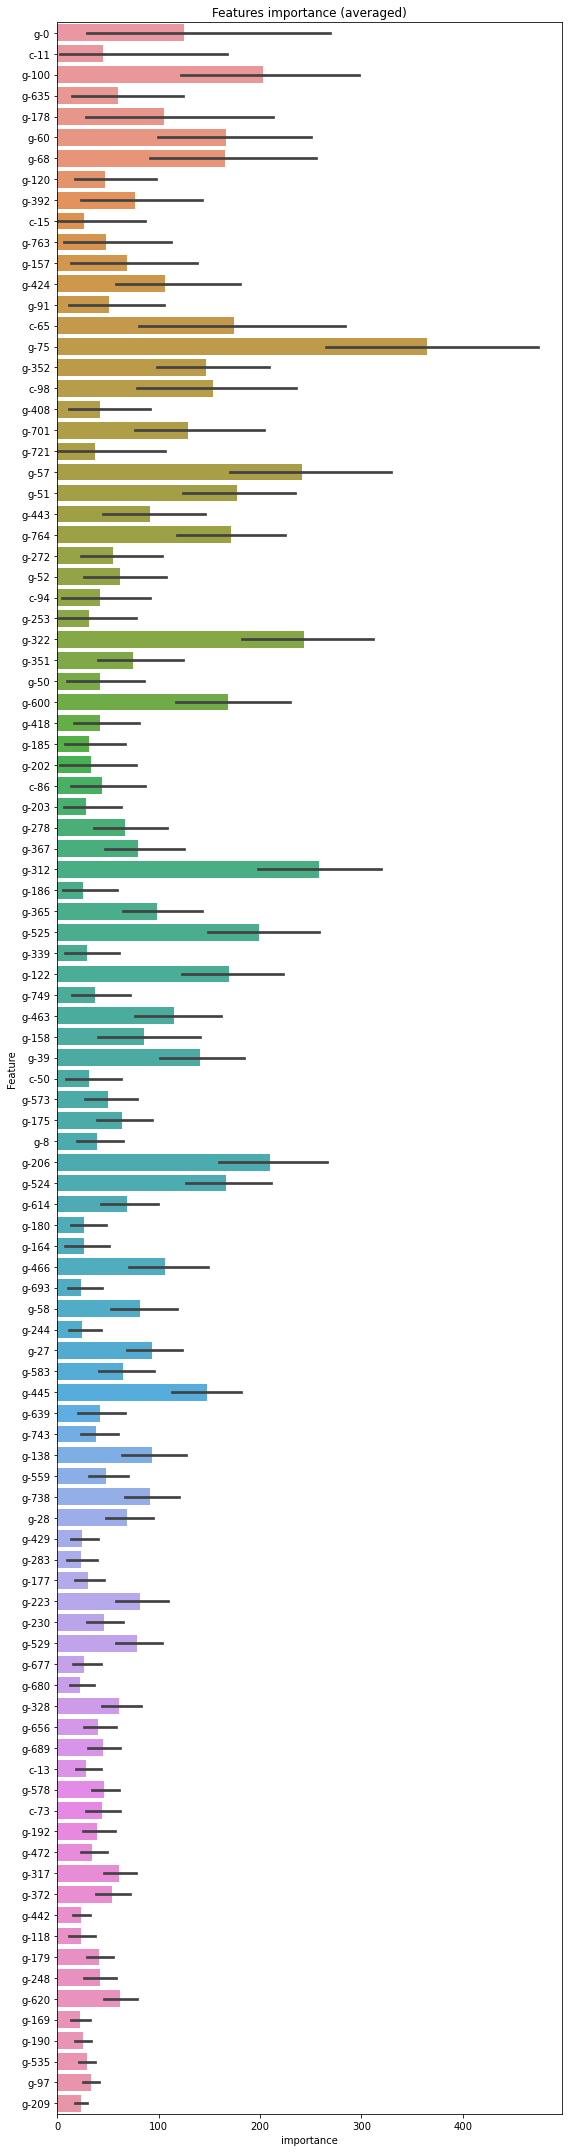

In [23]:
show_feature_importance(feature_importance_df)